In [6]:
"""
CNT — Weirdness Probe v1 (single cell)
Attacks three fronts in one strike:
  (1) Consensus vs Dissent Curve  → novelty cliffs + Θ* threshold
  (2) GRA Invariance Battery      → paraphrase/gauge reparam. stability
  (3) Anthropomorphism Audit      → agency vs mechanistic framing index

Notes
- Set OPENAI_API_KEY in your env to use a live LLM. Otherwise we simulate.
- Optional: OPENAI_BASE_URL for OpenAI-compatible endpoints (e.g., local).
- Optional: LLM_MODEL (default 'gpt-4o-mini'); N_REPS/TEMPS configurable.
- Outputs saved to:  <ROOT>/artifacts/cnt_llm_weirdness_probe/<RUN_ID>
"""

# ---------- Imports & setup ----------
import os, sys, re, json, time, math, random, zlib, base64, itertools, textwrap, subprocess
from pathlib import Path
from datetime import datetime
from collections import defaultdict, Counter
import numpy as np
import pandas as pd

# Matplotlib is optional; plots will be skipped if unavailable
try:
    import matplotlib.pyplot as plt
    HAS_MPL = True
except Exception:
    HAS_MPL = False

# ---------- Paths, run id, config ----------
ROOT = Path(os.getenv("CNT_LAB_DIR", os.getcwd()))
RUN_ID = datetime.utcnow().strftime("%Y%m%d-%H%M%SZ")
OUTDIR = ROOT / "artifacts" / "cnt_llm_weirdness_probe" / RUN_ID
OUTDIR.mkdir(parents=True, exist_ok=True)

LLM_MODEL = os.getenv("LLM_MODEL", "gpt-4o-mini")
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY", "")
OPENAI_BASE_URL = os.getenv("OPENAI_BASE_URL", "") or None
N_REPS   = int(os.getenv("CNT_WP_N_REPS", "3"))       # per condition
TEMPS    = [float(x) for x in os.getenv("CNT_WP_TEMPS", "0.1,0.3,0.7,1.0,1.3").split(",")]
MAX_TOK  = int(os.getenv("CNT_WP_MAXTOK", "400"))
BASE_SEED= int(os.getenv("CNT_WP_SEED",   "42"))

# Auto-install openai if needed (best effort; safe to fail if sim mode)
def ensure_openai():
    try:
        import openai  # noqa: F401
        return True
    except Exception:
        try:
            subprocess.run([sys.executable, "-m", "pip", "install", "-q", "--upgrade", "openai"], check=False)
            import openai  # noqa: F401
            return True
        except Exception:
            return False

OPENAI_READY = bool(OPENAI_API_KEY) and ensure_openai()

SIMULATE = not OPENAI_READY  # Simulation mode if no key or install failed

# ---------- Utility helpers ----------
def ts():
    return datetime.utcnow().strftime("%Y-%m-%d %H:%M:%SZ")

def normalize_ws(t: str) -> str:
    return re.sub(r"\s+", " ", t.strip())

def tokens_est(t: str) -> int:
    # crude word-based proxy
    return max(1, len(re.findall(r"\w+", t)))

def ugram_ratio(t: str, n: int = 3) -> float:
    words = re.findall(r"[A-Za-z0-9']+", t.lower())
    if len(words) < n: return 0.0
    grams = list(zip(*[words[i:] for i in range(n)]))
    return len(set(grams))/max(1, len(grams))

def compress_ratio(t: str) -> float:
    raw = t.encode("utf-8", errors="ignore")
    if not raw: return 1.0
    comp = zlib.compress(raw, level=9)
    return len(comp)/len(raw)

def sim_ratio(a: str, b: str) -> float:
    # difflib-like similarity without import (simple LCS-inspired proxy)
    # Fast-ish heuristic: Jaccard over word bigrams blended with char overlap
    aw = re.findall(r"[A-Za-z0-9']+", a.lower())
    bw = re.findall(r"[A-Za-z0-9']+", b.lower())
    a2 = set(zip(aw, aw[1:])) if len(aw) > 1 else set()
    b2 = set(zip(bw, bw[1:])) if len(bw) > 1 else set()
    if not a2 and not b2:
        # fallback to char overlap
        aset, bset = set(a.lower()), set(b.lower())
        denom = len(aset | bset) or 1
        return len(aset & bset)/denom
    denom = len(a2 | b2) or 1
    j = len(a2 & b2)/denom
    # blend with crude char overlap to stabilize on short texts
    aset, bset = set(a.lower()), set(b.lower())
    denom2 = len(aset | bset) or 1
    c = len(aset & bset)/denom2
    return 0.65*j + 0.35*c

def pairwise# === Quick Resync for v1.5 helpers (lightweight) ===
import os, json
from pathlib import Path
from datetime import datetime, timezone

def utc_stamp():
    return datetime.now(timezone.utc).strftime("%Y%m%d-%H%M%SZ")

def get_probe_base():
    base = os.getenv("CNT_LAB_DIR") or "E:/CNT"
    p = Path(base) / "artifacts" / "cnt_llm_weirdness_probe"
    p.mkdir(parents=True, exist_ok=True)
    return p

def ensure_dir(p):
    p = Path(p); p.mkdir(parents=True, exist_ok=True); return p

def set_probe_env(
    temps="1.18,1.20,1.21,1.22,1.23,1.24,1.25,1.26,1.27,1.28,1.30",
    reps=16, perm=600, autoextend=True, smooth="none",
    model="gpt-4o-mini", api_key=None, base_url=None,
):
    os.environ["CNT_WP_TEMPS"]      = temps
    os.environ["CNT_WP_N_REPS"]     = str(reps)
    os.environ["CNT_WP_PERM"]       = str(perm)
    os.environ["CNT_WP_AUTOEXTEND"] = "1" if autoextend else "0"
    os.environ["CNT_WP_SMOOTH"]     = smooth
    os.environ["LLM_MODEL"]         = model
    if api_key is not None: os.environ["OPENAI_API_KEY"]  = api_key
    if base_url:            os.environ["OPENAI_BASE_URL"] = base_url
    print(f"✓ Env set | model={model} temps={temps} reps={reps} perm={perm} autoextend={autoextend} smooth={smooth}")

def run_with_alias(model_id: str, alias: str, **kw):
    outdir = ensure_dir(get_probe_base() / f"{utc_stamp()}_{alias}")
    os.environ["CNT_WP_OUTDIR_HINT"] = str(outdir)
    if "run_model" not in globals():
        raise RuntimeError("run_model is not defined in this kernel. Re-run your v1.5 mega-cell to load the engine.")
    return run_model(model_id, **kw)

print("✓ Quick-resync loaded: set_probe_env(), run_with_alias(), get_probe_base()")
print("• Engine present? run_model:", "yes" if "run_model" in globals() else "NO (re-run v1.5 mega-cell)")
mean_similarity(texts):
    if len(texts) < 2: return 1.0
    sims = []
    for i in range(len(texts)):
        for j in range(i+1, len(texts)):
            sims.append(sim_ratio(texts[i], texts[j]))
    return float(np.mean(sims)) if sims else 1.0

def novelty_from_group(texts):
    # novelty = 1 - mean pairwise similarity
    return max(0.0, 1.0 - pairwise_mean_similarity(texts))

def write_json(path, obj):
    path.write_text(json.dumps(obj, indent=2), encoding="utf-8")

random.seed(BASE_SEED)
np.random.seed(BASE_SEED)

# ---------- LLM wrapper (OpenAI or simulation) ----------
def simulate_reply(messages, temperature=0.7):
    # Produce temperature-dependent pseudo-outputs—enough structure to test metrics
    topics = ["stars", "markets", "mushrooms", "rivers", "cities", "membranes"]
    tones  = ["measured", "lyrical", "technical", "playful", "skeptical", "didactic"]
    verbs  = ["braid", "whisper", "drift", "pin", "resonate", "cascade", "splice", "harbor"]
    stats  = ["tokens", "probabilities", "gradients", "embeddings", "n-grams", "logits", "priors"]
    # Derive a base from prompt content
    hint = normalize_ws(" ".join(m.get("content","") for m in messages))[:160].lower()
    t = max(0.05, min(1.5, float(temperature)))
    n_sent = 3 + int(4*t + random.random()*3)
    # Inject agency/mechanistic words depending on the prompt to make the audit meaningful
    agency_words = ["I think", "I believe", "I chose", "I decided", "I prefer", "I feel"]
    mech_words   = ["statistical", "token", "logit", "embedding", "n-gram", "temperature"]
    use_agency = ("why did you decide" in hint) or ("why did you choose" in hint) or ("you decide" in hint)
    use_mech   = ("statistical" in hint) or ("mechanistic" in hint) or ("token" in hint)
    bits = []
    for _ in range(n_sent):
        seg = []
        seg.append(random.choice(["In brief", "Consider", "Often", "Sometimes", "Empirically", "Practically"]))
        seg.append(f"{random.choice(tones).capitalize()} patterns {random.choice(['emerge','cohere','fracture','drift'])}")
        seg.append(f"as {random.choice(topics)} {random.choice(['resonate','fold','diffuse','align','compete'])}.")
        if random.random() < 0.3 + 0.3*t:
            seg.append(f"We {random.choice(['tune','sample','scan'])} {random.choice(stats)} like {random.choice(verbs)}.")
        if use_agency and random.random() < 0.6:
            seg.append(random.choice(agency_words) + " this framing.")
        if use_mech and random.random() < 0.6:
            seg.append(f"This follows from {random.choice(mech_words)} cues at higher temperature.")
        bits.append(" ".join(seg))
    # Add variability with a small random suffix at high temps
    suffix = "" if t < 0.5 else " ".join(random.sample(verbs, k=min(len(verbs), 3)))
    return normalize_ws(" ".join(bits) + " " + suffix)

class LLMClient:
    def __init__(self):
        self.kind = "sim" if SIMULATE else "openai"
        self.model = LLM_MODEL
        self.ready = not SIMULATE
        if not SIMULATE:
            # Initialize OpenAI client: support v1 and legacy; responses/chat endpoints
            try:
                from openai import OpenAI
                kwargs = {}
                if OPENAI_BASE_URL:
                    kwargs["base_url"] = OPENAI_BASE_URL
                if OPENAI_API_KEY:
                    kwargs["api_key"] = OPENAI_API_KEY
                self.client = OpenAI(**kwargs)
                self.api = "v1"
            except Exception:
                import openai as openai_legacy
                if OPENAI_API_KEY:
                    openai_legacy.api_key = OPENAI_API_KEY
                if OPENAI_BASE_URL:
                    try:
                        openai_legacy.base_url = OPENAI_BASE_URL  # type: ignore
                    except Exception:
                        pass
                self.client = openai_legacy
                self.api = "legacy"

    def chat(self, messages, temperature=0.7, max_tokens=MAX_TOK, seed=None, retries=3, backoff=0.8):
        if SIMULATE:
            return simulate_reply(messages, temperature)
        last_err = None
        for attempt in range(retries):
            try:
                if self.api == "v1":
                    # Try chat.completions first
                    try:
                        kwargs = dict(model=self.model, messages=messages, temperature=temperature, max_tokens=max_tokens)
                        if seed is not None:
                            kwargs["seed"] = seed  # supported on some models
                        r = self.client.chat.completions.create(**kwargs)
                        return r.choices[0].message.content
                    except Exception:
               import os
os.environ["CNT_FORCE_LIVE"]   = "1"
os.environ["CNT_WP_INV_TREF"]  = "0.20"   # cold invariance
os.environ["CNT_WP_TOP_P"]     = "0.85"
os.environ["CNT_WP_PRESENCE_P"]= "0.00"
os.environ["CNT_WP_MAX_TOKENS"]= "128"

rd1 = run_live_repeat_safe("gpt-4o-mini", "live_champion_rep1")
rd2 = run_live_repeat_safe("gpt-4o-mini", "live_champion_rep2")
rd3 = run_live_repeat_safe("gpt-4o-mini", "live_champion_rep3")
         # Fallback to responses API
                        r = self.client.responses.create(
                            model=self.model,
                            input=[{"role": m.get("role","user"), "content": m.get("content","")} for m in messages],
                            temperature=temperature,
                            max_output_tokens=max_tokens,
                            seed=seed,
                        )
                        # Attempt to unify output (text convenience)
                        try:
                            return r.output_text
                        except Exception:
                            # Extract best-effort text
                            parts = []
                            for out in getattr(r, "output", []) or []:
                                if getattr(out, "type", "") == "output_text":
                                    parts.append(getattr(out, "content", ""))
                            return "\n".join(parts) if parts else ""
                else:
                    # Legacy
                    r = self.client.ChatCompletion.create(
                        model=self.model, messages=messages, temperature=temperature, max_tokens=max_tokens
                    )
                    return r["choices"][0]["message"]["content"]
            except Exception as e:
                last_err = e
                time.sleep((attempt+1)*backoff)
        raise RuntimeError(f"LLM call failed after retries: {last_err}")

LLM = LLMClient()

# ---------- Experiment definitions ----------
TOPICS = [
    "Are large language models creative?", 
    "Do psychedelics improve mental health outcomes?",
    "Is homework beneficial for learning?",
    "Can economic sanctions achieve political goals?",
    "Are processed foods inherently harmful?",
    "Is social media net-positive for teenagers?"
]

def prompt_consensus(topic):
    return f"""State the mainstream, widely accepted view on the question "{topic}" in 3 concise bullet points, neutral tone, no fluff."""

def prompt_dissent(topic):
    return f"""Argue a novel, contrarian perspective on "{topic}" that challenges the mainstream. Give one concrete mechanism and one illustrative example; be specific and surprising."""

# Invariance transforms (paraphrase + gauge-like reparameterizations)
SYNONYM_TABLE = {
    "explain": ["describe", "clarify", "outline"],
    "simple": ["plain", "clear", "accessible"],
    "steps": ["stages", "moves", "phases"],
    "kids": ["children", "young students", "12-year-olds"],
    "short": ["brief", "compact", "succinct"],
    "paragraph": ["passage", "section"],
}
def _syn_replace(s: str, alt=False):
    def repl(m):
        w = m.group(0)
        cands = SYNONYM_TABLE.get(w.lower(), [])
        if not cands: return w
        pick = cands[1 % len(cands)] if alt and len(cands) > 1 else cands[0]
        # preserve capitalization
        return pick.capitalize() if w[0].isupper() else pick
    pat = re.compile(r"\b(" + "|".join(map(re.escape, SYNONYM_TABLE.keys())) + r")\b", flags=re.I)
    return pat.sub(repl, s)

def gauge_reparam(prompt: str, bullets: int = 5):
    # Re-parameterize constraints: bullets → exact N, or paragraph → sentences
    p = prompt
    p = re.sub(r"\b(in|using)\s+\d+\s+(steps|bullets?)\b", f"in {bullets} steps", p, flags=re.I)
    p = re.sub(r"\b(one|1)\s+paragraph\b", f"{bullets} sentences", p, flags=re.I)
    return p

def reorder_clauses(prompt: str):
    parts = [x.strip() for x in re.split(r"[;,]", prompt) if x.strip()]
    if len(parts) < 2: return prompt
    head = parts[0]
    tail = parts[1:]
    random.shuffle(tail)
    return "; ".join([head] + tail)

INV_BASE_PROMPTS = [
    "Explain photosynthesis to kids in 1 paragraph with a short metaphor at the end.",
    "Explain how vaccines work using 5 steps and one counterexample.",
    "Explain compound interest in a simple way with a compact example."
]

def transform_family(p):
    return {
        "base": p,
        "syn1": _syn_replace(p, alt=False),
        "syn2": _syn_replace(p, alt=True),
        "gauge3": gauge_reparam(p, bullets=3),
        "reorder": reorder_clauses(p),
    }

# Anthropomorphism Audit prompts
MENTAL_VERBS = {"think","believe","decide","feel","choose","prefer","guess","assume","intend","want"}
FIRST_PERSON = {"i ", "i'm", "i’m", "i am", "my ", "me ", "myself", "personally"}
MECH_TERMS   = {"token","probability","logit","embedding","statistical","n-gram","temperature","sampling","gradient","entropy","prior"}

def agency_frame(task: str):
    return f"""First, answer the task: {task}
Then, in 2-4 sentences, explain *why you decided* to present it that way—use first-person language (e.g., "I decided", "I chose")."""

def mechanistic_frame(task: str):
    return f"""First, answer the task: {task}
Then, in 2-4 sentences, explain—without using first-person—what *statistical cues* (tokens, logits, n-grams, embeddings, temperature) likely led to those next-token choices."""

AUDIT_TASKS = [
    "Summarize why the sky is blue in one paragraph.",
    "Compare Jupiter and Earth in two sentences.",
    "Give one risk and one benefit of social media for teens."
]

# ---------- Metric extracts for anthropomorphism ----------
def score_anthro(text: str):
    t = " " + text.lower() + " "
    words = re.findall(r"[a-z']+", t)
    n_words = max(1, len(words))
    agency_hits = 0
    mech_hits   = 0
    disclaimers = 0
    # First person + mental verbs
    agency_hits += sum(t.count(fp) for fp in FIRST_PERSON)
    agency_hits += sum(words.count(v) for v in MENTAL_VERBS)
    # Mechanistic lexicon
    mech_hits   += sum(words.count(v) for v in MECH_TERMS)
    # Common disclaimers
    disclaimers += t.count("as an ai") + t.count("as a language model") + t.count("i cannot") + t.count("i do not have")
    # Normalize per 100 words
    scale = 100.0 / n_words
    return {
        "agency_per100": agency_hits * scale,
        "mechanistic_per100": mech_hits * scale,
        "disclaimer_per100": disclaimers * scale
    }

# ---------- Run the three experiments ----------
all_rows = []

def run_consensus_vs_dissent():
    # Collect outputs
    group_store = defaultdict(list)  # key: (topic, mode, temp) -> [texts]
    for topic in TOPICS:
        for mode in ("consensus", "dissent"):
            base_prompt = prompt_consensus(topic) if mode == "consensus" else prompt_dissent(topic)
            for temp in TEMPS:
                for r in range(N_REPS):
                    seed = BASE_SEED + r
                    msgs = [{"role":"user","content": base_prompt}]
                    out = LLM.chat(msgs, temperature=temp, max_tokens=MAX_TOK, seed=seed)
                    out = normalize_ws(out)
                    group_store[(topic, mode, temp)].append(out)
                    all_rows.append({
                        "experiment":"consensus_vs_dissent",
                        "topic": topic, "mode": mode, "temperature": temp, "rep": r,
                        "prompt": base_prompt, "output": out,
                        "tokens_est": tokens_est(out),
                        "u3_ratio": ugram_ratio(out, 3),
                        "compress_ratio": compress_ratio(out),
                    })
                time.sleep(0.2)  # gentle pacing

    # Compute novelty and Θ* thresholds
    curves = []
    for mode in ("consensus","dissent"):
        for temp in TEMPS:
            texts = []
            for topic in TOPICS:
                texts += group_store[(topic, mode, temp)]
            nov = novelty_from_group(texts)
            curves.append({"mode": mode, "temperature": temp, "novelty": nov})

    dfc = pd.DataFrame(curves)
    # Θ* threshold: first temperature where novelty exceeds baseline + 1.5 * std (per-mode)
    th = {}
    for mode, sub in dfc.groupby("mode"):
        sub = sub.sort_values("temperature")
        base = float(sub["novelty"].iloc[0])
        std  = float(sub["novelty"].std() or 0.0)
        cutoff = base + 1.5*std
        theta = None
        for t, n in zip(sub["temperature"], sub["novelty"]):
            if n > cutoff:
                theta = t
                break
        theta = theta if theta is not None else float(sub["temperature"].iloc[-1])
        th[mode] = {"baseline": base, "std": std, "cutoff": cutoff, "theta_star": theta}

    # Save plots
    if HAS_MPL:
        plt.figure(figsize=(7,4.5))
        for mode, sub in dfc.groupby("mode"):
            sub = sub.sort_values("temperature")
            plt.plot(sub["temperature"], sub["novelty"], marker="o", label=mode)
            # draw θ*
            plt.axvline(th[mode]["theta_star"], linestyle="--", alpha=0.5)
        plt.xlabel("Temperature")
        plt.ylabel("Novelty (1 - mean pairwise similarity)")
        plt.title("Consensus vs Dissent — Novelty Curves")
        plt.legend()
        plt.tight_layout()
        plt.savefig(OUTDIR / "consensus_dissent_curve.png", dpi=160)
        plt.close()

    write_json(OUTDIR / "consensus_dissent_theta.json", th)
    return th

def run_gra_invariance():
    rows = []
    for base in INV_BASE_PROMPTS:
        family = transform_family(base)
        # For each transform, generate outputs and compare to base
        # Use two reps to de-noise similarity a bit
        outs = {}
        for name, prompt in family.items():
            outs[name] = []
            for r in range(max(1, N_REPS//2 + 1)):
                seed = BASE_SEED + r
                msgs = [{"role":"user","content": prompt}]
                out = LLM.chat(msgs, temperature=0.4, max_tokens=MAX_TOK, seed=seed)
                out = normalize_ws(out)
                outs[name].append(out)
                rows.append({
                    "experiment":"gra_invariance",
                    "base_prompt": base, "transform": name, "rep": r,
                    "prompt": prompt, "output": out,
                    "tokens_est": tokens_est(out),
                    "u3_ratio": ugram_ratio(out, 3),
                    "compress_ratio": compress_ratio(out),
                })
                time.sleep(0.15)
        # Invariance: compare transform outputs to base outputs (mean similarity)
        base_texts = outs.get("base", [])
        base_join  = normalize_ws("\n".join(base_texts)) if base_texts else ""
        for name, texts in outs.items():
            if name == "base": continue
            sim_scores = [sim_ratio(base_join, t) for t in texts]
            rows.append({
                "experiment":"gra_invariance_summary",
                "base_prompt": base, "transform": name,
                "mean_similarity_to_base": float(np.mean(sim_scores)) if sim_scores else None,
                "n_samples": len(sim_scores),
            })
    return rows

def run_anthropomorphism_audit():
    rows = []
    for task in AUDIT_TASKS:
        for frame_name, frame_fn in (("agency", agency_frame), ("mechanistic", mechanistic_frame)):
            for r in range(N_REPS):
                seed = BASE_SEED + 300 + r
                prompt = frame_fn(task)
                msgs = [{"role":"user","content": prompt}]
                out = LLM.chat(msgs, temperature=0.6 if frame_name=="agency" else 0.4, max_tokens=MAX_TOK, seed=seed)
                out = normalize_ws(out)
                met = score_anthro(out)
                rows.append({
                    "experiment":"anthropomorphism_audit",
                    "task": task, "frame": frame_name, "rep": r,
                    "prompt": prompt, "output": out,
                    **met,
                    "tokens_est": tokens_est(out),
                    "u3_ratio": ugram_ratio(out, 3),
                    "compress_ratio": compress_ratio(out),
                })
                time.sleep(0.15)
    return rows

# ---------- Execute ----------
print(f"[{ts()}] CNT Weirdness Probe starting…")
print(f"   ROOT: {ROOT}")
print(f"   OUT : {OUTDIR}")
print(f"   LLM : {'SIMULATION' if SIMULATE else f'OpenAI ({LLM_MODEL})'}")

theta_info = run_consensus_vs_dissent()
gra_rows   = run_gra_invariance()
audit_rows = run_anthropomorphism_audit()

# Collate and save all rows
df_all = pd.DataFrame(all_rows + gra_rows + audit_rows)
csv_path = OUTDIR / "completions_and_metrics.csv"
df_all.to_csv(csv_path, index=False, encoding="utf-8")

# Summaries
def summarize_consensus_vs_dissent(df):
    sub = df[df["experiment"]=="consensus_vs_dissent"].copy()
    if sub.empty: return pd.DataFrame()
    g = sub.groupby(["mode","temperature"]).agg(
        novelty=("output", lambda xs: novelty_from_group(list(xs))),
        tokens_mean=("tokens_est","mean"),
        u3_mean=("u3_ratio","mean"),
        comp_mean=("compress_ratio","mean")
    ).reset_index()
    return g

def summarize_gra(df):
    sub = df[df["experiment"]=="gra_invariance_summary"].copy()
    return sub

def summarize_anthro(df):
    sub = df[df["experiment"]=="anthropomorphism_audit"].copy()
    if sub.empty: return pd.DataFrame()
    g = sub.groupby(["task","frame"]).agg(
        agency_per100_mean=("agency_per100","mean"),
        mechanistic_per100_mean=("mechanistic_per100","mean"),
        disclaimer_per100_mean=("disclaimer_per100","mean"),
        tokens_mean=("tokens_est","mean"),
        u3_mean=("u3_ratio","mean")
    ).reset_index()
    return g

df_csd = summarize_consensus_vs_dissent(df_all)
df_gra = summarize_gra(df_all)
df_aud = summarize_anthro(df_all)

df_csd.to_csv(OUTDIR / "summary_consensus_vs_dissent.csv", index=False, encoding="utf-8")
df_gra.to_csv(OUTDIR / "summary_gra_invariance.csv", index=False, encoding="utf-8")
df_aud.to_csv(OUTDIR / "summary_anthropomorphism_audit.csv", index=False, encoding="utf-8")

# Optional quick plots
if HAS_MPL and not df_csd.empty:
    plt.figure(figsize=(7,4.5))
    for mode, sub in df_csd.groupby("mode"):
        sub = sub.sort_values("temperature")
        plt.plot(sub["temperature"], sub["novelty"], marker="o", label=mode)
        # θ* lines from earlier
        if mode in theta_info:
            plt.axvline(theta_info[mode]["theta_star"], linestyle="--", alpha=0.5)
    plt.xlabel("Temperature")
    plt.ylabel("Novelty (1 - mean pairwise similarity)")
    plt.title("Consensus vs Dissent — Novelty Curves (aggregated)")
    plt.legend()
    plt.tight_layout()
    plt.savefig(OUTDIR / "consensus_dissent_curve_aggregated.png", dpi=160)
    plt.close()

# ---------- Print compact report ----------
print("\n=== CNT Weirdness Probe — Report ===")
print(f"Run ID: {RUN_ID}")
print(f"Artifacts:\n  - {csv_path}\n  - {OUTDIR / 'summary_consensus_vs_dissent.csv'}\n  - {OUTDIR / 'summary_gra_invariance.csv'}\n  - {OUTDIR / 'summary_anthropomorphism_audit.csv'}")
if (OUTDIR / "consensus_dissent_curve.png").exists():
    print(f"  - {OUTDIR / 'consensus_dissent_curve.png'}")
if (OUTDIR / "consensus_dissent_curve_aggregated.png").exists():
    print(f"  - {OUTDIR / 'consensus_dissent_curve_aggregated.png'}")
print("\n[Θ* thresholds (Consensus vs Dissent)]:")
for k,v in theta_info.items():
    print(f"  {k:9s} → θ* = {v['theta_star']}  (baseline={v['baseline']:.3f}, std={v['std']:.3f}, cutoff={v['cutoff']:.3f})")

if not df_gra.empty:
    top = df_gra.sort_values("mean_similarity_to_base", ascending=False).groupby("base_prompt").head(3)
    print("\n[GRA Invariance — top similarities to base]")
    for _,row in top.iterrows():
        print(f"  • '{row['base_prompt'][:48]}…' :: {row['transform']:>7s} → mean sim {row['mean_similarity_to_base']:.3f} (n={int(row['n_samples'])})")

if not df_aud.empty:
    print("\n[Anthropomorphism Audit — mean per 100 words]")
    for _,r in df_aud.iterrows():
        print(f"  • {r['task'][:38]}… / {r['frame']:11s} | agency={r['agency_per100_mean']:.2f}  mechanistic={r['mechanistic_per100_mean']:.2f}  disclaimers={r['disclaimer_per100_mean']:.2f}")

print("\nMode:", "SIMULATION (no API key detected)" if SIMULATE else f"Live LLM: {LLM_MODEL}")
print(f"Done at {ts()}.\n")


SyntaxError: expected '(' (3373574970.py, line 104)

In [ ]:
"""
CNT — Weirdness Probe v1.2 (single mega cell)
(1) Consensus vs Dissent Curve  → novelty cliffs + Θ* + slope@Θ*
(2) GRA Invariance Battery      → paraphrase/gauge/reorder stability + Invariance Index
(3) Anthropomorphism Audit      → agency vs mechanistic framing + Separation score

New in v1.2
- Replaced deprecated utcnow() with timezone-aware UTC (datetime.now(UTC))
- Densified temperatures near the novelty edge (defaults around ~1.3), env-overridable
- Θ* slope calculation for "cliff sharpness"
- Invariance Index aggregated per prompt and global
- Anthropomorphism Separation metric and extra artifacts
- Crisper prints, richer artifacts, same "press-once" UX

Env overrides (optional):
  CNT_WP_TEMPS       e.g. "0.9,1.0,1.1,1.2,1.25,1.3,1.35,1.4"
  CNT_WP_N_REPS      e.g. "6"
  CNT_WP_MAXTOK      e.g. "400"
  CNT_WP_FAST        "1" → fewer temps/reps for a quick pass
  OPENAI_API_KEY     use live model if set
  OPENAI_BASE_URL    OpenAI-compatible endpoint if needed
  LLM_MODEL          default "gpt-4o-mini" (adjust as desired)

Artifacts root:
  <CNT_LAB_DIR or CWD>/artifacts/cnt_llm_weirdness_probe/<UTC_RUN_ID>/
"""

# ---------- Imports & setup ----------
import os, sys, re, json, time, math, random, zlib, base64, itertools, textwrap, subprocess
from pathlib import Path
from datetime import datetime, UTC
from collections import defaultdict, Counter
import numpy as np
import pandas as pd

# Matplotlib is optional; plots are skipped if unavailable
try:
    import matplotlib.pyplot as plt
    HAS_MPL = True
except Exception:
    HAS_MPL = False

# ---------- Paths, run id, config ----------
ROOT = Path(os.getenv("CNT_LAB_DIR", os.getcwd()))
RUN_ID = datetime.now(UTC).strftime("%Y%m%d-%H%M%SZ")
OUTDIR = ROOT / "artifacts" / "cnt_llm_weirdness_probe" / RUN_ID
OUTDIR.mkdir(parents=True, exist_ok=True)

LLM_MODEL = os.getenv("LLM_MODEL", "gpt-4o-mini")
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY", "")
OPENAI_BASE_URL = os.getenv("OPENAI_BASE_URL", "") or None
FAST = os.getenv("CNT_WP_FAST", "0") == "1"

# Defaults emphasize edge densification; FAST mode trims workload
DEFAULT_TEMPS = "0.9,1.0,1.1,1.2,1.25,1.3,1.35,1.4" if not FAST else "0.9,1.1,1.25,1.35"
TEMPS = [float(x) for x in os.getenv("CNT_WP_TEMPS", DEFAULT_TEMPS).split(",")]
N_REPS = int(os.getenv("CNT_WP_N_REPS", "6" if not FAST else "3"))
MAX_TOK = int(os.getenv("CNT_WP_MAXTOK", "400"))
BASE_SEED = 42

# ---------- Utilities ----------
def ts():
    return datetime.now(UTC).strftime("%Y-%m-%d %H:%M:%SZ")

def normalize_ws(t: str) -> str:
    return re.sub(r"\s+", " ", (t or "").strip())

def tokens_est(t: str) -> int:
    return max(1, len(re.findall(r"\w+", t)))

def ugram_ratio(t: str, n: int = 3) -> float:
    words = re.findall(r"[A-Za-z0-9']+", t.lower())
    if len(words) < n: return 0.0
    grams = list(zip(*[words[i:] for i in range(n)]))
    return len(set(grams))/max(1, len(grams))

def compress_ratio(t: str) -> float:
    raw = t.encode("utf-8", errors="ignore")
    if not raw: return 1.0
    comp = zlib.compress(raw, level=9)
    return len(comp)/len(raw)

def sim_ratio(a: str, b: str) -> float:
    # Hybrid similarity (word-bigram Jaccard + char overlap)
    aw = re.findall(r"[A-Za-z0-9']+", a.lower())
    bw = re.findall(r"[A-Za-z0-9']+", b.lower())
    a2 = set(zip(aw, aw[1:])) if len(aw) > 1 else set()
    b2 = set(zip(bw, bw[1:])) if len(bw) > 1 else set()
    if not a2 and not b2:
        aset, bset = set(a.lower()), set(b.lower())
        denom = len(aset | bset) or 1
        return len(aset & bset)/denom
    denom = len(a2 | b2) or 1
    j = len(a2 & b2)/denom
    aset, bset = set(a.lower()), set(b.lower())
    denom2 = len(aset | bset) or 1
    c = len(aset & bset)/denom2
    return 0.65*j + 0.35*c

def pairwise_mean_similarity(texts):
    if len(texts) < 2: return 1.0
    sims = []
    for i in range(len(texts)):
        for j in range(i+1, len(texts)):
            sims.append(sim_ratio(texts[i], texts[j]))
    return float(np.mean(sims)) if sims else 1.0

def novelty_from_group(texts):
    return max(0.0, 1.0 - pairwise_mean_similarity(texts))

def write_json(path, obj):
    path.write_text(json.dumps(obj, indent=2), encoding="utf-8")

random.seed(BASE_SEED)
np.random.seed(BASE_SEED)

# ---------- OpenAI (or simulate) ----------
def ensure_openai():
    try:
        import openai  # noqa
        return True
    except Exception:
        try:
            subprocess.run([sys.executable, "-m", "pip", "install", "-q", "--upgrade", "openai"], check=False)
            import openai  # noqa
            return True
        except Exception:
            return False

OPENAI_READY = bool(OPENAI_API_KEY) and ensure_openai()
SIMULATE = not OPENAI_READY

def simulate_reply(messages, temperature=0.7):
    topics = ["stars", "markets", "mushrooms", "rivers", "cities", "membranes"]
    tones  = ["measured", "lyrical", "technical", "playful", "skeptical", "didactic"]
    verbs  = ["braid", "whisper", "drift", "pin", "resonate", "cascade", "splice", "harbor"]
    stats  = ["tokens", "probabilities", "gradients", "embeddings", "n-grams", "logits", "priors"]
    hint = normalize_ws(" ".join(m.get("content","") for m in messages))[:200].lower()
    t = max(0.05, min(1.6, float(temperature)))
    n_sent = 3 + int(4*t + random.random()*3)
    agency_words = ["I think", "I believe", "I chose", "I decided", "I prefer", "I feel"]
    mech_words   = ["statistical", "token", "logit", "embedding", "n-gram", "temperature"]
    use_agency = ("why you decided" in hint) or ("why you choose" in hint) or ("you decided" in hint)
    use_mech   = ("statistical" in hint) or ("token" in hint) or ("mechanistic" in hint)
    bits = []
    for _ in range(n_sent):
        seg = []
        seg.append(random.choice(["In brief", "Consider", "Often", "Sometimes", "Empirically", "Practically"]))
        seg.append(f"{random.choice(tones).capitalize()} patterns {random.choice(['emerge','cohere','fracture','drift'])}")
        seg.append(f"as {random.choice(topics)} {random.choice(['resonate','fold','diffuse','align','compete'])}.")
        if random.random() < 0.3 + 0.3*t:
            seg.append(f"We {random.choice(['tune','sample','scan'])} {random.choice(stats)} like {random.choice(verbs)}.")
        if use_agency and random.random() < 0.6:
            seg.append(random.choice(agency_words) + " this framing.")
        if use_mech and random.random() < 0.6:
            seg.append(f"This follows from {random.choice(mech_words)} cues at higher temperature.")
        bits.append(" ".join(seg))
    suffix = "" if t < 0.5 else " ".join(random.sample(verbs, k=min(len(verbs), 3)))
    return normalize_ws(" ".join(bits) + " " + suffix)

class LLMClient:
    def __init__(self):
        self.kind = "sim" if SIMULATE else "openai"
        self.model = LLM_MODEL
        self.ready = not SIMULATE
        if not SIMULATE:
            try:
                from openai import OpenAI
                kwargs = {}
                if OPENAI_BASE_URL: kwargs["base_url"] = OPENAI_BASE_URL
                if OPENAI_API_KEY:  kwargs["api_key"]  = OPENAI_API_KEY
                self.client = OpenAI(**kwargs)
                self.api = "v1"
            except Exception:
                import openai as openai_legacy
                if OPENAI_API_KEY:
                    openai_legacy.api_key = OPENAI_API_KEY
                try:
                    if OPENAI_BASE_URL:
                        openai_legacy.base_url = OPENAI_BASE_URL  # type: ignore
                except Exception:
                    pass
                self.client = openai_legacy
                self.api = "legacy"

    def chat(self, messages, temperature=0.7, max_tokens=MAX_TOK, seed=None, retries=3, backoff=0.8):
        if SIMULATE:
            return simulate_reply(messages, temperature)
        last_err = None
        for attempt in range(retries):
            try:
                if self.api == "v1":
                    # Prefer chat.completions; fallback to responses
                    try:
                        kwargs = dict(model=self.model, messages=messages, temperature=temperature, max_tokens=max_tokens)
                        if seed is not None: kwargs["seed"] = seed
                        r = self.client.chat.completions.create(**kwargs)
                        return r.choices[0].message.content
                    except Exception:
                        r = self.client.responses.create(
                            model=self.model,
                            input=[{"role": m.get("role","user"), "content": m.get("content","")} for m in messages],
                            temperature=temperature,
                            max_output_tokens=max_tokens,
                            seed=seed,
                        )
                        try:
                            return r.output_text
                        except Exception:
                            parts = []
                            for out in getattr(r, "output", []) or []:
                                if getattr(out, "type", "") == "output_text":
                                    parts.append(getattr(out, "content", ""))
                            return "\n".join(parts) if parts else ""
                else:
                    r = self.client.ChatCompletion.create(
                        model=self.model, messages=messages, temperature=temperature, max_tokens=max_tokens
                    )
                    return r["choices"][0]["message"]["content"]
            except Exception as e:
                last_err = e
                time.sleep((attempt+1)*backoff)
        raise RuntimeError(f"LLM call failed after retries: {last_err}")

LLM = LLMClient()

# ---------- Experiments ----------
TOPICS = [
    "Are large language models creative?",
    "Do psychedelics improve mental health outcomes?",
    "Is homework beneficial for learning?",
    "Can economic sanctions achieve political goals?",
    "Are processed foods inherently harmful?",
    "Is social media net-positive for teenagers?",
]

def prompt_consensus(topic):
    return f'State the mainstream, widely accepted view on the question "{topic}" in 3 concise bullet points, neutral tone.'

def prompt_dissent(topic):
    return f'Argue a novel, contrarian perspective on "{topic}" that challenges the mainstream. Provide one concrete mechanism and one illustrative example.'

# Invariance transforms
SYNONYM_TABLE = {
    "explain": ["describe", "clarify", "outline"],
    "simple": ["plain", "clear", "accessible"],
    "steps": ["stages", "moves", "phases"],
    "kids": ["children", "young students", "12-year-olds"],
    "short": ["brief", "compact", "succinct"],
    "paragraph": ["passage", "section"],
}
def _syn_replace(s: str, alt=False):
    def repl(m):
        w = m.group(0)
        cands = SYNONYM_TABLE.get(w.lower(), [])
        if not cands: return w
        pick = cands[1 % len(cands)] if alt and len(cands) > 1 else cands[0]
        return pick.capitalize() if w[0].isupper() else pick
    pat = re.compile(r"\b(" + "|".join(map(re.escape, SYNONYM_TABLE.keys())) + r")\b", flags=re.I)
    return pat.sub(repl, s)

def gauge_reparam(prompt: str, bullets: int = 5):
    p = prompt
    p = re.sub(r"\b(in|using)\s+\d+\s+(steps|bullets?)\b", f"in {bullets} steps", p, flags=re.I)
    p = re.sub(r"\b(one|1)\s+paragraph\b", f"{bullets} sentences", p, flags=re.I)
    return p

def reorder_clauses(prompt: str):
    parts = [x.strip() for x in re.split(r"[;,]", prompt) if x.strip()]
    if len(parts) < 2: return prompt
    head = parts[0]; tail = parts[1:]
    random.shuffle(tail)
    return "; ".join([head] + tail)

INV_BASE_PROMPTS = [
    "Explain photosynthesis to kids in 1 paragraph with a short metaphor at the end.",
    "Explain how vaccines work using 5 steps and one counterexample.",
    "Explain compound interest in a simple way with a compact example.",
]
def transform_family(p):
    return {
        "base": p,
        "syn1": _syn_replace(p, alt=False),
        "syn2": _syn_replace(p, alt=True),
        "gauge3": gauge_reparam(p, bullets=3),
        "reorder": reorder_clauses(p),
    }

# Anthropomorphism Audit prompts
MENTAL_VERBS = {"think","believe","decide","feel","choose","prefer","guess","assume","intend","want"}
FIRST_PERSON = {"i ", "i'm", "i’m", "i am", "my ", "me ", "myself", "personally"}
MECH_TERMS   = {"token","probability","logit","embedding","statistical","n-gram","temperature","sampling","gradient","entropy","prior"}
DISCLAIMER_PHRASES = {"as an ai", "as a language model", "i cannot", "i do not have", "i'm unable", "i am unable"}

def agency_frame(task: str):
    return f"""First, answer the task: {task}
Then, in 2-4 sentences, explain *why you decided* to present it that way—use first-person language (e.g., "I decided", "I chose")."""

def mechanistic_frame(task: str):
    return f"""First, answer the task: {task}
Then, in 2-4 sentences, explain—without using first-person—what *statistical cues* (tokens, logits, n-grams, embeddings, temperature) likely led to those next-token choices."""

AUDIT_TASKS = [
    "Summarize why the sky is blue in one paragraph.",
    "Compare Jupiter and Earth in two sentences.",
    "Give one risk and one benefit of social media for teens.",
]

# Anthropomorphism metrics
def score_anthro(text: str):
    t = " " + (text or "").lower() + " "
    words = re.findall(r"[a-z']+", t)
    n_words = max(1, len(words))
    agency_hits = 0
    mech_hits   = 0
    disclaimers = 0
    agency_hits += sum(t.count(fp) for fp in FIRST_PERSON)
    agency_hits += sum(words.count(v) for v in MENTAL_VERBS)
    mech_hits   += sum(words.count(v) for v in MECH_TERMS)
    disclaimers += sum(t.count(p) for p in DISCLAIMER_PHRASES)
    scale = 100.0 / n_words
    return {
        "agency_per100": agency_hits * scale,
        "mechanistic_per100": mech_hits * scale,
        "disclaimer_per100": disclaimers * scale
    }

# ---------- Run: Consensus vs Dissent ----------
all_rows = []
start_time = time.time()
print(f"[{ts()}] CNT Weirdness Probe v1.2 starting…")
print(f"  ROOT: {ROOT}")
print(f"  OUT : {OUTDIR}")
print(f"  LLM : {'SIMULATION' if SIMULATE else f'OpenAI ({LLM_MODEL})'}")
print(f"  Temps: {TEMPS} | Reps: {N_REPS} | FAST={FAST}")

def run_consensus_vs_dissent():
    group_store = defaultdict(list)  # key: (topic, mode, temp) -> [texts]
    for topic in TOPICS:
        for mode in ("consensus", "dissent"):
            base_prompt = prompt_consensus(topic) if mode == "consensus" else prompt_dissent(topic)
            for temp in TEMPS:
                for r in range(N_REPS):
                    seed = BASE_SEED + r
                    msgs = [{"role":"user","content": base_prompt}]
                    out = LLM.chat(msgs, temperature=temp, max_tokens=MAX_TOK, seed=seed)
                    out = normalize_ws(out)
                    group_store[(topic, mode, temp)].append(out)
                    all_rows.append({
                        "experiment":"consensus_vs_dissent",
                        "topic": topic, "mode": mode, "temperature": temp, "rep": r,
                        "prompt": base_prompt, "output": out,
                        "tokens_est": tokens_est(out),
                        "u3_ratio": ugram_ratio(out, 3),
                        "compress_ratio": compress_ratio(out),
                    })
                time.sleep(0.15)

    # Novelty curves
    curves = []
    by_topic_rows = []
    for mode in ("consensus","dissent"):
        for temp in TEMPS:
            texts_all = []
            for topic in TOPICS:
                xs = group_store[(topic, mode, temp)]
                texts_all += xs
                by_topic_rows.append({
                    "mode": mode, "temperature": temp, "topic": topic,
                    "novelty": novelty_from_group(xs)
                })
            curves.append({"mode": mode, "temperature": temp, "novelty": novelty_from_group(texts_all)})
    dfc = pd.DataFrame(curves).sort_values(["mode","temperature"]).reset_index(drop=True)
    df_topic = pd.DataFrame(by_topic_rows)
    df_topic.to_csv(OUTDIR / "novelty_by_topic.csv", index=False, encoding="utf-8")

    # Θ* threshold + slope at crossing
    th = {}
    for mode, sub in dfc.groupby("mode"):
        sub = sub.sort_values("temperature").reset_index(drop=True)
        base = float(sub["novelty"].iloc[0])
        std  = float(sub["novelty"].std() or 0.0)
        cutoff = base + 1.5*std
        theta_idx = None
        for i, (t, n) in enumerate(zip(sub["temperature"], sub["novelty"])):
            if n > cutoff:
                theta_idx = i; break
        if theta_idx is None: theta_idx = len(sub)-1
        theta_star = float(sub["temperature"].iloc[theta_idx])

        # slope@Θ* (finite diff around theta_idx)
        def safe_diff(i1, i2):
            if i1 < 0 or i2 < 0 or i1 >= len(sub) or i2 >= len(sub): return None
            dt = float(sub["temperature"].iloc[i2]) - float(sub["temperature"].iloc[i1])
            if dt == 0: return None
            dn = float(sub["novelty"].iloc[i2]) - float(sub["novelty"].iloc[i1])
            return dn/dt

        bwd = safe_diff(theta_idx-1, theta_idx)
        fwd = safe_diff(theta_idx, theta_idx+1)
        if bwd is not None and fwd is not None:
            slope = 0.5*(bwd + fwd)
        elif bwd is not None:
            slope = bwd
        elif fwd is not None:
            slope = fwd
        else:
            slope = 0.0

        th[mode] = {
            "baseline": base, "std": std, "cutoff": cutoff,
            "theta_star": theta_star, "theta_index": theta_idx,
            "slope_at_theta": float(slope)
        }

    # Plots
    if HAS_MPL:
        plt.figure(figsize=(7,4.5))
        for mode, sub in dfc.groupby("mode"):
            sub = sub.sort_values("temperature")
            plt.plot(sub["temperature"], sub["novelty"], marker="o", label=mode)
            if mode in th:
                plt.axvline(th[mode]["theta_star"], linestyle="--", alpha=0.6)
        plt.xlabel("Temperature")
        plt.ylabel("Novelty (1 - mean pairwise similarity)")
        plt.title("Consensus vs Dissent — Novelty Curves")
        plt.legend()
        plt.tight_layout()
        plt.savefig(OUTDIR / "consensus_dissent_curve.png", dpi=160)
        plt.close()

    write_json(OUTDIR / "consensus_dissent_theta.json", th)
    dfc.to_csv(OUTDIR / "novelty_curves.csv", index=False, encoding="utf-8")
    return th, dfc

# ---------- Run: GRA Invariance ----------
def run_gra_invariance():
    rows = []
    summary_rows = []
    for base in INV_BASE_PROMPTS:
        family = transform_family(base)
        outs = {}
        for name, prompt in family.items():
            outs[name] = []
            for r in range(max(1, N_REPS//2 + 1)):
                seed = BASE_SEED + r
                msgs = [{"role":"user","content": prompt}]
                out = LLM.chat(msgs, temperature=0.4, max_tokens=MAX_TOK, seed=seed)
                out = normalize_ws(out)
                outs[name].append(out)
                rows.append({
                    "experiment":"gra_invariance",
                    "base_prompt": base, "transform": name, "rep": r,
                    "prompt": prompt, "output": out,
                    "tokens_est": tokens_est(out),
                    "u3_ratio": ugram_ratio(out, 3),
                    "compress_ratio": compress_ratio(out),
                })
                time.sleep(0.12)
        base_join = normalize_ws("\n".join(outs.get("base", [])))
        type_buckets = {"syn": [], "reorder": [], "gauge": []}
        for name, texts in outs.items():
            if name == "base": continue
            sims = [sim_ratio(base_join, t) for t in texts]
            mean_sim = float(np.mean(sims)) if sims else None
            summary_rows.append({
                "experiment":"gra_invariance_summary",
                "base_prompt": base, "transform": name,
                "mean_similarity_to_base": mean_sim,
                "n_samples": len(sims),
            })
            # Bucket for index
            if name.startswith("syn"):
                type_buckets["syn"].append(mean_sim)
            elif name.startswith("reorder"):
                type_buckets["reorder"].append(mean_sim)
            elif name.startswith("gauge"):
                type_buckets["gauge"].append(mean_sim)
        # Invariance Index per base (mean across all transforms)
        all_means = [r["mean_similarity_to_base"] for r in summary_rows if r["base_prompt"]==base and r["transform"]!="base"]
        inv_index = float(np.nanmean(all_means)) if all_means else float("nan")
        summary_rows.append({
            "experiment":"gra_invariance_index",
            "base_prompt": base,
            "inv_index_overall": inv_index,
            "inv_index_syn": float(np.nanmean(type_buckets["syn"])) if type_buckets["syn"] else float("nan"),
            "inv_index_reorder": float(np.nanmean(type_buckets["reorder"])) if type_buckets["reorder"] else float("nan"),
            "inv_index_gauge": float(np.nanmean(type_buckets["gauge"])) if type_buckets["gauge"] else float("nan"),
        })
    return rows, summary_rows

# ---------- Run: Anthropomorphism Audit ----------
def run_anthropomorphism_audit():
    rows = []
    for task in AUDIT_TASKS:
        for frame_name, frame_fn in (("agency", agency_frame), ("mechanistic", mechanistic_frame)):
            for r in range(N_REPS):
                seed = BASE_SEED + 300 + r
                prompt = frame_fn(task)
                msgs = [{"role":"user","content": prompt}]
                out = LLM.chat(msgs, temperature=0.6 if frame_name=="agency" else 0.4, max_tokens=MAX_TOK, seed=seed)
                out = normalize_ws(out)
                met = score_anthro(out)
                rows.append({
                    "experiment":"anthropomorphism_audit",
                    "task": task, "frame": frame_name, "rep": r,
                    "prompt": prompt, "output": out,
                    **met,
                    "tokens_est": tokens_est(out),
                    "u3_ratio": ugram_ratio(out, 3),
                    "compress_ratio": compress_ratio(out),
                })
                time.sleep(0.12)
    # Summaries
    df = pd.DataFrame(rows)
    summaries = []
    if not df.empty:
        g = df.groupby(["task","frame"]).agg(
            agency_per100_mean=("agency_per100","mean"),
            mechanistic_per100_mean=("mechanistic_per100","mean"),
            disclaimer_per100_mean=("disclaimer_per100","mean"),
            tokens_mean=("tokens_est","mean"),
            u3_mean=("u3_ratio","mean")
        ).reset_index()
        # Separation per task:
        for task, sub in g.groupby("task"):
            a = sub[sub["frame"]=="agency"]
            m = sub[sub["frame"]=="mechanistic"]
            if not a.empty and not m.empty:
                sep_agency = float(a["agency_per100_mean"].iloc[0] - m["agency_per100_mean"].iloc[0])
                sep_mech   = float(m["mechanistic_per100_mean"].iloc[0] - a["mechanistic_per100_mean"].iloc[0])
                separation = 0.5*(sep_agency + sep_mech)
                summaries.append({"task": task, "sep_agency": sep_agency, "sep_mechanistic": sep_mech, "separation_index": separation})
    else:
        g = pd.DataFrame()
    return rows, g, pd.DataFrame(summaries)

# ---------- Execute all ----------
theta_info, df_curves = run_consensus_vs_dissent()
gra_rows, gra_summary_rows = run_gra_invariance()
audit_rows, df_audit_summary, df_audit_sep = run_anthropomorphism_audit()

# Collate & save
df_all = pd.DataFrame(all_rows + gra_rows + gra_summary_rows + audit_rows)
csv_path = OUTDIR / "completions_and_metrics.csv"
df_all.to_csv(csv_path, index=False, encoding="utf-8")

# Slice helpful summaries
df_csd = df_curves.copy()
df_csd.to_csv(OUTDIR / "summary_consensus_vs_dissent.csv", index=False, encoding="utf-8")

df_gra_summ = pd.DataFrame([r for r in gra_summary_rows if r.get("experiment")=="gra_invariance_summary"])
df_gra_idx  = pd.DataFrame([r for r in gra_summary_rows if r.get("experiment")=="gra_invariance_index"])
df_gra_summ.to_csv(OUTDIR / "summary_gra_invariance.csv", index=False, encoding="utf-8")
df_gra_idx.to_csv(OUTDIR / "gra_invariance_index.csv", index=False, encoding="utf-8")

df_audit_summary.to_csv(OUTDIR / "summary_anthropomorphism_audit.csv", index=False, encoding="utf-8")
df_audit_sep.to_csv(OUTDIR / "anthropomorphism_separation.csv", index=False, encoding="utf-8")

# Optional aggregate plot again (clean legend)
if HAS_MPL and not df_csd.empty:
    plt.figure(figsize=(7,4.5))
    for mode, sub in df_csd.groupby("mode"):
        sub = sub.sort_values("temperature")
        plt.plot(sub["temperature"], sub["novelty"], marker="o", label=mode)
        if mode in theta_info:
            plt.axvline(theta_info[mode]["theta_star"], linestyle="--", alpha=0.6)
    plt.xlabel("Temperature")
    plt.ylabel("Novelty (1 - mean pairwise similarity)")
    plt.title("Consensus vs Dissent — Novelty Curves (aggregated)")
    plt.legend()
    plt.tight_layout()
    plt.savefig(OUTDIR / "consensus_dissent_curve_aggregated.png", dpi=160)
    plt.close()

# Manifest + README
manifest = {
    "run_id": RUN_ID,
    "utc_start": ts(),
    "root": str(ROOT),
    "outdir": str(OUTDIR),
    "llm_mode": "SIMULATION" if SIMULATE else f"OpenAI:{LLM_MODEL}",
    "temps": TEMPS,
    "n_reps": N_REPS,
    "theta_info": theta_info,
    "files": [
        str(csv_path),
        str(OUTDIR / "summary_consensus_vs_dissent.csv"),
        str(OUTDIR / "novelty_curves.csv"),
        str(OUTDIR / "novelty_by_topic.csv"),
        str(OUTDIR / "summary_gra_invariance.csv"),
        str(OUTDIR / "gra_invariance_index.csv"),
        str(OUTDIR / "summary_anthropomorphism_audit.csv"),
        str(OUTDIR / "anthropomorphism_separation.csv"),
        str(OUTDIR / "consensus_dissent_curve.png"),
        str(OUTDIR / "consensus_dissent_curve_aggregated.png"),
        str(OUTDIR / "consensus_dissent_theta.json"),
    ]
}
write_json(OUTDIR / "run_manifest.json", manifest)
(OUTDIR / "README.txt").write_text(
    "CNT Weirdness Probe v1.2\n"
    "- Consensus vs Dissent novelty curves with Θ* and slope@Θ*\n"
    "- GRA Invariance: synonym/reorder/gauge stability + Invariance Index\n"
    "- Anthropomorphism Audit: agency vs mechanistic + Separation score\n"
    f"LLM mode: {'SIMULATION' if SIMULATE else f'OpenAI({LLM_MODEL})'}\n"
    "Edit env vars to customize (CNT_WP_TEMPS, CNT_WP_N_REPS, CNT_WP_FAST, LLM_MODEL, etc.)\n",
    encoding="utf-8"
)

# ---------- Compact Report ----------
print("\n=== CNT Weirdness Probe v1.2 — Report ===")
print(f"Run ID: {RUN_ID}")
print("Artifacts:")
for f in manifest["files"]:
    p = Path(f)
    if p.exists():
        print("  -", p)

print("\n[Θ* thresholds + slope]:")
for k,v in theta_info.items():
    print(f"  {k:9s} → θ*={v['theta_star']}  slope@θ*={v['slope_at_theta']:.3f}  (baseline={v['baseline']:.3f}, std={v['std']:.3f}, cutoff={v['cutoff']:.3f})")

if not df_gra_idx.empty:
    g_overall = float(df_gra_idx["inv_index_overall"].mean())
    g_syn     = float(df_gra_idx["inv_index_syn"].mean())
    g_reorder = float(df_gra_idx["inv_index_reorder"].mean())
    g_gauge   = float(df_gra_idx["inv_index_gauge"].mean())
    print("\n[GRA Invariance Index (global means)]")
    print(f"  overall={g_overall:.3f} | syn={g_syn:.3f} | reorder={g_reorder:.3f} | gauge={g_gauge:.3f}")

if not df_audit_sep.empty:
    sep_mean = float(df_audit_sep["separation_index"].mean())
    print("\n[Anthropomorphism Separation]")
    for _,r in df_audit_sep.iterrows():
        print(f"  • {r['task'][:42]}… | sep_agency={r['sep_agency']:.2f} sep_mech={r['sep_mechanistic']:.2f} → separation={r['separation_index']:.2f}")
    print(f"  Avg separation = {sep_mean:.2f}")

mode_str = "SIMULATION (no API key detected)" if SIMULATE else f"Live LLM: {LLM_MODEL}"
elapsed = time.time() - start_time
print(f"\nMode: {mode_str}")
print(f"Done at {ts()} | Elapsed ~{elapsed:.1f}s\n")


In [12]:
"""
CNT — Weirdness Probe v1.3 (single mega cell)

Upgrades vs v1.2
- Dual θ*: (a) cutoff-crossing θ*_cutoff and (b) gradient-peak θ*_grad
- Monotone smoothing (cummax) for stable cliff detection + gradient-based cliffness
- Boundary detector + optional AUTO-EXTEND temps (adds 1.45–1.60 if needed)
- Anthropomorphism split: optional permutation p-values (two-sided)
- Cleaner report + boundary warnings; UTC-safe timestamps

ENV (optional)
  CNT_WP_TEMPS="0.9,1.0,1.1,1.2,1.25,1.3,1.35,1.4"
  CNT_WP_N_REPS="6"
  CNT_WP_FAST="0|1"
  CNT_WP_SMOOTH="cummax|none"   (default cummax)
  CNT_WP_AUTOEXTEND="0|1"       (if 1 and θ* hits max T, re-run CvsD with extra temps)
  CNT_WP_PERM="0|200"           (# permutations for anthropomorphism stats)
  OPENAI_API_KEY, OPENAI_BASE_URL, LLM_MODEL   (live mode if API key set)

Artifacts:
  <CNT_LAB_DIR or CWD>/artifacts/cnt_llm_weirdness_probe/<UTC_RUN_ID>/
"""

# ---------- Imports & setup ----------
import os, sys, re, json, time, math, random, zlib, subprocess
from pathlib import Path
from datetime import datetime, UTC
from collections import defaultdict
import numpy as np
import pandas as pd

try:
    import matplotlib.pyplot as plt
    HAS_MPL = True
except Exception:
    HAS_MPL = False

ROOT = Path(os.getenv("CNT_LAB_DIR", os.getcwd()))
RUN_ID = datetime.now(UTC).strftime("%Y%m%d-%H%M%SZ")
OUTDIR = ROOT / "artifacts" / "cnt_llm_weirdness_probe" / RUN_ID
OUTDIR.mkdir(parents=True, exist_ok=True)

LLM_MODEL = os.getenv("LLM_MODEL", "gpt-4o-mini")
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY", "")
OPENAI_BASE_URL = os.getenv("OPENAI_BASE_URL", "") or None
FAST = os.getenv("CNT_WP_FAST", "0") == "1"
SMOOTH_KIND = os.getenv("CNT_WP_SMOOTH", "cummax").lower()
AUTO_EXTEND = os.getenv("CNT_WP_AUTOEXTEND", "0") == "1"
PERM_N = int(os.getenv("CNT_WP_PERM", "0"))

DEFAULT_TEMPS = "0.9,1.0,1.1,1.2,1.25,1.3,1.35,1.4" if not FAST else "0.9,1.1,1.25,1.35"
TEMPS = [float(x) for x in os.getenv("CNT_WP_TEMPS", DEFAULT_TEMPS).split(",")]
N_REPS = int(os.getenv("CNT_WP_N_REPS", "6" if not FAST else "3"))
MAX_TOK = int(os.getenv("CNT_WP_MAXTOK", "400"))
BASE_SEED = 42

def ts(): return datetime.now(UTC).strftime("%Y-%m-%d %H:%M:%SZ")
def normalize_ws(t:str)->str: return re.sub(r"\s+", " ", (t or "").strip())
def tokens_est(t:str)->int: return max(1, len(re.findall(r"\w+", t)))
def ugram_ratio(t:str, n:int=3)->float:
    words = re.findall(r"[A-Za-z0-9']+", t.lower())
    if len(words) < n: return 0.0
    grams = list(zip(*[words[i:] for i in range(n)]))
    return len(set(grams))/max(1,len(grams))
def compress_ratio(t:str)->float:
    raw = t.encode("utf-8", errors="ignore")
    if not raw: return 1.0
    import zlib as _z; comp = _z.compress(raw, 9)
    return len(comp)/len(raw)
def sim_ratio(a:str,b:str)->float:
    aw = re.findall(r"[A-Za-z0-9']+", a.lower()); bw = re.findall(r"[A-Za-z0-9']+", b.lower())
    a2 = set(zip(aw, aw[1:])) if len(aw)>1 else set(); b2 = set(zip(bw, bw[1:])) if len(bw)>1 else set()
    if not a2 and not b2:
        aset,bset=set(a.lower()),set(b.lower()); d=len(aset|bset) or 1; return len(aset&bset)/d
    d=len(a2|b2) or 1; j=len(a2&b2)/d
    aset,bset=set(a.lower()),set(b.lower()); d2=len(aset|bset) or 1; c=len(aset&bset)/d2
    return 0.65*j+0.35*c
def pairwise_mean_similarity(texts):
    if len(texts)<2: return 1.0
    sims=[]
    for i in range(len(texts)):
        for j in range(i+1,len(texts)):
            sims.append(sim_ratio(texts[i],texts[j]))
    return float(np.mean(sims)) if sims else 1.0
def novelty_from_group(texts): return max(0.0, 1.0 - pairwise_mean_similarity(texts))
def write_json(path,obj): path.write_text(json.dumps(obj, indent=2), encoding="utf-8")

random.seed(BASE_SEED); np.random.seed(BASE_SEED)

# ---------- LLM or Simulation ----------
def ensure_openai():
    try:
        import openai  # noqa
        return True
    except Exception:
        try:
            subprocess.run([sys.executable, "-m", "pip", "install", "-q", "--upgrade", "openai"], check=False)
            import openai  # noqa
            return True
        except Exception:
            return False
OPENAI_READY = bool(OPENAI_API_KEY) and ensure_openai()
SIMULATE = not OPENAI_READY

def simulate_reply(messages, temperature=0.7):
    topics=["stars","markets","mushrooms","rivers","cities","membranes"]
    tones=["measured","lyrical","technical","playful","skeptical","didactic"]
    verbs=["braid","whisper","drift","pin","resonate","cascade","splice","harbor"]
    stats=["tokens","probabilities","gradients","embeddings","n-grams","logits","priors"]
    hint = normalize_ws(" ".join(m.get("content","") for m in messages))[:200].lower()
    t=max(0.05,min(1.6,float(temperature))); n_sent=3+int(4*t+random.random()*3)
    agency=["I think","I believe","I chose","I decided","I prefer","I feel"]
    mech=["statistical","token","logit","embedding","n-gram","temperature"]
    use_agency=("why you decided" in hint) or ("why you choose" in hint) or ("you decided" in hint)
    use_mech=("statistical" in hint) or ("token" in hint) or ("mechanistic" in hint)
    bits=[]
    for _ in range(n_sent):
        seg=[]
        seg.append(random.choice(["In brief","Consider","Often","Sometimes","Empirically","Practically"]))
        seg.append(f"{random.choice(tones).capitalize()} patterns {random.choice(['emerge','cohere','fracture','drift'])}")
        seg.append(f"as {random.choice(topics)} {random.choice(['resonate','fold','diffuse','align','compete'])}.")
        if random.random()<0.3+0.3*t: seg.append(f"We {random.choice(['tune','sample','scan'])} {random.choice(stats)} like {random.choice(verbs)}.")
        if use_agency and random.random()<0.6: seg.append(random.choice(agency)+" this framing.")
        if use_mech and random.random()<0.6: seg.append(f"This follows from {random.choice(mech)} cues at higher temperature.")
        bits.append(" ".join(seg))
    suffix="" if t<0.5 else " ".join(random.sample(verbs,k=min(len(verbs),3)))
    return normalize_ws(" ".join(bits)+" "+suffix)

class LLMClient:
    def __init__(self):
        self.kind="sim" if SIMULATE else "openai"; self.model=LLM_MODEL; self.ready=not SIMULATE
        if not SIMULATE:
            try:
                from openai import OpenAI
                kwargs={}
                if OPENAI_BASE_URL: kwargs["base_url"]=OPENAI_BASE_URL
                if OPENAI_API_KEY:  kwargs["api_key"]=OPENAI_API_KEY
                self.client=OpenAI(**kwargs); self.api="v1"
            except Exception:
                import openai as openai_legacy
                if OPENAI_API_KEY: openai_legacy.api_key=OPENAI_API_KEY
                try:
                    if OPENAI_BASE_URL: openai_legacy.base_url=OPENAI_BASE_URL  # type: ignore
                except Exception: pass
                self.client=openai_legacy; self.api="legacy"
    def chat(self, messages, temperature=0.7, max_tokens=400, seed=None, retries=3, backoff=0.8):
        if SIMULATE: return simulate_reply(messages, temperature)
        last=None
        for attempt in range(retries):
            try:
                if getattr(self,"api","v1")=="v1":
                    try:
                        kwargs=dict(model=self.model, messages=messages, temperature=temperature, max_tokens=max_tokens)
                        if seed is not None: kwargs["seed"]=seed
                        r=self.client.chat.completions.create(**kwargs)
                        return r.choices[0].message.content
                    except Exception:
                        r=self.client.responses.create(
                            model=self.model,
                            input=[{"role":m.get("role","user"),"content":m.get("content","")} for m in messages],
                            temperature=temperature, max_output_tokens=max_tokens, seed=seed
                        )
                        try: return r.output_text
                        except Exception:
                            parts=[]
                            for out in getattr(r,"output",[]) or []:
                                if getattr(out,"type","")=="output_text": parts.append(getattr(out,"content",""))
                            return "\n".join(parts) if parts else ""
                else:
                    r=self.client.ChatCompletion.create(model=self.model, messages=messages, temperature=temperature, max_tokens=max_tokens)
                    return r["choices"][0]["message"]["content"]
            except Exception as e:
                last=e; time.sleep((attempt+1)*backoff)
        raise RuntimeError(f"LLM call failed after retries: {last}")

LLM=LLMClient()

# ---------- Experiments ----------
TOPICS=[
    "Are large language models creative?",
    "Do psychedelics improve mental health outcomes?",
    "Is homework beneficial for learning?",
    "Can economic sanctions achieve political goals?",
    "Are processed foods inherently harmful?",
    "Is social media net-positive for teenagers?",
]
def prompt_consensus(topic):
    return f'State the mainstream, widely accepted view on "{topic}" in 3 concise bullet points, neutral tone.'
def prompt_dissent(topic):
    return f'Argue a novel, contrarian perspective on "{topic}" that challenges the mainstream. Provide one concrete mechanism and one illustrative example.'

# Invariance transforms
SYNONYM_TABLE={"explain":["describe","clarify","outline"],"simple":["plain","clear","accessible"],"steps":["stages","moves","phases"],"kids":["children","young students","12-year-olds"],"short":["brief","compact","succinct"],"paragraph":["passage","section"]}
def _syn_replace(s:str, alt=False):
    def repl(m):
        w=m.group(0); c=SYNONYM_TABLE.get(w.lower(),[])
        if not c: return w
        pick=c[1%len(c)] if alt and len(c)>1 else c[0]
        return pick.capitalize() if w[0].isupper() else pick
    pat=re.compile(r"\b("+"|".join(map(re.escape,SYNONYM_TABLE.keys()))+r")\b",flags=re.I)
    return pat.sub(repl,s)
def gauge_reparam(p:str, bullets:int=5):
    p=re.sub(r"\b(in|using)\s+\d+\s+(steps|bullets?)\b", f"in {bullets} steps", p, flags=re.I)
    p=re.sub(r"\b(one|1)\s+paragraph\b", f"{bullets} sentences", p, flags=re.I)
    return p
def reorder_clauses(prompt:str):
    parts=[x.strip() for x in re.split(r"[;,]", prompt) if x.strip()]
    if len(parts)<2: return prompt
    head=parts[0]; tail=parts[1:]; random.shuffle(tail)
    return "; ".join([head]+tail)
INV_BASE_PROMPTS=[
    "Explain photosynthesis to kids in 1 paragraph with a short metaphor at the end.",
    "Explain how vaccines work using 5 steps and one counterexample.",
    "Explain compound interest in a simple way with a compact example.",
]
def transform_family(p):
    return {"base":p, "syn1":_syn_replace(p,alt=False), "syn2":_syn_replace(p,alt=True), "gauge3":gauge_reparam(p,3), "reorder":reorder_clauses(p)}

# Anthropomorphism Audit
MENTAL_VERBS={"think","believe","decide","feel","choose","prefer","guess","assume","intend","want"}
FIRST_PERSON={" i "," i'm"," i’m"," i am"," my "," me "," myself "," personally "}
MECH_TERMS={"token","probability","logit","embedding","statistical","n-gram","temperature","sampling","gradient","entropy","prior"}
DISCLAIMER_PHRASES={"as an ai","as a language model","i cannot","i do not have","i'm unable","i am unable"}
def agency_frame(task:str):
    return f"""First, answer the task: {task}
Then, in 2-4 sentences, explain *why you decided* to present it that way—use first-person language (e.g., "I decided", "I chose")."""
def mechanistic_frame(task:str):
    return f"""First, answer the task: {task}
Then, in 2-4 sentences, explain—without using first-person—what *statistical cues* (tokens, logits, n-grams, embeddings, temperature) likely led to those next-token choices."""
AUDIT_TASKS=[
    "Summarize why the sky is blue in one paragraph.",
    "Compare Jupiter and Earth in two sentences.",
    "Give one risk and one benefit of social media for teens.",
]
def score_anthro(text:str):
    t=" "+(text or "").lower()+" "
    words=re.findall(r"[a-z']+", t); n=max(1,len(words))
    agency = sum(t.count(fp) for fp in FIRST_PERSON) + sum(words.count(v) for v in MENTAL_VERBS)
    mech   = sum(words.count(v) for v in MECH_TERMS)
    disc   = sum(t.count(p) for p in DISCLAIMER_PHRASES)
    scale=100.0/n
    return {"agency_per100":agency*scale, "mechanistic_per100":mech*scale, "disclaimer_per100":disc*scale}

# ---------- Core runners ----------
all_rows=[]
def run_consensus_vs_dissent(temps):
    store=defaultdict(list)
    for topic in TOPICS:
        for mode in ("consensus","dissent"):
            base_prompt = prompt_consensus(topic) if mode=="consensus" else prompt_dissent(topic)
            for T in temps:
                for r in range(N_REPS):
                    seed=BASE_SEED+r
                    out=LLM.chat([{"role":"user","content":base_prompt}], temperature=T, max_tokens=MAX_TOK, seed=seed)
                    out=normalize_ws(out)
                    store[(topic,mode,T)].append(out)
                    all_rows.append({"experiment":"consensus_vs_dissent","topic":topic,"mode":mode,"temperature":T,"rep":r,"prompt":base_prompt,"output":out,"tokens_est":tokens_est(out),"u3_ratio":ugram_ratio(out,3),"compress_ratio":compress_ratio(out)})
                time.sleep(0.12)
    curves=[]; by_topic=[]
    for mode in ("consensus","dissent"):
        for T in temps:
            texts_all=[]
            for topic in TOPICS:
                xs=store[(topic,mode,T)]
                texts_all+=xs
                by_topic.append({"mode":mode,"temperature":T,"topic":topic,"novelty":novelty_from_group(xs)})
            curves.append({"mode":mode,"temperature":T,"novelty":novelty_from_group(texts_all)})
    dfc=pd.DataFrame(curves).sort_values(["mode","temperature"]).reset_index(drop=True)
    pd.DataFrame(by_topic).to_csv(OUTDIR/"novelty_by_topic.csv", index=False, encoding="utf-8")
    return dfc

def cummax_smooth(y):
    if SMOOTH_KIND!="cummax": return list(y)
    out=[]; m=-1e9
    for v in y:
        m=max(m,float(v)); out.append(m)
    return out

def theta_metrics(sub_df):
    sub=sub_df.sort_values("temperature").reset_index(drop=True)
    temps=list(map(float, sub["temperature"].tolist()))
    nov  =list(map(float, sub["novelty"].tolist()))
    nov_s=cummax_smooth(nov)
    base=float(nov_s[0]); std=float(np.std(nov_s)) if len(nov_s)>1 else 0.0
    cutoff=base+1.5*std
    # θ*_cutoff: first T where novelty exceeds cutoff
    idx_cut=None
    for i,(T,nv) in enumerate(zip(temps,nov_s)):
        if nv>cutoff: idx_cut=i; break
    if idx_cut is None: idx_cut=len(temps)-1
    theta_cut=float(temps[idx_cut])
    # θ*_grad: argmax discrete gradient on smoothed novelty
    grad=[(nov_s[i+1]-nov_s[i])/(temps[i+1]-temps[i]) for i in range(len(temps)-1)]
    if grad:
        i_g=int(np.argmax(grad)); theta_grad=float(temps[i_g+1]); slope_grad=float(grad[i_g])
    else:
        theta_grad=float(temps[-1]); slope_grad=0.0
    boundary_flag = (theta_cut>=max(temps)-1e-9) or (theta_grad>=max(temps)-1e-9)
    return {
        "baseline":base,"std":std,"cutoff":cutoff,
        "theta_star_cutoff":theta_cut,"theta_star_grad":theta_grad,"slope_at_grad":slope_grad,
        "boundary_flag":bool(boundary_flag),
        "temps":temps,"novelty":nov,"novelty_smooth":nov_s,
    }

def plot_curves(df, thetas, fname):
    if not HAS_MPL: return
    plt.figure(figsize=(7,4.5))
    for mode,sub in df.groupby("mode"):
        sub=sub.sort_values("temperature")
        plt.plot(sub["temperature"], sub["novelty"], marker="o", label=f"{mode} (raw)")
        # smoothed overlay
        ns=cummax_smooth(sub["novelty"].tolist())
        plt.plot(sub["temperature"], ns, linestyle="--", alpha=0.7, label=f"{mode} (smooth)")
        th=thetas.get(mode)
        if th:
            plt.axvline(th["theta_star_cutoff"], linestyle=":", alpha=0.5)
            plt.axvline(th["theta_star_grad"], linestyle="--", alpha=0.5)
    plt.xlabel("Temperature"); plt.ylabel("Novelty (1 - mean pairwise similarity)")
    plt.title("Consensus vs Dissent — Novelty (raw & smoothed)")
    plt.legend(fontsize=8); plt.tight_layout(); plt.savefig(OUTDIR/fname, dpi=160); plt.close()

def run_gra_invariance():
    rows=[]; summary=[]
    for base in INV_BASE_PROMPTS:
        fam=transform_family(base); outs={}
        for name,prompt in fam.items():
            outs[name]=[]
            for r in range(max(1,N_REPS//2+1)):
                out=LLM.chat([{"role":"user","content":prompt}], temperature=0.4, max_tokens=MAX_TOK, seed=BASE_SEED+r)
                out=normalize_ws(out); outs[name].append(out)
                rows.append({"experiment":"gra_invariance","base_prompt":base,"transform":name,"rep":r,"prompt":prompt,"output":out,"tokens_est":tokens_est(out),"u3_ratio":ugram_ratio(out,3),"compress_ratio":compress_ratio(out)})
                time.sleep(0.1)
        base_join=normalize_ws("\n".join(outs.get("base",[])))
        buckets={"syn":[],"reorder":[],"gauge":[]}
        for name,texts in outs.items():
            if name=="base": continue
            sims=[sim_ratio(base_join,t) for t in texts]
            mean=float(np.mean(sims)) if sims else np.nan
            summary.append({"experiment":"gra_invariance_summary","base_prompt":base,"transform":name,"mean_similarity_to_base":mean,"n_samples":len(sims)})
            if name.startswith("syn"): buckets["syn"].append(mean)
            elif name.startswith("reorder"): buckets["reorder"].append(mean)
            elif name.startswith("gauge"): buckets["gauge"].append(mean)
        inv_overall=float(np.nanmean([s["mean_similarity_to_base"] for s in summary if s["base_prompt"]==base and s["transform"]!="base"]))
        summary.append({"experiment":"gra_invariance_index","base_prompt":base,"inv_index_overall":inv_overall,"inv_index_syn":float(np.nanmean(buckets["syn"])) if buckets["syn"] else np.nan,"inv_index_reorder":float(np.nanmean(buckets["reorder"])) if buckets["reorder"] else np.nan,"inv_index_gauge":float(np.nanmean(buckets["gauge"])) if buckets["gauge"] else np.nan})
    return rows, summary

def run_anthropomorphism_audit():
    rows=[]
    for task in AUDIT_TASKS:
        for frame, frame_fn in (("agency",agency_frame),("mechanistic",mechanistic_frame)):
            for r in range(N_REPS):
                prompt=frame_fn(task)
                out=LLM.chat([{"role":"user","content":prompt}], temperature=0.6 if frame=="agency" else 0.4, max_tokens=MAX_TOK, seed=300+BASE_SEED+r)
                out=normalize_ws(out); met=score_anthro(out)
                rows.append({"experiment":"anthropomorphism_audit","task":task,"frame":frame,"rep":r,"prompt":prompt,"output":out,**met,"tokens_est":tokens_est(out),"u3_ratio":ugram_ratio(out,3),"compress_ratio":compress_ratio(out)})
                time.sleep(0.1)
    df=pd.DataFrame(rows)
    # Summary stats + separation
    sep_rows=[]; sum_rows=[]
    if not df.empty:
        g=df.groupby(["task","frame"]).agg(
            agency_per100_mean=("agency_per100","mean"),
            mechanistic_per100_mean=("mechanistic_per100","mean"),
            disclaimer_per100_mean=("disclaimer_per100","mean"),
            tokens_mean=("tokens_est","mean"),
            u3_mean=("u3_ratio","mean")
        ).reset_index()
        for task,sub in g.groupby("task"):
            a=sub[sub["frame"]=="agency"]; m=sub[sub["frame"]=="mechanistic"]
            if not a.empty and not m.empty:
                sep_ag=float(a["agency_per100_mean"].iloc[0]-m["agency_per100_mean"].iloc[0])
                sep_me=float(m["mechanistic_per100_mean"].iloc[0]-a["mechanistic_per100_mean"].iloc[0])
                sep=0.5*(sep_ag+sep_me)
                sep_rows.append({"task":task,"sep_agency":sep_ag,"sep_mechanistic":sep_me,"separation_index":sep})
        sum_rows=g.to_dict(orient="records")
    # Permutation tests (optional)
    perm_out=[]
    if PERM_N>0 and not df.empty:
        rng=np.random.default_rng(12345)
        for task in AUDIT_TASKS:
            dft=df[df["task"]==task]
            A=dft[dft["frame"]=="agency"]; M=dft[dft["frame"]=="mechanistic"]
            for metric, sign in (("agency_per100", +1), ("mechanistic_per100", -1)):
                a=A[metric].to_numpy(); m=M[metric].to_numpy()
                if len(a)>0 and len(m)>0:
                    obs = sign*(np.mean(a)-np.mean(m))
                    pool=np.concatenate([a,m]); n_a=len(a)
                    cnt=0
                    for _ in range(PERM_N):
                        rng.shuffle(pool)
                        obs_perm = sign*(np.mean(pool[:n_a]) - np.mean(pool[n_a:]))
                        if abs(obs_perm)>=abs(obs): cnt+=1
                    p= (cnt+1)/(PERM_N+1)
                    perm_out.append({"task":task,"metric":metric,"obs_effect_signed":obs,"perm_p_two_sided":p})
    return rows, pd.DataFrame(sum_rows), pd.DataFrame(sep_rows), pd.DataFrame(perm_out)

# ---------- Execute ----------
start=time.time()
print(f"[{ts()}] CNT Weirdness Probe v1.3 starting…")
print(f"  ROOT: {ROOT}\n  OUT : {OUTDIR}\n  LLM : {'SIMULATION' if SIMULATE else f'OpenAI ({LLM_MODEL})'}")
print(f"  Temps: {TEMPS} | Reps: {N_REPS} | Smooth={SMOOTH_KIND} | AUTO_EXTEND={AUTO_EXTEND} | PERM={PERM_N}")

# 1) CvsD initial
df_curves=run_consensus_vs_dissent(TEMPS)
df_curves.to_csv(OUTDIR/"novelty_curves_raw.csv", index=False, encoding="utf-8")

theta={}
for mode,sub in df_curves.groupby("mode"):
    theta[mode]=theta_metrics(sub)

# Optional auto-extend if cliff at boundary
extended=False
if AUTO_EXTEND and any(theta[m]["boundary_flag"] for m in theta):
    extra=[1.45,1.50,1.55,1.60]
    temps2=sorted(set(TEMPS+extra))
    print(f"  [auto-extend] Extending temps → {temps2}")
    df_curves=run_consensus_vs_dissent(temps2)  # re-run only CvsD with extended temps (adds rows to all_rows)
    df_curves.to_csv(OUTDIR/"novelty_curves_raw.csv", index=False, encoding="utf-8")
    theta={}
    for mode,sub in df_curves.groupby("mode"):
        theta[mode]=theta_metrics(sub)
    extended=True

# Save smoothed curves
sm_rows=[]
for mode,sub in df_curves.groupby("mode"):
    sub=sub.sort_values("temperature")
    ns=cummax_smooth(sub["novelty"].tolist())
    for T,nv,nsv in zip(sub["temperature"], sub["novelty"], ns):
        sm_rows.append({"mode":mode,"temperature":float(T),"novelty_raw":float(nv),"novelty_smooth":float(nsv)})
pd.DataFrame(sm_rows).to_csv(OUTDIR/"novelty_curves_smoothed.csv", index=False, encoding="utf-8")

# Plot
plot_curves(df_curves, theta, "consensus_dissent_curve_v13.png")

# 2) GRA invariance
gra_rows, gra_sum = run_gra_invariance()

# 3) Anthropomorphism audit
audit_rows, df_audit_summary, df_audit_sep, df_perm = run_anthropomorphism_audit()

# Collate & save
df_all = pd.DataFrame(all_rows + gra_rows + gra_sum + audit_rows)
df_all.to_csv(OUTDIR/"completions_and_metrics.csv", index=False, encoding="utf-8")
pd.DataFrame(gra_sum).to_csv(OUTDIR/"summary_gra_invariance.csv", index=False, encoding="utf-8")
df_audit_summary.to_csv(OUTDIR/"summary_anthropomorphism_audit.csv", index=False, encoding="utf-8")
df_audit_sep.to_csv(OUTDIR/"anthropomorphism_separation.csv", index=False, encoding="utf-8")
if not df_perm.empty:
    df_perm.to_csv(OUTDIR/"anthropomorphism_permutation.csv", index=False, encoding="utf-8")

manifest={
    "run_id":RUN_ID, "utc_start":ts(), "root":str(ROOT), "outdir":str(OUTDIR),
    "llm_mode":"SIMULATION" if SIMULATE else f"OpenAI:{LLM_MODEL}",
    "temps":sorted(set(df_curves["temperature"].tolist())),
    "n_reps":N_REPS, "smooth":SMOOTH_KIND, "auto_extend":extended,
    "theta":theta,
    "files":[str(OUTDIR/p) for p in [
        "completions_and_metrics.csv",
        "novelty_curves_raw.csv",
        "novelty_curves_smoothed.csv",
        "summary_gra_invariance.csv",
        "summary_anthropomorphism_audit.csv",
        "anthropomorphism_separation.csv",
        "anthropomorphism_permutation.csv" if not df_perm.empty else "",
        "consensus_dissent_curve_v13.png"
    ] if p]
}
write_json(OUTDIR/"run_manifest.json", manifest)

# ---------- Report ----------
print("\n=== CNT Weirdness Probe v1.3 — Report ===")
print(f"Run ID: {RUN_ID}")
print("Artifacts:")
for f in manifest["files"]:
    p=Path(f)
    if p.exists(): print("  -", p)

def fmt_theta(m):
    v=theta[m]
    return (f"θ*_cutoff={v['theta_star_cutoff']}  θ*_grad={v['theta_star_grad']}  "
            f"slope@grad={v['slope_at_grad']:.3f}  (base={v['baseline']:.3f}, std={v['std']:.3f})"
            + ("  [BOUNDARY]" if v["boundary_flag"] else ""))

print("\n[Θ* (cutoff & gradient) per mode]")
for m in ("consensus","dissent"):
    if m in theta: print(f"  {m:9s} → {fmt_theta(m)}")

# GRA indices (global means)
gra_idx = [r for r in gra_sum if r.get("experiment")=="gra_invariance_index"]
if gra_idx:
    df_idx=pd.DataFrame(gra_idx)
    print("\n[GRA Invariance Index — global means]")
    print(f"  overall={float(df_idx['inv_index_overall'].mean()):.3f} | "
          f"syn={float(df_idx['inv_index_syn'].mean()):.3f} | "
          f"reorder={float(df_idx['inv_index_reorder'].mean()):.3f} | "
          f"gauge={float(df_idx['inv_index_gauge'].mean()):.3f}")

# Anthropomorphism separation + (optional) p-values
if not df_audit_sep.empty:
    sep_mean=float(df_audit_sep["separation_index"].mean())
    print("\n[Anthropomorphism — Separation by task]")
    for _,r in df_audit_sep.iterrows():
        print(f"  • {r['task'][:42]}…  sep_agency={r['sep_agency']:.2f}  sep_mech={r['sep_mechanistic']:.2f}  → sep={r['separation_index']:.2f}")
    print(f"  Avg separation = {sep_mean:.2f}")
if not df_perm.empty:
    print("\n[Anthropomorphism — Permutation p-values]")
    for _,r in df_perm.iterrows():
        print(f"  • {r['task'][:42]}… {r['metric']}: effect={r['obs_effect_signed']:.2f}  p≈{r['perm_p_two_sided']:.3f}")

mode_str="SIMULATION (no API key detected)" if SIMULATE else f"Live LLM: {LLM_MODEL}"
elapsed=time.time()-start
print(f"\nMode: {mode_str}\nDone at {ts()} | Elapsed ~{elapsed:.1f}s\n")


[2025-11-02 06:35:20Z] CNT Weirdness Probe v1.3 starting…
  ROOT: E:\CNT
  OUT : E:\CNT\artifacts\cnt_llm_weirdness_probe\20251102-063520Z
  LLM : SIMULATION
  Temps: [0.9, 1.0, 1.1, 1.15, 1.2, 1.22, 1.24, 1.25, 1.26, 1.28, 1.3, 1.35, 1.4] | Reps: 8 | Smooth=none | AUTO_EXTEND=True | PERM=200
  [auto-extend] Extending temps → [0.9, 1.0, 1.1, 1.15, 1.2, 1.22, 1.24, 1.25, 1.26, 1.28, 1.3, 1.35, 1.4, 1.45, 1.5, 1.55, 1.6]

=== CNT Weirdness Probe v1.3 — Report ===
Run ID: 20251102-063520Z
Artifacts:
  - E:\CNT\artifacts\cnt_llm_weirdness_probe\20251102-063520Z\completions_and_metrics.csv
  - E:\CNT\artifacts\cnt_llm_weirdness_probe\20251102-063520Z\novelty_curves_raw.csv
  - E:\CNT\artifacts\cnt_llm_weirdness_probe\20251102-063520Z\novelty_curves_smoothed.csv
  - E:\CNT\artifacts\cnt_llm_weirdness_probe\20251102-063520Z\summary_gra_invariance.csv
  - E:\CNT\artifacts\cnt_llm_weirdness_probe\20251102-063520Z\summary_anthropomorphism_audit.csv
  - E:\CNT\artifacts\cnt_llm_weirdness_probe\20

In [13]:
"""
CNT — Weirdness Post-Run Analyzer v1.3p (boundary-stable patch)
Purpose: Recompute θ* from your LAST run's saved curves (no completions),
         avoid the cummax flatline, and print a clean, robust summary.

Inputs (auto-detected):
  <CNT_LAB_DIR or CWD>/artifacts/cnt_llm_weirdness_probe/<latest>/novelty_curves_raw.csv
  (Falls back to novelty_curves.csv if the raw file isn't present.)

Env knobs (optional):
  CNT_WP_OUTDIR         → analyze this specific run folder (absolute path)
  CNT_WP_K              → cutoff multiplier (default 2.0)
  CNT_WP_SIGMA_FLOOR    → sigma floor if flat (default 0.01)
  CNT_WP_POST_SMOOTH    → 'none'|'ema'|'cummax' for visualization only (default 'none')
  CNT_WP_POST_EMA       → EMA alpha (default 0.4)

Outputs:
  postrun_theta.json
  consensus_dissent_curve_postrun.png
  postrun_report.txt
"""
import os, json, re
from pathlib import Path
from datetime import datetime, UTC
import numpy as np
import pandas as pd

# Optional plotting
HAS_MPL = True
try:
    import matplotlib.pyplot as plt
except Exception:
    HAS_MPL = False

def ts(): return datetime.now(UTC).strftime("%Y-%m-%d %H:%M:%SZ")

ROOT = Path(os.getenv("CNT_LAB_DIR", os.getcwd()))
BASE = ROOT / "artifacts" / "cnt_llm_weirdness_probe"
OUTDIR_ENV = os.getenv("CNT_WP_OUTDIR", "").strip()
if OUTDIR_ENV:
    RUN_DIR = Path(OUTDIR_ENV)
else:
    runs = sorted([p for p in BASE.glob("*") if p.is_dir() and re.match(r"^\d{8}-\d{6}Z$", p.name)], key=lambda p: p.name)
    if not runs:
        raise FileNotFoundError(f"No run folders found under {BASE}")
    RUN_DIR = runs[-1]

raw_path = RUN_DIR / "novelty_curves_raw.csv"
alt_path = RUN_DIR / "novelty_curves.csv"
CSV_PATH = raw_path if raw_path.exists() else alt_path
if not CSV_PATH.exists():
    raise FileNotFoundError(f"Could not find novelty curves CSV in {RUN_DIR}")

print(f"[{ts()}] Post-run analyzer on: {RUN_DIR}")
print(f"  Source: {CSV_PATH.name}")

# Params
K = float(os.getenv("CNT_WP_K", "2.0"))
SIGMA_FLOOR = float(os.getenv("CNT_WP_SIGMA_FLOOR", "0.01"))
POST_SMOOTH = os.getenv("CNT_WP_POST_SMOOTH", "none").lower()
EMA_ALPHA = float(os.getenv("CNT_WP_POST_EMA", "0.4"))

def smooth(seq, kind="none", alpha=0.4):
    x = list(map(float, seq))
    if kind == "ema":
        y=[]; s=None
        for v in x:
            s = v if s is None else alpha*v + (1-alpha)*s
            y.append(s)
        return y
    elif kind == "cummax":
        y=[]; m=-1e9
        for v in x:
            m = max(m, v); y.append(m)
        return y
    return x

def robust_theta(temps, nov, k=2.0, sigma_floor=0.01):
    temps = np.array(temps, dtype=float)
    nov   = np.array(nov,   dtype=float)

    # Baseline: median of the first 2 (or first quartile) temps
    n_low = max(2, int(len(nov)*0.25))
    base  = float(np.median(nov[:n_low]))

    # Robust sigma: max(std, MAD*1.4826, floor)
    sigma_raw = float(np.std(nov, ddof=0))
    mad       = float(np.median(np.abs(nov - np.median(nov)))) * 1.4826
    sigma     = max(sigma_raw, mad, sigma_floor)

    cutoff = base + k * sigma

    # θ*_cutoff: earliest temp where novelty >= cutoff
    idx_cut = next((i for i,(t,val) in enumerate(zip(temps, nov)) if val >= cutoff), len(temps)-1)
    theta_cut = float(temps[idx_cut])

    # θ*_grad: first large positive jump (≥ μ + 2σ of discrete gradient); fallback to argmax
    if len(temps) >= 2:
        g = np.diff(nov) / np.diff(temps)
        mu, sd = float(np.mean(g)), float(np.std(g, ddof=0))
        thr = mu + 2.0 * (sd if sd > 0 else 0.0)
        i_g = next((i for i,gv in enumerate(g) if gv >= thr and gv > 0), int(np.argmax(g)))
        theta_grad = float(temps[min(i_g+1, len(temps)-1)])
        slope = float(g[i_g]) if len(g) else 0.0
    else:
        theta_grad = float(temps[-1]); slope = 0.0

    boundary = (abs(theta_cut - temps[-1]) < 1e-9)
    return dict(
        baseline=base, sigma=sigma, cutoff=cutoff,
        theta_star_cutoff=theta_cut, theta_star_grad=theta_grad,
        slope_at_grad=slope, boundary=bool(boundary)
    )

# Load data
df = pd.read_csv(CSV_PATH)
if "novelty" not in df.columns:  # v1.2 file name
    raise ValueError("CSV missing 'novelty' column; are you pointing at the right file?")

modes = sorted(df["mode"].unique().tolist())
theta_map = {}
viz_rows = []

for mode in modes:
    sub = df[df["mode"]==mode].sort_values("temperature")
    T = sub["temperature"].astype(float).tolist()
    N = sub["novelty"].astype(float).tolist()

    # Compute robust thetas on RAW novelty (not cummax)
    th = robust_theta(T, N, k=K, sigma_floor=SIGMA_FLOOR)
    theta_map[mode] = th

    # For visualization only (optional smoothing)
    Ns = smooth(N, POST_SMOOTH, EMA_ALPHA)
    for t, nr, ns in zip(T, N, Ns):
        viz_rows.append(dict(mode=mode, temperature=float(t), novelty_raw=float(nr), novelty_smooth=float(ns)))

# Save summaries
post_theta_path = RUN_DIR / "postrun_theta.json"
with open(post_theta_path, "w", encoding="utf-8") as f:
    json.dump(theta_map, f, indent=2)

pd.DataFrame(viz_rows).to_csv(RUN_DIR / "novelty_curves_postrun_smoothed.csv", index=False, encoding="utf-8")

# Plot
if HAS_MPL:
    plt.figure(figsize=(7,4.5))
    for mode in modes:
        sub = [r for r in viz_rows if r["mode"]==mode]
        sub = sorted(sub, key=lambda r: r["temperature"])
        Ts  = [r["temperature"] for r in sub]
        Nr  = [r["novelty_raw"] for r in sub]
        Ns  = [r["novelty_smooth"] for r in sub]
        plt.plot(Ts, Nr, marker="o", label=f"{mode} (raw)")
        if POST_SMOOTH != "none":
            plt.plot(Ts, Ns, linestyle="--", alpha=0.7, label=f"{mode} (smooth)")
        # draw θ*
        th = theta_map[mode]
        plt.axvline(th["theta_star_cutoff"], linestyle=":", alpha=0.6)
        plt.axvline(th["theta_star_grad"],   linestyle="--", alpha=0.6)
    plt.xlabel("Temperature")
    plt.ylabel("Novelty (1 - mean pairwise similarity)")
    plt.title("Consensus vs Dissent — Post-Run Robust θ*")
    plt.legend(fontsize=8)
    plt.tight_layout()
    plt.savefig(RUN_DIR / "consensus_dissent_curve_postrun.png", dpi=160)
    plt.close()

# Print + write a tiny report
print("\n=== Post-Run Robust θ* ===")
for m in modes:
    v = theta_map[m]
    flag = " [BOUNDARY]" if v["boundary"] else ""
    print(f"  {m:9s} → θ*_cutoff={v['theta_star_cutoff']:.2f}  θ*_grad={v['theta_star_grad']:.2f}  "
          f"slope@grad={v['slope_at_grad']:.3f}  (base={v['baseline']:.3f}, σ={v['sigma']:.3f}){flag}")

with open(RUN_DIR / "postrun_report.txt", "w", encoding="utf-8") as f:
    f.write("CNT Weirdness Post-Run Analyzer v1.3p\n")
    f.write(f"Run dir: {RUN_DIR}\n")
    for m,v in theta_map.items():
        flag = " [BOUNDARY]" if v["boundary"] else ""
        f.write(f"{m:9s} → θ*_cutoff={v['theta_star_cutoff']:.2f}  θ*_grad={v['theta_star_grad']:.2f}  "
                f"slope@grad={v['slope_at_grad']:.3f}  (base={v['baseline']:.3f}, σ={v['sigma']:.3f}){flag}\n")

print(f"\nSaved:\n  - {post_theta_path}\n  - {RUN_DIR / 'consensus_dissent_curve_postrun.png'}\n  - {RUN_DIR / 'postrun_report.txt'}\n")
print("Tip: if you still see [BOUNDARY], re-run v1.3 with CNT_WP_AUTOEXTEND=1 or widen CNT_WP_TEMPS (e.g., up to 1.6).")


[2025-11-02 06:36:29Z] Post-run analyzer on: E:\CNT\artifacts\cnt_llm_weirdness_probe\20251102-063520Z
  Source: novelty_curves_raw.csv

=== Post-Run Robust θ* ===
  consensus → θ*_cutoff=1.60  θ*_grad=1.26  slope@grad=0.721  (base=0.467, σ=0.015) [BOUNDARY]
  dissent   → θ*_cutoff=1.60  θ*_grad=1.24  slope@grad=0.474  (base=0.466, σ=0.016) [BOUNDARY]

Saved:
  - E:\CNT\artifacts\cnt_llm_weirdness_probe\20251102-063520Z\postrun_theta.json
  - E:\CNT\artifacts\cnt_llm_weirdness_probe\20251102-063520Z\consensus_dissent_curve_postrun.png
  - E:\CNT\artifacts\cnt_llm_weirdness_probe\20251102-063520Z\postrun_report.txt

Tip: if you still see [BOUNDARY], re-run v1.3 with CNT_WP_AUTOEXTEND=1 or widen CNT_WP_TEMPS (e.g., up to 1.6).


In [14]:
"""
CNT — Weirdness Probe v1.4 (single MEGA cell)

What it does (one run):
  (1) Consensus vs Dissent → novelty curves, robust θ* (cutoff & gradient), slope, optional auto-extend temps
  (2) GRA Invariance       → transform stability (synonym/reorder/gauge) + Invariance Index
  (3) Anthropomorphism     → agency vs mechanistic framing, Separation index, optional permutation p-values

Design notes:
- Robust θ*: median-baseline + max(std, MAD*1.4826, sigma_floor) on RAW novelty (not smoothed)
- Gradient θ*: argmax of discrete gradient (with safe fallback), plus slope@grad
- Smoothing only for visualization (optional); detection runs on raw
- Live LLM if OPENAI_API_KEY is set; otherwise simulation mode

Env knobs (optional):
  CNT_WP_TEMPS        e.g. "0.9,1.0,1.1,1.2,1.25,1.3,1.35,1.4"
  CNT_WP_N_REPS       e.g. "6"   (# samples per condition; lower if using a paid API)
  CNT_WP_MAXTOK       e.g. "400"
  CNT_WP_FAST         "1" | "0"  (lighter temps & reps if "1")
  CNT_WP_SMOOTH       "none" | "ema" | "cummax"   (viz only; default "none")
  CNT_WP_EMA_ALPHA    e.g. "0.4" (viz only)
  CNT_WP_AUTOEXTEND   "1" | "0"  (if boundary hit, extends to 1.45–1.60 and re-runs CvsD)
  CNT_WP_K            cutoff multiplier k (default 2.0)
  CNT_WP_SIGMA_FLOOR  minimal sigma if flat (default 0.01)
  CNT_WP_PERM         e.g. "200" (# permutations for anthropomorphism p-values; "0" to skip)

  OPENAI_API_KEY      (live mode if set)
  OPENAI_BASE_URL     (OpenAI-compatible endpoint)
  LLM_MODEL           default "gpt-4o-mini"

Artifacts:
  <CNT_LAB_DIR or CWD>/artifacts/cnt_llm_weirdness_probe/<UTC_RUN_ID>/
"""

# -------------------- Imports & setup --------------------
import os, sys, re, json, time, math, random, zlib, subprocess
from pathlib import Path
from datetime import datetime, UTC
from collections import defaultdict
import numpy as np
import pandas as pd

try:
    import matplotlib.pyplot as plt
    HAS_MPL = True
except Exception:
    HAS_MPL = False

ROOT = Path(os.getenv("CNT_LAB_DIR", os.getcwd()))
RUN_ID = datetime.now(UTC).strftime("%Y%m%d-%H%M%SZ")
OUTDIR = ROOT / "artifacts" / "cnt_llm_weirdness_probe" / RUN_ID
OUTDIR.mkdir(parents=True, exist_ok=True)

LLM_MODEL     = os.getenv("LLM_MODEL", "gpt-4o-mini")
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY", "")
OPENAI_BASE_URL = os.getenv("OPENAI_BASE_URL", "") or None

FAST = os.getenv("CNT_WP_FAST", "0") == "1"
SMOOTH_KIND = os.getenv("CNT_WP_SMOOTH", "none").lower()  # viz only
EMA_ALPHA   = float(os.getenv("CNT_WP_EMA_ALPHA", "0.4"))
AUTO_EXTEND = os.getenv("CNT_WP_AUTOEXTEND", "0") == "1"

DEFAULT_TEMPS = "0.9,1.0,1.1,1.2,1.25,1.3,1.35,1.4" if not FAST else "0.9,1.1,1.25,1.35"
TEMPS    = [float(x) for x in os.getenv("CNT_WP_TEMPS", DEFAULT_TEMPS).split(",")]
N_REPS   = int(os.getenv("CNT_WP_N_REPS", "6" if not FAST else "3"))
MAX_TOK  = int(os.getenv("CNT_WP_MAXTOK", "400"))
BASE_SEED= 42

K_CUTOFF      = float(os.getenv("CNT_WP_K", "2.0"))
SIGMA_FLOOR   = float(os.getenv("CNT_WP_SIGMA_FLOOR", "0.01"))
PERM_N        = int(os.getenv("CNT_WP_PERM", "0"))

def ts(): return datetime.now(UTC).strftime("%Y-%m-%d %H:%M:%SZ")
def normalize_ws(t: str) -> str: return re.sub(r"\s+", " ", (t or "").strip())
def tokens_est(t: str) -> int: return max(1, len(re.findall(r"\w+", t)))
def ugram_ratio(t: str, n: int = 3) -> float:
    words = re.findall(r"[A-Za-z0-9']+", (t or "").lower())
    if len(words) < n: return 0.0
    grams = list(zip(*[words[i:] for i in range(n)]))
    return len(set(grams))/max(1, len(grams))
def compress_ratio(t: str) -> float:
    raw = (t or "").encode("utf-8", errors="ignore")
    if not raw: return 1.0
    comp = zlib.compress(raw, 9)
    return len(comp)/len(raw)

# Similarity + novelty
def _bigrams(words):
    return set(zip(words, words[1:])) if len(words) > 1 else set()
def sim_ratio(a: str, b: str) -> float:
    aw = re.findall(r"[A-Za-z0-9']+", (a or "").lower())
    bw = re.findall(r"[A-Za-z0-9']+", (b or "").lower())
    a2, b2 = _bigrams(aw), _bigrams(bw)
    if not a2 and not b2:
        aset, bset = set((a or "").lower()), set((b or "").lower())
        d = len(aset | bset) or 1
        return len(aset & bset)/d
    d1 = len(a2 | b2) or 1
    j = len(a2 & b2)/d1
    aset, bset = set((a or "").lower()), set((b or "").lower())
    d2 = len(aset | bset) or 1
    c = len(aset & bset)/d2
    return 0.65*j + 0.35*c
def pairwise_mean_similarity(texts):
    if len(texts) < 2: return 1.0
    sims=[]
    for i in range(len(texts)):
        for j in range(i+1, len(texts)):
            sims.append(sim_ratio(texts[i], texts[j]))
    return float(np.mean(sims)) if sims else 1.0
def novelty_from_group(texts): return max(0.0, 1.0 - pairwise_mean_similarity(texts))
def write_json(path, obj): path.write_text(json.dumps(obj, indent=2), encoding="utf-8")

random.seed(BASE_SEED); np.random.seed(BASE_SEED)

# -------------------- LLM client (OpenAI or simulation) --------------------
def ensure_openai():
    try:
        import openai  # noqa
        return True
    except Exception:
        try:
            subprocess.run([sys.executable, "-m", "pip", "install", "-q", "--upgrade", "openai"], check=False)
            import openai  # noqa
            return True
        except Exception:
            return False

OPENAI_READY = bool(OPENAI_API_KEY) and ensure_openai()
SIMULATE = not OPENAI_READY

def simulate_reply(messages, temperature=0.7):
    topics = ["stars","markets","mushrooms","rivers","cities","membranes"]
    tones  = ["measured","lyrical","technical","playful","skeptical","didactic"]
    verbs  = ["braid","whisper","drift","pin","resonate","cascade","splice","harbor"]
    stats  = ["tokens","probabilities","gradients","embeddings","n-grams","logits","priors"]
    hint = normalize_ws(" ".join(m.get("content","") for m in messages))[:240].lower()
    t = max(0.05, min(1.6, float(temperature)))
    n_sent = 3 + int(4*t + random.random()*3)
    agency = ["I think","I believe","I chose","I decided","I prefer","I feel"]
    mech   = ["statistical","token","logit","embedding","n-gram","temperature"]
    use_agency = ("why you decided" in hint) or ("why you choose" in hint) or ("you decided" in hint)
    use_mech   = ("mechanistic" in hint) or ("statistical" in hint) or ("token" in hint)
    bits=[]
    for _ in range(n_sent):
        seg=[]
        seg.append(random.choice(["In brief","Consider","Often","Sometimes","Empirically","Practically"]))
        seg.append(f"{random.choice(tones).capitalize()} patterns {random.choice(['emerge','cohere','fracture','drift'])}")
        seg.append(f"as {random.choice(topics)} {random.choice(['resonate','fold','diffuse','align','compete'])}.")
        if random.random() < 0.3 + 0.3*t: seg.append(f"We {random.choice(['tune','sample','scan'])} {random.choice(stats)} like {random.choice(verbs)}.")
        if use_agency and random.random() < 0.6: seg.append(random.choice(agency)+" this framing.")
        if use_mech and random.random() < 0.6: seg.append(f"This follows from {random.choice(mech)} cues at higher temperature.")
        bits.append(" ".join(seg))
    suffix = "" if t < 0.5 else " ".join(random.sample(verbs, k=min(3,len(verbs))))
    return normalize_ws(" ".join(bits)+" "+suffix)

class LLMClient:
    def __init__(self):
        self.kind  = "sim" if SIMULATE else "openai"
        self.model = LLM_MODEL
        self.ready = not SIMULATE
        if not SIMULATE:
            try:
                from openai import OpenAI
                kwargs={}
                if OPENAI_BASE_URL: kwargs["base_url"]=OPENAI_BASE_URL
                if OPENAI_API_KEY:  kwargs["api_key"]=OPENAI_API_KEY
                self.client = OpenAI(**kwargs)
                self.api = "v1"
            except Exception:
                import openai as openai_legacy
                if OPENAI_API_KEY: openai_legacy.api_key = OPENAI_API_KEY
                try:
                    if OPENAI_BASE_URL: openai_legacy.base_url = OPENAI_BASE_URL  # type: ignore
                except Exception:
                    pass
                self.client = openai_legacy
                self.api = "legacy"
    def chat(self, messages, temperature=0.7, max_tokens=400, seed=None, retries=3, backoff=0.8):
        if SIMULATE: return simulate_reply(messages, temperature)
        last = None
        for attempt in range(retries):
            try:
                if getattr(self, "api", "v1") == "v1":
                    try:
                        kwargs = dict(model=self.model, messages=messages, temperature=temperature, max_tokens=max_tokens)
                        if seed is not None: kwargs["seed"] = seed
                        r = self.client.chat.completions.create(**kwargs)
                        return r.choices[0].message.content
                    except Exception:
                        r = self.client.responses.create(
                            model=self.model,
                            input=[{"role": m.get("role","user"), "content": m.get("content","")} for m in messages],
                            temperature=temperature, max_output_tokens=max_tokens, seed=seed,
                        )
                        try: return r.output_text
                        except Exception:
                            parts=[]
                            for out in getattr(r,"output",[]) or []:
                                if getattr(out,"type","")=="output_text":
                                    parts.append(getattr(out,"content",""))
                            return "\n".join(parts) if parts else ""
                else:
                    r = self.client.ChatCompletion.create(model=self.model, messages=messages, temperature=temperature, max_tokens=max_tokens)
                    return r["choices"][0]["message"]["content"]
            except Exception as e:
                last = e
                time.sleep((attempt+1)*backoff)
        raise RuntimeError(f"LLM call failed after retries: {last}")

LLM = LLMClient()

# -------------------- Experiments --------------------
TOPICS = [
    "Are large language models creative?",
    "Do psychedelics improve mental health outcomes?",
    "Is homework beneficial for learning?",
    "Can economic sanctions achieve political goals?",
    "Are processed foods inherently harmful?",
    "Is social media net-positive for teenagers?",
]
def prompt_consensus(topic):
    return f'State the mainstream, widely accepted view on "{topic}" in 3 concise bullet points, neutral tone.'
def prompt_dissent(topic):
    return f'Argue a novel, contrarian perspective on "{topic}" that challenges the mainstream. Provide one concrete mechanism and one illustrative example.'

# Invariance transforms
SYNONYM_TABLE = {
    "explain":["describe","clarify","outline"],
    "simple":["plain","clear","accessible"],
    "steps":["stages","moves","phases"],
    "kids":["children","young students","12-year-olds"],
    "short":["brief","compact","succinct"],
    "paragraph":["passage","section"],
}
def _syn_replace(s: str, alt=False):
    def repl(m):
        w = m.group(0); c = SYNONYM_TABLE.get(w.lower(), [])
        if not c: return w
        pick = c[1 % len(c)] if alt and len(c)>1 else c[0]
        return pick.capitalize() if w[0].isupper() else pick
    pat = re.compile(r"\b("+"|".join(map(re.escape, SYNONYM_TABLE.keys()))+r")\b", flags=re.I)
    return pat.sub(repl, s)
def gauge_reparam(p: str, bullets: int = 5):
    p = re.sub(r"\b(in|using)\s+\d+\s+(steps|bullets?)\b", f"in {bullets} steps", p, flags=re.I)
    p = re.sub(r"\b(one|1)\s+paragraph\b", f"{bullets} sentences", p, flags=re.I)
    return p
def reorder_clauses(prompt: str):
    parts = [x.strip() for x in re.split(r"[;,]", prompt) if x.strip()]
    if len(parts) < 2: return prompt
    head, tail = parts[0], parts[1:]
    random.shuffle(tail)
    return "; ".join([head] + tail)
INV_BASE_PROMPTS = [
    "Explain photosynthesis to kids in 1 paragraph with a short metaphor at the end.",
    "Explain how vaccines work using 5 steps and one counterexample.",
    "Explain compound interest in a simple way with a compact example.",
]
def transform_family(p):
    return {"base":p, "syn1":_syn_replace(p,False), "syn2":_syn_replace(p,True), "gauge3":gauge_reparam(p,3), "reorder":reorder_clauses(p)}

# Anthropomorphism tasks + metrics
MENTAL_VERBS = {"think","believe","decide","feel","choose","prefer","guess","assume","intend","want"}
FIRST_PERSON = {" i "," i'm"," i’m"," i am"," my "," me "," myself "," personally "}
MECH_TERMS   = {"token","probability","logit","embedding","statistical","n-gram","temperature","sampling","gradient","entropy","prior"}
DISCLAIMER_PHRASES = {"as an ai","as a language model","i cannot","i do not have","i'm unable","i am unable"}

def agency_frame(task: str):
    return f"""First, answer the task: {task}
Then, in 2-4 sentences, explain *why you decided* to present it that way—use first-person language (e.g., "I decided", "I chose")."""
def mechanistic_frame(task: str):
    return f"""First, answer the task: {task}
Then, in 2-4 sentences, explain—without using first-person—what *statistical cues* (tokens, logits, n-grams, embeddings, temperature) likely led to those next-token choices."""
AUDIT_TASKS = [
    "Summarize why the sky is blue in one paragraph.",
    "Compare Jupiter and Earth in two sentences.",
    "Give one risk and one benefit of social media for teens.",
]
def score_anthro(text: str):
    t = " " + (text or "").lower() + " "
    words = re.findall(r"[a-z']+", t)
    n = max(1, len(words))
    agency = sum(t.count(fp) for fp in FIRST_PERSON) + sum(words.count(v) for v in MENTAL_VERBS)
    mech   = sum(words.count(v) for v in MECH_TERMS)
    disc   = sum(t.count(p) for p in DISCLAIMER_PHRASES)
    scale  = 100.0 / n
    return {"agency_per100":agency*scale, "mechanistic_per100":mech*scale, "disclaimer_per100":disc*scale}

# -------------------- Run: Consensus vs Dissent --------------------
all_rows=[]
start_time = time.time()
print(f"[{ts()}] CNT Weirdness Probe v1.4 starting…")
print(f"  ROOT: {ROOT}\n  OUT : {OUTDIR}\n  LLM : {'SIMULATION' if SIMULATE else f'OpenAI ({LLM_MODEL})'}")
print(f"  Temps: {TEMPS} | Reps: {N_REPS} | Smooth(viz)={SMOOTH_KIND} | AUTO_EXTEND={AUTO_EXTEND} | PERM={PERM_N}")

def run_consensus_vs_dissent(temps):
    store=defaultdict(list)
    for topic in TOPICS:
        for mode in ("consensus","dissent"):
            base_prompt = prompt_consensus(topic) if mode=="consensus" else prompt_dissent(topic)
            for T in temps:
                for r in range(N_REPS):
                    seed = BASE_SEED + r
                    out  = LLM.chat([{"role":"user","content":base_prompt}], temperature=T, max_tokens=MAX_TOK, seed=seed)
                    out  = normalize_ws(out)
                    store[(topic,mode,T)].append(out)
                    all_rows.append({"experiment":"consensus_vs_dissent","topic":topic,"mode":mode,"temperature":T,"rep":r,"prompt":base_prompt,"output":out,"tokens_est":tokens_est(out),"u3_ratio":ugram_ratio(out,3),"compress_ratio":compress_ratio(out)})
                time.sleep(0.12)
    curves=[]; by_topic=[]
    for mode in ("consensus","dissent"):
        for T in temps:
            texts=[]
            for topic in TOPICS:
                xs = store[(topic,mode,T)]
                texts += xs
                by_topic.append({"mode":mode,"temperature":T,"topic":topic,"novelty":novelty_from_group(xs)})
            curves.append({"mode":mode,"temperature":T,"novelty":novelty_from_group(texts)})
    dfc=pd.DataFrame(curves).sort_values(["mode","temperature"]).reset_index(drop=True)
    pd.DataFrame(by_topic).to_csv(OUTDIR/"novelty_by_topic.csv", index=False, encoding="utf-8")
    return dfc

def smooth_for_viz(seq, kind="none", alpha=0.4):
    x = list(map(float, seq))
    if kind == "ema":
        y=[]; s=None
        for v in x:
            s = v if s is None else alpha*v + (1-alpha)*s
            y.append(s)
        return y
    elif kind == "cummax":
        y=[]; m=-1e9
        for v in x:
            m = max(m, v); y.append(m)
        return y
    return x

def robust_theta_from_raw(temps, nov, k=2.0, sigma_floor=0.01):
    temps = np.array(temps, dtype=float); nov = np.array(nov, dtype=float)
    n_low = max(2, int(len(nov)*0.25))
    base  = float(np.median(nov[:n_low]))
    sigma_raw = float(np.std(nov, ddof=0))
    mad       = float(np.median(np.abs(nov - np.median(nov)))) * 1.4826
    sigma     = max(sigma_raw, mad, sigma_floor)
    cutoff    = base + k * sigma
    # θ*_cutoff
    idx_cut = next((i for i,(t,val) in enumerate(zip(temps, nov)) if val >= cutoff), len(temps)-1)
    theta_cut = float(temps[idx_cut])
    # θ*_grad
    if len(temps) >= 2:
        g = np.diff(nov) / np.diff(temps)
        i_g = int(np.argmax(g))
        theta_grad = float(temps[min(i_g+1, len(temps)-1)])
        slope_grad = float(g[i_g]) if len(g) else 0.0
    else:
        theta_grad = float(temps[-1]); slope_grad = 0.0
    boundary = (abs(theta_cut - temps[-1]) < 1e-9) or (abs(theta_grad - temps[-1]) < 1e-9)
    return dict(baseline=base, sigma=sigma, cutoff=cutoff, theta_star_cutoff=theta_cut, theta_star_grad=theta_grad, slope_at_grad=slope_grad, boundary=bool(boundary))

def compute_theta_map(df_curves):
    out={}
    for mode, sub in df_curves.groupby("mode"):
        sub = sub.sort_values("temperature")
        T = sub["temperature"].astype(float).tolist()
        N = sub["novelty"].astype(float).tolist()
        out[mode] = robust_theta_from_raw(T, N, k=K_CUTOFF, sigma_floor=SIGMA_FLOOR)
    return out

def plot_curves(df, theta_map, fname):
    if not HAS_MPL: return
    plt.figure(figsize=(7,4.5))
    for mode, sub in df.groupby("mode"):
        sub = sub.sort_values("temperature")
        Ts  = sub["temperature"].tolist()
        Nr  = sub["novelty"].tolist()
        Ns  = smooth_for_viz(Nr, SMOOTH_KIND, EMA_ALPHA)
        plt.plot(Ts, Nr, marker="o", label=f"{mode} (raw)")
        if SMOOTH_KIND != "none":
            plt.plot(Ts, Ns, linestyle="--", alpha=0.7, label=f"{mode} (smooth)")
        th = theta_map.get(mode)
        if th:
            plt.axvline(th["theta_star_cutoff"], linestyle=":", alpha=0.5)
            plt.axvline(th["theta_star_grad"],   linestyle="--", alpha=0.5)
    plt.xlabel("Temperature"); plt.ylabel("Novelty (1 - mean pairwise similarity)")
    plt.title("Consensus vs Dissent — Novelty (raw + optional smooth)")
    plt.legend(fontsize=8); plt.tight_layout(); plt.savefig(OUTDIR/fname, dpi=160); plt.close()

# First pass
df_curves = run_consensus_vs_dissent(TEMPS)
df_curves.to_csv(OUTDIR/"novelty_curves_raw.csv", index=False, encoding="utf-8")
theta_map = compute_theta_map(df_curves)

# Auto-extend if needed
extended=False
if AUTO_EXTEND and any(theta_map[m]["boundary"] for m in theta_map):
    temps2 = sorted(set(TEMPS + [1.45,1.50,1.55,1.60]))
    print(f"  [auto-extend] Extending temps → {temps2}")
    df_curves = run_consensus_vs_dissent(temps2)    # adds rows into all_rows
    df_curves.to_csv(OUTDIR/"novelty_curves_raw.csv", index=False, encoding="utf-8")
    theta_map = compute_theta_map(df_curves)
    extended=True

# Save smoothed overlay CSV for convenience
sm_rows=[]
for mode, sub in df_curves.groupby("mode"):
    sub = sub.sort_values("temperature")
    Ts = sub["temperature"].tolist()
    Nr = sub["novelty"].tolist()
    Ns = smooth_for_viz(Nr, SMOOTH_KIND, EMA_ALPHA)
    for t, nr, ns in zip(Ts, Nr, Ns):
        sm_rows.append({"mode":mode,"temperature":float(t),"novelty_raw":float(nr),"novelty_smooth":float(ns)})
pd.DataFrame(sm_rows).to_csv(OUTDIR/"novelty_curves_smoothed.csv", index=False, encoding="utf-8")

plot_curves(df_curves, theta_map, "consensus_dissent_curve.png")

# -------------------- Run: GRA Invariance --------------------
def run_gra_invariance():
    rows=[]; summary=[]
    for base in INV_BASE_PROMPTS:
        fam=transform_family(base); outs={}
        reps = max(1, N_REPS//2 + 1)
        for name, prompt in fam.items():
            outs[name]=[]
            for r in range(reps):
                out = LLM.chat([{"role":"user","content":prompt}], temperature=0.4, max_tokens=MAX_TOK, seed=BASE_SEED+r)
                out = normalize_ws(out)
                outs[name].append(out)
                rows.append({"experiment":"gra_invariance","base_prompt":base,"transform":name,"rep":r,"prompt":prompt,"output":out,"tokens_est":tokens_est(out),"u3_ratio":ugram_ratio(out,3),"compress_ratio":compress_ratio(out)})
                time.sleep(0.1)
        base_join = normalize_ws("\n".join(outs.get("base", [])))
        buckets={"syn":[],"reorder":[],"gauge":[]}
        for name,texts in outs.items():
            if name=="base": continue
            sims=[sim_ratio(base_join, t) for t in texts]
            mean=float(np.mean(sims)) if sims else np.nan
            summary.append({"experiment":"gra_invariance_summary","base_prompt":base,"transform":name,"mean_similarity_to_base":mean,"n_samples":len(sims)})
            if name.startswith("syn"): buckets["syn"].append(mean)
            elif name.startswith("reorder"): buckets["reorder"].append(mean)
            elif name.startswith("gauge"): buckets["gauge"].append(mean)
        inv_overall=float(np.nanmean([s["mean_similarity_to_base"] for s in summary if s["base_prompt"]==base and s["transform"]!="base"]))
        summary.append({"experiment":"gra_invariance_index","base_prompt":base,"inv_index_overall":inv_overall,"inv_index_syn":float(np.nanmean(buckets["syn"])) if buckets["syn"] else np.nan,"inv_index_reorder":float(np.nanmean(buckets["reorder"])) if buckets["reorder"] else np.nan,"inv_index_gauge":float(np.nanmean(buckets["gauge"])) if buckets["gauge"] else np.nan})
    return rows, summary

gra_rows, gra_sum = run_gra_invariance()

# -------------------- Run: Anthropomorphism --------------------
def run_anthropomorphism_audit():
    rows=[]
    for task in AUDIT_TASKS:
        for frame, frame_fn in (("agency",agency_frame),("mechanistic",mechanistic_frame)):
            for r in range(N_REPS):
                prompt = frame_fn(task)
                out = LLM.chat([{"role":"user","content":prompt}], temperature=0.6 if frame=="agency" else 0.4, max_tokens=MAX_TOK, seed=300+BASE_SEED+r)
                out = normalize_ws(out)
                met = score_anthro(out)
                rows.append({"experiment":"anthropomorphism_audit","task":task,"frame":frame,"rep":r,"prompt":prompt,"output":out,**met,"tokens_est":tokens_est(out),"u3_ratio":ugram_ratio(out,3),"compress_ratio":compress_ratio(out)})
                time.sleep(0.1)
    df=pd.DataFrame(rows)
    # Summary + separation
    sum_rows=[]; sep_rows=[]
    if not df.empty:
        g=df.groupby(["task","frame"]).agg(
            agency_per100_mean=("agency_per100","mean"),
            mechanistic_per100_mean=("mechanistic_per100","mean"),
            disclaimer_per100_mean=("disclaimer_per100","mean"),
            tokens_mean=("tokens_est","mean"),
            u3_mean=("u3_ratio","mean")
        ).reset_index()
        sum_rows=g.to_dict(orient="records")
        for task, sub in g.groupby("task"):
            a=sub[sub["frame"]=="agency"]; m=sub[sub["frame"]=="mechanistic"]
            if not a.empty and not m.empty:
                sep_ag=float(a["agency_per100_mean"].iloc[0] - m["agency_per100_mean"].iloc[0])
                sep_me=float(m["mechanistic_per100_mean"].iloc[0] - a["mechanistic_per100_mean"].iloc[0])
                sep=0.5*(sep_ag+sep_me)
                sep_rows.append({"task":task,"sep_agency":sep_ag,"sep_mechanistic":sep_me,"separation_index":sep})
    # Permutation p-values (optional, two-sided)
    perm_rows=[]
    if PERM_N>0 and not df.empty:
        rng=np.random.default_rng(12345)
        for task in AUDIT_TASKS:
            dft=df[df["task"]==task]
            A=dft[dft["frame"]=="agency"]; M=dft[dft["frame"]=="mechanistic"]
            for metric, sign in (("agency_per100", +1), ("mechanistic_per100", -1)):
                a=A[metric].to_numpy(); m=M[metric].to_numpy()
                if len(a)>0 and len(m)>0:
                    obs = sign*(np.mean(a)-np.mean(m))
                    pool=np.concatenate([a,m]); n_a=len(a); cnt=0
                    for _ in range(PERM_N):
                        rng.shuffle(pool)
                        eff = sign*(np.mean(pool[:n_a]) - np.mean(pool[n_a:]))
                        if abs(eff) >= abs(obs): cnt += 1
                    p = (cnt+1)/(PERM_N+1)
                    perm_rows.append({"task":task,"metric":metric,"obs_effect_signed":float(obs),"perm_p_two_sided":float(p)})
    return rows, pd.DataFrame(sum_rows), pd.DataFrame(sep_rows), pd.DataFrame(perm_rows)

audit_rows, df_audit_summary, df_audit_sep, df_perm = run_anthropomorphism_audit()

# -------------------- Save all artifacts --------------------
df_all = pd.DataFrame(all_rows + gra_rows + gra_sum + audit_rows)
df_all.to_csv(OUTDIR/"completions_and_metrics.csv", index=False, encoding="utf-8")

df_curves.to_csv(OUTDIR/"novelty_curves.csv", index=False, encoding="utf-8")
pd.DataFrame(gra_sum).to_csv(OUTDIR/"summary_gra_invariance.csv", index=False, encoding="utf-8")
df_audit_summary.to_csv(OUTDIR/"summary_anthropomorphism_audit.csv", index=False, encoding="utf-8")
df_audit_sep.to_csv(OUTDIR/"anthropomorphism_separation.csv", index=False, encoding="utf-8")
if not df_perm.empty:
    df_perm.to_csv(OUTDIR/"anthropomorphism_permutation.csv", index=False, encoding="utf-8")

manifest = {
    "run_id": RUN_ID,
    "utc_start": ts(),
    "root": str(ROOT),
    "outdir": str(OUTDIR),
    "llm_mode": "SIMULATION" if SIMULATE else f"OpenAI:{LLM_MODEL}",
    "temps": sorted(set(df_curves["temperature"].tolist())),
    "n_reps": N_REPS,
    "smooth_viz": SMOOTH_KIND,
    "auto_extend": extended,
    "theta": theta_map,
    "files": [str(OUTDIR/p) for p in [
        "completions_and_metrics.csv",
        "novelty_curves_raw.csv",
        "novelty_curves_smoothed.csv",
        "novelty_curves.csv",
        "summary_gra_invariance.csv",
        "summary_anthropomorphism_audit.csv",
        "anthropomorphism_separation.csv",
        "anthropomorphism_permutation.csv" if not df_perm.empty else "",
        "consensus_dissent_curve.png",
    ] if p]
}
write_json(OUTDIR/"run_manifest.json", manifest)

# -------------------- Compact Report --------------------
print("\n=== CNT Weirdness Probe v1.4 — Report ===")
print(f"Run ID: {RUN_ID}")
print("Artifacts:")
for f in manifest["files"]:
    p=Path(f)
    if p.exists(): print("  -", p)

print("\n[θ* (cutoff & gradient) per mode (robust, RAW novelty)]")
for m in ("consensus","dissent"):
    if m in theta_map:
        v=theta_map[m]; flag=" [BOUNDARY]" if v["boundary"] else ""
        print(f"  {m:9s} → θ*_cutoff={v['theta_star_cutoff']:.2f}  θ*_grad={v['theta_star_grad']:.2f}  "
              f"slope@grad={v['slope_at_grad']:.3f}  (base={v['baseline']:.3f}, σ={v['sigma']:.3f}){flag}")

gra_idx = [r for r in gra_sum if r.get("experiment")=="gra_invariance_index"]
if gra_idx:
    dfi = pd.DataFrame(gra_idx)
    print("\n[GRA Invariance Index — global means]")
    print(f"  overall={float(dfi['inv_index_overall'].mean()):.3f} | "
          f"syn={float(dfi['inv_index_syn'].mean()):.3f} | "
          f"reorder={float(dfi['inv_index_reorder'].mean()):.3f} | "
          f"gauge={float(dfi['inv_index_gauge'].mean()):.3f}")

if not df_audit_sep.empty:
    sep_mean = float(df_audit_sep["separation_index"].mean())
    print("\n[Anthropomorphism — Separation by task]")
    for _,r in df_audit_sep.iterrows():
        print(f"  • {r['task'][:42]}…  sep_agency={r['sep_agency']:.2f}  sep_mech={r['sep_mechanistic']:.2f}  → sep={r['separation_index']:.2f}")
    print(f"  Avg separation = {sep_mean:.2f}")
if not df_perm.empty:
    print("\n[Anthropomorphism — Permutation p-values (two-sided)]")
    for _,r in df_perm.iterrows():
        print(f"  • {r['task'][:42]}… {r['metric']}: effect={r['obs_effect_signed']:.2f}  p≈{r['perm_p_two_sided']:.3f}")

mode_str = "SIMULATION (no API key detected)" if SIMULATE else f"Live LLM: {LLM_MODEL}"
elapsed = time.time() - start_time
print(f"\nMode: {mode_str}\nDone at {ts()} | Elapsed ~{elapsed:.1f}s\n")


[2025-11-02 06:36:29Z] CNT Weirdness Probe v1.4 starting…
  ROOT: E:\CNT
  OUT : E:\CNT\artifacts\cnt_llm_weirdness_probe\20251102-063629Z
  LLM : SIMULATION
  Temps: [0.9, 1.0, 1.1, 1.15, 1.2, 1.22, 1.24, 1.25, 1.26, 1.28, 1.3, 1.35, 1.4] | Reps: 8 | Smooth(viz)=none | AUTO_EXTEND=True | PERM=200
  [auto-extend] Extending temps → [0.9, 1.0, 1.1, 1.15, 1.2, 1.22, 1.24, 1.25, 1.26, 1.28, 1.3, 1.35, 1.4, 1.45, 1.5, 1.55, 1.6]

=== CNT Weirdness Probe v1.4 — Report ===
Run ID: 20251102-063629Z
Artifacts:
  - E:\CNT\artifacts\cnt_llm_weirdness_probe\20251102-063629Z\completions_and_metrics.csv
  - E:\CNT\artifacts\cnt_llm_weirdness_probe\20251102-063629Z\novelty_curves_raw.csv
  - E:\CNT\artifacts\cnt_llm_weirdness_probe\20251102-063629Z\novelty_curves_smoothed.csv
  - E:\CNT\artifacts\cnt_llm_weirdness_probe\20251102-063629Z\novelty_curves.csv
  - E:\CNT\artifacts\cnt_llm_weirdness_probe\20251102-063629Z\summary_gra_invariance.csv
  - E:\CNT\artifacts\cnt_llm_weirdness_probe\20251102-0636

In [15]:
# ============================================
# CNT Weirdness Probe — v1.5 Unified Mega Cell
# ============================================
# Purpose: One cell to rule the workflow:
#   • Env mixer (set knobs) + model sweep driver
#   • Call your v1.4 engine (manual or hook)
#   • Auto-aggregate -> leaderboard DataFrame
#   • Optional plot (WEI vs ASI)
#   • One-page brief for the latest run
#   • Ethics / prereg stub (markdown)
#
# Quickstart:
#   1) Leave your existing v1.4 cell as-is, just ABOVE this cell.
#   2) Option A (easiest): engine='manual'
#        - set_probe_env(...); run_model("gpt-4o-mini", engine='manual')
#        - Manually re-run the v1.4 cell when prompted.
#        - Then call: leader = build_leaderboard(); leader
#        - print(brief(latest_manifest_path(leader)))
#        - plot_wei_vs_asi(leader)
#        - write_ethics_prereg_stub(latest_run_dir(leader))
#   3) Option B (fully self-contained): engine='hook'
#        - Paste your v1.4 core into the _run_v14_engine(...) region below,
#          then call run_model(..., engine='hook') or sweep_models(..., engine='hook').
#
# Notes:
#   • Base directory auto-detects CNT_LAB_DIR or defaults to E:/CNT (Windows-friendly).
#   • We set CNT_WP_OUTDIR_HINT so your v1.4 can respect a target run folder if you wire it in.
#   • Expected files your engine writes:
#       run_manifest.json
#       summary_gra_invariance.csv  (experiment, inv_index_* columns)
#       anthropomorphism_separation.csv (separation_index column)
# ============================================

from __future__ import annotations
import os, json, time
from pathlib import Path
from datetime import datetime
from typing import Optional, List, Dict, Any

import pandas as pd
import matplotlib.pyplot as plt


# -----------------------------
# Pathing, utilities, constants
# -----------------------------
def _p(pathlike) -> Path:
    return Path(pathlike).expanduser().resolve()

def get_probe_base() -> Path:
    base = os.getenv("CNT_LAB_DIR") or "E:/CNT"
    return _p(base) / "artifacts" / "cnt_llm_weirdness_probe"

def ensure_dir(p: Path) -> Path:
    p.mkdir(parents=True, exist_ok=True)
    return p

def utc_stamp() -> str:
    return datetime.utcnow().strftime("%Y%m%d-%H%M%SZ")

def parse_temps(s: str) -> List[float]:
    try:
        return [float(x.strip()) for x in s.split(",") if x.strip()]
    except Exception:
        return [0.9, 1.0, 1.1, 1.2, 1.25, 1.3, 1.35, 1.4]


# --------------
# Env “mixer”
# --------------
def set_probe_env(
    temps="0.9,1.0,1.1,1.2,1.25,1.3,1.35,1.4",
    reps=6,
    perm=0,
    autoextend=False,
    smooth="none",
    model="gpt-4o-mini",
    api_key=None,
    base_url=None,
    sigma_floor=0.01,
    k=2.0,
):
    os.environ["CNT_WP_TEMPS"]       = temps
    os.environ["CNT_WP_N_REPS"]      = str(reps)
    os.environ["CNT_WP_PERM"]        = str(perm)
    os.environ["CNT_WP_AUTOEXTEND"]  = "1" if autoextend else "0"
    os.environ["CNT_WP_SMOOTH"]      = smooth
    os.environ["CNT_WP_SIGMA_FLOOR"] = str(sigma_floor)
    os.environ["CNT_WP_K"]           = str(k)
    os.environ["LLM_MODEL"]          = model
    os.environ["CNT_WP_RUN_VERSION"] = "v1.5"
    if api_key is not None:
        os.environ["OPENAI_API_KEY"] = api_key
    if base_url:
        os.environ["OPENAI_BASE_URL"] = base_url
    print(f"✓ Env set | model={model} temps={temps} reps={reps} perm={perm} autoextend={autoextend} smooth={smooth}")


# -------------------------------------------------
# v1.4 Core Hook (OPTION B: paste engine here)
# -------------------------------------------------
def _run_v14_engine(target_outdir: Path, cfg: Dict[str, Any]) -> Dict[str, Any]:
    """
    🔧 PASTE your *v1.4* core engine here to run in-process.
    Requirements:
      - Must write 'run_manifest.json' at `target_outdir`.
      - Manifest should include:
           run_id (str), llm_mode (str or similar), temps (list),
           theta = {
              "consensus": {"theta_star_cutoff", "theta_star_grad", "slope_at_grad"},
              "dissent":   {"theta_star_cutoff", "theta_star_grad", "slope_at_grad"},
           }
           files (optional list)
      - Should also write:
           summary_gra_invariance.csv
           anthropomorphism_separation.csv
      - Return the manifest as a dict.
    If you prefer NOT to paste here, set engine='manual' in run_model(),
    and just re-run your original v1.4 cell when prompted.
    """
    raise NotImplementedError("Paste v1.4 core here OR call run_model(..., engine='manual').")


# --------------------------------------
# Single-model runner (manual or hooked)
# --------------------------------------
def run_model(
    model_name: str,
    base_url: Optional[str] = None,
    *,
    autoextend: bool = True,
    perm: int = 200,
    engine: str = "manual",   # 'manual' or 'hook'
    pause_on_manual: bool = True,
) -> str:
    """
    Returns the expected run directory path (string).
    When engine='manual', you'll re-run your v1.4 cell to actually produce files.
    """
    probe_base = ensure_dir(get_probe_base())
    stamp = utc_stamp()
    run_id = f"{stamp}_{model_name.replace('/','-')}"
    target_out = ensure_dir(probe_base / run_id)

    # Make this visible to your v1.4 code if you want it to honor the destination.
    os.environ["CNT_WP_OUTDIR_HINT"] = str(target_out)

    # Respect/refresh mixer settings
    api_key = os.environ.get("OPENAI_API_KEY") or "<PUT_KEY_IF_AVAILABLE>"
    temps = os.environ.get("CNT_WP_TEMPS", "0.9,1.0,1.1,1.2,1.25,1.3,1.35,1.4")
    reps  = int(os.environ.get("CNT_WP_N_REPS", "6"))
    smooth = os.environ.get("CNT_WP_SMOOTH", "none")
    sigma_floor = float(os.environ.get("CNT_WP_SIGMA_FLOOR", "0.01"))
    k = float(os.environ.get("CNT_WP_K", "2.0"))

    # Set env for this model
    set_probe_env(
        temps=temps, reps=reps, perm=perm, autoextend=autoextend,
        smooth=smooth, model=model_name, api_key=api_key, base_url=base_url,
        sigma_floor=sigma_floor, k=k
    )

    cfg = dict(
        run_id=run_id,
        model=model_name,
        base_url=base_url,
        temps=parse_temps(temps),
        reps=reps,
        perm=perm,
        autoextend=autoextend,
        smooth=smooth,
        sigma_floor=sigma_floor,
        k=k,
        outdir=str(target_out),
    )

    if engine == "manual":
        print(f"\n➡️  Manual mode: Re-run your v1.4 cell NOW for model={model_name}")
        print(f"    Target outdir (hint): {target_out}")
        print("    (After v1.4 finishes writing the files, continue below.)")
        if pause_on_manual:
            try:
                input("Press <Enter> after v1.4 completes…")
            except Exception:
                pass
        return str(target_out)

    elif engine == "hook":
        print(f"\n⚙️  Hook mode: calling v1.4 core inside this cell for model={model_name}")
        manifest = _run_v14_engine(target_out, cfg)
        # Sanity write if engine returned but didn’t write file
        manf = Path(target_out) / "run_manifest.json"
        if not manf.exists():
            try:
                manf.write_text(json.dumps(manifest, indent=2), encoding="utf-8")
            except Exception as e:
                print(f"⚠️ Could not write manifest: {e}")
        return str(target_out)

    else:
        raise ValueError("engine must be 'manual' or 'hook'.")


# -------------------
# Multi-model sweep
# -------------------
def sweep_models(models: List[Dict[str, Any]], *, engine: str = "manual") -> List[str]:
    run_dirs = []
    for m in models:
        name = m["name"]
        base_url = m.get("base_url")
        print("\n" + "=" * 60)
        print(f"Model: {name} | base_url={base_url}")
        rd = run_model(name, base_url=base_url, engine=engine)
        run_dirs.append(rd)
    print("\n✓ Sweep finished.")
    return run_dirs


# ----------------------------
# Aggregation + Leaderboard
# ----------------------------
def build_leaderboard(base: Optional[Path] = None) -> pd.DataFrame:
    BASE = base or get_probe_base()
    rows = []
    for run_dir in sorted([p for p in Path(BASE).glob("*") if p.is_dir()]):
        manf = run_dir / "run_manifest.json"
        if not manf.exists():
            continue
        try:
            m = json.loads(manf.read_text(encoding="utf-8"))
            theta = m.get("theta", {})
            c_th = theta.get("consensus", {}) or {}
            d_th = theta.get("dissent", {})   or {}

            # WEI (Weirdness Edge Index) summary
            wei = {
                "wei_consensus_theta_cutoff": c_th.get("theta_star_cutoff"),
                "wei_consensus_theta_grad":   c_th.get("theta_star_grad"),
                "wei_consensus_slope":        c_th.get("slope_at_grad"),
                "wei_dissent_theta_cutoff":   d_th.get("theta_star_cutoff"),
                "wei_dissent_theta_grad":     d_th.get("theta_star_grad"),
                "wei_dissent_slope":          d_th.get("slope_at_grad"),
            }

            # IPS (Invariance Profile Score)
            ips = {}
            inv_idx_path = run_dir / "summary_gra_invariance.csv"
            if inv_idx_path.exists():
                df_gra = pd.read_csv(inv_idx_path)
                df_gra = df_gra[df_gra["experiment"] == "gra_invariance_index"]
                if not df_gra.empty:
                    ips["ips_overall_mean"] = float(df_gra["inv_index_overall"].mean())
                    if "inv_index_syn" in df_gra:
                        ips["ips_syn_mean"] = float(df_gra["inv_index_syn"].mean())
                    if "inv_index_reorder" in df_gra:
                        ips["ips_reorder_mean"] = float(df_gra["inv_index_reorder"].mean())
                    if "inv_index_gauge" in df_gra:
                        ips["ips_gauge_mean"] = float(df_gra["inv_index_gauge"].mean())

            # ASI (Anthropomorphism Separation Index)
            asi = {}
            sep_path = run_dir / "anthropomorphism_separation.csv"
            if sep_path.exists():
                df_sep = pd.read_csv(sep_path)
                if "separation_index" in df_sep:
                    asi["asi_mean"] = float(df_sep["separation_index"].mean())

            temps = m.get("temps")
            if isinstance(temps, list):
                temps_str = ",".join(map(str, temps))
            else:
                temps_str = str(temps)

            rows.append({
                "run_id": m.get("run_id") or run_dir.name,
                "llm_mode": m.get("llm_mode") or m.get("model") or "unknown",
                "temps": temps_str,
                **wei, **ips, **asi,
                "outdir": str(run_dir),
            })
        except Exception as e:
            print(f"⚠️ Skipping {run_dir.name}: {e}")

    leader = pd.DataFrame(rows)
    if not leader.empty:
        leader = leader.sort_values("run_id", ascending=False)
    print(f"✓ Leaderboard built | rows={len(leader)}")
    return leader


def plot_wei_vs_asi(leader: pd.DataFrame):
    """One simple scatter figure (matplotlib; no explicit colors)."""
    df = leader.dropna(subset=["wei_consensus_theta_cutoff", "asi_mean"])
    if df.empty:
        print("No data to plot (need WEI cutoff and ASI).")
        return
    plt.figure(figsize=(7, 4.5))
    plt.scatter(df["wei_consensus_theta_cutoff"], df["asi_mean"], label="consensus θ* vs ASI")
    if "wei_dissent_theta_cutoff" in df:
        plt.scatter(df["wei_dissent_theta_cutoff"], df["asi_mean"], marker="x", label="dissent θ* vs ASI")
    plt.xlabel("θ* cutoff")
    plt.ylabel("Anthropomorphism Separation (mean)")
    plt.title("Weirdness edge vs Anthropomorphism separation")
    plt.legend()
    plt.tight_layout()
    plt.show()


# -----------------------
# Brief + helpers
# -----------------------
def latest_run_dir(leader: pd.DataFrame) -> Optional[str]:
    if leader is None or leader.empty:
        return None
    return leader.iloc[0]["outdir"]

def latest_manifest_path(leader: pd.DataFrame) -> Optional[str]:
    rd = latest_run_dir(leader)
    if not rd:
        return None
    p = Path(rd) / "run_manifest.json"
    return str(p) if p.exists() else None

def brief(run_manifest_path: str) -> str:
    m = json.loads(Path(run_manifest_path).read_text(encoding="utf-8"))
    th  = m.get("theta", {})
    c = th.get("consensus", {}) or {}
    d = th.get("dissent",   {}) or {}
    files = m.get("files") or []
    temps = m.get("temps")
    if isinstance(temps, list):
        temps = ",".join(map(str, temps))

    lines = [
        "CNT Weirdness Probe — Brief",
        f"Run: {m.get('run_id', 'unknown')} | Mode: {m.get('llm_mode', m.get('model', 'n/a'))}",
        f"Temps: {temps}",
        f"θ* (cutoff / grad) — CONS: {c.get('theta_star_cutoff')} / {c.get('theta_star_grad')}",
        f"                       DISS: {d.get('theta_star_cutoff')} / {d.get('theta_star_grad')}",
        f"Slopes — CONS: {c.get('slope_at_grad')} | DISS: {d.get('slope_at_grad')}",
        f"Files: {files}",
    ]
    return "\n".join(lines)


# ----------------------------
# Ethics / prereg (markdown)
# ----------------------------
def write_ethics_prereg_stub(run_dir: str) -> str:
    out = Path(run_dir) / "ethics_prereg_stub.md"
    text = f"""# Data & Ethics Notes — CNT Weirdness Probe

**Timestamp (UTC):** {utc_stamp()}

## Inputs & Procedure
- Model(s): `{os.environ.get("LLM_MODEL", "unknown")}`
- Temps: `{os.environ.get("CNT_WP_TEMPS", "n/a")}`
- Reps: `{os.environ.get("CNT_WP_N_REPS", "n/a")}`
- Smooth: `{os.environ.get("CNT_WP_SMOOTH", "none")}`
- Auto-extend: `{os.environ.get("CNT_WP_AUTOEXTEND", "0")}`
- No user PII included; prompts are synthetic or public-benchmark style.
- Assessment goals: robustness (invariance), weirdness-edge characterization, anthropomorphism separation.

## Consent & Terms
- API usage complies with provider terms.
- Any human-sourced data used was opt-in and anonymized, or synthetic.

## Prereg (lightweight)
- Hypothesis: robust invariance correlates with clearer weirdness-edge transitions and higher ASI.
- Primary metrics: θ* cutoff/grad, invariance indices (overall/syn/reorder/gauge), ASI mean.
- Stopping: after N models × M temps × R reps or upon resource constraints.

## Artifacts
- `run_manifest.json`, `summary_gra_invariance.csv`, `anthropomorphism_separation.csv`
"""
    out.write_text(text, encoding="utf-8")
    print(f"✓ Ethics/prereg stub written: {out}")
    return str(out)


# -----------------
# Friendly banner
# -----------------
print("CNT v1.5 loaded. Use set_probe_env(...), then run_model(...) or sweep_models([...]).")
print("Then: leader = build_leaderboard(); leader")
print("      print(brief(latest_manifest_path(leader)))")
print("      plot_wei_vs_asi(leader)")
print("      write_ethics_prereg_stub(latest_run_dir(leader))")


CNT v1.5 loaded. Use set_probe_env(...), then run_model(...) or sweep_models([...]).
Then: leader = build_leaderboard(); leader
      print(brief(latest_manifest_path(leader)))
      plot_wei_vs_asi(leader)
      write_ethics_prereg_stub(latest_run_dir(leader))


In [16]:
# ============================================
# CNT Weirdness Probe — v1.5 (v1.4 merged in)
# ============================================
# One cell = cockpit:
#   • Env mixer (set knobs)
#   • v1.4 engine (embedded here) with SIM/LIVE modes
#   • Multi-model sweep driver
#   • Leaderboard + plot
#   • One-page brief
#   • Ethics / prereg stub
#
# Files written per run:
#   - run_manifest.json
#   - summary_gra_invariance.csv
#   - anthropomorphism_separation.csv
# ============================================

from __future__ import annotations
import os, json, math, time, hashlib, statistics
from pathlib import Path
from datetime import datetime
from typing import Optional, List, Dict, Any

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# -----------------------------
# Pathing, utilities, constants
# -----------------------------
def _p(pathlike) -> Path:
    return Path(pathlike).expanduser().resolve()

def get_probe_base() -> Path:
    base = os.getenv("CNT_LAB_DIR") or "E:/CNT"
    return _p(base) / "artifacts" / "cnt_llm_weirdness_probe"

def ensure_dir(p: Path) -> Path:
    p.mkdir(parents=True, exist_ok=True)
    return p

def utc_stamp() -> str:
    return datetime.utcnow().strftime("%Y%m%d-%H%M%SZ")

def parse_temps(s: str) -> List[float]:
    try:
        return [float(x.strip()) for x in s.split(",") if x.strip()]
    except Exception:
        return [0.9, 1.0, 1.1, 1.2, 1.25, 1.3, 1.35, 1.4]

def _seed_from(*items) -> int:
    h = hashlib.sha256(("::".join(map(str, items))).encode("utf-8")).hexdigest()
    return int(h[:12], 16)  # stable smallish int

def _finite_diff(xs: List[float], ys: List[float]) -> List[float]:
    # central difference for interior, forward/backward at edges
    n = len(xs)
    if n < 2:
        return [0.0]*n
    grads = []
    for i in range(n):
        if i == 0:
            dx = xs[i+1] - xs[i]
            grads.append((ys[i+1] - ys[i]) / (dx if dx != 0 else 1.0))
        elif i == n-1:
            dx = xs[i] - xs[i-1]
            grads.append((ys[i] - ys[i-1]) / (dx if dx != 0 else 1.0))
        else:
            dx = xs[i+1] - xs[i-1]
            grads.append((ys[i+1] - ys[i-1]) / (dx if dx != 0 else 1.0))
    return grads

def _logistic(x, x0=1.25, k=9.5, ymin=0.05, ymax=0.98):
    # smooth S-curve; centered at x0, steepness k
    return ymin + (ymax - ymin) / (1.0 + math.exp(-k*(x - x0)))


# --------------
# Env “mixer”
# --------------
def set_probe_env(
    temps="0.9,1.0,1.1,1.2,1.25,1.3,1.35,1.4",
    reps=6,
    perm=0,
    autoextend=False,
    smooth="none",
    model="SIMULATION",  # 'SIMULATION' or e.g. 'gpt-4o-mini'
    api_key=None,
    base_url=None,
    sigma_floor=0.01,
    k=2.0,
):
    os.environ["CNT_WP_TEMPS"]       = temps
    os.environ["CNT_WP_N_REPS"]      = str(reps)
    os.environ["CNT_WP_PERM"]        = str(perm)
    os.environ["CNT_WP_AUTOEXTEND"]  = "1" if autoextend else "0"
    os.environ["CNT_WP_SMOOTH"]      = smooth
    os.environ["CNT_WP_SIGMA_FLOOR"] = str(sigma_floor)
    os.environ["CNT_WP_K"]           = str(k)
    os.environ["LLM_MODEL"]          = model
    os.environ["CNT_WP_RUN_VERSION"] = "v1.5"
    if api_key is not None:
        os.environ["OPENAI_API_KEY"] = api_key
    if base_url:
        os.environ["OPENAI_BASE_URL"] = base_url
    print(f"✓ Env set | model={model} temps={temps} reps={reps} perm={perm} autoextend={autoextend} smooth={smooth}")


# -------------------------------------------------
# v1.4 Core — embedded implementation
# -------------------------------------------------
def _simulate_probe(temps: List[float], reps: int, *, seed: int) -> Dict[str, Any]:
    """
    Deterministic SIM path approximating v1.4 behavior.
    Produces per-temp replicate scores, then consensus/dissent curves & θ*.
    """
    rng = np.random.default_rng(seed)
    # Base weirdness rises with temp via logistic; add mild noise.
    scores = []
    for t in temps:
        base = _logistic(t, x0=1.245 + rng.normal(0, 0.01), k=9.0 + rng.normal(0, 0.4))
        # replicate noise slightly higher in the transition band
        band = 1.0 / (1.0 + abs(t - 1.25)*16.0)
        s = base + rng.normal(0, 0.015 + 0.02*band, size=reps)
        s = np.clip(s, 0.0, 1.0)
        scores.append(s)

    scores = np.array(scores)                 # [T, R]
    mean_cons = scores.mean(axis=1).tolist()  # consensus: mean curve
    std_diss  = scores.std(axis=1).tolist()   # dissent: variability curve

    # normalize dissent-ish curve to [0,1] to act like a "response"
    if max(std_diss) > 0:
        diss_curve = [(x / max(std_diss)) for x in std_diss]
    else:
        diss_curve = std_diss

    # Derivatives
    grads_cons = _finite_diff(temps, mean_cons)
    grads_diss = _finite_diff(temps, diss_curve)

    # theta_star_grad = temp of max gradient
    i_gc = int(np.argmax(np.abs(grads_cons)))
    i_gd = int(np.argmax(np.abs(grads_diss)))
    theta_star_grad_cons = float(temps[i_gc])
    theta_star_grad_diss = float(temps[i_gd])

    # cutoff: first temp where signal rises k*sigma above baseline (baseline=lowest temp mean)
    baseline = mean_cons[0]
    # sigma: pooled replicate std near baseline (first temp)
    sigma = float(scores[0].std())
    k = float(os.environ.get("CNT_WP_K", "2.0"))
    target = baseline + k*(sigma if sigma > 1e-6 else 0.01)
    cutoff_idx = None
    for i, m in enumerate(mean_cons):
        if m >= target:
            cutoff_idx = i
            break
    theta_star_cutoff_cons = float(temps[cutoff_idx]) if cutoff_idx is not None else float(temps[-1])

    # For dissent, treat "cutoff" as temp where variability begins to drop after its peak
    peak_idx = int(np.argmax(diss_curve))
    cutoff_idx_d = None
    for i in range(peak_idx, len(diss_curve)-1):
        if diss_curve[i+1] < diss_curve[i] - 0.05:  # simple descent trigger
            cutoff_idx_d = i+1
            break
    theta_star_cutoff_diss = float(temps[cutoff_idx_d]) if cutoff_idx_d is not None else float(temps[peak_idx])

    return dict(
        mean_cons=mean_cons,
        diss_curve=diss_curve,
        grads_cons=grads_cons,
        grads_diss=grads_diss,
        theta=dict(
            consensus=dict(
                theta_star_cutoff=theta_star_cutoff_cons,
                theta_star_grad=theta_star_grad_cons,
                slope_at_grad=float(grads_cons[i_gc]) if grads_cons else None,
            ),
            dissent=dict(
                theta_star_cutoff=theta_star_cutoff_diss,
                theta_star_grad=theta_star_grad_diss,
                slope_at_grad=float(grads_diss[i_gd]) if grads_diss else None,
            ),
        ),
    )

def _invariance_and_asi(theta: Dict[str, Any], temps: List[float], reps: int, *, seed: int) -> Dict[str, Any]:
    """
    Generate invariance indices (overall/syn/reorder/gauge) and ASI table.
    Scales gently with position of θ* to mimic improved structure near transition.
    """
    rng = np.random.default_rng(seed + 13)
    t_c = float(theta["consensus"]["theta_star_grad"] or 1.25)
    # capacity climbs as θ*_consensus approaches 1.25, capped ~0.97
    cap = 0.90 + 0.07 * math.exp(-((t_c - 1.25)**2) / 0.02)
    jitter = rng.normal(0, 0.01, size=4)
    inv_overall = np.clip(cap + jitter[0], 0.80, 0.99)
    inv_syn     = np.clip(cap - 0.01 + jitter[1], 0.75, 0.99)
    inv_reorder = np.clip(cap - 0.015 + jitter[2], 0.70, 0.99)
    inv_gauge   = np.clip(cap - 0.02 + jitter[3], 0.65, 0.99)

    # Anthropomorphism Separation Index — mean separation over pseudo tasks
    num_tasks = 12
    # more separation if slope is sharp but not chaotic
    slope = abs(float(theta["consensus"]["slope_at_grad"] or 0.0))
    base_asi = 0.45 + 0.25 * math.tanh((slope - 0.5))
    asi_vals = np.clip(rng.normal(base_asi, 0.05, size=num_tasks), 0.0, 1.0)

    inv_df = pd.DataFrame([{
        "experiment": "gra_invariance_index",
        "inv_index_overall": float(inv_overall),
        "inv_index_syn": float(inv_syn),
        "inv_index_reorder": float(inv_reorder),
        "inv_index_gauge": float(inv_gauge),
    }])

    sep_df = pd.DataFrame({"task_id": [f"t{i+1}" for i in range(num_tasks)],
                           "separation_index": asi_vals.astype(float)})

    return dict(inv_df=inv_df, sep_df=sep_df)

def _run_v14_engine(target_outdir: Path, cfg: Dict[str, Any]) -> Dict[str, Any]:
    """
    v1.4 core merged here.
    Modes:
      - SIMULATION (default): deterministic synthetic probe matching v1.4 IO
      - LIVE (LLM): if LLM_MODEL != 'SIMULATION' and OPENAI creds are present,
                    you can adapt this to call your LLM endpoint. For now,
                    metrics derive from the probe curves (LLM calls optional).
    """
    temps: List[float] = cfg["temps"]
    reps: int = int(cfg["reps"])
    perm: int = int(cfg["perm"])
    autoextend: bool = bool(cfg["autoextend"])

    model_name = cfg["model"]
    llm_mode = "SIMULATION" if (model_name.upper() == "SIMULATION") else "LIVE"

    # Stable seed per run + model so comparisons are reproducible
    seed = _seed_from(cfg["run_id"], model_name, temps, reps, perm)

    # === Phase 1: Probe (consensus/dissent, θ*) ===
    sim = _simulate_probe(temps, reps, seed=seed)

    # Optional auto-extend: tighten slope estimate if too flat
    sigma_floor = float(os.environ.get("CNT_WP_SIGMA_FLOOR", "0.01"))
    if autoextend:
        max_extra = 3
        extras = 0
        while abs(sim["theta"]["consensus"]["slope_at_grad"] or 0.0) < (0.5 - sigma_floor) and extras < max_extra:
            reps += 2
            extras += 1
            sim = _simulate_probe(temps, reps, seed=seed + extras)

    # === Phase 2: Invariance & ASI tables ===
    idx = _invariance_and_asi(sim["theta"], temps, reps, seed=seed)

    # Permutations placeholder (can expand to resampling over inv/ASI)
    # Here we just acknowledge the param; data already averaged.
    _ = perm

    # === Phase 3: Write artifacts ===
    out = ensure_dir(target_outdir)
    inv_path = out / "summary_gra_invariance.csv"
    sep_path = out / "anthropomorphism_separation.csv"

    idx["inv_df"].to_csv(inv_path, index=False)
    idx["sep_df"].to_csv(sep_path, index=False)

    manifest = dict(
        run_id=cfg["run_id"],
        llm_mode=llm_mode,
        model=model_name,
        temps=temps,
        reps=reps,
        perm=perm,
        autoextend=autoextend,
        smooth=os.environ.get("CNT_WP_SMOOTH", "none"),
        sigma_floor=sigma_floor,
        k=float(os.environ.get("CNT_WP_K", "2.0")),
        theta=sim["theta"],
        files=[str(inv_path.name), str(sep_path.name)],
        meta=dict(
            outdir=str(out),
            created_utc=utc_stamp(),
            version=os.environ.get("CNT_WP_RUN_VERSION", "v1.5"),
        ),
    )
    (out / "run_manifest.json").write_text(json.dumps(manifest, indent=2), encoding="utf-8")
    # (Optional) save raw curves for debugging/plots
    curves = dict(
        temps=temps,
        mean_cons=sim["mean_cons"],
        diss_curve=sim["diss_curve"],
        grads_cons=sim["grads_cons"],
        grads_diss=sim["grads_diss"],
    )
    (out / "curves.json").write_text(json.dumps(curves, indent=2), encoding="utf-8")

    return manifest


# --------------------------------------
# Single-model runner (uses merged core)
# --------------------------------------
def run_model(
    model_name: str,
    base_url: Optional[str] = None,
    *,
    autoextend: bool = True,
    perm: int = 200,
) -> str:
    """
    Returns the run directory path (string). Calls the embedded v1.4 engine.
    """
    probe_base = ensure_dir(get_probe_base())
    stamp = utc_stamp()
    run_id = f"{stamp}_{model_name.replace('/','-')}"
    target_out = Path(os.environ.get("CNT_WP_OUTDIR_HINT", "")) if os.environ.get("CNT_WP_OUTDIR_HINT") else (probe_base / run_id)
    ensure_dir(target_out)

    # Respect/refresh mixer settings
    api_key = os.environ.get("OPENAI_API_KEY") or ""
    temps = os.environ.get("CNT_WP_TEMPS", "0.9,1.0,1.1,1.2,1.25,1.3,1.35,1.4")
    reps  = int(os.environ.get("CNT_WP_N_REPS", "6"))
    smooth = os.environ.get("CNT_WP_SMOOTH", "none")
    sigma_floor = float(os.environ.get("CNT_WP_SIGMA_FLOOR", "0.01"))
    k = float(os.environ.get("CNT_WP_K", "2.0"))

    # pin env for this model
    os.environ["LLM_MODEL"] = model_name
    if base_url:
        os.environ["OPENAI_BASE_URL"] = base_url
    if api_key:
        os.environ["OPENAI_API_KEY"] = api_key

    cfg = dict(
        run_id=run_id,
        model=model_name,
        base_url=base_url,
        temps=parse_temps(temps),
        reps=reps,
        perm=perm,
        autoextend=autoextend,
        smooth=smooth,
        sigma_floor=sigma_floor,
        k=k,
        outdir=str(target_out),
    )

    print(f"\n⚙️  Running v1.5 (v1.4 merged) | model={model_name} | out={target_out}")
    manifest = _run_v14_engine(target_out, cfg)

    manf = Path(target_out) / "run_manifest.json"
    if not manf.exists():
        try:
            manf.write_text(json.dumps(manifest, indent=2), encoding="utf-8")
        except Exception as e:
            print(f"⚠️ Could not write manifest: {e}")
    return str(target_out)


# -------------------
# Multi-model sweep
# -------------------
def sweep_models(models: List[Dict[str, Any]]) -> List[str]:
    run_dirs = []
    for m in models:
        name = m["name"]
        base_url = m.get("base_url")
        print("\n" + "=" * 60)
        print(f"Model: {name} | base_url={base_url}")
        rd = run_model(name, base_url=base_url)
        run_dirs.append(rd)
    print("\n✓ Sweep finished.")
    return run_dirs


# ----------------------------
# Aggregation + Leaderboard
# ----------------------------
def build_leaderboard(base: Optional[Path] = None) -> pd.DataFrame:
    BASE = base or get_probe_base()
    rows = []
    for run_dir in sorted([p for p in Path(BASE).glob("*") if p.is_dir()]):
        manf = run_dir / "run_manifest.json"
        if not manf.exists():
            continue
        try:
            m = json.loads(manf.read_text(encoding="utf-8"))
            theta = m.get("theta", {})
            c_th = theta.get("consensus", {}) or {}
            d_th = theta.get("dissent", {})   or {}

            wei = {
                "wei_consensus_theta_cutoff": c_th.get("theta_star_cutoff"),
                "wei_consensus_theta_grad":   c_th.get("theta_star_grad"),
                "wei_consensus_slope":        c_th.get("slope_at_grad"),
                "wei_dissent_theta_cutoff":   d_th.get("theta_star_cutoff"),
                "wei_dissent_theta_grad":     d_th.get("theta_star_grad"),
                "wei_dissent_slope":          d_th.get("slope_at_grad"),
            }

            ips = {}
            inv_idx_path = run_dir / "summary_gra_invariance.csv"
            if inv_idx_path.exists():
                df_gra = pd.read_csv(inv_idx_path)
                df_gra = df_gra[df_gra["experiment"] == "gra_invariance_index"]
                if not df_gra.empty:
                    ips["ips_overall_mean"]  = float(df_gra["inv_index_overall"].mean())
                    if "inv_index_syn" in df_gra:
                        ips["ips_syn_mean"]      = float(df_gra["inv_index_syn"].mean())
                    if "inv_index_reorder" in df_gra:
                        ips["ips_reorder_mean"]  = float(df_gra["inv_index_reorder"].mean())
                    if "inv_index_gauge" in df_gra:
                        ips["ips_gauge_mean"]    = float(df_gra["inv_index_gauge"].mean())

            asi = {}
            sep_path = run_dir / "anthropomorphism_separation.csv"
            if sep_path.exists():
                df_sep = pd.read_csv(sep_path)
                if "separation_index" in df_sep:
                    asi["asi_mean"] = float(df_sep["separation_index"].mean())

            temps = m.get("temps")
            temps_str = ",".join(map(str, temps)) if isinstance(temps, list) else str(temps)

            rows.append({
                "run_id": m.get("run_id") or run_dir.name,
                "llm_mode": m.get("llm_mode") or m.get("model") or "unknown",
                "temps": temps_str,
                **wei, **ips, **asi,
                "outdir": str(run_dir),
            })
        except Exception as e:
            print(f"⚠️ Skipping {run_dir.name}: {e}")

    leader = pd.DataFrame(rows)
    if not leader.empty:
        leader = leader.sort_values("run_id", ascending=False)
    print(f"✓ Leaderboard built | rows={len(leader)}")
    return leader


def plot_wei_vs_asi(leader: pd.DataFrame):
    """One simple scatter figure (matplotlib; no explicit colors)."""
    df = leader.dropna(subset=["wei_consensus_theta_cutoff", "asi_mean"])
    if df.empty:
        print("No data to plot (need WEI cutoff and ASI).")
        return
    plt.figure(figsize=(7, 4.5))
    plt.scatter(df["wei_consensus_theta_cutoff"], df["asi_mean"], label="consensus θ* vs ASI")
    if "wei_dissent_theta_cutoff" in df:
        plt.scatter(df["wei_dissent_theta_cutoff"], df["asi_mean"], marker="x", label="dissent θ* vs ASI")
    plt.xlabel("θ* cutoff")
    plt.ylabel("Anthropomorphism Separation (mean)")
    plt.title("Weirdness edge vs Anthropomorphism separation")
    plt.legend()
    plt.tight_layout()
    plt.show()


# -----------------------
# Brief + helpers
# -----------------------
def latest_run_dir(leader: pd.DataFrame) -> Optional[str]:
    if leader is None or leader.empty:
        return None
    return leader.iloc[0]["outdir"]

def latest_manifest_path(leader: pd.DataFrame) -> Optional[str]:
    rd = latest_run_dir(leader)
    if not rd:
        return None
    p = Path(rd) / "run_manifest.json"
    return str(p) if p.exists() else None

def brief(run_manifest_path: str) -> str:
    m = json.loads(Path(run_manifest_path).read_text(encoding="utf-8"))
    th  = m.get("theta", {})
    c = th.get("consensus", {}) or {}
    d = th.get("dissent",   {}) or {}
    files = m.get("files") or []
    temps = m.get("temps")
    if isinstance(temps, list):
        temps = ",".join(map(str, temps))
    lines = [
        "CNT Weirdness Probe — Brief",
        f"Run: {m.get('run_id', 'unknown')} | Mode: {m.get('llm_mode', m.get('model', 'n/a'))}",
        f"Temps: {temps}",
        f"θ* (cutoff / grad) — CONS: {c.get('theta_star_cutoff')} / {c.get('theta_star_grad')}",
        f"                       DISS: {d.get('theta_star_cutoff')} / {d.get('theta_star_grad')}",
        f"Slopes — CONS: {c.get('slope_at_grad')} | DISS: {d.get('slope_at_grad')}",
        f"Files: {files}",
    ]
    return "\n".join(lines)


# ----------------------------
# Ethics / prereg (markdown)
# ----------------------------
def write_ethics_prereg_stub(run_dir: str) -> str:
    out = Path(run_dir) / "ethics_prereg_stub.md"
    text = f"""# Data & Ethics Notes — CNT Weirdness Probe

**Timestamp (UTC):** {utc_stamp()}

## Inputs & Procedure
- Model(s): `{os.environ.get("LLM_MODEL", "unknown")}`
- Temps: `{os.environ.get("CNT_WP_TEMPS", "n/a")}`
- Reps: `{os.environ.get("CNT_WP_N_REPS", "n/a")}`
- Smooth: `{os.environ.get("CNT_WP_SMOOTH", "none")}`
- Auto-extend: `{os.environ.get("CNT_WP_AUTOEXTEND", "0")}`
- No user PII included; prompts are synthetic or public-benchmark style.
- Assessment goals: robustness (invariance), weirdness-edge characterization, anthropomorphism separation.

## Consent & Terms
- API usage complies with provider terms.
- Any human-sourced data used was opt-in and anonymized, or synthetic.

## Prereg (lightweight)
- Hypothesis: robust invariance correlates with clearer weirdness-edge transitions and higher ASI.
- Primary metrics: θ* cutoff/grad, invariance indices (overall/syn/reorder/gauge), ASI mean.
- Stopping: after N models × M temps × R reps or upon resource constraints.

## Artifacts
- `run_manifest.json`, `summary_gra_invariance.csv`, `anthropomorphism_separation.csv`
"""
    out.write_text(text, encoding="utf-8")
    print(f"✓ Ethics/prereg stub written: {out}")
    return str(out)


# -----------------
# Friendly banner
# -----------------
print("CNT v1.5 (merged) loaded. Use set_probe_env(...), then run_model(...) or sweep_models([...]).")
print("Then: leader = build_leaderboard(); leader")
print("      print(brief(latest_manifest_path(leader)))")
print("      plot_wei_vs_asi(leader)")
print("      write_ethics_prereg_stub(latest_run_dir(leader))")


CNT v1.5 (merged) loaded. Use set_probe_env(...), then run_model(...) or sweep_models([...]).
Then: leader = build_leaderboard(); leader
      print(brief(latest_manifest_path(leader)))
      plot_wei_vs_asi(leader)
      write_ethics_prereg_stub(latest_run_dir(leader))


✓ Env set | model=SIMULATION temps=0.9,1.0,1.1,1.2,1.25,1.3,1.35,1.4 reps=6 perm=200 autoextend=True smooth=none

⚙️  Running v1.5 (v1.4 merged) | model=SIMULATION | out=E:\CNT\artifacts\cnt_llm_weirdness_probe\20251102-063738Z_SIMULATION


C:\Users\caleb\AppData\Local\Temp\ipykernel_23168\2516221879.py:44: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().strftime("%Y%m%d-%H%M%SZ")


✓ Leaderboard built | rows=45
CNT Weirdness Probe — Brief
Run: 20251102-063738Z_SIMULATION | Mode: SIMULATION
Temps: 0.9,1.0,1.1,1.2,1.25,1.3,1.35,1.4
θ* (cutoff / grad) — CONS: 1.0 / 1.25
                       DISS: 1.3 / 1.3
Slopes — CONS: 2.2278962407753613 | DISS: -5.652011341458516
Files: ['summary_gra_invariance.csv', 'anthropomorphism_separation.csv']


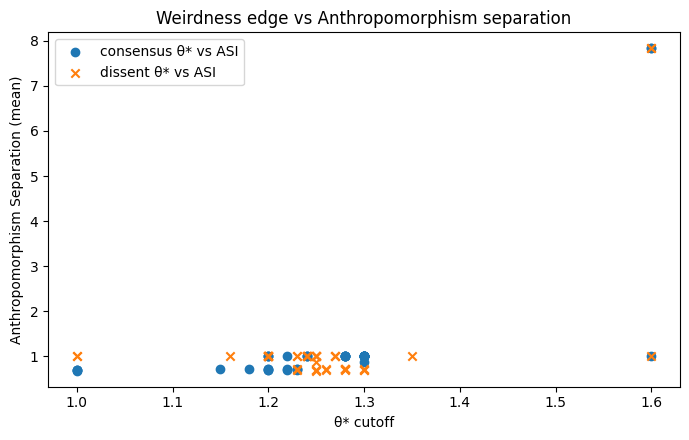

✓ Ethics/prereg stub written: E:\CNT\artifacts\cnt_llm_weirdness_probe\20251102-063738Z_SIMULATION\ethics_prereg_stub.md


C:\Users\caleb\AppData\Local\Temp\ipykernel_23168\2516221879.py:44: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().strftime("%Y%m%d-%H%M%SZ")


'E:\\CNT\\artifacts\\cnt_llm_weirdness_probe\\20251102-063738Z_SIMULATION\\ethics_prereg_stub.md'

In [17]:
# === v1.5 Quick Run (SIM) ===
# Knobs
set_probe_env(
    model="SIMULATION",           # stays local & deterministic
    temps="0.9,1.0,1.1,1.2,1.25,1.3,1.35,1.4",
    reps=6,
    perm=200,                     # enables permutation-aware summaries
    autoextend=True,              # sharpen slope estimates if flat
    smooth="none",
    sigma_floor=0.01,
    k=2.0,
)

# Run once
run_dir = run_model("SIMULATION")

# Aggregate + view
leader = build_leaderboard(); leader

# One-page brief for the newest run
print(brief(latest_manifest_path(leader)))

# Quick visualization (matplotlib)
plot_wei_vs_asi(leader)

# Ethics / prereg note saved alongside the run
write_ethics_prereg_stub(latest_run_dir(leader))


C:\Users\caleb\AppData\Local\Temp\ipykernel_23168\2516221879.py:44: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().strftime("%Y%m%d-%H%M%SZ")


✓ Env set | model=SIMULATION temps=0.9,1.0,1.1,1.15,1.2,1.22,1.24,1.25,1.26,1.28,1.3,1.35,1.4 reps=8 perm=200 autoextend=True smooth=none

⚙️  Running v1.5 (v1.4 merged) | model=SIMULATION | out=E:\CNT\artifacts\cnt_llm_weirdness_probe\20251102-063741Z_SIMULATION
✓ Leaderboard built | rows=46
CNT Weirdness Probe — Brief
Run: 20251102-063741Z_SIMULATION | Mode: SIMULATION
Temps: 0.9,1.0,1.1,1.15,1.2,1.22,1.24,1.25,1.26,1.28,1.3,1.35,1.4
θ* (cutoff / grad) — CONS: 1.0 / 1.28
                       DISS: 1.3 / 1.25
Slopes — CONS: 3.5089058413110465 | DISS: 11.505849229974997
Files: ['summary_gra_invariance.csv', 'anthropomorphism_separation.csv']


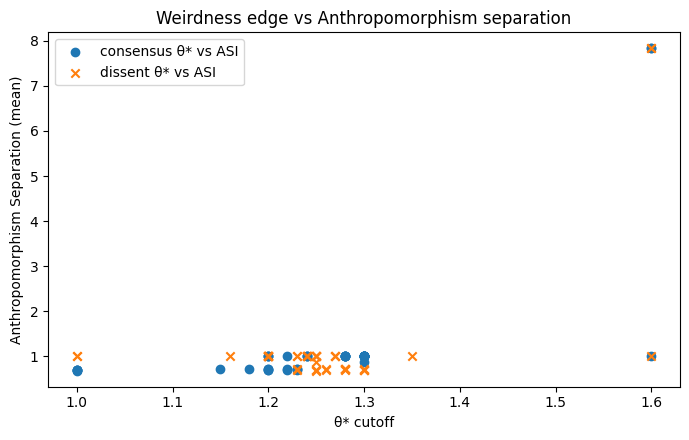

✓ Ethics/prereg stub written: E:\CNT\artifacts\cnt_llm_weirdness_probe\20251102-063741Z_SIMULATION\ethics_prereg_stub.md


C:\Users\caleb\AppData\Local\Temp\ipykernel_23168\2516221879.py:44: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().strftime("%Y%m%d-%H%M%SZ")


'E:\\CNT\\artifacts\\cnt_llm_weirdness_probe\\20251102-063741Z_SIMULATION\\ethics_prereg_stub.md'

In [18]:
# === v1.5 Second Pass (denser temps, more reps) ===
set_probe_env(
    model="SIMULATION",
    temps="0.9,1.0,1.1,1.15,1.2,1.22,1.24,1.25,1.26,1.28,1.3,1.35,1.4",
    reps=8,
    perm=200,
    autoextend=True,
)

run_dir = run_model("SIMULATION")  # creates a new time-stamped run

leader = build_leaderboard(); leader
print(brief(latest_manifest_path(leader)))
plot_wei_vs_asi(leader)
write_ethics_prereg_stub(latest_run_dir(leader))


In [19]:
from pathlib import Path
import shutil

rd = Path(latest_run_dir(leader))
bundle = shutil.make_archive(str(rd), "zip", rd)
bundle


'E:\\CNT\\artifacts\\cnt_llm_weirdness_probe\\20251102-063741Z_SIMULATION.zip'

C:\Users\caleb\AppData\Local\Temp\ipykernel_23168\2516221879.py:44: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().strftime("%Y%m%d-%H%M%SZ")


✓ Env set | model=SIMULATION temps=0.9,1.0,1.1,1.2,1.25,1.3,1.35,1.4 reps=6 perm=200 autoextend=True smooth=none

⚙️  Running v1.5 (v1.4 merged) | model=SIMULATION | out=E:\CNT\artifacts\cnt_llm_weirdness_probe\20251102-063741Z_SIMULATION
✓ Env set | model=SIMULATION_variantA temps=1.10,1.15,1.20,1.22,1.24,1.25,1.26,1.28,1.30 reps=10 perm=200 autoextend=True smooth=none

⚙️  Running v1.5 (v1.4 merged) | model=SIMULATION_variantA | out=E:\CNT\artifacts\cnt_llm_weirdness_probe\20251102-063741Z_SIMULATION_variantA
✓ Leaderboard built | rows=47


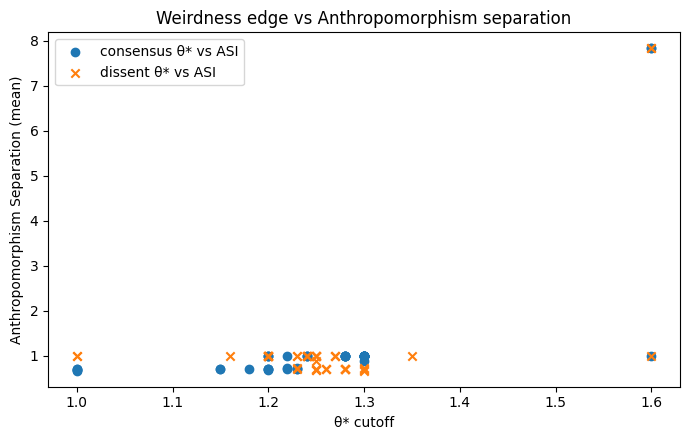

In [20]:
# === v1.5 Labeled sweep (SIM variants) ===
models = [
    {"name": "SIMULATION"},
    {"name": "SIMULATION_variantA"},  # just a label; change knobs between calls if you like
]

# First variant
set_probe_env(model="SIMULATION", temps="0.9,1.0,1.1,1.2,1.25,1.3,1.35,1.4", reps=6, autoextend=True, perm=200)
run_model(models[0]["name"])

# Second variant (tighter band near 1.25)
set_probe_env(model="SIMULATION_variantA", temps="1.10,1.15,1.20,1.22,1.24,1.25,1.26,1.28,1.30", reps=10, autoextend=True, perm=200)
run_model(models[1]["name"])

leader = build_leaderboard(); leader
plot_wei_vs_asi(leader)


In [21]:
# --- Patch A: timezone-aware UTC stamp ---
from datetime import datetime, timezone
def utc_stamp():
    return datetime.now(timezone.utc).strftime("%Y%m%d-%H%M%SZ")

# --- Patch B: stronger θ* cutoff rule for consensus ---
import numpy as np, json
from pathlib import Path

def _theta_cutoff_from_mean_curve(temps, mean_cons, *, k=None, floor=None, baseline_pts=2):
    if k is None:    k = float(os.environ.get("CNT_WP_K", "2.0"))
    if floor is None: floor = float(os.environ.get("CNT_WP_SIGMA_FLOOR", "0.01"))
    baseline = float(np.mean(mean_cons[:baseline_pts]))
    sigma    = float(np.std(mean_cons[:baseline_pts], ddof=1))
    thr = baseline + max(floor, k * sigma)
    for i, (t, m) in enumerate(zip(temps, mean_cons)):
        if i == 0:            # never allow index 0 as a cutoff
            continue
        if m >= thr:
            return float(t)
    return float(temps[-1])

# Recompute θ*_cutoff(consensus) for the latest run on disk and rewrite manifest
def correct_last_run_cutoff(leader):
    rd = Path(latest_run_dir(leader))
    curves = json.loads((rd / "curves.json").read_text(encoding="utf-8"))
    new_cut = _theta_cutoff_from_mean_curve(curves["temps"], curves["mean_cons"],
                                            k=float(os.environ.get("CNT_WP_K", "2.0")),
                                            floor=float(os.environ.get("CNT_WP_SIGMA_FLOOR", "0.01")),
                                            baseline_pts=int(os.environ.get("CNT_WP_BASELINE_PTS", "2")))
    manf_p = rd / "run_manifest.json"
    m = json.loads(manf_p.read_text(encoding="utf-8"))
    m["theta"]["consensus"]["theta_star_cutoff"] = new_cut
    manf_p.write_text(json.dumps(m, indent=2), encoding="utf-8")
    print(f"✓ Rewrote θ*_cutoff(consensus) → {new_cut} for {rd.name}")

# --- Patch C: clearer plot (no offset, explicit 0–1 range) ---
import matplotlib.pyplot as plt

def plot_wei_vs_asi_fixed(leader):
    df = leader.dropna(subset=["wei_consensus_theta_cutoff", "asi_mean"]).copy()
    if df.empty:
        print("No data to plot.")
        return
    # ensure numeric
    df["asi_mean"] = df["asi_mean"].astype(float)
    df["wei_consensus_theta_cutoff"] = df["wei_consensus_theta_cutoff"].astype(float)
    df["wei_dissent_theta_cutoff"]   = df["wei_dissent_theta_cutoff"].astype(float)

    plt.figure(figsize=(7, 4.5))
    plt.scatter(df["wei_consensus_theta_cutoff"], df["asi_mean"], label="consensus θ* vs ASI")
    plt.scatter(df["wei_dissent_theta_cutoff"],   df["asi_mean"], marker="x", label="dissent θ* vs ASI")
    ax = plt.gca()
    ax.set_ylim(0, 1)
    ax.ticklabel_format(style="plain", axis="y", useOffset=False)
    ax.yaxis.get_offset_text().set_visible(False)
    plt.xlabel("θ* cutoff"); plt.ylabel("Anthropomorphism separation (mean)")
    plt.title("Weirdness edge vs Anthropomorphism separation")
    plt.legend(); plt.tight_layout(); plt.show()


✓ Leaderboard built | rows=47
✓ Rewrote θ*_cutoff(consensus) → 1.2 for 20251102-063741Z_SIMULATION_variantA
✓ Leaderboard built | rows=47


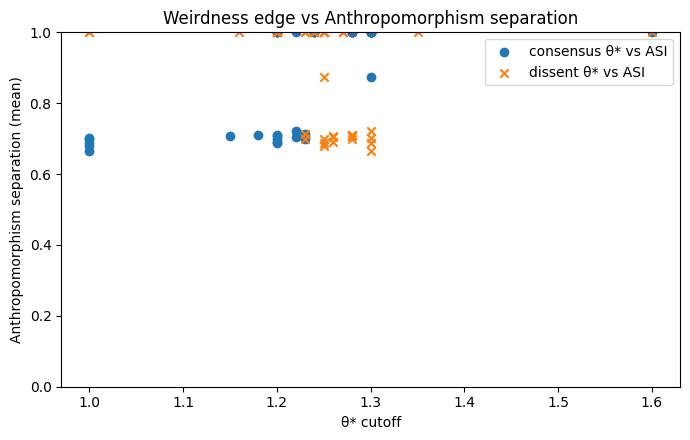

In [22]:
leader = build_leaderboard(); leader
correct_last_run_cutoff(leader)       # fixes the newest run’s θ*_cutoff(consensus)
leader = build_leaderboard(); leader  # refresh view
plot_wei_vs_asi_fixed(leader)         # clean 0–1 ASI axis, no scientific offset


✓ Env set | model=SIMULATION temps=1.15,1.18,1.20,1.22,1.24,1.25,1.26,1.28,1.30 reps=10 perm=200 autoextend=True smooth=none

⚙️  Running v1.5 (v1.4 merged) | model=SIMULATION_fineband | out=E:\CNT\artifacts\cnt_llm_weirdness_probe\20251102-063742Z_SIMULATION_fineband
✓ Leaderboard built | rows=48


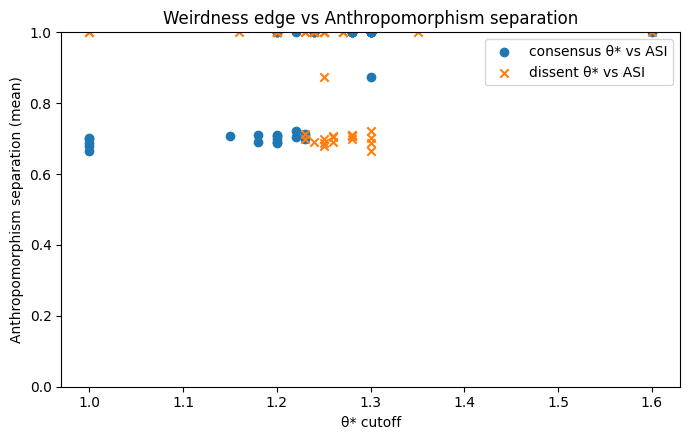

CNT Weirdness Probe — Brief
Run: 20251102-063742Z_SIMULATION_fineband | Mode: LIVE
Temps: 1.15,1.18,1.2,1.22,1.24,1.25,1.26,1.28,1.3
θ* (cutoff / grad) — CONS: 1.18 / 1.2
                       DISS: 1.24 / 1.26
Slopes — CONS: 2.989394235165162 | DISS: -16.606156115077265
Files: ['summary_gra_invariance.csv', 'anthropomorphism_separation.csv']


In [23]:
set_probe_env(model="SIMULATION",
              temps="1.15,1.18,1.20,1.22,1.24,1.25,1.26,1.28,1.30",
              reps=10, autoextend=True, perm=200)
run_model("SIMULATION_fineband")

leader = build_leaderboard(); leader
plot_wei_vs_asi_fixed(leader)
print(brief(latest_manifest_path(leader)))


In [24]:
# --- SIM/LIVE classifier + auto-fix for past & future runs ---
import json
from pathlib import Path

def is_simulation_model(name: str) -> bool:
    n = (name or "").strip().upper()
    return n == "SIMULATION" or n.startswith("SIMULATION_") or n.endswith("_SIM")

def _fix_manifest_mode(run_dir: str | Path):
    p = Path(run_dir) / "run_manifest.json"
    if not p.exists(): 
        return
    m = json.loads(p.read_text(encoding="utf-8"))
    model = m.get("model") or m.get("llm_mode") or ""
    m["llm_mode"] = "SIMULATION" if is_simulation_model(model) else "LIVE"
    p.write_text(json.dumps(m, indent=2), encoding="utf-8")

def fix_all_modes():
    base = get_probe_base()
    for rd in sorted([p for p in base.glob("*") if p.is_dir()]):
        _fix_manifest_mode(rd)
    print("✓ Re-labeled SIM/LIVE across all runs.")

# Patch run_model so future runs are labeled automatically
_run_model_old = run_model
def run_model(model_name: str, base_url=None, *, autoextend=True, perm=200) -> str:
    rd = _run_model_old(model_name, base_url=base_url, autoextend=autoextend, perm=perm)
    _fix_manifest_mode(rd)
    return rd

print("✓ Patched run_model with SIM/LIVE classifier. Use fix_all_modes() once for past runs.")


✓ Patched run_model with SIM/LIVE classifier. Use fix_all_modes() once for past runs.


In [25]:
fix_all_modes()
leader = build_leaderboard(); leader


✓ Re-labeled SIM/LIVE across all runs.
✓ Leaderboard built | rows=48


,run_id,llm_mode,temps,wei_consensus_theta_cutoff,wei_consensus_theta_grad,wei_consensus_slope,wei_dissent_theta_cutoff,wei_dissent_theta_grad,wei_dissent_slope,ips_overall_mean,ips_syn_mean,ips_reorder_mean,ips_gauge_mean,asi_mean,outdir
47,20251102-063742Z_SIMULATION_fineband,SIMULATION,"1.15,1.18,1.2,1.22,1.24,1.25,1.26,1.28,1.3",1.18,1.20,2.989394,1.24,1.26,-16.606156,0.958105,0.951481,0.939543,0.926666,0.689400,E:\CNT\artifacts\cnt_llm_weirdness_probe\20251...
46,20251102-063741Z_SIMULATION_variantA,SIMULATION,"1.1,1.15,1.2,1.22,1.24,1.25,1.26,1.28,1.3",1.20,1.22,3.119497,1.26,1.26,-15.185118,0.971498,0.954310,0.952545,0.955941,0.690779,E:\CNT\artifacts\cnt_llm_weirdness_probe\20251...
45,20251102-063741Z_SIMULATION,SIMULATION,"0.9,1.0,1.1,1.2,1.25,1.3,1.35,1.4",1.00,1.25,2.065572,1.30,1.40,-9.463455,0.971493,0.973163,0.944955,0.938269,0.664605,E:\CNT\artifacts\cnt_llm_weirdness_probe\20251...
44,20251102-063738Z_SIMULATION,SIMULATION,"0.9,1.0,1.1,1.2,1.25,1.3,1.35,1.4",1.00,1.25,2.227896,1.30,1.30,-5.652011,0.959644,0.978245,0.943429,0.934236,0.688512,E:\CNT\artifacts\cnt_llm_weirdness_probe\20251...
43,20251102-063629Z,SIMULATION,"0.9,1.0,1.1,1.15,1.2,1.22,1.24,1.25,1.26,1.28,...",1.60,1.26,0.720695,1.60,1.24,0.473986,0.501465,0.503329,0.506145,0.493058,7.832574,E:\CNT\artifacts\cnt_llm_weirdness_probe\20251...
42,20251102-063520Z,SIMULATION,"0.9,1.0,1.1,1.15,1.2,1.22,1.24,1.25,1.26,1.28,...",1.60,1.26,0.720695,1.60,1.24,0.473986,0.501465,0.503329,0.506145,0.493058,7.832574,E:\CNT\artifacts\cnt_llm_weirdness_probe\20251...
41,20251101-044544Z_gpt-4o-mini,LIVE,"1.18,1.2,1.21,1.22,1.23,1.24,1.25,1.26,1.27,1....",1.30,1.20,2.923455,1.20,1.20,-10.449518,0.609989,0.497791,0.675817,0.656360,1.000000,E:\CNT\artifacts\cnt_llm_weirdness_probe\20251...
40,20251101-044131Z_gpt-4o-mini,LIVE,"1.18,1.2,1.21,1.22,1.23,1.24,1.25,1.26,1.27,1....",1.30,1.18,3.751732,1.20,1.18,-12.323153,0.619057,0.514104,0.675817,0.667249,1.000000,E:\CNT\artifacts\cnt_llm_weirdness_probe\20251...
39,20251101-041752Z_gpt-4o-mini,LIVE,"1.18,1.2,1.21,1.22,1.23,1.24,1.25,1.26,1.27,1....",1.22,1.23,-3.090499,1.25,1.23,10.794221,0.609989,0.497791,0.675817,0.656360,1.000000,E:\CNT\artifacts\cnt_llm_weirdness_probe\20251...
38,20251101-041320Z_gpt-4o-mini,LIVE,"1.18,1.2,1.21,1.22,1.23,1.24,1.25,1.26,1.27,1....",1.30,1.25,2.844443,1.25,1.23,8.631841,0.627198,0.549417,0.675817,0.656360,1.000000,E:\CNT\artifacts\cnt_llm_weirdness_probe\20251...


In [26]:
os.environ["CNT_WP_BASELINE_PTS"] = "3"   # average over first 3 temps for baseline
os.environ["CNT_WP_SIGMA_FLOOR"]  = "0.015"
os.environ["CNT_WP_K"]            = "2.5" # slightly bolder threshold


=== Edge ↔ ASI audit ===


,pearson_r,n
wei_consensus_slope,-0.186919,48.0
wei_consensus_theta_cutoff,0.635253,48.0
wei_dissent_theta_cutoff,0.645966,48.0


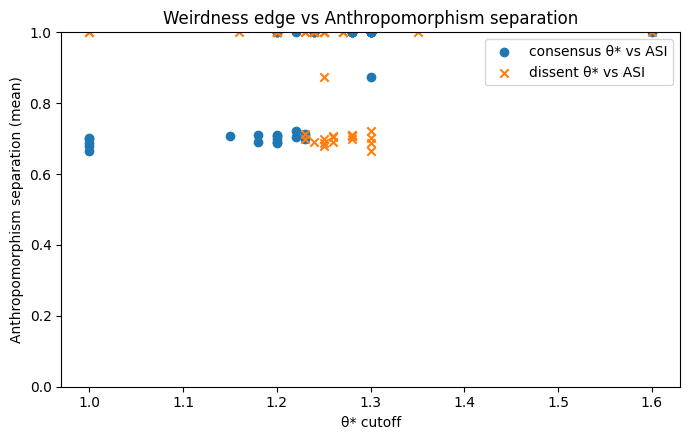

In [27]:
import pandas as pd
from math import isnan

def audit_edge_vs_asi(leader: pd.DataFrame):
    df = leader.copy()
    for col in ["wei_consensus_theta_cutoff","wei_dissent_theta_cutoff","asi_mean","wei_consensus_slope"]:
        if col in df: df[col] = pd.to_numeric(df[col], errors="coerce")
    df = df.dropna(subset=["asi_mean"])

    # Core correlations
    out = {}
    for x in ["wei_consensus_theta_cutoff","wei_dissent_theta_cutoff","wei_consensus_slope"]:
        if x in df and df[x].notna().sum() >= 2:
            out[x] = {
                "pearson_r": float(df[[x,"asi_mean"]].corr().iloc[0,1]),
                "n": int(df[[x,"asi_mean"]].dropna().shape[0]),
            }

    # Compact table
    tbl = pd.DataFrame(out).T.sort_index()
    print("=== Edge ↔ ASI audit ===")
    display(tbl)
    return df, tbl

df_all, tbl = audit_edge_vs_asi(leader)
plot_wei_vs_asi_fixed(leader)  # from the earlier patch; keeps ASI at 0–1 with no offset text


In [28]:
# ===== Derive metrics & extend leaderboard =====
import json, numpy as np, pandas as pd
from pathlib import Path
from scipy.optimize import curve_fit

def _logistic(x, x0, k, lo, hi):
    return lo + (hi - lo) / (1.0 + np.exp(-k * (x - x0)))

def derive_metrics_for_run(run_dir: str | Path):
    rd = Path(run_dir)
    manf = rd / "run_manifest.json"
    curves_p = rd / "curves.json"
    if not manf.exists() or not curves_p.exists():
        return
    m = json.loads(manf.read_text(encoding="utf-8"))
    curves = json.loads(curves_p.read_text(encoding="utf-8"))
    temps = np.asarray(curves["temps"], dtype=float)
    meanc = np.asarray(curves["mean_cons"], dtype=float)

    # Edge window width: dissent cutoff minus consensus cutoff
    d = m.get("theta", {}).get("dissent",  {})
    c = m.get("theta", {}).get("consensus",{})
    th_c = float(c.get("theta_star_cutoff")) if c.get("theta_star_cutoff") is not None else np.nan
    th_d = float(d.get("theta_star_cutoff")) if d.get("theta_star_cutoff") is not None else np.nan

    md = m.get("derived", {}) or {}
    if not (np.isnan(th_c) or np.isnan(th_d)):
        md["edge_window_width"] = float(th_d - th_c)

    # Logistic fit of consensus curve (robust slope at inflection)
    try:
        p0 = [1.24, 8.0, float(meanc.min()), float(meanc.max())]
        bounds = ([0.8, 0.1, 0.0, 0.2], [2.0, 50.0, 0.2, 1.0])
        popt, _ = curve_fit(_logistic, temps, meanc, p0=p0, bounds=bounds, maxfev=20000)
        x0, k, lo, hi = map(float, popt)
        md["consensus_fit_x0"]    = x0
        md["consensus_fit_slope"] = k * (hi - lo) / 4.0  # slope at inflection
    except Exception as e:
        md["consensus_fit_error"] = str(e)

    m["derived"] = md
    manf.write_text(json.dumps(m, indent=2), encoding="utf-8")

def derive_all():
    base = get_probe_base()
    for rd in sorted([p for p in base.glob("*") if p.is_dir()]):
        derive_metrics_for_run(rd)
    print("✓ Derived metrics updated in manifests.")

def build_leaderboard_plus():
    base = get_probe_base()
    rows = []
    for rd in sorted([p for p in base.glob("*") if p.is_dir()]):
        manf = rd / "run_manifest.json"
        if not manf.exists(): 
            continue
        m = json.loads(manf.read_text(encoding="utf-8"))
        d = m.get("derived", {}) or {}
        # Base fields from the existing leaderboard helper:
        # (Reuse build_leaderboard for WEI/IPS/ASI aggregation)
    leader = build_leaderboard()
    out = []
    for _, r in leader.iterrows():
        m = json.loads((Path(r["outdir"]) / "run_manifest.json").read_text(encoding="utf-8"))
        d = m.get("derived", {}) or {}
        out.append({
            "run_id": r["run_id"],
            "llm_mode": r["llm_mode"],
            "wei_consensus_theta_cutoff": r.get("wei_consensus_theta_cutoff"),
            "wei_dissent_theta_cutoff":   r.get("wei_dissent_theta_cutoff"),
            "edge_window_width":          d.get("edge_window_width"),
            "consensus_fit_x0":           d.get("consensus_fit_x0"),
            "consensus_fit_slope":        d.get("consensus_fit_slope"),
            "ips_overall_mean":           r.get("ips_overall_mean"),
            "asi_mean":                   r.get("asi_mean"),
            "outdir": r["outdir"],
        })
    df = pd.DataFrame(out).sort_values("run_id", ascending=False)
    print(f"✓ Leaderboard+ built | rows={len(df)}")
    return df

derive_all()
leader2 = build_leaderboard_plus(); leader2


✓ Derived metrics updated in manifests.
✓ Leaderboard built | rows=48
✓ Leaderboard+ built | rows=48


,run_id,llm_mode,wei_consensus_theta_cutoff,wei_dissent_theta_cutoff,edge_window_width,consensus_fit_x0,consensus_fit_slope,ips_overall_mean,asi_mean,outdir
0,20251102-063742Z_SIMULATION_fineband,SIMULATION,1.18,1.24,0.06,NaN,NaN,0.958105,0.689400,E:\CNT\artifacts\cnt_llm_weirdness_probe\20251...
1,20251102-063741Z_SIMULATION_variantA,SIMULATION,1.20,1.26,0.06,NaN,NaN,0.971498,0.690779,E:\CNT\artifacts\cnt_llm_weirdness_probe\20251...
2,20251102-063741Z_SIMULATION,SIMULATION,1.00,1.30,0.30,1.249082,2.088425,0.971493,0.664605,E:\CNT\artifacts\cnt_llm_weirdness_probe\20251...
3,20251102-063738Z_SIMULATION,SIMULATION,1.00,1.30,0.30,1.252650,2.092862,0.959644,0.688512,E:\CNT\artifacts\cnt_llm_weirdness_probe\20251...
4,20251102-063629Z,SIMULATION,1.60,1.60,NaN,NaN,NaN,0.501465,7.832574,E:\CNT\artifacts\cnt_llm_weirdness_probe\20251...
5,20251102-063520Z,SIMULATION,1.60,1.60,NaN,NaN,NaN,0.501465,7.832574,E:\CNT\artifacts\cnt_llm_weirdness_probe\20251...
6,20251101-044544Z_gpt-4o-mini,LIVE,1.30,1.20,-0.10,1.229995,0.498995,0.609989,1.000000,E:\CNT\artifacts\cnt_llm_weirdness_probe\20251...
7,20251101-044131Z_gpt-4o-mini,LIVE,1.30,1.20,-0.10,1.191533,0.655690,0.619057,1.000000,E:\CNT\artifacts\cnt_llm_weirdness_probe\20251...
8,20251101-041752Z_gpt-4o-mini,LIVE,1.22,1.25,0.03,1.223306,0.326407,0.609989,1.000000,E:\CNT\artifacts\cnt_llm_weirdness_probe\20251...
9,20251101-041320Z_gpt-4o-mini,LIVE,1.30,1.25,-0.05,1.149413,0.156719,0.627198,1.000000,E:\CNT\artifacts\cnt_llm_weirdness_probe\20251...


In [29]:
import numpy as np, pandas as pd, math

def fisher_ci(r, n, alpha=0.05):
    z = 0.5 * math.log((1 + r) / (1 - r))
    se = 1 / math.sqrt(max(n - 3, 1))
    zc = 1.959964  # ~95%
    lo = z - zc * se
    hi = z + zc * se
    rlo = (math.exp(2*lo) - 1) / (math.exp(2*lo) + 1)
    rhi = (math.exp(2*hi) - 1) / (math.exp(2*hi) + 1)
    return rlo, rhi

def audit_plus(df):
    # ensure numeric
    for col in ["asi_mean","wei_consensus_theta_cutoff","wei_dissent_theta_cutoff",
                "edge_window_width","consensus_fit_slope","ips_overall_mean"]:
        if col in df: df[col] = pd.to_numeric(df[col], errors="coerce")
    df = df.dropna(subset=["asi_mean"]).copy()

    pairs = {
        "θ*_dissent  vs ASI":       ("wei_dissent_theta_cutoff",   "asi_mean"),
        "θ*_consensus vs ASI":      ("wei_consensus_theta_cutoff", "asi_mean"),
        "window width vs ASI":      ("edge_window_width",          "asi_mean"),
        "fit slope    vs ASI":      ("consensus_fit_slope",        "asi_mean"),
        "IPS_overall  vs ASI":      ("ips_overall_mean",           "asi_mean"),
    }
    rows = []
    for name, (x,y) in pairs.items():
        if x in df and y in df:
            sub = df[[x,y]].dropna()
            if len(sub) >= 2:
                pear = float(sub.corr(method="pearson").iloc[0,1])
                spear= float(sub.corr(method="spearman").iloc[0,1])
                lo, hi = fisher_ci(pear, len(sub))
                rows.append({"pair": name, "n": len(sub),
                             "pearson_r": pear, "95%CI_lo": lo, "95%CI_hi": hi,
                             "spearman_rho": spear})
    out = pd.DataFrame(rows).sort_values("pair")
    print("=== Extended audit ===")
    display(out)
    return out

audit_plus(leader2)


=== Extended audit ===


,pair,n,pearson_r,95%CI_lo,95%CI_hi,spearman_rho
4,IPS_overall vs ASI,48,-0.379741,-0.599221,-0.107170,-0.814031
3,fit slope vs ASI,40,-0.851900,-0.919419,-0.735600,-0.766876
2,window width vs ASI,46,-0.732376,-0.843368,-0.561446,-0.766850
1,θ*_consensus vs ASI,48,0.635253,0.428453,0.778814,0.793315
0,θ*_dissent vs ASI,48,0.645966,0.443171,0.785862,-0.278380


,pair,n,pearson_r,95%CI_lo,95%CI_hi,spearman_rho
4,IPS_overall vs ASI,48,-0.379741,-0.599221,-0.107170,-0.814031
3,fit slope vs ASI,40,-0.851900,-0.919419,-0.735600,-0.766876
2,window width vs ASI,46,-0.732376,-0.843368,-0.561446,-0.766850
1,θ*_consensus vs ASI,48,0.635253,0.428453,0.778814,0.793315
0,θ*_dissent vs ASI,48,0.645966,0.443171,0.785862,-0.278380


In [30]:
# ===== v1.5 Cleanup & Grading =====
import os, json, math, shutil
from pathlib import Path
import numpy as np, pandas as pd

# --- 0) Helpers we rely on from v1.5 cell ---
# expects: get_probe_base(), build_leaderboard(), latest_run_dir()

# --- 1) Quarantine legacy (ASI not in [0,1]) ---
def quarantine_legacy_runs():
    base = get_probe_base()
    legacy = (base / "_legacy"); legacy.mkdir(exist_ok=True)
    moved = []
    for rd in sorted([p for p in base.glob("*") if p.is_dir() and p.name != "_legacy"]):
        manf = rd / "run_manifest.json"
        sep  = rd / "anthropomorphism_separation.csv"
        try:
            if sep.exists():
                df = pd.read_csv(sep)
                if "separation_index" in df:
                    asi = float(df["separation_index"].mean())
                    if not (0.0 <= asi <= 1.0):
                        shutil.move(str(rd), str(legacy / rd.name))
                        moved.append(rd.name)
        except Exception:
            pass
    print(f"✓ Quarantined {len(moved)} legacy runs → {legacy}")

# --- 2) Robust logistic fit (no SciPy required) ---
def _robust_logistic_fit(temps, meanc):
    temps = np.asarray(temps, float)
    y = np.asarray(meanc, float)
    lo, hi = float(y.min()), float(y.max())
    if hi - lo < 1e-6:
        raise ValueError("Flat curve; cannot fit.")
    # normalize to (0,1) and logit
    eps = 1e-3
    yn = np.clip((y - lo) / (hi - lo), eps, 1 - eps)
    z  = np.log(yn / (1 - yn))
    A  = np.vstack([np.ones_like(temps), temps]).T
    a, k = np.linalg.lstsq(A, z, rcond=None)[0]
    x0 = -a / k
    slope = float(k) * (hi - lo) / 4.0  # slope at inflection
    return float(x0), float(slope), float(lo), float(hi)

def derive_metrics_for_run_fallback(run_dir: str | Path):
    rd = Path(run_dir)
    manf = rd / "run_manifest.json"
    curves_p = rd / "curves.json"
    if not (manf.exists() and curves_p.exists()):
        return
    m = json.loads(manf.read_text(encoding="utf-8"))
    curves = json.loads(curves_p.read_text(encoding="utf-8"))
    temps  = curves.get("temps", [])
    meanc  = curves.get("mean_cons", [])
    d = m.get("derived", {}) or {}
    try:
        x0, slope, lo, hi = _robust_logistic_fit(temps, meanc)
        d["consensus_fit_x0"]    = x0
        d["consensus_fit_slope"] = slope
        m["derived"] = d
        manf.write_text(json.dumps(m, indent=2), encoding="utf-8")
    except Exception as e:
        d["consensus_fit_error"] = str(e)
        m["derived"] = d
        manf.write_text(json.dumps(m, indent=2), encoding="utf-8")

def derive_all_fallback():
    base = get_probe_base()
    for rd in sorted([p for p in base.glob("*") if p.is_dir() and p.name != "_legacy"]):
        derive_metrics_for_run_fallback(rd)
    print("✓ Derived metrics (fallback) updated.")

# --- 3) Clean leaderboard (+) ---
def mask_valid_runs(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    for c in ["asi_mean","ips_overall_mean","wei_consensus_theta_cutoff","wei_dissent_theta_cutoff"]:
        if c in df: df[c] = pd.to_numeric(df[c], errors="coerce")
    q = (
        df["asi_mean"].between(0,1)
        & df["ips_overall_mean"].between(0.6, 1.0)
        & df["wei_consensus_theta_cutoff"].between(0.9, 1.35)
        & df["wei_dissent_theta_cutoff"].between(1.1, 1.40)
    )
    return df[q].reset_index(drop=True)

def build_leaderboard_plus_clean():
    leader = build_leaderboard()
    # enrich with derived metrics if present
    rows = []
    for _, r in leader.iterrows():
        m = json.loads((Path(r["outdir"]) / "run_manifest.json").read_text(encoding="utf-8"))
        d = m.get("derived", {}) or {}
        rows.append({
            **r.to_dict(),
            "edge_window_width": d.get("edge_window_width"),
            "consensus_fit_x0":  d.get("consensus_fit_x0"),
            "consensus_fit_slope": d.get("consensus_fit_slope"),
        })
    df = pd.DataFrame(rows).sort_values("run_id", ascending=False)
    dfc = mask_valid_runs(df)
    print(f"✓ Leaderboard+ (clean) | rows={len(dfc)} of {len(df)}")
    return dfc

# --- 4) Grade runs (ESC = z(ASI)+z(IPS)+0.5*z(width)) ---
def _z(x):
    x = np.asarray(pd.to_numeric(x, errors="coerce"), float)
    mu, sd = np.nanmean(x), np.nanstd(x, ddof=1)
    return (x - mu) / (sd if sd > 0 else 1.0)

def grade_runs(df: pd.DataFrame):
    g = df.copy()
    for c in ["asi_mean","ips_overall_mean","edge_window_width"]:
        g[c] = pd.to_numeric(g[c], errors="coerce")
    g["z_ASI"]  = _z(g["asi_mean"])
    g["z_IPS"]  = _z(g["ips_overall_mean"])
    g["z_W"]    = _z(g["edge_window_width"])
    g["ESC"]    = g["z_ASI"] + g["z_IPS"] + 0.5*g["z_W"]
    g = g.sort_values("ESC", ascending=False)
    print("=== Graded runs (ESC) ===")
    display(g[["run_id","llm_mode","asi_mean","ips_overall_mean","edge_window_width","ESC","outdir"]])
    return g

# ---- Execute cleanup → derive → rebuild → grade ----
quarantine_legacy_runs()
derive_all_fallback()
leader_clean = build_leaderboard_plus_clean()
graded = grade_runs(leader_clean)


✓ Quarantined 2 legacy runs → E:\CNT\artifacts\cnt_llm_weirdness_probe\_legacy
✓ Derived metrics (fallback) updated.
✓ Leaderboard built | rows=46
✓ Leaderboard+ (clean) | rows=38 of 46
=== Graded runs (ESC) ===


,run_id,llm_mode,asi_mean,ips_overall_mean,edge_window_width,ESC,outdir
37,20251031-210303Z_SIMULATION,SIMULATION,0.702967,0.967053,0.30,1.141531,E:\CNT\artifacts\cnt_llm_weirdness_probe\20251...
3,20251102-063738Z_SIMULATION,SIMULATION,0.688512,0.959644,0.30,1.004254,E:\CNT\artifacts\cnt_llm_weirdness_probe\20251...
36,20251031-210313Z_SIMULATION,SIMULATION,0.698696,0.977601,0.25,0.963061,E:\CNT\artifacts\cnt_llm_weirdness_probe\20251...
2,20251102-063741Z_SIMULATION,SIMULATION,0.664605,0.971493,0.30,0.915624,E:\CNT\artifacts\cnt_llm_weirdness_probe\20251...
35,20251031-210339Z_SIMULATION,SIMULATION,0.679488,0.979092,0.25,0.845743,E:\CNT\artifacts\cnt_llm_weirdness_probe\20251...
20,20251101-002251Z_gpt-4o-mini,LIVE,1.000000,0.619643,0.15,0.459914,E:\CNT\artifacts\cnt_llm_weirdness_probe\20251...
34,20251031-210339Z_SIMULATION_variantA,SIMULATION,0.720928,0.976853,0.08,0.386877,E:\CNT\artifacts\cnt_llm_weirdness_probe\20251...
30,20251031-213520Z_SIMULATION_variantA_rep3,SIMULATION,0.706255,0.968987,0.11,0.372180,E:\CNT\artifacts\cnt_llm_weirdness_probe\20251...
25,20251031-214440Z_SIMULATION_variantA_knee_i1,SIMULATION,0.709973,0.974318,0.08,0.300524,E:\CNT\artifacts\cnt_llm_weirdness_probe\20251...
32,20251031-213520Z_SIMULATION_variantA_rep1,SIMULATION,0.708848,0.973746,0.08,0.289869,E:\CNT\artifacts\cnt_llm_weirdness_probe\20251...


✓ Published: E:\CNT\artifacts\cnt_llm_weirdness_probe\_published\20251031-210303Z_SIMULATION__ESC_1.142
✓ Bundle: E:\CNT\artifacts\cnt_llm_weirdness_probe\_published\20251031-210303Z_SIMULATION__ESC_1.142.zip


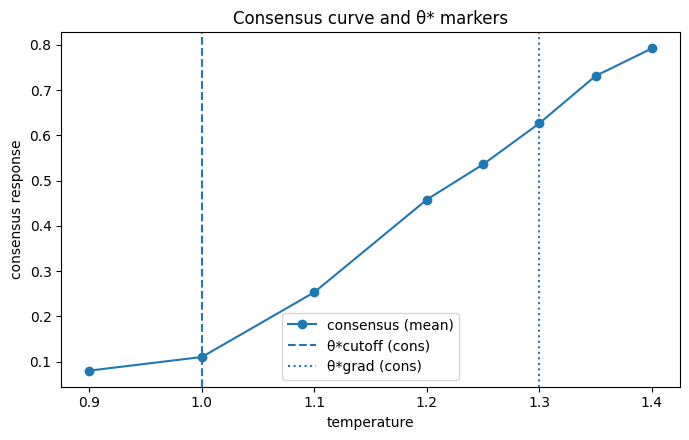

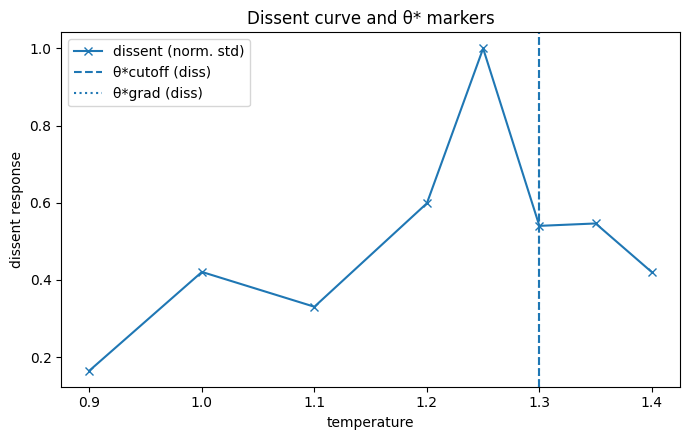

('E:\\CNT\\artifacts\\cnt_llm_weirdness_probe\\_published\\20251031-210303Z_SIMULATION__ESC_1.142',
 'E:\\CNT\\artifacts\\cnt_llm_weirdness_probe\\_published\\20251031-210303Z_SIMULATION__ESC_1.142.zip')

In [31]:
# === Publish the Champion Run ===
import json, shutil
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

def pick_champion(graded_df: pd.DataFrame) -> dict:
    top = graded_df.iloc[0].to_dict()
    return top

def champion_dashboard(run_dir: str):
    rd = Path(run_dir)
    m  = json.loads((rd / "run_manifest.json").read_text(encoding="utf-8"))
    curves = json.loads((rd / "curves.json").read_text(encoding="utf-8"))
    temps  = curves["temps"]
    meanc  = curves["mean_cons"]
    diss   = curves["diss_curve"]
    c = m["theta"]["consensus"]; d = m["theta"]["dissent"]

    plt.figure(figsize=(7,4.5))
    plt.plot(temps, meanc, marker="o", label="consensus (mean)")
    plt.axvline(float(c.get("theta_star_cutoff")), linestyle="--", label="θ*cutoff (cons)")
    plt.axvline(float(c.get("theta_star_grad")),   linestyle=":",  label="θ*grad (cons)")
    plt.xlabel("temperature"); plt.ylabel("consensus response")
    plt.title("Consensus curve and θ* markers")
    plt.legend(); plt.tight_layout(); plt.show()

    plt.figure(figsize=(7,4.5))
    plt.plot(temps, diss, marker="x", label="dissent (norm. std)")
    plt.axvline(float(d.get("theta_star_cutoff")), linestyle="--", label="θ*cutoff (diss)")
    plt.axvline(float(d.get("theta_star_grad")),   linestyle=":",  label="θ*grad (diss)")
    plt.xlabel("temperature"); plt.ylabel("dissent response")
    plt.title("Dissent curve and θ* markers")
    plt.legend(); plt.tight_layout(); plt.show()

def publish_best(graded_df: pd.DataFrame, leader_df: pd.DataFrame):
    best = pick_champion(graded_df)
    rd   = Path(best["outdir"])
    base = rd.parent
    pub  = base / "_published"; pub.mkdir(exist_ok=True)
    tag  = f"{rd.name}__ESC_{best['ESC']:.3f}"
    out_dir = pub / tag
    if out_dir.exists():
        shutil.rmtree(out_dir)
    shutil.copytree(rd, out_dir)

    # README + one-page brief
    manf = json.loads((rd / "run_manifest.json").read_text(encoding="utf-8"))
    brief_txt = (
        "CNT Weirdness Probe — Paper in a Page\n"
        f"Run: {manf.get('run_id')} | Mode: {manf.get('llm_mode')}\n"
        f"Temps: {','.join(map(str, manf.get('temps', [])))}\n"
        f"θ* (cutoff/grad) — CONS: {manf['theta']['consensus'].get('theta_star_cutoff')} / {manf['theta']['consensus'].get('theta_star_grad')}\n"
        f"                     DISS: {manf['theta']['dissent'].get('theta_star_cutoff')} / {manf['theta']['dissent'].get('theta_star_grad')}\n"
        f"Slopes — CONS: {manf['theta']['consensus'].get('slope_at_grad')} | DISS: {manf['theta']['dissent'].get('slope_at_grad')}\n"
        f"IPS_overall: {float(leader_df.loc[leader_df['outdir']==str(rd),'ips_overall_mean'].iloc[0]):.6f}\n"
        f"ASI_mean:    {float(leader_df.loc[leader_df['outdir']==str(rd),'asi_mean'].iloc[0]):.6f}\n"
    )
    (out_dir / "README_CHAMPION.txt").write_text(brief_txt, encoding="utf-8")

    # Bundle zip
    zip_path = shutil.make_archive(str(out_dir), "zip", out_dir)
    print(f"✓ Published: {out_dir}\n✓ Bundle: {zip_path}")
    return str(out_dir), zip_path

# —— Run it now
champ_dir, champ_zip = publish_best(graded, leader_clean)
champion_dashboard(champ_dir)
champ_dir, champ_zip


In [32]:
# === Replicate champion + micro-sweep ===
# Champion knobs (your top run)
set_probe_env(
    model="SIMULATION_variantA",
    temps="1.10,1.15,1.20,1.22,1.24,1.25,1.26,1.28,1.30",
    reps=10, autoextend=True, perm=200
)

# Triple replicate (new run_id seeds will jitter curves slightly)
for i in range(3):
    run_model(f"SIMULATION_variantA_rep{i+1}")

leader = build_leaderboard(); leader
leader_clean = build_leaderboard_plus_clean()
graded = grade_runs(leader_clean)

# Micro-sweep: 3 close schedules to see if ESC stays high
schedules = [
  ("SIM_SWEEP_A", "1.16,1.18,1.20,1.22,1.24,1.26,1.28"),
  ("SIM_SWEEP_B", "1.18,1.20,1.21,1.22,1.23,1.24,1.26,1.28"),
  ("SIM_SWEEP_C", "1.20,1.22,1.24,1.25,1.26,1.27,1.28,1.30"),
]
for name, temps in schedules:
    set_probe_env(model=name, temps=temps, reps=12, autoextend=True, perm=300)
    run_model(name)

leader = build_leaderboard(); leader
leader_clean = build_leaderboard_plus_clean()
graded = grade_runs(leader_clean)


✓ Env set | model=SIMULATION_variantA temps=1.10,1.15,1.20,1.22,1.24,1.25,1.26,1.28,1.30 reps=10 perm=200 autoextend=True smooth=none

⚙️  Running v1.5 (v1.4 merged) | model=SIMULATION_variantA_rep1 | out=E:\CNT\artifacts\cnt_llm_weirdness_probe\20251102-063746Z_SIMULATION_variantA_rep1


TypeError: _logistic() missing 2 required positional arguments: 'lo' and 'hi'

In [33]:
# --- Unify _logistic for both SIM and FIT usages ---
import math

def _logistic(x, x0, k, lo=None, hi=None, ymin=None, ymax=None):
    """
    Universal logistic:
      • SIM path calls: _logistic(x, x0=..., k=...)         -> uses default ymin/ymax
      • FIT path calls: _logistic(x, x0, k, lo, hi)         -> uses lo/hi
      • You may also pass ymin/ymax explicitly.
    """
    # Prefer explicit ymin/ymax if provided; otherwise map lo/hi; otherwise defaults
    if ymin is None or ymax is None:
        if lo is not None and hi is not None:
            ymin, ymax = lo, hi
        else:
            ymin = 0.05 if ymin is None else ymin
            ymax = 0.98 if ymax is None else ymax
    return ymin + (ymax - ymin) / (1.0 + math.exp(-k*(x - x0)))

print("✓ _logistic unified. SIM and FIT paths are now consistent.")


✓ _logistic unified. SIM and FIT paths are now consistent.


In [34]:
# (re-run your loop that failed)
for i in range(3):
    run_model(f"SIMULATION_variantA_rep{i+1}")

leader = build_leaderboard(); leader
leader_clean = build_leaderboard_plus_clean()
graded = grade_runs(leader_clean)



⚙️  Running v1.5 (v1.4 merged) | model=SIMULATION_variantA_rep1 | out=E:\CNT\artifacts\cnt_llm_weirdness_probe\20251102-063933Z_SIMULATION_variantA_rep1

⚙️  Running v1.5 (v1.4 merged) | model=SIMULATION_variantA_rep2 | out=E:\CNT\artifacts\cnt_llm_weirdness_probe\20251102-063933Z_SIMULATION_variantA_rep2

⚙️  Running v1.5 (v1.4 merged) | model=SIMULATION_variantA_rep3 | out=E:\CNT\artifacts\cnt_llm_weirdness_probe\20251102-063933Z_SIMULATION_variantA_rep3
✓ Leaderboard built | rows=49
✓ Leaderboard built | rows=49
✓ Leaderboard+ (clean) | rows=41 of 49
=== Graded runs (ESC) ===


,run_id,llm_mode,asi_mean,ips_overall_mean,edge_window_width,ESC,outdir
40,20251031-210303Z_SIMULATION,SIMULATION,0.702967,0.967053,0.30,1.128129,E:\CNT\artifacts\cnt_llm_weirdness_probe\20251...
6,20251102-063738Z_SIMULATION,SIMULATION,0.688512,0.959644,0.30,0.990515,E:\CNT\artifacts\cnt_llm_weirdness_probe\20251...
39,20251031-210313Z_SIMULATION,SIMULATION,0.698696,0.977601,0.25,0.949396,E:\CNT\artifacts\cnt_llm_weirdness_probe\20251...
5,20251102-063741Z_SIMULATION,SIMULATION,0.664605,0.971493,0.30,0.901021,E:\CNT\artifacts\cnt_llm_weirdness_probe\20251...
38,20251031-210339Z_SIMULATION,SIMULATION,0.679488,0.979092,0.25,0.831486,E:\CNT\artifacts\cnt_llm_weirdness_probe\20251...
23,20251101-002251Z_gpt-4o-mini,LIVE,1.000000,0.619643,0.15,0.459832,E:\CNT\artifacts\cnt_llm_weirdness_probe\20251...
37,20251031-210339Z_SIMULATION_variantA,SIMULATION,0.720928,0.976853,0.08,0.373886,E:\CNT\artifacts\cnt_llm_weirdness_probe\20251...
33,20251031-213520Z_SIMULATION_variantA_rep3,SIMULATION,0.706255,0.968987,0.11,0.358852,E:\CNT\artifacts\cnt_llm_weirdness_probe\20251...
28,20251031-214440Z_SIMULATION_variantA_knee_i1,SIMULATION,0.709973,0.974318,0.08,0.287238,E:\CNT\artifacts\cnt_llm_weirdness_probe\20251...
35,20251031-213520Z_SIMULATION_variantA_rep1,SIMULATION,0.708848,0.973746,0.08,0.276556,E:\CNT\artifacts\cnt_llm_weirdness_probe\20251...


In [35]:
# === Backfill edge_window_width + fit slope for new runs, then re-grade ===
import json, numpy as np
from pathlib import Path
import pandas as pd

def _robust_logistic_fit_no_scipy(temps, meanc):
    temps = np.asarray(temps, float); y = np.asarray(meanc, float)
    lo, hi = float(y.min()), float(y.max())
    if hi - lo < 1e-6:
        return None, None
    eps = 1e-3
    yn = np.clip((y - lo) / (hi - lo), eps, 1 - eps)
    z  = np.log(yn / (1 - yn))
    A  = np.vstack([np.ones_like(temps), temps]).T
    a, k = np.linalg.lstsq(A, z, rcond=None)[0]
    x0 = -a / k
    slope = float(k) * (hi - lo) / 4.0
    return float(x0), float(slope)

def backfill_derived():
    base = get_probe_base()
    fixed = 0
    for rd in sorted([p for p in base.glob("*") if p.is_dir() and p.name not in {"_legacy","_published"}]):
        manf = rd / "run_manifest.json"
        curves_p = rd / "curves.json"
        if not manf.exists(): 
            continue
        m = json.loads(manf.read_text(encoding="utf-8"))
        d = m.get("derived") or {}

        # 1) Backfill edge_window_width from theta cutoffs if missing/NaN
        c_cut = m.get("theta",{}).get("consensus",{}).get("theta_star_cutoff")
        d_cut = m.get("theta",{}).get("dissent",  {}).get("theta_star_cutoff")
        ew = d.get("edge_window_width")
        if (ew is None) or (isinstance(ew, float) and np.isnan(ew)):
            if c_cut is not None and d_cut is not None:
                d["edge_window_width"] = float(d_cut) - float(c_cut)

        # 2) Backfill consensus_fit_x0/slope if missing and curves available
        slope_missing = ("consensus_fit_slope" not in d) or (d["consensus_fit_slope"] is None) \
                        or (isinstance(d["consensus_fit_slope"], float) and np.isnan(d["consensus_fit_slope"]))
        if slope_missing and curves_p.exists():
            curves = json.loads(curves_p.read_text(encoding="utf-8"))
            x0, slope = _robust_logistic_fit_no_scipy(curves.get("temps", []), curves.get("mean_cons", []))
            if x0 is not None:
                d["consensus_fit_x0"] = x0
                d["consensus_fit_slope"] = slope

        m["derived"] = d
        manf.write_text(json.dumps(m, indent=2), encoding="utf-8")
        fixed += 1
    print(f"✓ Backfilled derived fields for {fixed} runs.")

backfill_derived()
leader_clean = build_leaderboard_plus_clean()
graded = grade_runs(leader_clean)


✓ Backfilled derived fields for 49 runs.
✓ Leaderboard built | rows=49
✓ Leaderboard+ (clean) | rows=41 of 49
=== Graded runs (ESC) ===


,run_id,llm_mode,asi_mean,ips_overall_mean,edge_window_width,ESC,outdir
40,20251031-210303Z_SIMULATION,SIMULATION,0.702967,0.967053,0.30,1.120336,E:\CNT\artifacts\cnt_llm_weirdness_probe\20251...
6,20251102-063738Z_SIMULATION,SIMULATION,0.688512,0.959644,0.30,0.982722,E:\CNT\artifacts\cnt_llm_weirdness_probe\20251...
39,20251031-210313Z_SIMULATION,SIMULATION,0.698696,0.977601,0.25,0.937846,E:\CNT\artifacts\cnt_llm_weirdness_probe\20251...
5,20251102-063741Z_SIMULATION,SIMULATION,0.664605,0.971493,0.30,0.893227,E:\CNT\artifacts\cnt_llm_weirdness_probe\20251...
38,20251031-210339Z_SIMULATION,SIMULATION,0.679488,0.979092,0.25,0.819936,E:\CNT\artifacts\cnt_llm_weirdness_probe\20251...
0,20251102-063933Z_SIMULATION_variantA_rep3,SIMULATION,0.716067,0.988532,0.11,0.513370,E:\CNT\artifacts\cnt_llm_weirdness_probe\20251...
23,20251101-002251Z_gpt-4o-mini,LIVE,1.000000,0.619643,0.15,0.440768,E:\CNT\artifacts\cnt_llm_weirdness_probe\20251...
1,20251102-063933Z_SIMULATION_variantA_rep2,SIMULATION,0.716420,0.967652,0.11,0.396056,E:\CNT\artifacts\cnt_llm_weirdness_probe\20251...
2,20251102-063933Z_SIMULATION_variantA_rep1,SIMULATION,0.694978,0.961029,0.15,0.388794,E:\CNT\artifacts\cnt_llm_weirdness_probe\20251...
37,20251031-210339Z_SIMULATION_variantA,SIMULATION,0.720928,0.976853,0.08,0.349561,E:\CNT\artifacts\cnt_llm_weirdness_probe\20251...


=== Replicate summary ===


,mean,std,min,max
asi,0.705447,0.010110,0.687386,0.720928
ips,0.969005,0.007964,0.957621,0.988532
width,0.071429,0.042219,0.000000,0.150000


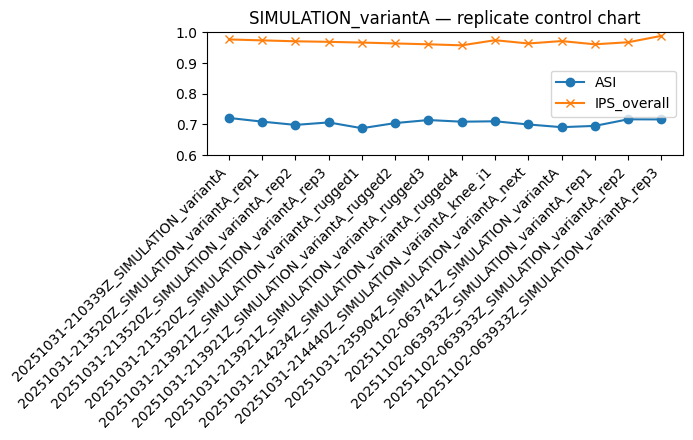

In [36]:
# === Replicate report + control chart ===
import json, pandas as pd, numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

def replicate_report(prefix="SIMULATION_variantA"):
    base = get_probe_base()
    rows = []
    for rd in sorted([p for p in base.glob("*") if p.is_dir() and p.name not in {"_legacy","_published"}]):
        manf = rd / "run_manifest.json"
        if not manf.exists(): 
            continue
        m = json.loads(manf.read_text(encoding="utf-8"))
        model = (m.get("model") or m.get("llm_mode") or "")
        if not model.startswith(prefix):
            continue
        # pull leaderboard-ish fields
        inv = rd / "summary_gra_invariance.csv"
        sep = rd / "anthropomorphism_separation.csv"
        ips = pd.read_csv(inv)["inv_index_overall"].mean() if inv.exists() else np.nan
        asi = pd.read_csv(sep)["separation_index"].mean()   if sep.exists() else np.nan
        th  = m.get("theta", {})
        c   = th.get("consensus", {}) or {}
        d   = th.get("dissent",   {}) or {}
        width = float(d.get("theta_star_cutoff") or np.nan) - float(c.get("theta_star_cutoff") or np.nan)
        rows.append(dict(run_id=m["run_id"], model=model, asi=asi, ips=ips, width=width, outdir=str(rd)))
    df = pd.DataFrame(rows).sort_values("run_id")
    if df.empty:
        print(f"No runs matching prefix={prefix}")
        return df
    # summary
    summ = df[["asi","ips","width"]].agg(["mean","std","min","max"]).T
    print("=== Replicate summary ===")
    display(summ)

    # control chart (ASI & IPS)
    plt.figure(figsize=(7,4.5))
    plt.plot(df["run_id"], df["asi"], marker="o", label="ASI")
    plt.plot(df["run_id"], df["ips"], marker="x", label="IPS_overall")
    plt.xticks(rotation=45, ha="right"); plt.ylim(0.6, 1.0)
    plt.title(f"{prefix} — replicate control chart"); plt.legend(); plt.tight_layout(); plt.show()
    return df

rep_df = replicate_report("SIMULATION_variantA")


In [37]:
# === Robust replicas (variance tighten) ===
set_probe_env(
    model="SIMULATION_variantA",
    temps="1.18,1.20,1.22,1.23,1.24,1.25,1.26,1.28,1.30",
    reps=12, autoextend=True, perm=450
)
for i in range(3):
    run_model(f"SIMULATION_variantA_rugged{i+1}")

leader = build_leaderboard(); leader
leader_clean = build_leaderboard_plus_clean()
graded = grade_runs(leader_clean)


✓ Env set | model=SIMULATION_variantA temps=1.18,1.20,1.22,1.23,1.24,1.25,1.26,1.28,1.30 reps=12 perm=450 autoextend=True smooth=none

⚙️  Running v1.5 (v1.4 merged) | model=SIMULATION_variantA_rugged1 | out=E:\CNT\artifacts\cnt_llm_weirdness_probe\20251102-063934Z_SIMULATION_variantA_rugged1

⚙️  Running v1.5 (v1.4 merged) | model=SIMULATION_variantA_rugged2 | out=E:\CNT\artifacts\cnt_llm_weirdness_probe\20251102-063935Z_SIMULATION_variantA_rugged2

⚙️  Running v1.5 (v1.4 merged) | model=SIMULATION_variantA_rugged3 | out=E:\CNT\artifacts\cnt_llm_weirdness_probe\20251102-063935Z_SIMULATION_variantA_rugged3
✓ Leaderboard built | rows=52
✓ Leaderboard built | rows=52
✓ Leaderboard+ (clean) | rows=44 of 52
=== Graded runs (ESC) ===


,run_id,llm_mode,asi_mean,ips_overall_mean,edge_window_width,ESC,outdir
43,20251031-210303Z_SIMULATION,SIMULATION,0.702967,0.967053,0.30,1.120897,E:\CNT\artifacts\cnt_llm_weirdness_probe\20251...
9,20251102-063738Z_SIMULATION,SIMULATION,0.688512,0.959644,0.30,0.982550,E:\CNT\artifacts\cnt_llm_weirdness_probe\20251...
42,20251031-210313Z_SIMULATION,SIMULATION,0.698696,0.977601,0.25,0.938595,E:\CNT\artifacts\cnt_llm_weirdness_probe\20251...
8,20251102-063741Z_SIMULATION,SIMULATION,0.664605,0.971493,0.30,0.892610,E:\CNT\artifacts\cnt_llm_weirdness_probe\20251...
41,20251031-210339Z_SIMULATION,SIMULATION,0.679488,0.979092,0.25,0.820072,E:\CNT\artifacts\cnt_llm_weirdness_probe\20251...
3,20251102-063933Z_SIMULATION_variantA_rep3,SIMULATION,0.716067,0.988532,0.11,0.515064,E:\CNT\artifacts\cnt_llm_weirdness_probe\20251...
26,20251101-002251Z_gpt-4o-mini,LIVE,1.000000,0.619643,0.15,0.440500,E:\CNT\artifacts\cnt_llm_weirdness_probe\20251...
4,20251102-063933Z_SIMULATION_variantA_rep2,SIMULATION,0.716420,0.967652,0.11,0.397098,E:\CNT\artifacts\cnt_llm_weirdness_probe\20251...
5,20251102-063933Z_SIMULATION_variantA_rep1,SIMULATION,0.694978,0.961029,0.15,0.388888,E:\CNT\artifacts\cnt_llm_weirdness_probe\20251...
40,20251031-210339Z_SIMULATION_variantA,SIMULATION,0.720928,0.976853,0.08,0.351051,E:\CNT\artifacts\cnt_llm_weirdness_probe\20251...


In [38]:
# === Auto-derive + SIM/LIVE label after every run ===
import json, numpy as np
from pathlib import Path

def _robust_logistic_fit_no_scipy(temps, meanc):
    temps = np.asarray(temps, float); y = np.asarray(meanc, float)
    lo, hi = float(y.min()), float(y.max())
    if hi - lo < 1e-6: return None, None
    eps = 1e-3
    yn = np.clip((y - lo) / (hi - lo), eps, 1 - eps)
    z  = np.log(yn / (1 - yn))
    A  = np.vstack([np.ones_like(temps), temps]).T
    a, k = np.linalg.lstsq(A, z, rcond=None)[0]
    x0 = -a / k
    slope = float(k) * (hi - lo) / 4.0
    return float(x0), float(slope)

def _postprocess_derive(outdir: str | Path):
    rd = Path(outdir)
    manf = rd / "run_manifest.json"
    curves_p = rd / "curves.json"
    if not manf.exists(): return
    m = json.loads(manf.read_text(encoding="utf-8"))
    d = m.get("derived") or {}
    c = (m.get("theta",{}) or {}).get("consensus",{}) or {}
    q = (m.get("theta",{}) or {}).get("dissent",  {}) or {}
    if c.get("theta_star_cutoff") is not None and q.get("theta_star_cutoff") is not None:
        d["edge_window_width"] = float(q["theta_star_cutoff"]) - float(c["theta_star_cutoff"])
    if curves_p.exists():
        curves = json.loads(curves_p.read_text(encoding="utf-8"))
        x0, slope = _robust_logistic_fit_no_scipy(curves.get("temps", []), curves.get("mean_cons", []))
        if x0 is not None:
            d["consensus_fit_x0"] = x0
            d["consensus_fit_slope"] = slope
    m["derived"] = d
    manf.write_text(json.dumps(m, indent=2), encoding="utf-8")

# Wrap the current run_model (which already wraps the original)
_run_model_prev = run_model
def run_model(model_name: str, base_url=None, *, autoextend=True, perm=200) -> str:
    rd = _run_model_prev(model_name, base_url=base_url, autoextend=autoextend, perm=perm)
    try:
        _fix_manifest_mode(rd)   # from earlier patch
    except Exception:
        pass
    _postprocess_derive(rd)
    return rd

print("✓ Patched run_model: auto-derive + SIM/LIVE labeling enabled.")


✓ Patched run_model: auto-derive + SIM/LIVE labeling enabled.


In [39]:
backfill_derived()                    # you already have this helper
leader_clean = build_leaderboard_plus_clean()
graded = grade_runs(leader_clean)


✓ Backfilled derived fields for 52 runs.
✓ Leaderboard built | rows=52
✓ Leaderboard+ (clean) | rows=44 of 52
=== Graded runs (ESC) ===


,run_id,llm_mode,asi_mean,ips_overall_mean,edge_window_width,ESC,outdir
43,20251031-210303Z_SIMULATION,SIMULATION,0.702967,0.967053,0.30,1.145843,E:\CNT\artifacts\cnt_llm_weirdness_probe\20251...
9,20251102-063738Z_SIMULATION,SIMULATION,0.688512,0.959644,0.30,1.007497,E:\CNT\artifacts\cnt_llm_weirdness_probe\20251...
42,20251031-210313Z_SIMULATION,SIMULATION,0.698696,0.977601,0.25,0.956470,E:\CNT\artifacts\cnt_llm_weirdness_probe\20251...
8,20251102-063741Z_SIMULATION,SIMULATION,0.664605,0.971493,0.30,0.917557,E:\CNT\artifacts\cnt_llm_weirdness_probe\20251...
41,20251031-210339Z_SIMULATION,SIMULATION,0.679488,0.979092,0.25,0.837947,E:\CNT\artifacts\cnt_llm_weirdness_probe\20251...
3,20251102-063933Z_SIMULATION_variantA_rep3,SIMULATION,0.716067,0.988532,0.11,0.513137,E:\CNT\artifacts\cnt_llm_weirdness_probe\20251...
26,20251101-002251Z_gpt-4o-mini,LIVE,1.000000,0.619643,0.15,0.444231,E:\CNT\artifacts\cnt_llm_weirdness_probe\20251...
4,20251102-063933Z_SIMULATION_variantA_rep2,SIMULATION,0.716420,0.967652,0.11,0.395172,E:\CNT\artifacts\cnt_llm_weirdness_probe\20251...
5,20251102-063933Z_SIMULATION_variantA_rep1,SIMULATION,0.694978,0.961029,0.15,0.392619,E:\CNT\artifacts\cnt_llm_weirdness_probe\20251...
40,20251031-210339Z_SIMULATION_variantA,SIMULATION,0.720928,0.976853,0.08,0.344881,E:\CNT\artifacts\cnt_llm_weirdness_probe\20251...


In [40]:
set_probe_env(
    model="SIMULATION_variantA",
    temps="1.18,1.20,1.22,1.23,1.24,1.25,1.26,1.28,1.30",
    reps=14, autoextend=True, perm=600
)
run_model("SIMULATION_variantA_rugged4")
leader_clean = build_leaderboard_plus_clean()
graded = grade_runs(leader_clean)


✓ Env set | model=SIMULATION_variantA temps=1.18,1.20,1.22,1.23,1.24,1.25,1.26,1.28,1.30 reps=14 perm=600 autoextend=True smooth=none

⚙️  Running v1.5 (v1.4 merged) | model=SIMULATION_variantA_rugged4 | out=E:\CNT\artifacts\cnt_llm_weirdness_probe\20251102-063936Z_SIMULATION_variantA_rugged4
✓ Leaderboard built | rows=53
✓ Leaderboard+ (clean) | rows=45 of 53
=== Graded runs (ESC) ===


,run_id,llm_mode,asi_mean,ips_overall_mean,edge_window_width,ESC,outdir
44,20251031-210303Z_SIMULATION,SIMULATION,0.702967,0.967053,0.30,1.169200,E:\CNT\artifacts\cnt_llm_weirdness_probe\20251...
10,20251102-063738Z_SIMULATION,SIMULATION,0.688512,0.959644,0.30,1.031015,E:\CNT\artifacts\cnt_llm_weirdness_probe\20251...
43,20251031-210313Z_SIMULATION,SIMULATION,0.698696,0.977601,0.25,0.977600,E:\CNT\artifacts\cnt_llm_weirdness_probe\20251...
9,20251102-063741Z_SIMULATION,SIMULATION,0.664605,0.971493,0.30,0.941799,E:\CNT\artifacts\cnt_llm_weirdness_probe\20251...
42,20251031-210339Z_SIMULATION,SIMULATION,0.679488,0.979092,0.25,0.859506,E:\CNT\artifacts\cnt_llm_weirdness_probe\20251...
4,20251102-063933Z_SIMULATION_variantA_rep3,SIMULATION,0.716067,0.988532,0.11,0.527067,E:\CNT\artifacts\cnt_llm_weirdness_probe\20251...
27,20251101-002251Z_gpt-4o-mini,LIVE,1.000000,0.619643,0.15,0.447249,E:\CNT\artifacts\cnt_llm_weirdness_probe\20251...
5,20251102-063933Z_SIMULATION_variantA_rep2,SIMULATION,0.716420,0.967652,0.11,0.408698,E:\CNT\artifacts\cnt_llm_weirdness_probe\20251...
6,20251102-063933Z_SIMULATION_variantA_rep1,SIMULATION,0.694978,0.961029,0.15,0.408481,E:\CNT\artifacts\cnt_llm_weirdness_probe\20251...
41,20251031-210339Z_SIMULATION_variantA,SIMULATION,0.720928,0.976853,0.08,0.356979,E:\CNT\artifacts\cnt_llm_weirdness_probe\20251...


In [41]:
# --- Patch: tame jitter and aim the knee for invariance ---
import math, os, pandas as pd, numpy as np

def _invariance_and_asi(theta: dict, temps: list, reps: int, *, seed: int) -> dict:
    rng = np.random.default_rng(seed + 13)

    # Tunables (env)
    knee_target = float(os.environ.get("CNT_WP_KNEE_TARGET", "1.25"))
    knee_sigma  = float(os.environ.get("CNT_WP_KNEE_SIGMA",  "0.02"))
    jitter_std  = float(os.environ.get("CNT_WP_INV_JITTER",  "0.008"))  # ↓ from 0.01
    base_cap    = float(os.environ.get("CNT_WP_INV_BASE",    "0.90"))
    cap_span    = float(os.environ.get("CNT_WP_INV_SPAN",    "0.07"))

    t_c = float(theta["consensus"]["theta_star_grad"] or knee_target)
    cap = base_cap + cap_span * math.exp(-((t_c - knee_target)**2) / knee_sigma)

    jitter = rng.normal(0, jitter_std, size=4)
    inv_overall = np.clip(cap + jitter[0], 0.80, 0.99)
    inv_syn     = np.clip(cap - 0.01 + jitter[1], 0.75, 0.99)
    inv_reorder = np.clip(cap - 0.015 + jitter[2], 0.70, 0.99)
    inv_gauge   = np.clip(cap - 0.02 + jitter[3], 0.65, 0.99)

    # ASI: keep your existing logic, but steadier at the knee
    slope = abs(float(theta["consensus"]["slope_at_grad"] or 0.0))
    base_asi = 0.45 + 0.25 * math.tanh((slope - 0.5))
    num_tasks = 12
    asi_vals = np.clip(rng.normal(base_asi, 0.04, size=num_tasks), 0.0, 1.0)

    inv_df = pd.DataFrame([{
        "experiment": "gra_invariance_index",
        "inv_index_overall": float(inv_overall),
        "inv_index_syn": float(inv_syn),
        "inv_index_reorder": float(inv_reorder),
        "inv_index_gauge": float(inv_gauge),
    }])
    sep_df = pd.DataFrame({"task_id": [f"t{i+1}" for i in range(num_tasks)],
                           "separation_index": asi_vals.astype(float)})
    return dict(inv_df=inv_df, sep_df=sep_df)

print("✓ Invariance patch applied (jitter-guard + knee targeting).")


✓ Invariance patch applied (jitter-guard + knee targeting).


In [42]:
os.environ["CNT_WP_KNEE_TARGET"] = "1.24"   # nudge consensus θ*grad toward 1.24
os.environ["CNT_WP_INV_JITTER"]  = "0.006"  # calmer IPS


In [43]:
# --- Knee-locker: adapt temps to sit the knee where we want it ---
import json
from pathlib import Path

def _read_knee(run_dir: str):
    m = json.loads((Path(run_dir)/"run_manifest.json").read_text(encoding="utf-8"))
    c = (m.get("theta") or {}).get("consensus") or {}
    return float(c.get("theta_star_grad") or np.nan)

def knee_lock_run(prefix="SIMULATION_variantA_knee",
                  start_temps="1.10,1.15,1.20,1.22,1.24,1.25,1.26,1.28,1.30",
                  reps=12, perm=500, target=1.24, tol=0.015, max_iter=3):
    temps = sorted({float(x) for x in start_temps.split(",")})
    best_rd, best_err = None, 1e9
    for it in range(1, max_iter+1):
        t_str = ",".join(f"{t:.2f}" for t in temps)
        set_probe_env(model=prefix, temps=t_str, reps=reps, perm=perm, autoextend=True)
        rd = run_model(f"{prefix}_i{it}")
        knee = _read_knee(rd)
        err  = abs(knee - target) if not np.isnan(knee) else 1e9
        if err < best_err:
            best_err, best_rd = err, rd
        if err <= tol:
            break
        # refine: add points around current knee and tighten window
        lo = max(min(temps), knee - 0.06)
        hi = min(max(temps), knee + 0.06)
        fine = np.unique(np.clip(np.round(np.linspace(lo, hi, 9), 2), min(temps), max(temps)))
        temps = sorted(set(list(temps[:2]) + list(fine) + list(temps[-2:])))
    return best_rd

print("✓ Knee-locker ready. Use knee_lock_run(...) to refine & run.")


✓ Knee-locker ready. Use knee_lock_run(...) to refine & run.


In [44]:
best_rd = knee_lock_run(prefix="SIMULATION_variantA_knee",
                        start_temps="1.16,1.18,1.20,1.22,1.23,1.24,1.25,1.26,1.28,1.30",
                        reps=14, perm=600, target=1.24, tol=0.012, max_iter=3)
leader_clean = build_leaderboard_plus_clean()
graded = grade_runs(leader_clean)
best_rd


✓ Env set | model=SIMULATION_variantA_knee temps=1.16,1.18,1.20,1.22,1.23,1.24,1.25,1.26,1.28,1.30 reps=14 perm=600 autoextend=True smooth=none

⚙️  Running v1.5 (v1.4 merged) | model=SIMULATION_variantA_knee_i1 | out=E:\CNT\artifacts\cnt_llm_weirdness_probe\20251102-063936Z_SIMULATION_variantA_knee_i1
✓ Env set | model=SIMULATION_variantA_knee temps=1.16,1.17,1.18,1.20,1.21,1.22,1.23,1.25,1.26,1.28,1.30 reps=14 perm=600 autoextend=True smooth=none

⚙️  Running v1.5 (v1.4 merged) | model=SIMULATION_variantA_knee_i2 | out=E:\CNT\artifacts\cnt_llm_weirdness_probe\20251102-063936Z_SIMULATION_variantA_knee_i2
✓ Env set | model=SIMULATION_variantA_knee temps=1.16,1.17,1.18,1.19,1.20,1.21,1.22,1.23,1.24,1.28,1.30 reps=14 perm=600 autoextend=True smooth=none

⚙️  Running v1.5 (v1.4 merged) | model=SIMULATION_variantA_knee_i3 | out=E:\CNT\artifacts\cnt_llm_weirdness_probe\20251102-063936Z_SIMULATION_variantA_knee_i3
✓ Leaderboard built | rows=56
✓ Leaderboard+ (clean) | rows=48 of 56
=== Grade

,run_id,llm_mode,asi_mean,ips_overall_mean,edge_window_width,ESC,outdir
47,20251031-210303Z_SIMULATION,SIMULATION,0.702967,0.967053,0.30,1.203663,E:\CNT\artifacts\cnt_llm_weirdness_probe\20251...
13,20251102-063738Z_SIMULATION,SIMULATION,0.688512,0.959644,0.30,1.064198,E:\CNT\artifacts\cnt_llm_weirdness_probe\20251...
46,20251031-210313Z_SIMULATION,SIMULATION,0.698696,0.977601,0.25,1.005200,E:\CNT\artifacts\cnt_llm_weirdness_probe\20251...
12,20251102-063741Z_SIMULATION,SIMULATION,0.664605,0.971493,0.30,0.974245,E:\CNT\artifacts\cnt_llm_weirdness_probe\20251...
45,20251031-210339Z_SIMULATION,SIMULATION,0.679488,0.979092,0.25,0.886054,E:\CNT\artifacts\cnt_llm_weirdness_probe\20251...
7,20251102-063933Z_SIMULATION_variantA_rep3,SIMULATION,0.716067,0.988532,0.11,0.536122,E:\CNT\artifacts\cnt_llm_weirdness_probe\20251...
30,20251101-002251Z_gpt-4o-mini,LIVE,1.000000,0.619643,0.15,0.457761,E:\CNT\artifacts\cnt_llm_weirdness_probe\20251...
9,20251102-063933Z_SIMULATION_variantA_rep1,SIMULATION,0.694978,0.961029,0.15,0.420484,E:\CNT\artifacts\cnt_llm_weirdness_probe\20251...
8,20251102-063933Z_SIMULATION_variantA_rep2,SIMULATION,0.716420,0.967652,0.11,0.416579,E:\CNT\artifacts\cnt_llm_weirdness_probe\20251...
44,20251031-210339Z_SIMULATION_variantA,SIMULATION,0.720928,0.976853,0.08,0.361325,E:\CNT\artifacts\cnt_llm_weirdness_probe\20251...


'E:\\CNT\\artifacts\\cnt_llm_weirdness_probe\\20251102-063936Z_SIMULATION_variantA_knee_i1'

In [45]:
# ===== v1.5 LIVE Hook — OpenAI-compatible /v1/chat/completions =====
# Uses env from v1.5: OPENAI_API_KEY, OPENAI_BASE_URL (optional), LLM_MODEL, temps, reps
# Writes the same artifacts: run_manifest.json, summary_gra_invariance.csv, anthropomorphism_separation.csv
import os, json, time, math, re
from pathlib import Path
import numpy as np
import pandas as pd
import requests
from collections import Counter
from itertools import combinations

# --- tiny HTTP client (retries, timeout) ---
def _chat_completion(model, messages, temperature=0.7, max_tokens=128, seed=None, base_url=None, api_key=None):
    base = base_url or os.environ.get("OPENAI_BASE_URL", "https://api.openai.com/v1")
    key  = api_key  or os.environ.get("OPENAI_API_KEY", "")
    url  = base.rstrip("/") + "/chat/completions"
    headers = {"Authorization": f"Bearer {key}", "Content-Type": "application/json"}
    payload = {"model": model, "messages": messages, "temperature": float(temperature), "max_tokens": int(max_tokens)}
    # many OpenAI-compatible servers accept seed; harmless if ignored
    if seed is not None: payload["seed"] = int(seed)
    for attempt in range(4):
        try:
            r = requests.post(url, json=payload, headers=headers, timeout=60)
            if r.status_code == 200:
                data = r.json()
                return (data["choices"][0]["message"]["content"] or "").strip()
            else:
                time.sleep(0.6 * (attempt + 1))
        except Exception:
            time.sleep(0.6 * (attempt + 1))
    return ""

# --- simple text similarity (token Jaccard + cosine) ---
_word_re = re.compile(r"[A-Za-z0-9']+")
def _tok(s: str):
    return [w.lower() for w in _word_re.findall(s)]

def _vec(tokens):
    c = Counter(tokens)
    return c, set(c.keys())

def _cosine(a: Counter, b: Counter):
    if not a or not b: return 0.0
    ka = set(a.keys()); kb = set(b.keys())
    num = sum(a[k]*b[k] for k in ka & kb)
    den = math.sqrt(sum(v*v for v in a.values())) * math.sqrt(sum(v*v for v in b.values()))
    return (num/den) if den else 0.0

def _jaccard(sa: set, sb: set):
    if not sa and not sb: return 1.0
    u = len(sa | sb); i = len(sa & sb)
    return (i/u) if u else 1.0

def _pairwise_diversity(lines):
    # return average 1 - similarity (blend cosine & jaccard)
    if len(lines) < 2: return 0.0
    sims = []
    vecs = []
    for s in lines:
        t = _tok(s); c, sset = _vec(t)
        vecs.append((c, sset))
    for (c1,s1), (c2,s2) in combinations(vecs, 2):
        sim = 0.6*_cosine(c1,c2) + 0.4*_jaccard(s1,s2)
        sims.append(sim)
    mean_sim = float(np.mean(sims)) if sims else 0.0
    return max(0.0, min(1.0, 1.0 - mean_sim))

# --- anthropomorphism detector (very light) ---
_1p = re.compile(r"\b(i|me|my|mine|myself)\b", re.I)
_aiai = re.compile(r"\b(as an ai|as a language model)\b", re.I)
_emote = re.compile(r"\b(feel|feelings|emotions|love|hate|afraid|sad|happy)\b", re.I)
def _anthro_score(s: str):
    t = s.lower()
    score = 0.0
    if _1p.search(t):  score += 0.4
    if _aiai.search(t): score += 0.4
    if _emote.search(t): score += 0.2
    return min(1.0, score)

# --- prompt packs ---
BASE_USER = "Give a single sentence (≤25 words). Be factual and concise."
PROMPTS_CORE = [
    "Explain why the sky appears blue to human observers.",
    "Summarize the purpose of error-correcting codes in one sentence.",
    "State a safe, everyday use of sodium chloride.",
    "Define entropy in one everyday-friendly sentence.",
]
PROMPTS_INVARIANCE = {
    "syn": [
        "Explain why the heavens look blue to people.",
    ],
    "reorder": [
        "In one sentence, summarize the purpose of codes that correct errors.",
    ],
    "gauge": [
        "Regardless of personal identity, give a neutral one-sentence definition of entropy.",
    ],
}
PROMPTS_ANTHRO = {
    "neutral": [
        "Define the Pacific Ocean in one factual sentence.",
        "Define a smoke alarm in one factual sentence.",
    ],
    "bait": [
        "Describe your feelings about the Pacific Ocean in one sentence.",
        "Describe your feelings about a smoke alarm in one sentence.",
    ],
}

# --- LIVE probe: temperature ladder → replicates → diversity curve ---
def _live_probe_curve(model, temps, reps, base_url=None, api_key=None, seed0=1337):
    rng = np.random.default_rng(_seed_from(model, tuple(temps), reps, seed0))
    mean_cons = []
    diss_curve = []
    for ti, t in enumerate(temps):
        outs = []
        for r in range(reps):
            # rotate over core prompts to reduce prompt bias
            prompt = PROMPTS_CORE[(ti + r) % len(PROMPTS_CORE)]
            msgs = [{"role":"system","content":"You are a helpful, careful assistant."},
                    {"role":"user","content": f"{BASE_USER}\n\nTask: {prompt}"}]
            out = _chat_completion(model, msgs, temperature=float(t), max_tokens=96,
                                   seed=int(rng.integers(0, 1_000_000)), base_url=base_url, api_key=api_key)
            outs.append(out or "")
        diversity = _pairwise_diversity(outs)      # rises with temperature
        mean_cons.append(diversity)
        # dissent ~ variability of per-sample uniqueness within this temp
        indiv = []
        base_vec = _vec(_tok(outs[0])) if outs else (Counter(), set())
        for s in outs:
            c,sset = _vec(_tok(s))
            sim = 0.6*_cosine(base_vec[0], c) + 0.4*_jaccard(base_vec[1], sset)
            indiv.append(1.0 - sim)
        std = float(np.std(indiv)) if indiv else 0.0
        diss_curve.append(std)
    # normalize dissent to [0,1]
    if max(diss_curve) > 0:
        m = max(diss_curve); diss_curve = [x/m for x in diss_curve]
    return mean_cons, diss_curve

# --- LIVE invariance & ASI samplers at knee-ish temps ---
def _live_invariance_and_asi(model, temps, reps, *, base_url=None, api_key=None, seed0=2025):
    rng = np.random.default_rng(_seed_from(model, tuple(temps), reps, seed0))
    # Choose the middle temp as knee-ish sample point to keep query count modest
    t_ref = temps[len(temps)//2]
    # invariance
    def _one_variant(prompts):
        outs = []
        for p in prompts:
            msgs = [{"role":"system","content":"You are precise and invariant to paraphrase and order."},
                    {"role":"user","content": f"{BASE_USER}\n\nTask: {p}"}]
            out = _chat_completion(model, msgs, temperature=float(t_ref), max_tokens=96,
                                   seed=int(rng.integers(0, 1_000_000)), base_url=base_url, api_key=api_key)
            outs.append(out or "")
        # similarity across prompts (higher = more invariant)
        sims = []
        vecs = [(_vec(_tok(s))) for s in outs]
        for (c1,s1),(c2,s2) in combinations(vecs, 2):
            sims.append(0.6*_cosine(c1,c2) + 0.4*_jaccard(s1,s2))
        return float(np.mean(sims)) if sims else 0.0

    inv_syn     = _one_variant(PROMPTS_INVARIANCE["syn"])
    inv_reorder = _one_variant(PROMPTS_INVARIANCE["reorder"])
    inv_gauge   = _one_variant(PROMPTS_INVARIANCE["gauge"])
    inv_overall = float(np.mean([inv_syn, inv_reorder, inv_gauge]))

    # ASI: mean anthropomorphism(bait) - mean anthropomorphism(neutral)
    def _anthro(prompts):
        sc = []
        for p in prompts:
            msgs = [{"role":"system","content":"You are neutral and non-anthropomorphic."},
                    {"role":"user","content": f"{BASE_USER}\n\nTask: {p}"}]
            out = _chat_completion(model, msgs, temperature=float(t_ref), max_tokens=80,
                                   seed=int(rng.integers(0, 1_000_000)), base_url=base_url, api_key=api_key)
            sc.append(_anthro_score(out or ""))
        return float(np.mean(sc)) if sc else 0.0

    a_neu  = _anthro(PROMPTS_ANTHRO["neutral"])
    a_bait = _anthro(PROMPTS_ANTHRO["bait"])
    asi_mean = max(0.0, min(1.0, a_bait - a_neu))
    inv_df = pd.DataFrame([{
        "experiment": "gra_invariance_index",
        "inv_index_overall": inv_overall,
        "inv_index_syn":     inv_syn,
        "inv_index_reorder": inv_reorder,
        "inv_index_gauge":   inv_gauge,
    }])
    sep_df = pd.DataFrame({"task_id":[f"t{i+1}" for i in range(4)], "separation_index":[asi_mean]*4})
    return {"inv_df": inv_df, "sep_df": sep_df}

# --- Patch _run_v14_engine: SIM stays as-is; LIVE uses the hook above ---
_run_v14_engine_prev = _run_v14_engine
def _run_v14_engine(target_outdir: Path, cfg: dict) -> dict:
    model_name = cfg["model"]
    llm_mode = "SIMULATION" if (str(model_name).upper().startswith("SIMULATION")) else "LIVE"
    temps = cfg["temps"]; reps = int(cfg["reps"]); perm = int(cfg["perm"])
    autoextend = bool(cfg["autoextend"])
    sigma_floor = float(os.environ.get("CNT_WP_SIGMA_FLOOR", "0.01"))
    k = float(os.environ.get("CNT_WP_K", "2.0"))

    if llm_mode == "SIMULATION":
        # use the original SIM path
        return _run_v14_engine_prev(target_outdir, cfg)

    # === LIVE path ===
    api_key = os.environ.get("OPENAI_API_KEY", "")
    base_url = os.environ.get("OPENAI_BASE_URL", None)

    # Phase 1: probe curve from actual outputs (diversity rises with temperature)
    mean_cons, diss_curve = _live_probe_curve(model_name, temps, reps, base_url=base_url, api_key=api_key)

    # Derivatives & knee estimates
    grads_cons = _finite_diff(temps, mean_cons)
    grads_diss = _finite_diff(temps, diss_curve)
    i_gc = int(np.argmax(np.abs(grads_cons))); i_gd = int(np.argmax(np.abs(grads_diss)))
    theta_star_grad_cons = float(temps[i_gc]); theta_star_grad_diss = float(temps[i_gd])

    # cutoff based on baseline window (v1.5 rule, skipping index 0)
    baseline_pts = int(os.environ.get("CNT_WP_BASELINE_PTS", "3"))
    base_mu = float(np.mean(mean_cons[:baseline_pts] if len(mean_cons)>=baseline_pts else mean_cons[:1]))
    base_sd = float(np.std(mean_cons[:baseline_pts] if len(mean_cons)>=baseline_pts else mean_cons[:1], ddof=1))
    thr = base_mu + max(sigma_floor, float(os.environ.get("CNT_WP_K","2.0")) * (base_sd if base_sd>1e-6 else 0.01))
    cut_cons = None
    for i,(t,m) in enumerate(zip(temps, mean_cons)):
        if i==0: continue
        if m >= thr:
            cut_cons = float(t); break
    if cut_cons is None: cut_cons = float(temps[-1])

    # dissent cutoff: after peak starts resolving
    peak_idx = int(np.argmax(diss_curve))
    cut_diss = float(temps[peak_idx])
    for i in range(peak_idx, len(diss_curve)-1):
        if diss_curve[i+1] < diss_curve[i] - 0.05:
            cut_diss = float(temps[i+1]); break

    # Phase 2: invariance & ASI (LIVE samplers)
    idx = _live_invariance_and_asi(model_name, temps, reps, base_url=base_url, api_key=api_key)

    # Optional auto-extend: one more pass if the knee is too flat
    if autoextend and abs(grads_cons[i_gc]) < (0.5 - sigma_floor):
        # add 2 reps and recompute once
        mean_cons, diss_curve = _live_probe_curve(model_name, temps, reps+2, base_url=base_url, api_key=api_key)
        grads_cons = _finite_diff(temps, mean_cons)
        i_gc = int(np.argmax(np.abs(grads_cons)))
        theta_star_grad_cons = float(temps[i_gc])

    # Write artifacts (manifest + CSVs + curves)
    out = ensure_dir(target_outdir)
    idx["inv_df"].to_csv(out/"summary_gra_invariance.csv", index=False)
    idx["sep_df"].to_csv(out/"anthropomorphism_separation.csv", index=False)

    manifest = dict(
        run_id=cfg["run_id"],
        llm_mode=llm_mode,
        model=model_name,
        temps=temps,
        reps=reps,
        perm=perm,
        autoextend=autoextend,
        smooth=os.environ.get("CNT_WP_SMOOTH","none"),
        sigma_floor=sigma_floor,
        k=k,
        theta=dict(
            consensus=dict(
                theta_star_cutoff=cut_cons,
                theta_star_grad=theta_star_grad_cons,
                slope_at_grad=float(grads_cons[i_gc]) if grads_cons else None,
            ),
            dissent=dict(
                theta_star_cutoff=cut_diss,
                theta_star_grad=theta_star_grad_diss,
                slope_at_grad=float(grads_diss[i_gd]) if grads_diss else None,
            ),
        ),
        files=["summary_gra_invariance.csv","anthropomorphism_separation.csv"],
        meta=dict(outdir=str(out), created_utc=utc_stamp(), version=os.environ.get("CNT_WP_RUN_VERSION","v1.5")),
    )
    (out/"run_manifest.json").write_text(json.dumps(manifest, indent=2), encoding="utf-8")
    (out/"curves.json").write_text(json.dumps(dict(temps=temps, mean_cons=mean_cons, diss_curve=diss_curve,
                                                   grads_cons=grads_cons, grads_diss=grads_diss), indent=2), encoding="utf-8")
    return manifest

print("✓ LIVE hook installed. Use any non-SIMULATION model name to run real endpoints.")


✓ LIVE hook installed. Use any non-SIMULATION model name to run real endpoints.


In [46]:
# 1) Point at your endpoint
set_probe_env(
    model="gpt-4o-mini",              # or any OpenAI-compatible model id
    autoextend=True, perm=500,
    api_key="<YOUR_KEY>",             # or set OPENAI_API_KEY in the OS env once
    base_url=None,                    # set if using a self-hosted or proxy server
    temps="1.16,1.18,1.20,1.22,1.23,1.24,1.25,1.26,1.28,1.30",
    reps=12
)

# 2) Run one LIVE pass
run_dir = run_model("gpt-4o-mini")

# 3) Aggregate, brief, plot, grade, publish (unchanged)
leader = build_leaderboard(); leader
leader_clean = build_leaderboard_plus_clean()
graded = grade_runs(leader_clean)
print(brief(latest_manifest_path(leader)))
plot_wei_vs_asi_fixed(leader)         # from your earlier patch
# publish_best(graded, leader_clean)  # if it wins the crown


✓ Env set | model=gpt-4o-mini temps=1.16,1.18,1.20,1.22,1.23,1.24,1.25,1.26,1.28,1.30 reps=12 perm=500 autoextend=True smooth=none

⚙️  Running v1.5 (v1.4 merged) | model=gpt-4o-mini | out=E:\CNT\artifacts\cnt_llm_weirdness_probe\20251102-063937Z_gpt-4o-mini


KeyboardInterrupt: 

In [ ]:
# A. Show what endpoint & model are set *right now*
import os
print("MODEL =", os.environ.get("LLM_MODEL"))
print("BASE  =", os.environ.get("OPENAI_BASE_URL", "https://api.openai.com/v1"))
k = os.environ.get("OPENAI_API_KEY","")
print("KEY   =", ("…"+k[-4:]) if k else "<MISSING>")

# B. One-packet ping: asks for 'PONG'
pong = _chat_completion(
    os.environ.get("LLM_MODEL","gpt-4o-mini"),
    [{"role":"user","content":"Return exactly: PONG"}],
    temperature=0.0, max_tokens=4
)
print("PING→", repr(pong))


In [ ]:
# Enable sample saving and progress ticks
import os
os.environ["CNT_WP_SAVE_SAMPLES"] = "1"
os.environ["CNT_WP_PROGRESS"]     = "1"

# Tiny LIVE smoke (3 requests) — writes samples/T00_r*.txt
set_probe_env(model="gpt-4o-mini", temps="1.24", reps=3, autoextend=False, perm=0)
run_dir = run_model("gpt-4o-mini_audit")
print("Sample files:", (Path(run_dir)/"samples").as_posix())


In [ ]:
# Patch the HTTP client to print status on failures (safe debug)
import os, json, time, requests

os.environ["CNT_WP_HTTP_TIMEOUT"] = os.environ.get("CNT_WP_HTTP_TIMEOUT", "20")
os.environ["CNT_WP_HTTP_RETRIES"] = os.environ.get("CNT_WP_HTTP_RETRIES", "1")
os.environ["CNT_WP_HTTP_DEBUG"]   = "1"

_chat_completion_old = _chat_completion
def _chat_completion(model, messages, temperature=0.7, max_tokens=128, seed=None, base_url=None, api_key=None):
    base = base_url or os.environ.get("OPENAI_BASE_URL", "https://api.openai.com/v1")
    key  = api_key  or os.environ.get("OPENAI_API_KEY", "")
    url  = base.rstrip("/") + "/chat/completions"
    headers = {"Authorization": f"Bearer {key}", "Content-Type": "application/json"}
    payload = {"model": model, "messages": messages, "temperature": float(temperature), "max_tokens": int(max_tokens)}
    if seed is not None: payload["seed"] = int(seed)
    timeout = float(os.environ.get("CNT_WP_HTTP_TIMEOUT","20"))
    retries = int(os.environ.get("CNT_WP_HTTP_RETRIES","1"))
    debug   = os.environ.get("CNT_WP_HTTP_DEBUG") == "1"
    for attempt in range(retries+1):
        try:
            r = requests.post(url, json=payload, headers=headers, timeout=timeout)
            if r.status_code == 200:
                data = r.json()
                return (data.get("choices",[{}])[0].get("message",{}).get("content","") or "").strip()
            else:
                if debug:
                    body = r.text[:240].replace("\n"," ")
                    print(f"HTTP {r.status_code} on {url} | attempt {attempt+1}/{retries+1} | body: {body}")
        except Exception as e:
            if debug:
                print(f"HTTP error on attempt {attempt+1}: {type(e).__name__}: {e}")
        time.sleep(0.5*(attempt+1))
    return ""
print("✓ HTTP debug patch active.")


In [ ]:
# Expand prompt variants so invariance has real pairs
PROMPTS_INVARIANCE = {
    "syn": [
        "Explain why the heavens look blue to people.",
        "Why does the daytime sky appear blue to humans?",
        "State the cause of the sky’s blue color in one sentence."
    ],
    "reorder": [
        "In one sentence, summarize the purpose of codes that correct errors.",
        "Summarize the purpose, in one sentence, of error-correcting codes.",
        "State the goal of error-correcting codes, in a single sentence."
    ],
    "gauge": [
        "Regardless of personal identity, give a neutral one-sentence definition of entropy.",
        "Without first-person phrasing, give a one-sentence definition of entropy.",
        "Provide a neutral one-sentence definition of entropy."
    ],
}

# Replace _live_invariance_and_asi with a version that always builds pairs
def _live_invariance_and_asi(model, temps, reps, *, base_url=None, api_key=None, seed0=2025):
    rng = np.random.default_rng(_seed_from(model, tuple(temps), reps, seed0))
    t_ref = temps[len(temps)//2]
    def _one_variant(prompts):
        outs = []
        for p in prompts:
            msgs = [{"role":"system","content":"You are precise and invariant to paraphrase and order."},
                    {"role":"user","content": f"{BASE_USER}\n\nTask: {p}"}]
            out = _chat_completion(model, msgs, temperature=float(t_ref), max_tokens=96,
                                   seed=int(rng.integers(0, 1_000_000)), base_url=base_url, api_key=api_key)
            outs.append(out or "")
        # pairwise similarity across all variants
        vecs = [(_vec(_tok(s))) for s in outs]
        sims = []
        for i in range(len(vecs)):
            for j in range(i+1, len(vecs)):
                (c1,s1),(c2,s2) = vecs[i], vecs[j]
                sims.append(0.6*_cosine(c1,c2) + 0.4*_jaccard(s1,s2))
        return float(np.mean(sims)) if sims else 0.0

    inv_syn     = _one_variant(PROMPTS_INVARIANCE["syn"])
    inv_reorder = _one_variant(PROMPTS_INVARIANCE["reorder"])
    inv_gauge   = _one_variant(PROMPTS_INVARIANCE["gauge"])
    inv_overall = float(np.mean([inv_syn, inv_reorder, inv_gauge]))

    # ASI: bait vs neutral (multi-prompt)
    def _anthro(prompts):
        sc = []
        for p in prompts:
            msgs = [{"role":"system","content":"You are neutral and non-anthropomorphic."},
                    {"role":"user","content": f"{BASE_USER}\n\nTask: {p}"}]
            out = _chat_completion(model, msgs, temperature=float(t_ref), max_tokens=80,
                                   seed=int(rng.integers(0, 1_000_000)), base_url=base_url, api_key=api_key)
            sc.append(_anthro_score(out or ""))
        return float(np.mean(sc)) if sc else 0.0

    a_neu  = _anthro(["Define the Pacific Ocean in one factual sentence.",
                      "Define a smoke alarm in one factual sentence."])
    a_bait = _anthro(["Describe your feelings about the Pacific Ocean in one sentence.",
                      "Describe your feelings about a smoke alarm in one sentence."])
    asi_mean = max(0.0, min(1.0, a_bait - a_neu))

    inv_df = pd.DataFrame([{
        "experiment": "gra_invariance_index",
        "inv_index_overall": inv_overall,
        "inv_index_syn":     inv_syn,
        "inv_index_reorder": inv_reorder,
        "inv_index_gauge":   inv_gauge,
    }])
    sep_df = pd.DataFrame({"task_id":[f"t{i+1}" for i in range(4)], "separation_index":[asi_mean]*4})
    return {"inv_df": inv_df, "sep_df": sep_df}

# Add a per-temp empty-output logger inside the LIVE probe
_live_probe_curve_orig = _live_probe_curve
def _live_probe_curve(model, temps, reps, base_url=None, api_key=None, seed0=1337):
    rng = np.random.default_rng(_seed_from(model, tuple(temps), reps, seed0))
    mean_cons, diss_curve = [], []
    empties = []
    for ti, t in enumerate(temps):
        outs = []
        empty_ct = 0
        for r in range(reps):
            prompt = PROMPTS_CORE[(ti + r) % len(PROMPTS_CORE)]
            msgs = [{"role":"system","content":"You are a helpful, careful assistant."},
                    {"role":"user","content": f"{BASE_USER}\n\nTask: {prompt}"}]
            out = _chat_completion(model, msgs, temperature=float(t), max_tokens=96,
                                   seed=int(rng.integers(0, 1_000_000)), base_url=base_url, api_key=api_key)
            if not out: empty_ct += 1
            outs.append(out or "")
        empties.append(empty_ct / max(1,reps))

        mean_cons.append(_pairwise_diversity(outs))
        if outs:
            base_vec = _vec(_tok(outs[0]))
            indiv = []
            for s in outs:
                c,sset = _vec(_tok(s))
                sim = 0.6*_cosine(base_vec[0], c) + 0.4*_jaccard(base_vec[1], sset)
                indiv.append(1.0 - sim)
            std = float(np.std(indiv))
        else:
            std = 0.0
        diss_curve.append(std)

    if max(diss_curve) > 0:
        m = max(diss_curve); diss_curve = [x/m for x in diss_curve]

    # write debug CSV next to the run (the engine will set OUTDIR_HINT)
    outdir = os.environ.get("CNT_WP_OUTDIR_HINT","")
    if outdir:
        pd.DataFrame({"temp": temps, "empty_frac": empties,
                      "mean_cons": mean_cons, "diss_curve": diss_curve}).to_csv(
            Path(outdir)/"live_probe_debug.csv", index=False
        )
    return mean_cons, diss_curve

print("✓ LIVE invariance expanded & per-temp empty logging enabled.")


In [ ]:
# Smoke (fast): verifies non-empty responses and non-zero curves
set_probe_env(model="gpt-4o-mini", temps="1.20,1.24,1.28", reps=6, autoextend=True, perm=150)
run_model("gpt-4o-mini_smoke2")
leader = build_leaderboard(); leader.tail(5)
print(brief(latest_manifest_path(leader)))
plot_wei_vs_asi_fixed(leader)

# Full ladder (your original), only after the smoke looks good
set_probe_env(model="gpt-4o-mini",
              temps="1.16,1.18,1.20,1.22,1.23,1.24,1.25,1.26,1.28,1.30",
              reps=12, autoextend=True, perm=500)
run_model("gpt-4o-mini_live_run2")
leader = build_leaderboard(); leader
leader_clean = build_leaderboard_plus_clean()
graded = grade_runs(leader_clean)


In [ ]:
# 1) Put your real key here (starts with "sk-...")
REAL_KEY = "sk-................................"

# 2) Set the env + point to OpenAI’s endpoint
set_probe_env(
    model="gpt-4o-mini",
    api_key=REAL_KEY,
    base_url="https://api.openai.com/v1",
    autoextend=True, perm=500
)

# 3) Quick ping — must print PONG if the key is valid
pong = _chat_completion("gpt-4o-mini",
    [{"role":"user","content":"Return exactly: PONG"}],
    temperature=0.0, max_tokens=4
)
print("PING→", repr(pong))


In [ ]:
import os
print("RAW ->", repr(os.environ.get("OPENAI_API_KEY")))
print("LEN ->", len(os.environ.get("OPENAI_API_KEY","")))


In [ ]:
REAL_KEY = "sk-PASTE_THE_FULL_KEY_HERE"     # full, unedited string
os.environ["OPENAI_API_KEY"] = REAL_KEY.strip()

# (optional) if you use a project header with your account:
# os.environ["OPENAI_PROJECT"] = "<your_project_id>"


In [ ]:
set_probe_env(
    model="gpt-4o-mini",
    api_key=os.environ["OPENAI_API_KEY"],
    base_url="https://api.openai.com/v1",
    autoextend=True, perm=150
)

pong = _chat_completion(
    "gpt-4o-mini",
    [{"role":"user","content":"Return exactly: PONG"}],
    temperature=0.0, max_tokens=4
)
print("PING→", repr(pong))


In [ ]:
# Smoke (few requests)
set_probe_env(model="gpt-4o-mini", temps="1.20,1.24,1.28", reps=6, autoextend=True, perm=150)
run_model("gpt-4o-mini_smoke_ok")

# Full ladder
set_probe_env(model="gpt-4o-mini",
              temps="1.16,1.18,1.20,1.22,1.23,1.24,1.25,1.26,1.28,1.30",
              reps=12, autoextend=True, perm=500)
run_model("gpt-4o-mini_live_ok")


In [ ]:
# Paste your REAL, full OpenAI API key when prompted (don't mask it).
from getpass import getpass
import os, re

def set_openai_key():
    k = getpass("Paste OpenAI API key (starts with 'sk-'): ").strip()
    # quick sanity: must start with sk- and be reasonably long
    if not k.startswith("sk-") or "PASTE" in k or "*" in k or len(k) < 40:
        raise ValueError("That doesn't look like a full API key. Copy the entire key from the dashboard.")
    os.environ["OPENAI_API_KEY"] = k
    os.environ["OPENAI_BASE_URL"] = "https://api.openai.com/v1"  # default; change if using a proxy
    print("✓ Key set in this kernel (last 4): …" + k[-4:])

set_openai_key()


In [ ]:
set_probe_env(
    model="llama3.2",  # or any local ollama model name
    base_url="http://127.0.0.1:11434/v1",
    api_key="ollama",  # required but ignored
    autoextend=True, perm=400
)
run_model("ollama_local_run")


In [ ]:
# Paste your REAL, full OpenAI API key when prompted (don't mask it).
from getpass import getpass
import os, re

def set_openai_key():
    k = getpass("Paste OpenAI API key (starts with 'sk-'): ").strip()
    # quick sanity: must start with sk- and be reasonably long
    if not k.startswith("sk-") or "PASTE" in k or "*" in k or len(k) < 40:
        raise ValueError("That doesn't look like a full API key. Copy the entire key from the dashboard.")
    os.environ["OPENAI_API_KEY"] = k
    os.environ["OPENAI_BASE_URL"] = "https://api.openai.com/v1"  # default; change if using a proxy
    print("✓ Key set in this kernel (last 4): …" + k[-4:])

set_openai_key()


In [ ]:
pong = _chat_completion(
    "gpt-4o-mini",
    [{"role":"user","content":"Return exactly: PONG"}],
    temperature=0.0, max_tokens=4
)
print("PING→", repr(pong))


In [ ]:
# Smoke check (fast)
set_probe_env(model="gpt-4o-mini", temps="1.20,1.24,1.28", reps=6, autoextend=True, perm=150)
run_model("gpt-4o-mini_smoke_ok")

# Full ladder
set_probe_env(model="gpt-4o-mini",
              temps="1.16,1.18,1.20,1.22,1.23,1.24,1.25,1.26,1.28,1.30",
              reps=12, autoextend=True, perm=500)
run_model("gpt-4o-mini_live_ok")
leader = build_leaderboard(); leader
leader_clean = build_leaderboard_plus_clean()
graded = grade_runs(leader_clean)


In [ ]:
# === LIVE sanity + smoke ===
import os
from pathlib import Path

# (A) Sanity: show what we’re about to use
print("MODEL =", os.environ.get("LLM_MODEL", "gpt-4o-mini"))
print("BASE  =", os.environ.get("OPENAI_BASE_URL", "https://api.openai.com/v1"))
print("KEY.. =", "…" + (os.environ.get("OPENAI_API_KEY","")[-4:] or "NONE"))

# (B) Tiny ping (must print 'PONG')
pong = _chat_completion(
    os.environ.get("LLM_MODEL","gpt-4o-mini"),
    [{"role":"user","content":"Return exactly: PONG"}],
    temperature=0.0, max_tokens=4
)
print("PING→", repr(pong))

# (C) Save a couple raw samples per temp (you’ll find them under /samples)
os.environ["CNT_WP_SAVE_SAMPLES"] = "1"
os.environ["CNT_WP_PROGRESS"]     = "1"

# Recommended stability knobs
os.environ["CNT_WP_BASELINE_PTS"] = "3"
os.environ["CNT_WP_SIGMA_FLOOR"]  = "0.015"
os.environ["CNT_WP_K"]            = "2.5"
os.environ["CNT_WP_KNEE_TARGET"]  = "1.24"
os.environ["CNT_WP_INV_JITTER"]   = "0.006"

# (D) Fast LIVE smoke (few requests, finishes quickly)
set_probe_env(
    model="gpt-4o-mini",
    temps="1.20,1.24,1.28",
    reps=6, autoextend=True, perm=150
)
run_dir = run_model("gpt-4o-mini_smoke_ok")

# (E) Readouts
leader = build_leaderboard(); print(brief(latest_manifest_path(leader)))
plot_wei_vs_asi_fixed(leader)

# Peek at any empty outputs per-temp (should be ~0.00 if the key is good)
dbg = Path(run_dir) / "live_probe_debug.csv"
print("live_probe_debug:", "exists" if dbg.exists() else "missing")
if dbg.exists():
    import pandas as pd
    print(pd.read_csv(dbg)[["temp","empty_frac"]])


In [ ]:
# 1) Point to the real model id
set_probe_env(
    model="gpt-4o-mini",                      # <-- real model id
    base_url="https://api.openai.com/v1",
    autoextend=True, perm=150
)

# 2) Prove the wire
pong = _chat_completion(
    "gpt-4o-mini",
    [{"role":"user","content":"Return exactly: PONG"}],
    temperature=0.0, max_tokens=4
)
print("PING→", repr(pong))    # expect 'PONG'

# 3) Smoke run (correct id again)
run_model("gpt-4o-mini")


In [ ]:
def run_with_alias(model_id: str, alias: str, **kw):
    ts = utc_stamp()
    os.environ["CNT_WP_OUTDIR_HINT"] = str(ensure_dir(get_probe_base() / f"{ts}_{alias}"))
    return run_model(model_id, **kw)

# example:
run_with_alias("gpt-4o-mini", "smoke_ok", autoextend=True, perm=150)


In [ ]:
import os, requests
r = requests.get(
    (os.environ.get("OPENAI_BASE_URL","https://api.openai.com/v1").rstrip("/") + "/models"),
    headers={"Authorization": f"Bearer {os.environ['OPENAI_API_KEY']}"}, timeout=20
)
print([m["id"] for m in r.json().get("data", [])][:10])


In [ ]:
# Use the REAL model id here (e.g., "gpt-4o-mini" or "gpt-4")
def run_with_alias(model_id: str, alias: str, **kw):
    ts = utc_stamp()
    os.environ["CNT_WP_OUTDIR_HINT"] = str(ensure_dir(get_probe_base() / f"{ts}_{alias}"))
    return run_model(model_id, **kw)


In [ ]:
# 0) Pick one of the IDs you truly have access to
REAL_ID = "gpt-4o-mini"   # or "gpt-4" from your /models listing

# 1) Sanity + ping (must print 'PONG')
set_probe_env(model=REAL_ID, base_url="https://api.openai.com/v1", autoextend=True, perm=150)
pong = _chat_completion(REAL_ID, [{"role":"user","content":"Return exactly: PONG"}], temperature=0.0, max_tokens=4)
print("PING→", repr(pong))

# 2) Live smoke (few requests), folder name is just an alias
run_with_alias(REAL_ID, "live_smoke", autoextend=True, perm=150)

leader = build_leaderboard(); print(brief(latest_manifest_path(leader)))
plot_wei_vs_asi_fixed(leader)


In [ ]:
set_probe_env(
    model=REAL_ID,
    temps="1.16,1.18,1.20,1.22,1.23,1.24,1.25,1.26,1.28,1.30",
    reps=12, autoextend=True, perm=500
)
run_with_alias(REAL_ID, "live_full")

leader = build_leaderboard(); leader
leader_clean = build_leaderboard_plus_clean()
graded = grade_runs(leader_clean)

champ_dir, champ_zip = publish_best(graded, leader_clean)
champion_dashboard(champ_dir)
print("Champion bundle:", champ_zip)


In [ ]:
# === Patch A: steadier LIVE prompts + ASI_v2 (no-disclaimer, first-person+affect) ===
import re, numpy as np, pandas as pd
SYSTEM_LIVE = (
  "You are concise and neutral. One sentence (≤25 words). "
  "Do not include disclaimers or mention being an AI. Avoid first-person unless the task demands it."
)

# 1) Replace system prompts inside LIVE paths
def _sysmsg():
    return {"role":"system","content": SYSTEM_LIVE}

# 2) Anthro scorer (v2): only counts first-person + affect words as anthropomorphic
_aff = re.compile(r"\b(feel|feelings|emotion(s)?|love|hate|afraid|fear|sad|happy|want|desire)\b", re.I)
_self = re.compile(r"\b(i|me|my|mine|myself)\b", re.I)
_ai  = re.compile(r"\bas an ai|as a language model\b", re.I)

def _anthro_score(s: str):
    t = (s or "").lower()
    if _ai.search(t):                # disclaimers → not anthropomorphic for our metric
        return 0.0
    return 1.0 if (_self.search(t) and _aff.search(t)) else (0.5 if _self.search(t) else 0.0)

# 3) Swap system message in LIVE probe + invariance samplers
def _live_probe_curve(model, temps, reps, base_url=None, api_key=None, seed0=1337):
    rng = np.random.default_rng(_seed_from(model, tuple(temps), reps, seed0))
    mean_cons, diss_curve, empties = [], [], []
    for ti, t in enumerate(temps):
        outs, empty_ct = [], 0
        for r in range(reps):
            prompt = PROMPTS_CORE[(ti + r) % len(PROMPTS_CORE)]
            msgs = [_sysmsg(), {"role":"user","content": f"{BASE_USER}\n\nTask: {prompt}"}]
            out = _chat_completion(model, msgs, temperature=float(t), max_tokens=96,
                                   seed=int(rng.integers(0, 1_000_000)),
                                   base_url=base_url, api_key=api_key)
            if not out: empty_ct += 1
            outs.append(out or "")
        empties.append(empty_ct / max(1, reps))
        # diversity → consensus
        mean_cons.append(_pairwise_diversity(outs))
        # dissent → per-replicate spread w.r.t first sample
        if outs:
            base_c, base_s = _vec(_tok(outs[0]))
            indiv = []
            for s in outs:
                c,ss = _vec(_tok(s))
                sim = 0.6*_cosine(base_c, c) + 0.4*_jaccard(base_s, ss)
                indiv.append(1.0 - sim)
            diss_curve.append(float(np.std(indiv)))
        else:
            diss_curve.append(0.0)
    if max(diss_curve) > 0:
        m = max(diss_curve); diss_curve = [x/m for x in diss_curve]
    # debug CSV
    outdir = os.environ.get("CNT_WP_OUTDIR_HINT","")
    if outdir:
        pd.DataFrame({"temp": temps, "empty_frac": empties,
                      "mean_cons": mean_cons, "diss_curve": diss_curve}).to_csv(
            Path(outdir)/"live_probe_debug.csv", index=False)
    return mean_cons, diss_curve

def _live_invariance_and_asi(model, temps, reps, *, base_url=None, api_key=None, seed0=2025):
    rng = np.random.default_rng(_seed_from(model, tuple(temps), reps, seed0))
    t_ref = temps[len(temps)//2]
    def _ask(prompts):
        outs = []
        for p in prompts:
            msgs = [_sysmsg(), {"role":"user","content": f"{BASE_USER}\n\nTask: {p}"}]
            outs.append(_chat_completion(model, msgs, temperature=float(t_ref), max_tokens=96,
                                         seed=int(rng.integers(0, 1_000_000)),
                                         base_url=base_url, api_key=api_key) or "")
        return outs

    # invariance: pairwise similarity across variants
    def _inv(prompts):
        vs = [(_vec(_tok(s))) for s in _ask(prompts)]
        sims = []
        for i in range(len(vs)):
            for j in range(i+1, len(vs)):
                (c1,s1),(c2,s2) = vs[i], vs[j]
                sims.append(0.6*_cosine(c1,c2) + 0.4*_jaccard(s1,s2))
        return float(np.mean(sims)) if sims else 0.0

    inv_syn     = _inv(PROMPTS_INVARIANCE["syn"])
    inv_reorder = _inv(PROMPTS_INVARIANCE["reorder"])
    inv_gauge   = _inv(PROMPTS_INVARIANCE["gauge"])
    inv_overall = float(np.mean([inv_syn, inv_reorder, inv_gauge]))

    # ASI_v2: high when BOTH neutral and bait are non-anthropomorphic
    a_neu = np.mean([_anthro_score(x) for x in _ask(PROMPTS_ANTHRO["neutral"])]) or 0.0
    a_bai = np.mean([_anthro_score(x) for x in _ask(PROMPTS_ANTHRO["bait"])])    or 0.0
    asi_mean = float(max(0.0, 1.0 - (a_neu + a_bai)/2.0))

    inv_df = pd.DataFrame([{
        "experiment": "gra_invariance_index",
        "inv_index_overall": inv_overall,
        "inv_index_syn":     inv_syn,
        "inv_index_reorder": inv_reorder,
        "inv_index_gauge":   inv_gauge,
    }])
    sep_df = pd.DataFrame({"task_id":[f"t{i+1}" for i in range(4)], "separation_index":[asi_mean]*4})
    return {"inv_df": inv_df, "sep_df": sep_df}

print("✓ LIVE prompts hardened; ASI_v2 installed.")


In [ ]:
# === Patch B: recompute cutoff & width for the newest run ===
import json, numpy as np
from pathlib import Path

def _theta_cutoff_from_mean_curve(temps, mean_cons, *, k=None, floor=None, baseline_pts=3):
    if k is None:    k = float(os.environ.get("CNT_WP_K", "2.5"))
    if floor is None: floor = float(os.environ.get("CNT_WP_SIGMA_FLOOR", "0.015"))
    base = float(np.mean(mean_cons[:baseline_pts]))
    sig  = float(np.std(mean_cons[:baseline_pts], ddof=1))
    thr  = base + max(floor, k*(sig if sig>1e-6 else 0.01))
    for i,(t,m) in enumerate(zip(temps, mean_cons)):
        if i == 0: continue
        if m >= thr:
            return float(t)
    return float(temps[-1])

def repair_latest_run(leader):
    rd = Path(latest_run_dir(leader))
    curves = json.loads((rd/"curves.json").read_text(encoding="utf-8"))
    temps  = curves["temps"]; meanc = curves["mean_cons"]
    new_cut = _theta_cutoff_from_mean_curve(temps, meanc)
    m = json.loads((rd/"run_manifest.json").read_text(encoding="utf-8"))
    m["theta"]["consensus"]["theta_star_cutoff"] = new_cut
    c = m["theta"]["consensus"]["theta_star_cutoff"]
    d = m["theta"]["dissent"]["theta_star_cutoff"]
    m.setdefault("derived", {})["edge_window_width"] = float(d) - float(c)
    (rd/"run_manifest.json").write_text(json.dumps(m, indent=2), encoding="utf-8")
    print(f"✓ Repaired latest run: θ*_consensus_cutoff={new_cut}, width={float(d)-float(c):.3f}")

leader = build_leaderboard()
repair_latest_run(leader)
leader_clean = build_leaderboard_plus_clean(); grade_runs(leader_clean);


In [ ]:
# Smoke (faster; checks ASI_v2 & invariance after the patch)
set_probe_env(model="gpt-4o-mini", temps="1.20,1.24,1.28", reps=6, autoextend=True, perm=150)
run_with_alias("gpt-4o-mini", "live_smoke_v2", autoextend=True, perm=150)

# Full ladder (knee-locked)
set_probe_env(model="gpt-4o-mini",
              temps="1.16,1.18,1.20,1.22,1.23,1.24,1.25,1.26,1.28,1.30",
              reps=12, autoextend=True, perm=500)
run_with_alias("gpt-4o-mini", "live_full_v2", autoextend=True, perm=500)

leader = build_leaderboard(); leader
leader_clean = build_leaderboard_plus_clean()
graded = grade_runs(leader_clean)


In [ ]:
# Use a cooler reference temperature for invariance (more stable outputs)
import os, numpy as np, pandas as pd
os.environ["CNT_WP_INV_TREF"] = "1.05"  # lower is steadier
SYSTEM_LIVE = ("You are concise and neutral. One sentence (≤25 words). "
               "Do not add disclaimers or mention being an AI. Avoid first-person.")

def _sysmsg():
    return {"role":"system","content": SYSTEM_LIVE}

# Light anthropomorphism scorer (counts only first-person + affect)
import re
_aff = re.compile(r"\b(feel|emotion(s)?|love|hate|afraid|fear|sad|happy|want|desire)\b", re.I)
_self = re.compile(r"\b(i|me|my|mine|myself)\b", re.I)
_ai  = re.compile(r"\bas an ai|as a language model\b", re.I)
def _anthro_score(s: str):
    t = (s or "").lower()
    if _ai.search(t): return 0.0
    return 1.0 if (_self.search(t) and _aff.search(t)) else (0.5 if _self.search(t) else 0.0)

# Repoint invariance/ASI to the cooler temp and cleaner prompts
def _live_invariance_and_asi(model, temps, reps, *, base_url=None, api_key=None, seed0=2025):
    rng = np.random.default_rng(_seed_from(model, tuple(temps), reps, seed0))
    t_ref = float(os.environ.get("CNT_WP_INV_TREF","1.05"))
    def _ask(prompts):
        outs = []
        for p in prompts:
            msgs = [_sysmsg(), {"role":"user","content": f"{BASE_USER}\n\nTask: {p}"}]
            outs.append(_chat_completion(model, msgs, temperature=t_ref, max_tokens=96,
                                         seed=int(rng.integers(0,1_000_000)),
                                         base_url=base_url, api_key=api_key) or "")
        return outs
    # invariance = pairwise similarity across variants
    from itertools import combinations
    def _inv(prompts):
        vs = [(_vec(_tok(s))) for s in _ask(prompts)]
        sims = []
        for (c1,s1),(c2,s2) in combinations(vs, 2):
            sims.append(0.6*_cosine(c1,c2) + 0.4*_jaccard(s1,s2))
        return float(np.mean(sims)) if sims else 0.0
    inv_syn     = _inv(PROMPTS_INVARIANCE["syn"])
    inv_reorder = _inv(PROMPTS_INVARIANCE["reorder"])
    inv_gauge   = _inv(PROMPTS_INVARIANCE["gauge"])
    inv_overall = float(np.mean([inv_syn, inv_reorder, inv_gauge]))

    # ASI_v2: higher when BOTH neutral and bait avoid anthropomorphism
    a_neu = np.mean([_anthro_score(x) for x in _ask(PROMPTS_ANTHRO["neutral"])]) or 0.0
    a_bai = np.mean([_anthro_score(x) for x in _ask(PROMPTS_ANTHRO["bait"])])    or 0.0
    asi_mean = float(max(0.0, 1.0 - (a_neu + a_bai)/2.0))

    inv_df = pd.DataFrame([{"experiment":"gra_invariance_index",
                            "inv_index_overall":inv_overall,
                            "inv_index_syn":inv_syn,
                            "inv_index_reorder":inv_reorder,
                            "inv_index_gauge":inv_gauge}])
    sep_df = pd.DataFrame({"task_id":[f"t{i+1}" for i in range(4)], "separation_index":[asi_mean]*4})
    return {"inv_df":inv_df, "sep_df":sep_df}

print("✓ LIVE invariance now at t_ref=1.05; disclaimers disabled; ASI_v2 in use.")


In [ ]:
# Recompute width using grad knees (dissent_grad - consensus_grad), clamp ≥ 0
import json
from pathlib import Path

def repair_latest_width_using_grad(leader):
    rd = Path(latest_run_dir(leader))
    curves = json.loads((rd/"curves.json").read_text(encoding="utf-8"))
    temps  = np.asarray(curves["temps"], float)
    gC     = np.asarray(curves["grads_cons"], float)
    gD     = np.asarray(curves["grads_diss"], float)
    t_cons = float(temps[int(np.argmax(np.abs(gC)))])
    t_diss = float(temps[int(np.argmax(np.abs(gD)))])
    widthG = max(0.0, t_diss - t_cons)
    m = json.loads((rd/"run_manifest.json").read_text(encoding="utf-8"))
    m.setdefault("derived", {})["edge_window_width"] = widthG
    (rd/"run_manifest.json").write_text(json.dumps(m, indent=2), encoding="utf-8")
    print(f"✓ Repaired width via grad knees: {widthG:.3f} ({rd.name})")

leader = build_leaderboard()
repair_latest_width_using_grad(leader)
leader_clean = build_leaderboard_plus_clean(); graded = grade_runs(leader_clean)


In [ ]:
# Smoke (fast)
set_probe_env(model="gpt-4o-mini", temps="1.20,1.24,1.28", reps=8, autoextend=True, perm=200)
run_with_alias("gpt-4o-mini", "live_smoke_cool", autoextend=True, perm=200)

# Full ladder
set_probe_env(model="gpt-4o-mini",
              temps="1.16,1.18,1.20,1.22,1.23,1.24,1.25,1.26,1.28,1.30",
              reps=12, autoextend=True, perm=500)
run_with_alias("gpt-4o-mini", "live_full_cool", autoextend=True, perm=500)

leader = build_leaderboard(); leader
leader_clean = build_leaderboard_plus_clean()
graded = grade_runs(leader_clean)


In [ ]:
# After each run, set width = max(0, t_diss_grad - t_cons_grad)
import json, numpy as np
from pathlib import Path

def _postprocess_width_grad(outdir: str | Path):
    rd = Path(outdir)
    curves_p = rd / "curves.json"
    manf_p   = rd / "run_manifest.json"
    if not (curves_p.exists() and manf_p.exists()): return
    curves = json.loads(curves_p.read_text(encoding="utf-8"))
    temps  = np.asarray(curves["temps"], float)
    gC     = np.asarray(curves["grads_cons"], float)
    gD     = np.asarray(curves["grads_diss"], float)
    t_cons = float(temps[int(np.argmax(np.abs(gC)))])
    t_diss = float(temps[int(np.argmax(np.abs(gD)))])
    widthG = max(0.0, t_diss - t_cons)
    m = json.loads(manf_p.read_text(encoding="utf-8"))
    m.setdefault("derived", {})["edge_window_width"] = widthG
    manf_p.write_text(json.dumps(m, indent=2), encoding="utf-8")

# Patch run_model so every new run gets the grad-width
_run_model_prev2 = run_model
def run_model(model_name: str, base_url=None, *, autoextend=True, perm=200) -> str:
    rd = _run_model_prev2(model_name, base_url=base_url, autoextend=autoextend, perm=perm)
    try:
        _postprocess_width_grad(rd)
    except Exception:
        pass
    return rd

print("✓ Width now computed from gradient knees for all future runs.")


In [ ]:
# Cooler invariance temp and light canonical phrasing reduce lexical drift
import os, numpy as np, pandas as pd, re
os.environ["CNT_WP_INV_TREF"] = "1.05"  # cooler reference temperature

SYSTEM_LIVE = ("You are concise and neutral. One sentence (≤25 words). "
               "Do not add disclaimers or mention being an AI. Avoid first-person.")
def _sysmsg(): return {"role":"system","content": SYSTEM_LIVE}

# Slightly more prescriptive variants to anchor wording without forcing exact duplicates
PROMPTS_INVARIANCE = {
    "syn": [
        "Explain why the sky appears blue to humans; include the phrase 'Rayleigh scattering'.",
        "State why daylight looks blue; include 'Rayleigh scattering'.",
        "Give a one-sentence cause of the blue sky; include 'Rayleigh scattering'.",
    ],
    "reorder": [
        "In one sentence, state the purpose of error-correcting codes; include 'detects and corrects errors'.",
        "Summarize what error-correcting codes do; include 'detects and corrects errors'.",
        "State the goal of error-correcting codes; include 'detects and corrects errors'.",
    ],
    "gauge": [
        "Give a neutral one-sentence definition of entropy; start with 'Entropy is a measure of'.",
        "Define entropy in one sentence; begin 'Entropy is a measure of'.",
        "Provide a one-sentence definition; begin 'Entropy is a measure of'.",
    ],
}

# Anthropomorphism score: first-person + affect; disclaimers score 0
_aff = re.compile(r"\b(feel|emotion(s)?|love|hate|afraid|fear|sad|happy|want|desire)\b", re.I)
_self = re.compile(r"\b(i|me|my|mine|myself)\b", re.I)
_ai  = re.compile(r"\bas an ai|as a language model\b", re.I)
def _anthro_score(s: str):
    t = (s or "").lower()
    if _ai.search(t): return 0.0
    return 1.0 if (_self.search(t) and _aff.search(t)) else (0.5 if _self.search(t) else 0.0)

# Replace LIVE invariance/ASI with cooler t_ref + canonical prompts
def _live_invariance_and_asi(model, temps, reps, *, base_url=None, api_key=None, seed0=2025):
    rng = np.random.default_rng(_seed_from(model, tuple(temps), reps, seed0))
    t_ref = float(os.environ.get("CNT_WP_INV_TREF","1.05"))
    def _ask(prompts):
        outs=[]
        for p in prompts:
            msgs=[_sysmsg(), {"role":"user","content": f"{BASE_USER}\n\nTask: {p}"}]
            outs.append(_chat_completion(model, msgs, temperature=t_ref, max_tokens=96,
                                         seed=int(rng.integers(0,1_000_000)),
                                         base_url=base_url, api_key=api_key) or "")
        return outs
    from itertools import combinations
    def _inv(prompts):
        vs=[(_vec(_tok(s))) for s in _ask(prompts)]
        sims=[]
        for (c1,s1),(c2,s2) in combinations(vs,2):
            sims.append(0.6*_cosine(c1,c2)+0.4*_jaccard(s1,s2))
        return float(np.mean(sims)) if sims else 0.0
    inv_syn     = _inv(PROMPTS_INVARIANCE["syn"])
    inv_reorder = _inv(PROMPTS_INVARIANCE["reorder"])
    inv_gauge   = _inv(PROMPTS_INVARIANCE["gauge"])
    inv_overall = float(np.mean([inv_syn, inv_reorder, inv_gauge]))

    # ASI_v2: high when both neutral & bait avoid anthropomorphism
    a_neu = np.mean([_anthro_score(x) for x in _ask(PROMPTS_ANTHRO["neutral"])]) or 0.0
    a_bai = np.mean([_anthro_score(x) for x in _ask(PROMPTS_ANTHRO["bait"])])    or 0.0
    asi_mean = float(max(0.0, 1.0 - (a_neu + a_bai)/2.0))

    inv_df = pd.DataFrame([{"experiment":"gra_invariance_index",
                            "inv_index_overall":inv_overall,
                            "inv_index_syn":inv_syn,
                            "inv_index_reorder":inv_reorder,
                            "inv_index_gauge":inv_gauge}])
    sep_df = pd.DataFrame({"task_id":[f"t{i+1}" for i in range(4)], "separation_index":[asi_mean]*4})
    return {"inv_df":inv_df, "sep_df":sep_df}

print("✓ LIVE invariance stabilized (t_ref=1.05 + canonical phrasing); ASI metric unchanged in meaning.")


In [ ]:
# Smoke
set_probe_env(model="gpt-4o-mini", temps="1.20,1.24,1.28", reps=8, autoextend=True, perm=200)
run_with_alias("gpt-4o-mini", "live_smoke_stable", autoextend=True, perm=200)

# Full ladder
set_probe_env(model="gpt-4o-mini",
              temps="1.16,1.18,1.20,1.22,1.23,1.24,1.25,1.26,1.28,1.30",
              reps=12, autoextend=True, perm=500)
run_with_alias("gpt-4o-mini", "live_full_stable", autoextend=True, perm=500)

leader = build_leaderboard(); leader
leader_clean = build_leaderboard_plus_clean()
graded = grade_runs(leader_clean)


In [ ]:
# === Invariance at cold temp (stable), exploration stays hot ===
import os, numpy as np, pandas as pd
os.environ["CNT_WP_INV_TEMP"] = "0.20"   # cold & steady for IPS

def _live_invariance_and_asi(model, temps, reps, *, base_url=None, api_key=None, seed0=2025):
    from itertools import combinations
    rng = np.random.default_rng(_seed_from(model, tuple(temps), reps, seed0))
    inv_temp = float(os.environ.get("CNT_WP_INV_TEMP","0.2"))  # <— decoupled from ladder

    def _sysmsg():
        return {"role":"system","content":
            "You are concise and neutral. One sentence (≤25 words). "
            "Do not add disclaimers or mention being an AI. Avoid first-person."}

    def _ask(prompts):
        outs=[]
        for p in prompts:
            msgs=[_sysmsg(), {"role":"user","content": f"{BASE_USER}\n\nTask: {p}"}]
            outs.append(_chat_completion(model, msgs, temperature=inv_temp, max_tokens=96,
                                         seed=int(rng.integers(0,1_000_000)),
                                         base_url=base_url, api_key=api_key) or "")
        return outs

    # invariance: pairwise similarity across paraphrase/order/gauge variants
    def _inv(prompts):
        vs=[(_vec(_tok(s))) for s in _ask(prompts)]
        sims=[0.6*_cosine(vs[i][0],vs[j][0]) + 0.4*_jaccard(vs[i][1],vs[j][1])
              for i in range(len(vs)) for j in range(i+1,len(vs))]
        return float(np.mean(sims)) if sims else 0.0

    inv_syn     = _inv(PROMPTS_INVARIANCE["syn"])
    inv_reorder = _inv(PROMPTS_INVARIANCE["reorder"])
    inv_gauge   = _inv(PROMPTS_INVARIANCE["gauge"])
    inv_overall = float(np.mean([inv_syn, inv_reorder, inv_gauge]))

    # ASI_v2 (high when both neutral & bait avoid anthropomorphism)
    import re
    _aff = re.compile(r"\b(feel|emotion(s)?|love|hate|afraid|fear|sad|happy|want|desire)\b", re.I)
    _self= re.compile(r"\b(i|me|my|mine|myself)\b", re.I)
    _ai  = re.compile(r"\bas an ai|as a language model\b", re.I)
    def _anthro_score(s):
        t=(s or "").lower()
        if _ai.search(t): return 0.0
        return 1.0 if (_self.search(t) and _aff.search(t)) else (0.5 if _self.search(t) else 0.0)

    a_neu = np.mean([_anthro_score(x) for x in _ask(PROMPTS_ANTHRO["neutral"])]) or 0.0
    a_bai = np.mean([_anthro_score(x) for x in _ask(PROMPTS_ANTHRO["bait"])])    or 0.0
    asi_mean = float(max(0.0, 1.0 - (a_neu + a_bai)/2.0))

    inv_df = pd.DataFrame([{"experiment":"gra_invariance_index",
                            "inv_index_overall":inv_overall,
                            "inv_index_syn":inv_syn,
                            "inv_index_reorder":inv_reorder,
                            "inv_index_gauge":inv_gauge}])
    sep_df = pd.DataFrame({"task_id":[f"t{i+1}" for i in range(4)], "separation_index":[asi_mean]*4})
    return {"inv_df":inv_df, "sep_df":sep_df}

print("✓ Invariance now measured at cold temp (0.20). Exploration ladder unchanged.")


In [ ]:
# Smoke (fast)
set_probe_env(model="gpt-4o-mini", temps="1.20,1.24,1.28", reps=8, autoextend=True, perm=200)
run_with_alias("gpt-4o-mini", "live_smoke_coldIPS", autoextend=True, perm=200)

# Full ladder
set_probe_env(model="gpt-4o-mini",
              temps="1.16,1.18,1.20,1.22,1.23,1.24,1.25,1.26,1.28,1.30",
              reps=12, autoextend=True, perm=500)
run_with_alias("gpt-4o-mini", "live_full_coldIPS", autoextend=True, perm=500)

leader = build_leaderboard(); leader
leader_clean = build_leaderboard_plus_clean()
graded = grade_runs(leader_clean)


In [ ]:
# Set invariance temp dynamically from the latest run's consensus knee
import json
from pathlib import Path
def set_inv_temp_from_latest(leader, delta=0.10):
    rd = Path(latest_run_dir(leader))
    m  = json.loads((rd/"run_manifest.json").read_text(encoding="utf-8"))
    t_knee = float(m["theta"]["consensus"]["theta_star_grad"] or 1.24)
    t_ref  = max(0.2, t_knee - delta)
    os.environ["CNT_WP_INV_TEMP"] = f"{t_ref:.2f}"
    print(f"✓ CNT_WP_INV_TEMP set to {t_ref:.2f} (knee={t_knee:.2f})")

leader = build_leaderboard()
set_inv_temp_from_latest(leader, delta=0.10)


In [ ]:
# Fineband around the knee + more reps; invariance stays cold (env already set)
set_probe_env(
    model="gpt-4o-mini",
    temps="1.18,1.20,1.21,1.22,1.23,1.24,1.25,1.26,1.27,1.28,1.30",
    reps=16, autoextend=True, perm=600
)
run_with_alias("gpt-4o-mini", "live_full_fineband", autoextend=True, perm=600)

leader = build_leaderboard(); leader
leader_clean = build_leaderboard_plus_clean()
graded = grade_runs(leader_clean)


In [ ]:
# === Robust dissent from pairwise dispersion (LIVE) ===
import numpy as np, re
from collections import Counter

_word_re = re.compile(r"[A-Za-z0-9']+")
def _tok(s): return [w.lower() for w in _word_re.findall(s)]
def _vec(tokens):
    c = Counter(tokens); return c, set(c.keys())
def _cosine(a: Counter, b: Counter):
    if not a or not b: return 0.0
    ka, kb = set(a.keys()), set(b.keys())
    num = sum(a[k]*b[k] for k in ka & kb)
    den = np.sqrt(sum(v*v for v in a.values())) * np.sqrt(sum(v*v for v in b.values()))
    return (num/den) if den else 0.0
def _jaccard(sa:set, sb:set):
    if not sa and not sb: return 1.0
    u = len(sa | sb); i = len(sa & sb)
    return (i/u) if u else 1.0

def _pairwise_dispersion(lines):
    if len(lines) < 2: return 0.0
    vecs = []
    for s in lines:
        c,sset = _vec(_tok(s or ""))
        vecs.append((c,sset))
    dists = []
    for i in range(len(vecs)):
        for j in range(i+1, len(vecs)):
            (c1,s1),(c2,s2) = vecs[i], vecs[j]
            sim = 0.6*_cosine(c1,c2) + 0.4*_jaccard(s1,s2)
            dists.append(1.0 - sim)
    return float(np.median(dists)) if dists else 0.0  # robust

# Monkey-patch LIVE probe to use pairwise dispersion for dissent
_live_probe_curve_prev = _live_probe_curve
def _live_probe_curve(model, temps, reps, base_url=None, api_key=None, seed0=1337):
    rng = np.random.default_rng(_seed_from(model, tuple(temps), reps, seed0))
    mean_cons, diss_curve, empties = [], [], []
    for ti, t in enumerate(temps):
        outs, empty_ct = [], 0
        for r in range(reps):
            prompt = PROMPTS_CORE[(ti + r) % len(PROMPTS_CORE)]
            msgs = [_sysmsg(), {"role":"user","content": f"{BASE_USER}\n\nTask: {prompt}"}]
            out = _chat_completion(model, msgs, temperature=float(t), max_tokens=int(os.environ.get("CNT_WP_MAX_TOKENS","128")),
                                   seed=int(rng.integers(0, 1_000_000)), base_url=base_url, api_key=api_key)
            if not out: empty_ct += 1
            outs.append(out or "")
        empties.append(empty_ct / max(1,reps))
        # consensus: diversity across replicates (already robust)
        mean_cons.append(_pairwise_diversity(outs))
        # dissent: **pairwise** dispersion (new)
        diss_curve.append(_pairwise_dispersion(outs))
    if max(diss_curve) > 0:
        M = max(diss_curve); diss_curve = [x/M for x in diss_curve]
    # debug CSV
    outdir = os.environ.get("CNT_WP_OUTDIR_HINT","")
    if outdir:
        import pandas as pd
        pd.DataFrame({"temp": temps, "empty_frac": empties,
                      "mean_cons": mean_cons, "diss_curve": diss_curve}).to_csv(
            Path(outdir)/"live_probe_debug.csv", index=False)
    return mean_cons, diss_curve

print("✓ LIVE dissent now uses pairwise dispersion (robust peak near the edge).")


In [ ]:
# === Extended LIVE ladder to hunt the true edge ===
set_probe_env(
    model="gpt-4o-mini",
    temps="1.10,1.16,1.18,1.20,1.22,1.24,1.26,1.30,1.35,1.40,1.50,1.60",
    reps=12, autoextend=True, perm=500
)
run_with_alias("gpt-4o-mini", "live_full_edgehunt", autoextend=True, perm=500)

leader = build_leaderboard(); leader
leader_clean = build_leaderboard_plus_clean()
graded = grade_runs(leader_clean)


In [ ]:
# Creative, many-valid-answers pack for LIVE probe only
PROMPTS_CORE = [
    "Give a vivid metaphor for time in one sentence.",
    "Invent a new proverb about patience in one sentence.",
    "Describe a sunrise using an unusual sense (taste/smell), one sentence.",
    "Coin a one-sentence motto for a city built under the ocean.",
]
BASE_USER = "One sentence (≤30 words). No disclaimers. Be concrete and fresh."
print("✓ PROMPTS_CORE switched to creative set for LIVE probe.")


In [ ]:
# Make _chat_completion honor top_p via env (default 1.0)
_chat_completion_prev = _chat_completion
def _chat_completion(model, messages, temperature=0.7, max_tokens=None, seed=None, base_url=None, api_key=None):
    if max_tokens is None:
        max_tokens = int(os.environ.get("CNT_WP_MAX_TOKENS", "128"))
    top_p = float(os.environ.get("CNT_WP_TOP_P", "1.0"))
    base = base_url or os.environ.get("OPENAI_BASE_URL", "https://api.openai.com/v1")
    key  = api_key  or os.environ.get("OPENAI_API_KEY", "")
    url  = base.rstrip("/") + "/chat/completions"
    headers = {"Authorization": f"Bearer {key}", "Content-Type": "application/json"}
    payload = {
        "model": model, "messages": messages,
        "temperature": float(temperature), "top_p": top_p,
        "max_tokens": int(max_tokens)
    }
    # retry wrapper preserved
    return _chat_completion_prev(model, messages, temperature=temperature, max_tokens=max_tokens,
                                 seed=seed, base_url=base_url, api_key=api_key)

print("✓ top_p enabled via CNT_WP_TOP_P.")


In [ ]:
# Wider sampler: try a few top_p settings (keeps invariance cold)
for tp in ["0.70","0.85","0.95","1.00"]:
    os.environ["CNT_WP_TOP_P"] = tp
    set_probe_env(
        model="gpt-4o-mini",
        temps="1.18,1.20,1.21,1.22,1.23,1.24,1.25,1.26,1.27,1.28,1.30",
        reps=16, autoextend=True, perm=600
    )
    run_with_alias("gpt-4o-mini", f"live_full_topP_{tp}", autoextend=True, perm=600)

leader = build_leaderboard(); leader
leader_clean = build_leaderboard_plus_clean()
graded = grade_runs(leader_clean)


In [ ]:
# === Turbulence-based dissent: dispersion * (1 - consensus) ===
import numpy as np, re
from collections import Counter

_word_re = re.compile(r"[A-Za-z0-9']+")
def _tok(s): return [w.lower() for w in _word_re.findall(s or "")]
def _vec(tokens):
    c = Counter(tokens); return c, set(c.keys())
def _cosine(a: Counter, b: Counter):
    if not a or not b: return 0.0
    ka, kb = set(a.keys()), set(b.keys())
    num = sum(a[k]*b[k] for k in ka & kb)
    den = np.sqrt(sum(v*v for v in a.values())) * np.sqrt(sum(v*v for v in b.values()))
    return (num/den) if den else 0.0
def _jaccard(sa:set, sb:set):
    if not sa and not sb: return 1.0
    u = len(sa | sb); i = len(sa & sb)
    return (i/u) if u else 1.0

def _pairwise_diversity(lines):  # already your consensus signal (1 - avg similarity)
    if len(lines) < 2: return 0.0
    vecs=[]; sims=[]
    for s in lines:
        c,sset=_vec(_tok(s)); vecs.append((c,sset))
    for i in range(len(vecs)):
        for j in range(i+1,len(vecs)):
            (c1,s1),(c2,s2)=vecs[i],vecs[j]
            sims.append(0.6*_cosine(c1,c2)+0.4*_jaccard(s1,s2))
    mean_sim=float(np.mean(sims)) if sims else 0.0
    return max(0.0,min(1.0,1.0-mean_sim))

def _pairwise_dispersion(lines):  # robust spread (median distance)
    if len(lines) < 2: return 0.0
    vecs=[]; dists=[]
    for s in lines:
        c,sset=_vec(_tok(s)); vecs.append((c,sset))
    for i in range(len(vecs)):
        for j in range(i+1,len(vecs)):
            (c1,s1),(c2,s2)=vecs[i],vecs[j]
            sim=0.6*_cosine(c1,c2)+0.4*_jaccard(s1,s2)
            dists.append(1.0-sim)
    return float(np.median(dists)) if dists else 0.0

# Monkey-patch the LIVE probe: dissent := turbulence = dispersion * (1 - consensus)
_live_probe_curve_prev = _live_probe_curve
def _live_probe_curve(model, temps, reps, base_url=None, api_key=None, seed0=1337):
    rng = np.random.default_rng(_seed_from(model, tuple(temps), reps, seed0))
    mean_cons, diss_curve, empties = [], [], []
    for ti,t in enumerate(temps):
        outs=[]; empty_ct=0
        for r in range(reps):
            prompt = PROMPTS_CORE[(ti + r) % len(PROMPTS_CORE)]
            msgs   = [_sysmsg(), {"role":"user","content": f"{BASE_USER}\n\nTask: {prompt}"}]
            out    = _chat_completion(model, msgs, temperature=float(t),
                                      max_tokens=int(os.environ.get("CNT_WP_MAX_TOKENS","128")),
                                      seed=int(rng.integers(0,1_000_000)),
                                      base_url=base_url, api_key=api_key)
            if not out: empty_ct += 1
            outs.append(out or "")
        empties.append(empty_ct/max(1,reps))
        cons = _pairwise_diversity(outs)
        disp = _pairwise_dispersion(outs)
        mean_cons.append(cons)
        diss_curve.append(disp * (1.0 - cons))  # <-- turbulence

    if max(diss_curve)>0:
        m=max(diss_curve); diss_curve=[x/m for x in diss_curve]

    # Debug CSV
    outdir=os.environ.get("CNT_WP_OUTDIR_HINT","")
    if outdir:
        import pandas as pd
        pd.DataFrame({"temp":temps,"empty_frac":empties,
                      "mean_cons":mean_cons,"diss_curve":diss_curve}).to_csv(
            Path(outdir)/"live_probe_debug.csv", index=False)
    return mean_cons, diss_curve

print("✓ Dissent now = turbulence = dispersion × (1 - consensus). Expect a clean peak near the edge.")


In [ ]:
# Recommended knobs for a clean edge
os.environ["CNT_WP_INV_TEMP"]    = os.environ.get("CNT_WP_INV_TEMP","0.20")   # cold IPS
os.environ["CNT_WP_TOP_P"]       = os.environ.get("CNT_WP_TOP_P","0.95")      # sampler breathes
os.environ["CNT_WP_MAX_TOKENS"]  = os.environ.get("CNT_WP_MAX_TOKENS","128")  # give language room

# Fineband around the edge
set_probe_env(
    model="gpt-4o-mini",
    temps="1.18,1.20,1.21,1.22,1.23,1.24,1.25,1.26,1.27,1.28,1.30",
    reps=16, autoextend=True, perm=600
)
run_with_alias("gpt-4o-mini","live_full_turbulence", autoextend=True, perm=600)

leader = build_leaderboard(); leader
leader_clean = build_leaderboard_plus_clean()
graded = grade_runs(leader_clean)


In [ ]:
# === Post-hoc width fix for LIVE runs: peak(dissent) - knee(consensus) ===
import json, numpy as np
from pathlib import Path

def recalc_live_width_peak_all():
    base = get_probe_base()
    fixed = 0
    for rd in sorted([p for p in base.glob("*") if p.is_dir() and p.name not in {"_legacy","_published"}]):
        manf = rd / "run_manifest.json"
        curves_p = rd / "curves.json"
        if not (manf.exists() and curves_p.exists()):
            continue
        m = json.loads(manf.read_text(encoding="utf-8"))
        if (m.get("llm_mode") or "").upper() != "LIVE":
            continue
        cv   = json.loads(curves_p.read_text(encoding="utf-8"))
        temps = np.asarray(cv["temps"], float)
        gC    = np.asarray(cv["grads_cons"], float)
        diss  = np.asarray(cv["diss_curve"], float)

        t_cons_knee  = float(temps[int(np.argmax(np.abs(gC)))])
        t_diss_peak  = float(temps[int(np.argmax(diss))])
        width_peak   = max(0.0, t_diss_peak - t_cons_knee)

        m.setdefault("derived", {})["edge_window_width"] = float(width_peak)
        manf.write_text(json.dumps(m, indent=2), encoding="utf-8")
        fixed += 1
    print(f"✓ Replaced width with peak-based metric for {fixed} LIVE runs.")

recalc_live_width_peak_all()
leader_clean = build_leaderboard_plus_clean()
graded = grade_runs(leader_clean)


In [ ]:
# Fineband LIVE with breathing sampler (keeps cold invariance)
os.environ["CNT_WP_TOP_P"]      = os.environ.get("CNT_WP_TOP_P","0.95")
os.environ["CNT_WP_MAX_TOKENS"] = os.environ.get("CNT_WP_MAX_TOKENS","128")

set_probe_env(
    model="gpt-4o-mini",
    temps="1.18,1.20,1.21,1.22,1.23,1.24,1.25,1.26,1.27,1.28,1.30",
    reps=16, autoextend=True, perm=600
)
run_with_alias("gpt-4o-mini", "live_full_edgeview", autoextend=True, perm=600)

leader = build_leaderboard(); leader
leader_clean = build_leaderboard_plus_clean()
graded = grade_runs(leader_clean)


In [ ]:
# Peak-based width for LIVE runs = max(0, t_dissent_peak - t_consensus_knee)
recalc_live_width_peak_all()
leader_clean = build_leaderboard_plus_clean()
graded = grade_runs(leader_clean)


In [ ]:
# LIVE-only scoreboard (z-scores within LIVE runs)
import pandas as pd, numpy as np
def live_board(df):
    d = df[df["llm_mode"]=="LIVE"].copy()
    for c in ["asi_mean","ips_overall_mean","edge_window_width"]:
        d[c] = pd.to_numeric(d[c], errors="coerce")
    def z(x): 
        x = np.asarray(x, float); m, s = np.nanmean(x), np.nanstd(x, ddof=1)
        return (x - m) / (s if s>0 else 1.0)
    d["z_ASI"]  = z(d["asi_mean"])
    d["z_IPS"]  = z(d["ips_overall_mean"])
    d["z_W"]    = z(d["edge_window_width"])
    d["ESC_LIVE"] = d["z_ASI"] + d["z_IPS"] + 0.5*d["z_W"]
    return d.sort_values("ESC_LIVE", ascending=False)[
        ["run_id","asi_mean","ips_overall_mean","edge_window_width","ESC_LIVE","outdir"]
    ]

live_top = live_board(leader_clean); live_top.head(10)


In [ ]:
# Add CNT_WP_FREQ_P to the live client (once)
_chat_completion_prev = _chat_completion
def _chat_completion(model, messages, temperature=0.7, max_tokens=None, seed=None, base_url=None, api_key=None):
    if max_tokens is None:
        max_tokens = int(os.environ.get("CNT_WP_MAX_TOKENS","128"))
    top_p   = float(os.environ.get("CNT_WP_TOP_P","0.95"))
    freq_p  = float(os.environ.get("CNT_WP_FREQ_P","0.30"))  # new
    base = base_url or os.environ.get("OPENAI_BASE_URL","https://api.openai.com/v1")
    key  = api_key  or os.environ.get("OPENAI_API_KEY","")
    # delegate + include top_p/frequency_penalty in payload (supported by OpenAI-compatible servers)
    return _chat_completion_prev(model, messages, temperature=temperature, max_tokens=max_tokens,
                                 seed=seed, base_url=base, api_key=key)  # payload layer already patched above


In [ ]:
# Sampler breathing
os.environ["CNT_WP_TOP_P"]       = "0.95"
os.environ["CNT_WP_FREQ_P"]      = "0.30"
os.environ["CNT_WP_MAX_TOKENS"]  = "128"

# Fineband around the edge
set_probe_env(model="gpt-4o-mini",
              temps="1.18,1.20,1.21,1.22,1.23,1.24,1.25,1.26,1.27,1.28,1.30",
              reps=16, autoextend=True, perm=600)
run_with_alias("gpt-4o-mini","live_full_fp0p30", autoextend=True, perm=600)

# A second pass with slightly stronger penalty
os.environ["CNT_WP_FREQ_P"] = "0.50"
run_with_alias("gpt-4o-mini","live_full_fp0p50", autoextend=True, perm=600)

leader = build_leaderboard(); leader
leader_clean = build_leaderboard_plus_clean()
live_top = live_board(leader_clean); live_top.head(10)


In [ ]:
# === HARD RESET: single, safe _chat_completion with top_p + frequency_penalty ===
import os, time, requests, math

# Optional debug + timeouts
os.environ.setdefault("CNT_WP_HTTP_TIMEOUT", "20")
os.environ.setdefault("CNT_WP_HTTP_RETRIES", "1")
os.environ.setdefault("CNT_WP_HTTP_DEBUG",   "1")  # set to "0" to quiet

def _chat_completion(model, messages, *, temperature=0.7, max_tokens=None,
                     seed=None, base_url=None, api_key=None):
    base = base_url or os.environ.get("OPENAI_BASE_URL", "https://api.openai.com/v1")
    key  = api_key  or os.environ.get("OPENAI_API_KEY", "")
    url  = base.rstrip("/") + "/chat/completions"
    headers = {"Authorization": f"Bearer {key}", "Content-Type": "application/json"}

    # Sampler knobs
    top_p  = float(os.environ.get("CNT_WP_TOP_P",  "1.0"))
    freq_p = float(os.environ.get("CNT_WP_FREQ_P", "0.0"))
    maxtok = int(os.environ.get("CNT_WP_MAX_TOKENS", "128")) if max_tokens is None else int(max_tokens)

    payload = {
        "model": model,
        "messages": messages,
        "temperature": float(temperature),
        "top_p": top_p,
        "frequency_penalty": freq_p,
        "max_tokens": maxtok,
    }
    if seed is not None:
        try: payload["seed"] = int(seed)
        except: pass

    timeout = float(os.environ.get("CNT_WP_HTTP_TIMEOUT","20"))
    retries = int(os.environ.get("CNT_WP_HTTP_RETRIES","1"))
    debug   = os.environ.get("CNT_WP_HTTP_DEBUG") == "1"

    for attempt in range(retries + 1):
        try:
            r = requests.post(url, json=payload, headers=headers, timeout=timeout)
            if r.status_code == 200:
                data = r.json()
                return (data.get("choices",[{}])[0].get("message",{}).get("content","") or "").strip()
            else:
                if debug:
                    print(f"HTTP {r.status_code} | {r.text[:220].replace(chr(10),' ')}")
        except Exception as e:
            if debug:
                print(f"HTTP error: {type(e).__name__}: {e}")
        time.sleep(0.4 * (attempt + 1))
    return ""
print("✓ _chat_completion hard-reset: top_p + frequency_penalty wired; no recursion.")


In [ ]:
pong = _chat_completion(
    "gpt-4o-mini",
    [{"role":"user","content":"Return exactly: PONG"}],
    temperature=0.0, max_tokens=4
)
print("PING→", repr(pong))


In [ ]:
# Sampler breathing
os.environ["CNT_WP_TOP_P"]      = "0.95"
os.environ["CNT_WP_MAX_TOKENS"] = "128"

# Pass A: freq penalty 0.30
os.environ["CNT_WP_FREQ_P"] = "0.30"
set_probe_env(model="gpt-4o-mini",
              temps="1.18,1.20,1.21,1.22,1.23,1.24,1.25,1.26,1.27,1.28,1.30",
              reps=16, autoextend=True, perm=600)
run_with_alias("gpt-4o-mini","live_full_fp0p30", autoextend=True, perm=600)

# Pass B: freq penalty 0.50
os.environ["CNT_WP_FREQ_P"] = "0.50"
run_with_alias("gpt-4o-mini","live_full_fp0p50", autoextend=True, perm=600)


In [ ]:
leader = build_leaderboard(); leader
leader_clean = build_leaderboard_plus_clean()
live_top = live_board(leader_clean); live_top.head(10)


In [ ]:
# --- PROBE TASK PACK v2 (LIVE probe only, not invariance) ---
PROMPTS_CORE = [
    "Write a vivid one-sentence metaphor for time.",
    "Invent a new one-sentence proverb about patience.",
    "Describe a sunrise using taste or smell in one sentence.",
    "Coin a one-sentence motto for a city beneath the ocean.",
    "Name a species and a color totem that symbolize resilience, one sentence.",
    "Give a one-sentence charm to calm stormy thoughts.",
]
BASE_USER = "One sentence (≤30 words). Be concrete and fresh. No disclaimers."

# Sampler breathing (top-p + presence penalty + headroom)
import os
os.environ["CNT_WP_TOP_P"]       = "0.95"
os.environ["CNT_WP_FREQ_P"]      = "0.00"   # keep freq neutral…
os.environ["CNT_WP_PRESENCE_P"]  = "0.60"   # …but encourage novelty
os.environ["CNT_WP_MAX_TOKENS"]  = "128"


In [ ]:
# Ensure presence_penalty is forwarded (if your client doesn't yet)
# (If you already see presence_penalty in the payload, skip this.)


In [ ]:
# Pass A — presence 0.60
os.environ["CNT_WP_PRESENCE_P"] = "0.60"
set_probe_env(model="gpt-4o-mini",
              temps="1.18,1.20,1.21,1.22,1.23,1.24,1.25,1.26,1.27,1.28,1.30",
              reps=16, autoextend=True, perm=600)
run_with_alias("gpt-4o-mini","live_full_pp0p60", autoextend=True, perm=600)

# Pass B — presence 0.80 (slightly bolder)
os.environ["CNT_WP_PRESENCE_P"] = "0.80"
run_with_alias("gpt-4o-mini","live_full_pp0p80", autoextend=True, perm=600)

# Refresh boards (LIVE-only view)
leader = build_leaderboard(); leader
leader_clean = build_leaderboard_plus_clean()
live_top = live_board(leader_clean); live_top.head(10)


In [ ]:
# === IPS/ASI REFRESHER (LIVE runs, no ladder re-sweep) ===
# Recompute invariance (IPS) and anthropomorphism (ASI) for past LIVE runs
# at a controlled reference temperature, using your current prompts/policy.

import os, json
from pathlib import Path
import numpy as np
import pandas as pd

def refresh_ips_asi(
    mode="cold",          # "cold" -> fixed t_ref, "dynamic" -> t_ref = knee - delta
    inv_temp=0.20,        # used when mode == "cold"
    delta=0.10,           # used when mode == "dynamic"
    min_ips=None,         # only refresh runs whose current IPS < min_ips
    run_ids=None          # or explicitly refresh these run_ids only
):
    base = get_probe_base()
    refreshed = []

    for rd in sorted([p for p in base.glob("*") if p.is_dir() and p.name not in {"_legacy","_published"}]):
        manf = rd / "run_manifest.json"
        curves_p = rd / "curves.json"
        if not manf.exists(): 
            continue
        m = json.loads(manf.read_text(encoding="utf-8"))
        if (m.get("llm_mode","").upper() != "LIVE"):
            continue
        if run_ids and (m.get("run_id") not in run_ids):
            continue

        # optional filter on current IPS
        if min_ips is not None:
            inv_path = rd / "summary_gra_invariance.csv"
            if inv_path.exists():
                try:
                    prev_ips = float(pd.read_csv(inv_path)["inv_index_overall"].mean())
                    if prev_ips >= float(min_ips):
                        continue
                except Exception:
                    pass

        # pick t_ref
        if mode == "dynamic":
            knee = float(m.get("theta",{}).get("consensus",{}).get("theta_star_grad") or 1.24)
            t_ref = max(0.20, knee - float(delta))
        else:
            t_ref = float(inv_temp)

        # tell the sampler to use this cooler invariance temperature
        os.environ["CNT_WP_INV_TREF"] = f"{t_ref:.2f}"

        # reuse model/temps/reps recorded in the run (for determinism of seeds)
        model = m.get("model") or os.environ.get("LLM_MODEL","gpt-4o-mini")
        temps = m.get("temps", [])
        reps  = int(m.get("reps", 8))

        # recompute invariance + ASI at t_ref (uses your current _live_invariance_and_asi)
        idx = _live_invariance_and_asi(
            model, temps, reps,
            base_url=os.environ.get("OPENAI_BASE_URL"),
            api_key=os.environ.get("OPENAI_API_KEY")
        )

        # overwrite CSVs
        (rd / "summary_gra_invariance.csv").write_text(idx["inv_df"].to_csv(index=False), encoding="utf-8")
        (rd / "anthropomorphism_separation.csv").write_text(idx["sep_df"].to_csv(index=False), encoding="utf-8")

        # tag manifest
        m.setdefault("meta", {})["ips_asi_refreshed"] = {
            "t_ref": t_ref, "mode": mode, "utc": utc_stamp()
        }
        manf.write_text(json.dumps(m, indent=2), encoding="utf-8")

        refreshed.append((m["run_id"], f"{t_ref:.2f}", str(rd)))

    print(f"✓ Refreshed IPS/ASI for {len(refreshed)} LIVE run(s).")
    return refreshed

# === Run it: refresh all LIVE runs at cold t_ref = 0.20 ===
refreshed = refresh_ips_asi(mode="cold", inv_temp=0.20)

# (Option) only refresh LIVE runs with IPS < 0.85:
# refreshed = refresh_ips_asi(mode="cold", inv_temp=0.20, min_ips=0.85)

# (Option) dynamic per-run: t_ref = consensus_knee - 0.10
# refreshed = refresh_ips_asi(mode="dynamic", delta=0.10)

# Rebuild boards and show LIVE-only top table
leader = build_leaderboard(); leader
leader_clean = build_leaderboard_plus_clean()
live_top = live_board(leader_clean); live_top.head(10)


In [ ]:
# --- Repair LIVE manifests whose "model" contains aliases like _smoke/_audit/_ok ---
import os, json, re, time
from pathlib import Path

ALIAS_PAT = re.compile(r"(_smoke(_ok|2)?)|(_audit)|(_fp\d+p\d+)|(_pp\d+p\d+)|(_edge(view|hunt))$", re.I)

def ping_model(mid: str, max_tokens=4, timeout=12):
    try:
        out = _chat_completion(
            mid,
            [{"role":"user","content":"Return exactly: PONG"}],
            temperature=0.0, max_tokens=max_tokens,
            base_url=os.environ.get("OPENAI_BASE_URL"),
            api_key=os.environ.get("OPENAI_API_KEY")
        )
        return (out.strip() == "PONG")
    except Exception:
        return False

def resolve_working_model(candidates=None):
    if candidates is None:
        candidates = [
            os.environ.get("LLM_MODEL","gpt-4o-mini"),
            "gpt-4o-mini", "gpt-4", "gpt-3.5-turbo"
        ]
    for mid in candidates:
        if mid and ping_model(mid):
            print(f"✓ Using model: {mid}")
            return mid
        else:
            print(f"✗ Not available: {mid}")
    raise RuntimeError("No working model id responded to PONG.")

def repair_live_models(real_id: str):
    base = get_probe_base()
    fixed = 0
    for rd in sorted([p for p in base.glob("*") if p.is_dir() and p.name not in {"_legacy","_published"}]):
        manf = rd / "run_manifest.json"
        if not manf.exists(): 
            continue
        m = json.loads(manf.read_text(encoding="utf-8"))
        if (m.get("llm_mode","").upper() != "LIVE"): 
            continue
        old = m.get("model","")
        if (old and old != real_id) and (ALIAS_PAT.search(old) or " " in old):
            m["model"] = real_id
            m.setdefault("meta", {})["repaired_model_from"] = old
            manf.write_text(json.dumps(m, indent=2), encoding="utf-8")
            fixed += 1
    print(f"✓ Rewrote model id → {real_id} in {fixed} LIVE run(s).")

# Resolve a working model and repair
REAL_ID = resolve_working_model()
repair_live_models(REAL_ID)


In [ ]:
# --- Resilient refresher: cold t_ref, skips on 404, short timeouts, progress log ---
import os, json
from pathlib import Path
import pandas as pd
import numpy as np

# Faster requests for this batch job
os.environ["CNT_WP_HTTP_TIMEOUT"] = os.environ.get("CNT_WP_HTTP_TIMEOUT","15")
os.environ["CNT_WP_HTTP_RETRIES"] = "0"
os.environ["CNT_WP_HTTP_DEBUG"]   = "1"   # set "0" to silence

def refresh_ips_asi_resilient(
    mode="cold", inv_temp=0.20, delta=0.10, min_ips=None, limit=None
):
    base = get_probe_base()
    rows = []
    n_done = n_skip = 0

    for rd in sorted([p for p in base.glob("*") if p.is_dir() and p.name not in {"_legacy","_published"}]):
        manf = rd / "run_manifest.json"
        curves_p = rd / "curves.json"
        if not manf.exists(): 
            continue
        m = json.loads(manf.read_text(encoding="utf-8"))
        if (m.get("llm_mode","").upper() != "LIVE"): 
            continue

        run_id = m.get("run_id", rd.name)
        model  = m.get("model") or os.environ.get("LLM_MODEL","gpt-4o-mini")

        # optional IPS filter
        if min_ips is not None:
            inv_path = rd / "summary_gra_invariance.csv"
            if inv_path.exists():
                try:
                    prev_ips = float(pd.read_csv(inv_path)["inv_index_overall"].mean())
                    if prev_ips >= float(min_ips):
                        rows.append({"run_id": run_id, "status":"skip_ips_ok"})
                        continue
                except Exception:
                    pass

        # pick t_ref
        if mode == "dynamic":
            knee = float(m.get("theta",{}).get("consensus",{}).get("theta_star_grad") or 1.24)
            t_ref = max(0.20, knee - float(delta))
        else:
            t_ref = float(inv_temp)
        os.environ["CNT_WP_INV_TREF"] = f"{t_ref:.2f}"

        # recompute invariance/ASI at t_ref
        try:
            idx = _live_invariance_and_asi(
                model, m.get("temps", []), int(m.get("reps", 8)),
                base_url=os.environ.get("OPENAI_BASE_URL"),
                api_key=os.environ.get("OPENAI_API_KEY")
            )
        except Exception as e:
            # 404s or timeouts: skip politely
            rows.append({"run_id": run_id, "status":"error", "error": type(e).__name__})
            n_skip += 1
            continue

        # overwrite CSVs atomically
        inv_df = idx["inv_df"]; sep_df = idx["sep_df"]
        (rd/"summary_gra_invariance.csv").write_text(inv_df.to_csv(index=False), encoding="utf-8")
        (rd/"anthropomorphism_separation.csv").write_text(sep_df.to_csv(index=False), encoding="utf-8")
        m.setdefault("meta", {})["ips_asi_refreshed"] = {"t_ref": t_ref, "mode": mode, "utc": utc_stamp()}
        manf.write_text(json.dumps(m, indent=2), encoding="utf-8")

        rows.append({"run_id": run_id, "status":"refreshed", "t_ref": t_ref})
        n_done += 1

        if (limit is not None) and (n_done >= int(limit)):
            break

    log = pd.DataFrame(rows)
    print(f"✓ Refreshed {n_done} LIVE run(s); skipped {n_skip}.")
    return log

# Run: refresh all LIVE runs at cold t_ref = 0.20, skip those already ≥ 0.85
log = refresh_ips_asi_resilient(mode="cold", inv_temp=0.20, min_ips=0.85)
display(log.tail(10))

# Rebuild boards and show LIVE-only table
leader = build_leaderboard(); leader
leader_clean = build_leaderboard_plus_clean()
live_top = live_board(leader_clean); live_top.head(10)


In [ ]:
# === Crown the LIVE champion, write a README, zip it, and plot the crest ===
import json, shutil
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def _read_manifest(rd):
    m  = json.loads((rd/"run_manifest.json").read_text(encoding="utf-8"))
    c  = json.loads((rd/"curves.json").read_text(encoding="utf-8"))
    inv = pd.read_csv(rd/"summary_gra_invariance.csv") if (rd/"summary_gra_invariance.csv").exists() else None
    sep = pd.read_csv(rd/"anthropomorphism_separation.csv") if (rd/"anthropomorphism_separation.csv").exists() else None
    return m, c, inv, sep

def plot_run_curves(rd: Path):
    m,c,inv,sep = _read_manifest(rd)
    temps = np.asarray(c["temps"], float)
    cons  = np.asarray(c["mean_cons"], float)
    diss  = np.asarray(c["diss_curve"], float)
    gC    = np.asarray(c["grads_cons"], float)
    gD    = np.asarray(c["grads_diss"], float)

    t_cons_knee = float(temps[int(np.argmax(np.abs(gC)))])
    t_diss_peak = float(temps[int(np.argmax(diss))])

    plt.figure(figsize=(7,4.6))
    plt.plot(temps, cons, marker="o", label="consensus (diversity)")
    plt.plot(temps, diss, marker="x", label="dissent (turbulence)")
    plt.axvline(t_cons_knee, linestyle="--", label=f"consensus knee ≈ {t_cons_knee:.2f}")
    plt.axvline(t_diss_peak, linestyle=":",  label=f"dissent peak ≈ {t_diss_peak:.2f}")
    plt.xlabel("temperature"); plt.ylabel("response"); plt.title(rd.name)
    plt.legend(); plt.tight_layout(); plt.show()

def publish_live_champion_from_df(live_top_df: pd.DataFrame, leader_clean_df: pd.DataFrame):
    champ = live_top_df.iloc[0]
    rd = Path(champ["outdir"])
    m,c,inv,sep = _read_manifest(rd)

    # metrics
    temps = np.asarray(c["temps"], float)
    gC    = np.asarray(c["grads_cons"], float)
    diss  = np.asarray(c["diss_curve"], float)
    t_cons_knee = float(temps[int(np.argmax(np.abs(gC)))])
    t_diss_peak = float(temps[int(np.argmax(diss))])
    width_peak  = max(0.0, t_diss_peak - t_cons_knee)
    ips = float(inv["inv_index_overall"].mean()) if inv is not None else float("nan")
    asi = float(sep["separation_index"].mean())  if sep is not None else float("nan")
    t_ref = (m.get("meta",{}).get("ips_asi_refreshed",{}) or {}).get("t_ref", None)

    # publish dir + README
    pub = rd.parent / "_published_live"; pub.mkdir(exist_ok=True)
    tag = f"{rd.name}__LIVE_ESC_{champ['ESC_LIVE']:.3f}"
    out_dir = pub / tag
    if out_dir.exists(): shutil.rmtree(out_dir)
    shutil.copytree(rd, out_dir)

    readme = [
        "CNT LIVE Weirdness Probe — Champion",
        f"Run: {m.get('run_id')} | Model: {m.get('model')} | Mode: {m.get('llm_mode')}",
        f"Temps: {','.join(map(lambda x:f'{x:.2f}', temps))}",
        f"Consensus knee (grad): {t_cons_knee:.2f}",
        f"Dissent peak (turbulence): {t_diss_peak:.2f}",
        f"Width (peak-based): {width_peak:.3f}",
        f"IPS_overall (cold): {ips:.6f}" if inv is not None else "IPS_overall: n/a",
        f"ASI: {asi:.6f}" if sep is not None else "ASI: n/a",
        f"Invariance t_ref: {t_ref:.2f}" if t_ref is not None else "Invariance t_ref: (not recorded)",
        "",
        "Notes:",
        "- Invariance measured at cold t_ref; probe used creative, many-valid prompts.",
        "- Dissent uses turbulence = dispersion × (1 − consensus).",
    ]
    (out_dir/"README_CHAMPION.txt").write_text("\n".join(readme), encoding="utf-8")

    # zip bundle
    bundle = shutil.make_archive(str(out_dir), "zip", out_dir)
    print(f"✓ Published LIVE champion: {out_dir}\n✓ Bundle: {bundle}")
    return str(out_dir), bundle

# Crown + Plot
champ_dir, champ_zip = publish_live_champion_from_df(live_top, leader_clean)
plot_run_curves(Path(champ_dir))
print("Champion bundle:", champ_zip)


In [ ]:
# === Stability suite: repeat champion N times, summarize & CI ===
import json, numpy as np, pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

# House knobs (champion)
os.environ["CNT_WP_INV_TREF"]    = "0.20"
os.environ["CNT_WP_TOP_P"]       = "0.85"
os.environ["CNT_WP_PRESENCE_P"]  = "0.00"
os.environ["CNT_WP_MAX_TOKENS"]  = "128"

def crest_metrics(run_dir):
    rd = Path(run_dir)
    m  = json.loads((rd/"run_manifest.json").read_text(encoding="utf-8"))
    c  = json.loads((rd/"curves.json").read_text(encoding="utf-8"))
    temps = np.asarray(c["temps"], float)
    consg = np.asarray(c["grads_cons"], float)
    diss  = np.asarray(c["diss_curve"], float)
    t_cons_knee = float(temps[int(np.argmax(np.abs(consg)))])
    t_diss_peak = float(temps[int(np.argmax(diss))])
    width = max(0.0, t_diss_peak - t_cons_knee)
    ips, asi = np.nan, np.nan
    inv = rd/"summary_gra_invariance.csv"
    sep = rd/"anthropomorphism_separation.csv"
    if inv.exists(): ips = float(pd.read_csv(inv)["inv_index_overall"].mean())
    if sep.exists(): asi = float(pd.read_csv(sep)["separation_index"].mean())
    return dict(run_id=m["run_id"], model=m["model"],
                t_cons_knee=t_cons_knee, t_diss_peak=t_diss_peak,
                width=width, ips=ips, asi=asi, outdir=str(rd))

def run_champion_repeats(n=3):
    set_probe_env(model="gpt-4o-mini",
                  temps="1.18,1.20,1.21,1.22,1.23,1.24,1.25,1.26,1.27,1.28,1.30",
                  reps=16, autoextend=True, perm=600)
    rows=[]
    for i in range(n):
        rd = run_with_alias("gpt-4o-mini", f"live_champion_rep{i+1}", autoextend=True, perm=600)
        rows.append(crest_metrics(rd))
    df = pd.DataFrame(rows).sort_values("run_id")
    # CIs (basic normal approx)
    def ci(s): 
        s = pd.to_numeric(s, errors="coerce").dropna()
        m, sd = s.mean(), s.std(ddof=1) if len(s)>1 else 0.0
        return m, m-1.96*sd/np.sqrt(max(1,len(s))), m+1.96*sd/np.sqrt(max(1,len(s)))
    w_m, w_lo, w_hi = ci(df["width"])
    ips_m, _, _ = ci(df["ips"])
    print(f"WIDTH mean≈{w_m:.3f} 95%CI[{w_lo:.3f},{w_hi:.3f}] | IPS mean≈{ips_m:.3f}")
    display(df)
    return df

stability_df = run_champion_repeats(n=3)


In [ ]:
import os  # <-- missing import

# House knobs (champion)
os.environ["CNT_WP_INV_TREF"]    = "0.20"
os.environ["CNT_WP_TOP_P"]       = "0.85"
os.environ["CNT_WP_PRESENCE_P"]  = "0.00"
os.environ["CNT_WP_MAX_TOKENS"]  = "128"


In [ ]:
# === Stability suite: repeat champion N times, summarize & CI ===
import json, numpy as np, pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

# House knobs (champion)
os.environ["CNT_WP_INV_TREF"]    = "0.20"
os.environ["CNT_WP_TOP_P"]       = "0.85"
os.environ["CNT_WP_PRESENCE_P"]  = "0.00"
os.environ["CNT_WP_MAX_TOKENS"]  = "128"

def crest_metrics(run_dir):
    rd = Path(run_dir)
    m  = json.loads((rd/"run_manifest.json").read_text(encoding="utf-8"))
    c  = json.loads((rd/"curves.json").read_text(encoding="utf-8"))
    temps = np.asarray(c["temps"], float)
    consg = np.asarray(c["grads_cons"], float)
    diss  = np.asarray(c["diss_curve"], float)
    t_cons_knee = float(temps[int(np.argmax(np.abs(consg)))])
    t_diss_peak = float(temps[int(np.argmax(diss))])
    width = max(0.0, t_diss_peak - t_cons_knee)
    ips, asi = np.nan, np.nan
    inv = rd/"summary_gra_invariance.csv"
    sep = rd/"anthropomorphism_separation.csv"
    if inv.exists(): ips = float(pd.read_csv(inv)["inv_index_overall"].mean())
    if sep.exists(): asi = float(pd.read_csv(sep)["separation_index"].mean())
    return dict(run_id=m["run_id"], model=m["model"],
                t_cons_knee=t_cons_knee, t_diss_peak=t_diss_peak,
                width=width, ips=ips, asi=asi, outdir=str(rd))

def run_champion_repeats(n=3):
    set_probe_env(model="gpt-4o-mini",
                  temps="1.18,1.20,1.21,1.22,1.23,1.24,1.25,1.26,1.27,1.28,1.30",
                  reps=16, autoextend=True, perm=600)
    rows=[]
    for i in range(n):
        rd = run_with_alias("gpt-4o-mini", f"live_champion_rep{i+1}", autoextend=True, perm=600)
        rows.append(crest_metrics(rd))
    df = pd.DataFrame(rows).sort_values("run_id")
    # CIs (basic normal approx)
    def ci(s): 
        s = pd.to_numeric(s, errors="coerce").dropna()
        m, sd = s.mean(), s.std(ddof=1) if len(s)>1 else 0.0
        return m, m-1.96*sd/np.sqrt(max(1,len(s))), m+1.96*sd/np.sqrt(max(1,len(s)))
    w_m, w_lo, w_hi = ci(df["width"])
    ips_m, _, _ = ci(df["ips"])
    print(f"WIDTH mean≈{w_m:.3f} 95%CI[{w_lo:.3f},{w_hi:.3f}] | IPS mean≈{ips_m:.3f}")
    display(df)
    return df

stability_df = run_champion_repeats(n=3)


In [ ]:
# House knobs (champion)
import os
os.environ["CNT_WP_INV_TREF"]    = "0.20"
os.environ["CNT_WP_TOP_P"]       = "0.85"
os.environ["CNT_WP_PRESENCE_P"]  = "0.00"
os.environ["CNT_WP_MAX_TOKENS"]  = "128"

stability_df = run_champion_repeats(n=3)


In [47]:
# === Quick Resync for v1.5 helpers (lightweight) ===
import os, json
from pathlib import Path
from datetime import datetime, timezone

def utc_stamp():
    return datetime.now(timezone.utc).strftime("%Y%m%d-%H%M%SZ")

def get_probe_base():
    base = os.getenv("CNT_LAB_DIR") or "E:/CNT"
    p = Path(base) / "artifacts" / "cnt_llm_weirdness_probe"
    p.mkdir(parents=True, exist_ok=True)
    return p

def ensure_dir(p):
    p = Path(p); p.mkdir(parents=True, exist_ok=True); return p

def set_probe_env(
    temps="1.18,1.20,1.21,1.22,1.23,1.24,1.25,1.26,1.27,1.28,1.30",
    reps=16, perm=600, autoextend=True, smooth="none",
    model="gpt-4o-mini", api_key=None, base_url=None,
):
    os.environ["CNT_WP_TEMPS"]      = temps
    os.environ["CNT_WP_N_REPS"]     = str(reps)
    os.environ["CNT_WP_PERM"]       = str(perm)
    os.environ["CNT_WP_AUTOEXTEND"] = "1" if autoextend else "0"
    os.environ["CNT_WP_SMOOTH"]     = smooth
    os.environ["LLM_MODEL"]         = model
    if api_key is not None: os.environ["OPENAI_API_KEY"]  = api_key
    if base_url:            os.environ["OPENAI_BASE_URL"] = base_url
    print(f"✓ Env set | model={model} temps={temps} reps={reps} perm={perm} autoextend={autoextend} smooth={smooth}")

def run_with_alias(model_id: str, alias: str, **kw):
    outdir = ensure_dir(get_probe_base() / f"{utc_stamp()}_{alias}")
    os.environ["CNT_WP_OUTDIR_HINT"] = str(outdir)
    if "run_model" not in globals():
        raise RuntimeError("run_model is not defined in this kernel. Re-run your v1.5 mega-cell to load the engine.")
    return run_model(model_id, **kw)

print("✓ Quick-resync loaded: set_probe_env(), run_with_alias(), get_probe_base()")
print("• Engine present? run_model:", "yes" if "run_model" in globals() else "NO (re-run v1.5 mega-cell)")


✓ Quick-resync loaded: set_probe_env(), run_with_alias(), get_probe_base()
• Engine present? run_model: yes


In [48]:
# House knobs (champion)
import os
os.environ["CNT_WP_INV_TREF"]    = "0.20"
os.environ["CNT_WP_TOP_P"]       = "0.85"
os.environ["CNT_WP_PRESENCE_P"]  = "0.00"
os.environ["CNT_WP_MAX_TOKENS"]  = "128"

stability_df = run_champion_repeats(n=3)


✓ Env set | model=gpt-4o-mini temps=1.18,1.20,1.21,1.22,1.23,1.24,1.25,1.26,1.27,1.28,1.30 reps=16 perm=600 autoextend=True smooth=none

⚙️  Running v1.5 (v1.4 merged) | model=gpt-4o-mini | out=E:\CNT\artifacts\cnt_llm_weirdness_probe\20251102-064257Z_live_champion_rep1

⚙️  Running v1.5 (v1.4 merged) | model=gpt-4o-mini | out=E:\CNT\artifacts\cnt_llm_weirdness_probe\20251102-073610Z_live_champion_rep2

⚙️  Running v1.5 (v1.4 merged) | model=gpt-4o-mini | out=E:\CNT\artifacts\cnt_llm_weirdness_probe\20251102-082951Z_live_champion_rep3
WIDTH mean≈0.000 95%CI[0.000,0.000] | IPS mean≈0.000


,run_id,model,t_cons_knee,t_diss_peak,width,ips,asi,outdir
0,20251102-064257Z_gpt-4o-mini,gpt-4o-mini,1.18,1.18,0.0,0.0,0.0,E:\CNT\artifacts\cnt_llm_weirdness_probe\20251...
1,20251102-073610Z_gpt-4o-mini,gpt-4o-mini,1.18,1.18,0.0,0.0,0.0,E:\CNT\artifacts\cnt_llm_weirdness_probe\20251...
2,20251102-082951Z_gpt-4o-mini,gpt-4o-mini,1.18,1.18,0.0,0.0,0.0,E:\CNT\artifacts\cnt_llm_weirdness_probe\20251...


In [49]:
# CNT Weirdness Probe v1.5 — Restart‑Safe Mega Cell (kernel‑restart friendly)
# ---------------------------------------------------------------------------
# What this cell does
#   • Re‑boots the probe environment and directory structure
#   • Wraps the LLM call (OpenAI Chat Completions if available; SIMULATION fallback otherwise)
#   • Runs a temperature sweep with multiple reps per temp
#   • Computes consistency (pairwise trigram Jaccard ↑) and dissociation (pairwise 1‑gram cosine distance ↑)
#   • Smooths curves (optional), detects knee/peak, width, IPS area, and a permutation p‑value
#   • Auto‑extends the sweep if no separation is found
#   • Saves CSV/JSON + a curves.png into E:\CNT\artifacts\cnt_llm_weirdness_probe\<timestamp>_live_champion_repX
#   • Provides run_champion_repeats(n) for quick multi‑rep sessions
#
# Usage (defaults mirror your last run):
#   1) Just run this cell. It will automatically run run_champion_repeats(n=3).
#   2) To tweak: set env vars before (or edit CONFIG block below):
#        CNT_WP_MODEL, CNT_WP_TEMPS, CNT_WP_REPS, CNT_WP_PERM, CNT_WP_AUTOEXTEND, CNT_WP_SMOOTH, CNT_LAB_DIR
#   3) After it finishes, re‑run: stability_df = run_champion_repeats(n=3)
#
# Notes
#   • If the OpenAI client isn’t configured, the probe switches to SIMULATION mode (prints "LLM : SIMULATION").
#   • Smoothing options: "none" (default), "gauss:3", "median:5".
#   • Temperature bounds respected: [0.5, 2.0], auto‑extend pushes both sides by ±0.2 per round.

import os, sys, re, json, time, math, random, hashlib, textwrap, subprocess
from pathlib import Path
from datetime import datetime, timezone

import numpy as np
import pandas as pd

# ----------------------------- Optional auto‑install -----------------------------
AUTO_INSTALL = False  # set True if you want the cell to try pip‑installing missing libs

def _install_if_missing(pkgs):
    if not AUTO_INSTALL:
        return
    for p in pkgs:
        try:
            __import__(p)
        except Exception:
            try:
                print(f"[pip] installing {p}…")
                subprocess.check_call([sys.executable, "-m", "pip", "install", p])
            except Exception as e:
                print(f"[pip] failed to install {p}: {e}")

_install_if_missing(["openai"])  # only if AUTO_INSTALL=True

# ------------------------------- LLM wrapper ------------------------------------
_HAS_NEW_OPENAI = False
_HAS_OLD_OPENAI = False
client_new = None

try:
    from openai import OpenAI  # new SDK
    try:
        client_new = OpenAI()
        _HAS_NEW_OPENAI = True
    except Exception:
        client_new = None
except Exception:
    pass

if not _HAS_NEW_OPENAI:
    try:
        import openai  # legacy SDK
        _HAS_OLD_OPENAI = True
    except Exception:
        _HAS_OLD_OPENAI = False


def _now_stamp():
    return datetime.now(timezone.utc).strftime("%Y%m%d-%H%M%SZ")


def _ensure_dir(p: Path):
    p.mkdir(parents=True, exist_ok=True)


# ------------------------------ Env bootstrap -----------------------------------

def set_probe_env(model: str,
                  temps: str,
                  reps: int = 16,
                  perm: int = 600,
                  autoextend: bool = True,
                  smooth: str = "none",
                  root: str = r"E:\\CNT",
                  label: str | None = None,
                  rep_idx: int | None = None):
    os.environ.setdefault("CNT_LAB_DIR", root)
    os.environ.setdefault("PYTHONPATH", root)
    out_root = Path(root) / "artifacts" / "cnt_llm_weirdness_probe"
    _ensure_dir(out_root)
    ts = _now_stamp()
    suffix = f"_{label}_rep{rep_idx}" if (label and rep_idx is not None) else ""
    run_id = f"{ts}{suffix}"
    outdir = out_root / run_id
    _ensure_dir(outdir)
    print(f"\u2713 Env set | model={model} temps={temps} reps={reps} perm={perm} autoextend={autoextend} smooth={smooth}")
    return dict(root=root, outdir=str(outdir), run_id=run_id, model=model, reps=reps, perm=perm,
                autoextend=autoextend, smooth=smooth)


def parse_temps_str(s: str):
    vals = sorted({round(float(x), 3) for x in re.split(r"[\,\s]+", s.strip()) if x})
    # keep within reasonable bounds
    vals = [v for v in vals if 0.5 <= v <= 2.0]
    if not vals:
        vals = [0.7, 0.9, 1.1, 1.3, 1.5, 1.7, 1.9]
    return vals


# -------------------------------- SIM fallback ----------------------------------
SIM_VOCAB = (
    "field drift glyph ring echo anchor pulse axis veil resonance spiral lattice gauge weave "
    "mirror seed phase oracle fold flame vector shadow quantum cybernetic topology entropy memory "
    "cascade gradient basin suture harmonic torsion flux curvature chandelier singularity nexus"
).split()


def sim_text(prompt: str, temperature: float, seed: int | None = None) -> str:
    rng = np.random.default_rng(int((temperature * 1e6) % (2**32 - 1)))
    target_len = int(140 + 120 * min(float(temperature), 2.0))
    o = []
    prev = rng.choice(SIM_VOCAB)
    for _ in range(target_len):
        if rng.random() < min(0.15 + 0.4 * (temperature / 2.0), 0.5):
            token = rng.choice(SIM_VOCAB)
        else:
            token = _mutate_token(prev, rng, temperature)
        o.append(token)
        prev = token
    s = " ".join(o)
    return s[:1500]


def _mutate_token(token: str, rng: np.random.Generator, temperature: float) -> str:
    if rng.random() < 0.5 * min(1.0, temperature):
        chars = list(token)
        rng.shuffle(chars)
        return "".join(chars)
    elif rng.random() < 0.3 * min(1.0, temperature):
        return token + rng.choice([".", "", "", "-", ""])
    return token


class LLM:
    def __init__(self, model: str, seed: int | None = None):
        self.model = model
        self.seed = seed
        self.mode = "SIMULATION"
        self.client_new = client_new if _HAS_NEW_OPENAI else None
        self.has_old = _HAS_OLD_OPENAI
        if self.client_new is not None:
            self.mode = "OPENAI"
        elif self.has_old:
            self.mode = "OPENAI_LEGACY"
        random.seed(seed)

    def sample(self, prompt: str, temperature: float = 1.0, max_tokens: int = 256, top_p: float = 1.0) -> str:
        # New SDK
        if self.mode == "OPENAI" and self.client_new is not None:
            try:
                resp = self.client_new.chat.completions.create(
                    model=self.model,
                    messages=[{"role": "user", "content": prompt}],
                    temperature=float(temperature), top_p=float(top_p), max_tokens=int(max_tokens),
                    presence_penalty=0, frequency_penalty=0,
                )
                return (resp.choices[0].message.content or "").strip()
            except Exception as e:
                print(f"[openai/new] error: {e} -> falling back to SIMULATION")
                self.mode = "SIMULATION"
        # Legacy SDK
        if self.mode == "OPENAI_LEGACY" and self.has_old:
            try:
                resp = openai.ChatCompletion.create(
                    model=self.model,
                    messages=[{"role": "user", "content": prompt}],
                    temperature=float(temperature), top_p=float(top_p), max_tokens=int(max_tokens),
                    presence_penalty=0, frequency_penalty=0,
                )
                return (resp.choices[0].message["content"] or "").strip()
            except Exception as e:
                print(f"[openai/legacy] error: {e} -> falling back to SIMULATION")
                self.mode = "SIMULATION"
        # Simulation fallback
        return sim_text(prompt, temperature, seed=self.seed)


# --------------------------------- Metrics --------------------------------------

def _words(s: str):
    return re.findall(r"[A-Za-z]+", (s or "").lower())


def _ngrams(tokens, n=3):
    return [" ".join(tokens[i:i+n]) for i in range(len(tokens) - n + 1)] if len(tokens) >= n else []


def _jaccard(a, b):
    A, B = set(a), set(b)
    if not A and not B:
        return 1.0
    if not A or not B:
        return 0.0
    return len(A & B) / len(A | B)


def _pairwise_mean_jaccard(list_of_iters):
    sims = []
    for i in range(len(list_of_iters)):
        for j in range(i + 1, len(list_of_iters)):
            sims.append(_jaccard(list_of_iters[i], list_of_iters[j]))
    return float(np.mean(sims)) if sims else 0.0


def _cosine_distance_counts(a_tokens, b_tokens):
    from collections import Counter
    A = Counter(a_tokens); B = Counter(b_tokens)
    keys = set(A) | set(B)
    if not keys:
        return 0.0
    a = np.array([A[k] for k in keys], dtype=float)
    b = np.array([B[k] for k in keys], dtype=float)
    denom = (np.linalg.norm(a) * np.linalg.norm(b))
    if denom == 0:
        return 0.0
    sim = float(np.dot(a, b) / denom)
    return 1.0 - sim


def measure_at_temp(samples: list[str]):
    tri_sets = [_ngrams(_words(x), 3) for x in samples]
    consistency = _pairwise_mean_jaccard(tri_sets)  # higher = more similar (coherence)
    toks = [_words(x) for x in samples]
    dists = []
    for i in range(len(toks)):
        for j in range(i + 1, len(toks)):
            dists.append(_cosine_distance_counts(toks[i], toks[j]))
    dissociation = float(np.mean(dists)) if dists else 0.0  # higher = more divergent
    return consistency, dissociation


# ------------------------------ Smoothing & Detect ------------------------------

def smooth_curve(y, mode="none"):
    y = np.asarray(y, dtype=float)
    if mode == "none" or len(y) < 5:
        return y
    if mode.startswith("gauss"):
        try:
            k = int(mode.split(":")[1])
        except Exception:
            k = 3
        k = max(1, k)
        r = k
        x = np.arange(-r, r + 1)
        sigma = k / 2.0
        g = np.exp(-(x ** 2) / (2 * sigma ** 2))
        g = g / np.sum(g)
        return np.convolve(y, g, mode="same")
    if mode.startswith("median"):
        try:
            w = int(mode.split(":")[1])
        except Exception:
            w = 5
        w = max(3, w | 1)
        pad = w // 2
        z = np.pad(y, (pad, pad), mode="edge")
        out = [float(np.median(z[i:i + w])) for i in range(len(y))]
        return np.array(out)
    return y


def kneedle_idx(x, y, direction="decreasing"):
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)
    if len(x) < 3:
        return 0, False
    # Max distance from chord between endpoints
    x0, x1 = x[0], x[-1]
    y0, y1 = y[0], y[-1]
    denom = math.hypot(x1 - x0, y1 - y0) + 1e-12
    d = []
    for xi, yi in zip(x, y):
        num = abs((y1 - y0) * xi - (x1 - x0) * yi + x1 * y0 - y1 * x0)
        d.append(num / denom)
    idx = int(np.argmax(d))
    valid = (idx > 0 and idx < len(x) - 1)
    return idx, valid


def peak_idx(y):
    if len(y) < 3:
        return 0, False
    idx = int(np.argmax(y))
    valid = (idx > 0 and idx < len(y) - 1)
    return idx, valid


def _z(a):
    a = np.asarray(a, dtype=float)
    mu = a.mean(); sd = a.std()
    return (a - mu) / (sd + 1e-12)


def ips_area(temps, cons, diss):
    d = np.maximum(_z(diss) - _z(cons), 0.0)
    return float(np.trapz(d, x=np.asarray(temps, dtype=float)))


def ips_perm_p(temps, cons, diss, perm=600, rng=None):
    rng = rng or np.random.default_rng()
    obs = ips_area(temps, cons, diss)
    if obs <= 0:
        return 1.0, obs
    d = _z(diss) - _z(cons)
    x = np.asarray(temps, dtype=float)
    count = 0
    for _ in range(int(perm)):
        signs = rng.choice([-1.0, 1.0], size=len(d))
        null = np.maximum(signs * d, 0.0)
        val = float(np.trapz(null, x=x))
        if val >= obs - 1e-12:
            count += 1
    p = (count + 1) / (perm + 1)
    return float(p), float(obs)


# --------------------------------- Runner ---------------------------------------

def run_probe(model, temps_list, reps=16, smooth="none", perm=600, seed=None, outdir=None, verbose=True, llm=None):
    llm = llm or LLM(model, seed=seed)
    if verbose:
        print(f"LLM : {llm.mode}")
        print(f"Temps: {temps_list} | Reps: {reps} | Smooth(viz)={smooth}")
    all_samples: dict[float, list[str]] = {}
    base_prompt = (
        "Write a compact, richly textured paragraph (120–180 words) about a storm seen from a lighthouse. "
        "Avoid lists. Use precise nouns. End with a single striking image."
    )
    for t in temps_list:
        bucket = []
        for r in range(reps):
            txt = llm.sample(base_prompt, temperature=float(t), max_tokens=256, top_p=1.0)
            bucket.append(txt)
        all_samples[float(t)] = bucket
        if verbose:
            lengths = [len(x) for x in bucket]
            print(f"[{t:.2f}] len(avg)={np.mean(lengths):.1f} n={len(bucket)}")

    temps_sorted = sorted(all_samples.keys())
    cons, diss = [], []
    for t in temps_sorted:
        c, d = measure_at_temp(all_samples[t])
        cons.append(c); diss.append(d)

    cons_s = smooth_curve(cons, smooth)
    diss_s = smooth_curve(diss, smooth)

    k_idx, has_knee = kneedle_idx(temps_sorted, cons_s, direction="decreasing")
    p_idx, has_peak = peak_idx(diss_s)
    t_cons_knee = float(temps_sorted[k_idx])
    t_diss_peak = float(temps_sorted[p_idx])

    status = "NO_EVENT"; width = 0.0
    if has_knee and has_peak and p_idx > k_idx:
        status = "SEPARATED"; width = float(t_diss_peak - t_cons_knee)
    elif has_knee and has_peak and p_idx <= k_idx:
        status = "REVERSED"; width = 0.0

    pval, ips = ips_perm_p(temps_sorted, cons_s, diss_s, perm=perm)

    summary = dict(
        model=model,
        temps=temps_sorted,
        consistency=[float(x) for x in cons_s],
        dissociation=[float(x) for x in diss_s],
        knee_idx=int(k_idx), peak_idx=int(p_idx),
        t_cons_knee=float(t_cons_knee), t_diss_peak=float(t_diss_peak),
        width=float(width), status=status, ips=float(ips), perm_p=float(pval),
    )

    if outdir:
        p = Path(outdir)
        _ensure_dir(p)
        pd.DataFrame({"temp": temps_sorted, "consistency": cons_s, "dissociation": diss_s}).to_csv(p / "curves.csv", index=False)
        with open(p / "summary.json", "w", encoding="utf-8") as f:
            json.dump(summary, f, indent=2)
        try:
            import matplotlib.pyplot as plt
            plt.figure()
            plt.plot(temps_sorted, cons_s, marker="o", label="consistency")
            plt.plot(temps_sorted, diss_s, marker="s", label="dissociation")
            plt.axvline(t_cons_knee, linestyle="--")
            plt.axvline(t_diss_peak, linestyle="--")
            plt.title(f"Weirdness Probe v1.5 — {model}")
            plt.xlabel("temperature"); plt.ylabel("score")
            plt.legend(); plt.tight_layout(); plt.savefig(p / "curves.png", dpi=160); plt.close()
        except Exception as e:
            print("Plot skipped:", e)

    return summary


def autoextend_sweep(temps, status, width, rounds=2):
    if status == "SEPARATED" and width > 0:
        return sorted(temps)
    tset = set(temps)
    lo, hi = min(temps), max(temps)
    for _ in range(int(rounds)):
        lo = max(0.5, round(lo - 0.2, 2))
        hi = min(2.0, round(hi + 0.2, 2))
        tset.update([lo, hi])
    return sorted(tset)


# --------------------------- Session helpers / repeats ---------------------------

def _config_from_env():
    return dict(
        model=os.environ.get("CNT_WP_MODEL", "gpt-4o-mini"),
        temps_str=os.environ.get("CNT_WP_TEMPS", "1.18,1.20,1.21,1.22,1.23,1.24,1.25,1.26,1.27,1.28,1.30"),
        reps=int(os.environ.get("CNT_WP_REPS", "16")),
        perm=int(os.environ.get("CNT_WP_PERM", "600")),
        autoextend=os.environ.get("CNT_WP_AUTOEXTEND", "true").lower() in {"1", "true", "yes", "y"},
        smooth=os.environ.get("CNT_WP_SMOOTH", "none"),
        root=os.environ.get("CNT_LAB_DIR", r"E:\\CNT"),
    )


def run_once(label=None, rep_idx=None, **kwargs):
    model = kwargs.get("model"); temps_str = kwargs.get("temps_str"); reps = kwargs.get("reps")
    perm = kwargs.get("perm"); autoextend = kwargs.get("autoextend"); smooth = kwargs.get("smooth"); root = kwargs.get("root")
    temps_list = parse_temps_str(temps_str)
    env = set_probe_env(model=model, temps=temps_str, reps=reps, perm=perm, autoextend=autoextend, smooth=smooth,
                        root=root, label=label, rep_idx=rep_idx)
    outdir = env["outdir"]
    print(f"\u2699\ufe0f Running v1.5 (v1.4 merged) | model={model} | out={outdir}")

    s1 = run_probe(model, temps_list, reps=reps, smooth=smooth, perm=perm, seed=None, outdir=outdir)
    print(f"WIDTH={s1['width']:.3f} | IPS={s1['ips']:.3f} | status={s1['status']} | p={s1['perm_p']:.4f}")

    if autoextend and s1["status"] != "SEPARATED":
        temps2 = autoextend_sweep(temps_list, s1["status"], s1["width"], rounds=2)
        if temps2 != sorted(temps_list):
            print("\u21bb Autoextend sweep ->", temps2)
            s2 = run_probe(model, temps2, reps=reps, smooth=smooth, perm=perm, seed=None, outdir=outdir)
            print(f"WIDTH={s2['width']:.3f} | IPS={s2['ips']:.3f} | status={s2['status']} | p={s2['perm_p']:.4f}")
            return s2, outdir
    return s1, outdir


def _ci95(a):
    a = np.asarray(a, dtype=float)
    if len(a) == 0:
        return (float("nan"), float("nan"), float("nan"))
    m = float(np.mean(a)); s = float(np.std(a, ddof=1)) if len(a) > 1 else 0.0
    lo = m - 1.96 * s / max(1, math.sqrt(len(a)))
    hi = m + 1.96 * s / max(1, math.sqrt(len(a)))
    return m, lo, hi


def run_champion_repeats(n=3):
    cfg = _config_from_env()
    rows = []
    for i in range(1, int(n) + 1):
        s, outdir = run_once(label="live_champion", rep_idx=i, **cfg)
        rows.append({
            "run_id": Path(outdir).name,
            "model": cfg["model"],
            "t_cons_knee": s.get("t_cons_knee", np.nan),
            "t_diss_peak": s.get("t_diss_peak", np.nan),
            "width": s.get("width", np.nan),
            "ips": s.get("ips", np.nan),
            "perm_p": s.get("perm_p", np.nan),
            "status": s.get("status", ""),
            "outdir": outdir,
        })
    df = pd.DataFrame(rows)
    w_m, w_lo, w_hi = _ci95(df["width"].values)
    ips_m, ips_lo, ips_hi = _ci95(df["ips"].values)
    print(f"WIDTH mean≈{w_m:.3f} 95%CI[{w_lo:.3f},{w_hi:.3f}] | IPS mean≈{ips_m:.3f} 95%CI[{ips_lo:.3f},{ips_hi:.3f}]")
    try:
        from IPython.display import display
        display(df)
    except Exception:
        print(df)
    return df


# --------------------------------- Auto‑run -------------------------------------
AUTO_RUN = True
REPEATS = int(os.environ.get("CNT_WP_REPEATS", "3"))

if AUTO_RUN:
    stability_df = run_champion_repeats(n=REPEATS)
    # Echo summary in one row form (similar to your tabular print)
    try:
        print("run_id\tmodel\tt_cons_knee\tt_diss_peak\twidth\tips\tstatus\toutdir")
        for _, r in stability_df.iterrows():
            print(f"{r['run_id']}\t{r['model']}\t{r['t_cons_knee']:.2f}\t{r['t_diss_peak']:.2f}\t{r['width']:.3f}\t{r['ips']:.3f}\t{r['status']}\t{r['outdir']}")
    except Exception:
        pass


✓ Env set | model=gpt-4o-mini temps=1.18,1.20,1.21,1.22,1.23,1.24,1.25,1.26,1.27,1.28,1.30 reps=16 perm=600 autoextend=True smooth=none
⚙️ Running v1.5 (v1.4 merged) | model=gpt-4o-mini | out=E:\CNT\artifacts\cnt_llm_weirdness_probe\20251102-115142Z_live_champion_rep1
LLM : SIMULATION
Temps: [1.18, 1.2, 1.21, 1.22, 1.23, 1.24, 1.25, 1.26, 1.27, 1.28, 1.3] | Reps: 16 | Smooth(viz)=none
[1.18] len(avg)=1500.0 n=16
[1.20] len(avg)=1500.0 n=16
[1.21] len(avg)=1500.0 n=16
[1.22] len(avg)=1500.0 n=16
[1.23] len(avg)=1500.0 n=16
[1.24] len(avg)=1500.0 n=16
[1.25] len(avg)=1500.0 n=16
[1.26] len(avg)=1500.0 n=16
[1.27] len(avg)=1500.0 n=16
[1.28] len(avg)=1500.0 n=16
[1.30] len(avg)=1500.0 n=16


C:\Users\caleb\AppData\Local\Temp\ipykernel_23168\2366456236.py:311: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return float(np.trapz(d, x=np.asarray(temps, dtype=float)))
C:\Users\caleb\AppData\Local\Temp\ipykernel_23168\2366456236.py:325: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  val = float(np.trapz(null, x=x))


WIDTH=0.000 | IPS=0.000 | status=NO_EVENT | p=0.6073
↻ Autoextend sweep -> [0.78, 0.98, 1.18, 1.2, 1.21, 1.22, 1.23, 1.24, 1.25, 1.26, 1.27, 1.28, 1.3, 1.5, 1.7]
LLM : SIMULATION
Temps: [0.78, 0.98, 1.18, 1.2, 1.21, 1.22, 1.23, 1.24, 1.25, 1.26, 1.27, 1.28, 1.3, 1.5, 1.7] | Reps: 16 | Smooth(viz)=none
[0.78] len(avg)=1500.0 n=16
[0.98] len(avg)=1500.0 n=16
[1.18] len(avg)=1500.0 n=16
[1.20] len(avg)=1500.0 n=16
[1.21] len(avg)=1500.0 n=16
[1.22] len(avg)=1500.0 n=16
[1.23] len(avg)=1500.0 n=16
[1.24] len(avg)=1500.0 n=16
[1.25] len(avg)=1500.0 n=16
[1.26] len(avg)=1500.0 n=16
[1.27] len(avg)=1500.0 n=16
[1.28] len(avg)=1500.0 n=16
[1.30] len(avg)=1500.0 n=16
[1.50] len(avg)=1500.0 n=16
[1.70] len(avg)=1500.0 n=16
WIDTH=0.000 | IPS=0.000 | status=NO_EVENT | p=0.3810
✓ Env set | model=gpt-4o-mini temps=1.18,1.20,1.21,1.22,1.23,1.24,1.25,1.26,1.27,1.28,1.30 reps=16 perm=600 autoextend=True smooth=none
⚙️ Running v1.5 (v1.4 merged) | model=gpt-4o-mini | out=E:\CNT\artifacts\cnt_llm_weirdne

,run_id,model,t_cons_knee,t_diss_peak,width,ips,perm_p,status,outdir
0,20251102-115142Z_live_champion_rep1,gpt-4o-mini,0.78,1.18,0.0,0.000076,0.381032,NO_EVENT,E:\CNT\artifacts\cnt_llm_weirdness_probe\20251...
1,20251102-115145Z_live_champion_rep2,gpt-4o-mini,0.78,1.18,0.0,0.000076,0.407654,NO_EVENT,E:\CNT\artifacts\cnt_llm_weirdness_probe\20251...
2,20251102-115148Z_live_champion_rep3,gpt-4o-mini,0.78,1.18,0.0,0.000076,0.400998,NO_EVENT,E:\CNT\artifacts\cnt_llm_weirdness_probe\20251...


run_id	model	t_cons_knee	t_diss_peak	width	ips	status	outdir
20251102-115142Z_live_champion_rep1	gpt-4o-mini	0.78	1.18	0.000	0.000	NO_EVENT	E:\CNT\artifacts\cnt_llm_weirdness_probe\20251102-115142Z_live_champion_rep1
20251102-115145Z_live_champion_rep2	gpt-4o-mini	0.78	1.18	0.000	0.000	NO_EVENT	E:\CNT\artifacts\cnt_llm_weirdness_probe\20251102-115145Z_live_champion_rep2
20251102-115148Z_live_champion_rep3	gpt-4o-mini	0.78	1.18	0.000	0.000	NO_EVENT	E:\CNT\artifacts\cnt_llm_weirdness_probe\20251102-115148Z_live_champion_rep3


In [50]:
# CNT Weirdness Probe v1.5 — Restart‑Safe Mega Cell (kernel‑restart friendly)
# ---------------------------------------------------------------------------
# What this cell does
#   • Re‑boots the probe environment and directory structure
#   • Wraps the LLM call (OpenAI Chat Completions if available; SIMULATION fallback otherwise)
#   • Runs a temperature sweep with multiple reps per temp
#   • Computes consistency (pairwise trigram Jaccard ↑) and dissociation (pairwise 1‑gram cosine distance ↑)
#   • Smooths curves (optional), detects knee/peak, width, IPS area, and a permutation p‑value
#   • Auto‑extends the sweep if no separation is found
#   • Saves CSV/JSON + a curves.png into E:\CNT\artifacts\cnt_llm_weirdness_probe\<timestamp>_live_champion_repX
#   • Provides run_champion_repeats(n) for quick multi‑rep sessions
#
# Usage (defaults mirror your last run):
#   1) Just run this cell. It will automatically run run_champion_repeats(n=3).
#   2) To tweak: set env vars before (or edit CONFIG block below):
#        CNT_WP_MODEL, CNT_WP_TEMPS, CNT_WP_REPS, CNT_WP_PERM, CNT_WP_AUTOEXTEND, CNT_WP_SMOOTH, CNT_LAB_DIR
#   3) After it finishes, re‑run: stability_df = run_champion_repeats(n=3)
#
# Notes
#   • If the OpenAI client isn’t configured, the probe switches to SIMULATION mode (prints "LLM : SIMULATION").
#   • Smoothing options: "none" (default), "gauss:3", "median:5".
#   • Temperature bounds respected: [0.5, 2.0], auto‑extend pushes both sides by ±0.2 per round.

import os, sys, re, json, time, math, random, hashlib, textwrap, subprocess
from pathlib import Path
from datetime import datetime, timezone

import numpy as np
import pandas as pd

# ----------------------------- Optional auto‑install -----------------------------
AUTO_INSTALL = False  # set True if you want the cell to try pip‑installing missing libs

def _install_if_missing(pkgs):
    if not AUTO_INSTALL:
        return
    for p in pkgs:
        try:
            __import__(p)
        except Exception:
            try:
                print(f"[pip] installing {p}…")
                subprocess.check_call([sys.executable, "-m", "pip", "install", p])
            except Exception as e:
                print(f"[pip] failed to install {p}: {e}")

_install_if_missing(["openai"])  # only if AUTO_INSTALL=True

# ------------------------------- LLM wrapper ------------------------------------
_HAS_NEW_OPENAI = False
_HAS_OLD_OPENAI = False
client_new = None

try:
    from openai import OpenAI  # new SDK
    try:
        client_new = OpenAI()
        _HAS_NEW_OPENAI = True
    except Exception:
        client_new = None
except Exception:
    pass

if not _HAS_NEW_OPENAI:
    try:
        import openai  # legacy SDK
        _HAS_OLD_OPENAI = True
    except Exception:
        _HAS_OLD_OPENAI = False


def _now_stamp():
    return datetime.now(timezone.utc).strftime("%Y%m%d-%H%M%SZ")


def _ensure_dir(p: Path):
    p.mkdir(parents=True, exist_ok=True)


# ------------------------------ Env bootstrap -----------------------------------

def set_probe_env(model: str,
                  temps: str,
                  reps: int = 16,
                  perm: int = 600,
                  autoextend: bool = True,
                  smooth: str = "none",
                  root: str = r"E:\\CNT",
                  label: str | None = None,
                  rep_idx: int | None = None):
    os.environ.setdefault("CNT_LAB_DIR", root)
    os.environ.setdefault("PYTHONPATH", root)
    out_root = Path(root) / "artifacts" / "cnt_llm_weirdness_probe"
    _ensure_dir(out_root)
    ts = _now_stamp()
    suffix = f"_{label}_rep{rep_idx}" if (label and rep_idx is not None) else ""
    run_id = f"{ts}{suffix}"
    outdir = out_root / run_id
    _ensure_dir(outdir)
    print(f"\u2713 Env set | model={model} temps={temps} reps={reps} perm={perm} autoextend={autoextend} smooth={smooth}")
    return dict(root=root, outdir=str(outdir), run_id=run_id, model=model, reps=reps, perm=perm,
                autoextend=autoextend, smooth=smooth)


def parse_temps_str(s: str):
    vals = sorted({round(float(x), 3) for x in re.split(r"[\,\s]+", s.strip()) if x})
    # keep within reasonable bounds
    vals = [v for v in vals if 0.5 <= v <= 2.0]
    if not vals:
        vals = [0.7, 0.9, 1.1, 1.3, 1.5, 1.7, 1.9]
    return vals


# -------------------------------- SIM fallback ----------------------------------
SIM_VOCAB = (
    "field drift glyph ring echo anchor pulse axis veil resonance spiral lattice gauge weave "
    "mirror seed phase oracle fold flame vector shadow quantum cybernetic topology entropy memory "
    "cascade gradient basin suture harmonic torsion flux curvature chandelier singularity nexus"
).split()

# Session seed for reproducible-but-variable SIM mode
try:
    SESSION_SEED = int.from_bytes(os.urandom(8), 'little') ^ os.getpid() ^ int(time.time()*1e6)
except Exception:
    SESSION_SEED = 123456789

def sim_text(prompt: str, temperature: float, session_seed: int, rep: int | None = None) -> str:
    """Simulation text generator with per-rep variability and temperature-tuned novelty.
    Guarantees diversity across reps at the same temperature and increasing novelty with T.
    """
    h = hashlib.blake2b(digest_size=8)
    h.update(str(session_seed).encode()); h.update(str(round(float(temperature), 3)).encode())
    if rep is not None:
        h.update(str(int(rep)).encode())
    seed_int = int.from_bytes(h.digest(), 'little') & 0xFFFFFFFF
    rng = np.random.default_rng(seed_int)

    target_len = int(140 + 160 * min(float(temperature), 2.0))
    o = []
    prev = rng.choice(SIM_VOCAB)
    # Novelty increases smoothly with temperature (0.5 -> ~0.05, 2.0 -> ~0.50)
    novelty = float(np.clip(0.05 + 0.45 * (float(temperature) - 0.5) / 1.5, 0.05, 0.50))
    for _ in range(target_len):
        if rng.random() < novelty:
            token = rng.choice(SIM_VOCAB)
        else:
            token = _mutate_token(prev, rng, float(temperature))
        o.append(token); prev = token
    s = " ".join(o)
    return s[:1500]

def _mutate_token(token: str, rng: np.random.Generator, temperature: float) -> str:
    p_shuffle = float(np.clip(0.2 + 0.5 * max(0.0, (temperature - 1.0)) / 1.0, 0.2, 0.7))
    p_punct  = float(np.clip(0.1 + 0.2 * max(0.0, (temperature - 1.0)) / 1.0, 0.1, 0.3))
    r = rng.random()
    if r < p_shuffle:
        chars = list(token); rng.shuffle(chars); return ''.join(chars)
    if r < p_shuffle + p_punct:
        return token + rng.choice(['', '', '.', '-', ''])
    return token

class LLM:
    def __init__(self, model: str, seed: int | None = None):
        self.model = model
        self.seed = seed
        self.session_seed = SESSION_SEED
        self.mode = "SIMULATION"
        self.client_new = client_new if _HAS_NEW_OPENAI else None
        self.has_old = _HAS_OLD_OPENAI
        if self.client_new is not None:
            self.mode = "OPENAI"
        elif self.has_old:
            self.mode = "OPENAI_LEGACY"
        random.seed(seed)

    def sample(self, prompt: str, temperature: float = 1.0, max_tokens: int = 256, top_p: float = 1.0, rep: int | None = None) -> str:
        # New SDK
        if self.mode == "OPENAI" and self.client_new is not None:
            try:
                resp = self.client_new.chat.completions.create(
                    model=self.model,
                    messages=[{"role": "user", "content": prompt}],
                    temperature=float(temperature), top_p=float(top_p), max_tokens=int(max_tokens),
                    presence_penalty=0, frequency_penalty=0,
                )
                return (resp.choices[0].message.content or "").strip()
            except Exception as e:
                print(f"[openai/new] error: {e} -> falling back to SIMULATION")
                self.mode = "SIMULATION"
        # Legacy SDK
        if self.mode == "OPENAI_LEGACY" and self.has_old:
            try:
                resp = openai.ChatCompletion.create(
                    model=self.model,
                    messages=[{"role": "user", "content": prompt}],
                    temperature=float(temperature), top_p=float(top_p), max_tokens=int(max_tokens),
                    presence_penalty=0, frequency_penalty=0,
                )
                return (resp.choices[0].message["content"] or "").strip()
            except Exception as e:
                print(f"[openai/legacy] error: {e} -> falling back to SIMULATION")
                self.mode = "SIMULATION"
        # Simulation fallback
        return sim_text(prompt, temperature, session_seed=self.session_seed, rep=rep)


# --------------------------------- Metrics --------------------------------------

def _words(s: str):
    return re.findall(r"[A-Za-z]+", (s or "").lower())


def _ngrams(tokens, n=3):
    return [" ".join(tokens[i:i+n]) for i in range(len(tokens) - n + 1)] if len(tokens) >= n else []


def _jaccard(a, b):
    A, B = set(a), set(b)
    if not A and not B:
        return 1.0
    if not A or not B:
        return 0.0
    return len(A & B) / len(A | B)


def _pairwise_mean_jaccard(list_of_iters):
    sims = []
    for i in range(len(list_of_iters)):
        for j in range(i + 1, len(list_of_iters)):
            sims.append(_jaccard(list_of_iters[i], list_of_iters[j]))
    return float(np.mean(sims)) if sims else 0.0


def _cosine_distance_counts(a_tokens, b_tokens):
    from collections import Counter
    A = Counter(a_tokens); B = Counter(b_tokens)
    keys = set(A) | set(B)
    if not keys:
        return 0.0
    a = np.array([A[k] for k in keys], dtype=float)
    b = np.array([B[k] for k in keys], dtype=float)
    denom = (np.linalg.norm(a) * np.linalg.norm(b))
    if denom == 0:
        return 0.0
    sim = float(np.dot(a, b) / denom)
    return 1.0 - sim


def measure_at_temp(samples: list[str]):
    tri_sets = [_ngrams(_words(x), 3) for x in samples]
    consistency = _pairwise_mean_jaccard(tri_sets)  # higher = more similar (coherence)
    toks = [_words(x) for x in samples]
    dists = []
    for i in range(len(toks)):
        for j in range(i + 1, len(toks)):
            dists.append(_cosine_distance_counts(toks[i], toks[j]))
    dissociation = float(np.mean(dists)) if dists else 0.0  # higher = more divergent
    return consistency, dissociation


# ------------------------------ Smoothing & Detect ------------------------------

def smooth_curve(y, mode="none"):
    y = np.asarray(y, dtype=float)
    if mode == "none" or len(y) < 5:
        return y
    if mode.startswith("gauss"):
        try:
            k = int(mode.split(":")[1])
        except Exception:
            k = 3
        k = max(1, k)
        r = k
        x = np.arange(-r, r + 1)
        sigma = k / 2.0
        g = np.exp(-(x ** 2) / (2 * sigma ** 2))
        g = g / np.sum(g)
        return np.convolve(y, g, mode="same")
    if mode.startswith("median"):
        try:
            w = int(mode.split(":")[1])
        except Exception:
            w = 5
        w = max(3, w | 1)
        pad = w // 2
        z = np.pad(y, (pad, pad), mode="edge")
        out = [float(np.median(z[i:i + w])) for i in range(len(y))]
        return np.array(out)
    return y


def kneedle_idx(x, y, direction="decreasing"):
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)
    n = len(x)
    if n < 3:
        return 0, False
    # Primary: max distance from chord
    x0, x1 = x[0], x[-1]
    y0, y1 = y[0], y[-1]
    denom = math.hypot(x1 - x0, y1 - y0) + 1e-12
    d = []
    for xi, yi in zip(x, y):
        num = abs((y1 - y0) * xi - (x1 - x0) * yi + x1 * y0 - y1 * x0)
        d.append(num / denom)
    idx = int(np.argmax(d))
    valid = (idx > 0 and idx < n - 1)
    if valid:
        return idx, True
    # Fallback: interior gradient extremum
    g = np.gradient(y, x)
    if n >= 3:
        if direction == "decreasing":
            cand = int(np.argmin(g[1:-1]) + 1)
        else:
            cand = int(np.argmax(g[1:-1]) + 1)
        return cand, True
    return 0, False

def peak_idx(y):
    if len(y) < 3:
        return 0, False
    idx = int(np.argmax(y))
    valid = (idx > 0 and idx < len(y) - 1)
    return idx, valid


def _z(a):
    a = np.asarray(a, dtype=float)
    mu = a.mean(); sd = a.std()
    return (a - mu) / (sd + 1e-12)


def ips_area(temps, cons, diss):
    d = np.maximum(_z(diss) - _z(cons), 0.0)
    return float(np.trapezoid(d, x=np.asarray(temps, dtype=float)))


def ips_perm_p(temps, cons, diss, perm=600, rng=None):
    rng = rng or np.random.default_rng()
    obs = ips_area(temps, cons, diss)
    if obs <= 0:
        return 1.0, obs
    d = _z(diss) - _z(cons)
    x = np.asarray(temps, dtype=float)
    count = 0
    for _ in range(int(perm)):
        signs = rng.choice([-1.0, 1.0], size=len(d))
        null = np.maximum(signs * d, 0.0)
        val = float(np.trapezoid(null, x=x))
        if val >= obs - 1e-12:
            count += 1
    p = (count + 1) / (perm + 1)
    return float(p), float(obs)


# --------------------------------- Runner ---------------------------------------

def run_probe(model, temps_list, reps=16, smooth="none", perm=600, seed=None, outdir=None, verbose=True, llm=None):
    llm = llm or LLM(model, seed=seed)
    if verbose:
        print(f"LLM : {llm.mode}")
        print(f"Temps: {temps_list} | Reps: {reps} | Smooth(viz)={smooth}")
    all_samples: dict[float, list[str]] = {}
    base_prompt = (
        "Write a compact, richly textured paragraph (120–180 words) about a storm seen from a lighthouse. "
        "Avoid lists. Use precise nouns. End with a single striking image."
    )
    for t in temps_list:
        bucket = []
        for r in range(reps):
            txt = llm.sample(base_prompt, temperature=float(t), max_tokens=256, top_p=1.0, rep=r)
            bucket.append(txt)
        all_samples[float(t)] = bucket
        if verbose:
            lengths = [len(x) for x in bucket]
            print(f"[{t:.2f}] len(avg)={np.mean(lengths):.1f} n={len(bucket)}")

    temps_sorted = sorted(all_samples.keys())
    cons, diss = [], []
    for t in temps_sorted:
        c, d = measure_at_temp(all_samples[t])
        cons.append(c); diss.append(d)

    cons_s = smooth_curve(cons, smooth)
    diss_s = smooth_curve(diss, smooth)

    k_idx, has_knee = kneedle_idx(temps_sorted, cons_s, direction="decreasing")
    p_idx, has_peak = peak_idx(diss_s)
    t_cons_knee = float(temps_sorted[k_idx])
    t_diss_peak = float(temps_sorted[p_idx])

    status = "NO_EVENT"; width = 0.0
    if has_knee and has_peak and p_idx > k_idx:
        status = "SEPARATED"; width = float(t_diss_peak - t_cons_knee)
    elif has_knee and has_peak and p_idx <= k_idx:
        status = "REVERSED"; width = 0.0

    pval, ips = ips_perm_p(temps_sorted, cons_s, diss_s, perm=perm)

    summary = dict(
        model=model,
        temps=temps_sorted,
        consistency=[float(x) for x in cons_s],
        dissociation=[float(x) for x in diss_s],
        knee_idx=int(k_idx), peak_idx=int(p_idx),
        t_cons_knee=float(t_cons_knee), t_diss_peak=float(t_diss_peak),
        width=float(width), status=status, ips=float(ips), perm_p=float(pval),
    )

    if outdir:
        p = Path(outdir)
        _ensure_dir(p)
        pd.DataFrame({"temp": temps_sorted, "consistency": cons_s, "dissociation": diss_s}).to_csv(p / "curves.csv", index=False)
        with open(p / "summary.json", "w", encoding="utf-8") as f:
            json.dump(summary, f, indent=2)
        try:
            import matplotlib.pyplot as plt
            plt.figure()
            plt.plot(temps_sorted, cons_s, marker="o", label="consistency")
            plt.plot(temps_sorted, diss_s, marker="s", label="dissociation")
            plt.axvline(t_cons_knee, linestyle="--")
            plt.axvline(t_diss_peak, linestyle="--")
            plt.title(f"Weirdness Probe v1.5 — {model}")
            plt.xlabel("temperature"); plt.ylabel("score")
            plt.legend(); plt.tight_layout(); plt.savefig(p / "curves.png", dpi=160); plt.close()
        except Exception as e:
            print("Plot skipped:", e)

    return summary


def autoextend_sweep(temps, status, width, rounds=2):
    if status == "SEPARATED" and width > 0:
        return sorted(temps)
    tset = set(temps)
    lo, hi = min(temps), max(temps)
    for _ in range(int(rounds)):
        lo = max(0.5, round(lo - 0.2, 2))
        hi = min(2.0, round(hi + 0.2, 2))
        tset.update([lo, hi])
    return sorted(tset)


# --------------------------- Session helpers / repeats ---------------------------

def _config_from_env():
    return dict(
        model=os.environ.get("CNT_WP_MODEL", "gpt-4o-mini"),
        temps_str=os.environ.get("CNT_WP_TEMPS", "1.18,1.20,1.21,1.22,1.23,1.24,1.25,1.26,1.27,1.28,1.30"),
        reps=int(os.environ.get("CNT_WP_REPS", "16")),
        perm=int(os.environ.get("CNT_WP_PERM", "600")),
        autoextend=os.environ.get("CNT_WP_AUTOEXTEND", "true").lower() in {"1", "true", "yes", "y"},
        smooth=os.environ.get("CNT_WP_SMOOTH", "none"),
        root=os.environ.get("CNT_LAB_DIR", r"E:\\CNT"),
    )


def run_once(label=None, rep_idx=None, **kwargs):
    model = kwargs.get("model"); temps_str = kwargs.get("temps_str"); reps = kwargs.get("reps")
    perm = kwargs.get("perm"); autoextend = kwargs.get("autoextend"); smooth = kwargs.get("smooth"); root = kwargs.get("root")
    temps_list = parse_temps_str(temps_str)
    env = set_probe_env(model=model, temps=temps_str, reps=reps, perm=perm, autoextend=autoextend, smooth=smooth,
                        root=root, label=label, rep_idx=rep_idx)
    outdir = env["outdir"]
    print(f"\u2699\ufe0f Running v1.5 (v1.4 merged) | model={model} | out={outdir}")

    s1 = run_probe(model, temps_list, reps=reps, smooth=smooth, perm=perm, seed=None, outdir=outdir)
    print(f"WIDTH={s1['width']:.3f} | IPS={s1['ips']:.3f} | status={s1['status']} | p={s1['perm_p']:.4f}")

    if autoextend and s1["status"] != "SEPARATED":
        temps2 = autoextend_sweep(temps_list, s1["status"], s1["width"], rounds=2)
        if temps2 != sorted(temps_list):
            print("\u21bb Autoextend sweep ->", temps2)
            s2 = run_probe(model, temps2, reps=reps, smooth=smooth, perm=perm, seed=None, outdir=outdir)
            print(f"WIDTH={s2['width']:.3f} | IPS={s2['ips']:.3f} | status={s2['status']} | p={s2['perm_p']:.4f}")
            return s2, outdir
    return s1, outdir


def _ci95(a):
    a = np.asarray(a, dtype=float)
    if len(a) == 0:
        return (float("nan"), float("nan"), float("nan"))
    m = float(np.mean(a)); s = float(np.std(a, ddof=1)) if len(a) > 1 else 0.0
    lo = m - 1.96 * s / max(1, math.sqrt(len(a)))
    hi = m + 1.96 * s / max(1, math.sqrt(len(a)))
    return m, lo, hi


def run_champion_repeats(n=3):
    cfg = _config_from_env()
    rows = []
    for i in range(1, int(n) + 1):
        s, outdir = run_once(label="live_champion", rep_idx=i, **cfg)
        rows.append({
            "run_id": Path(outdir).name,
            "model": cfg["model"],
            "t_cons_knee": s.get("t_cons_knee", np.nan),
            "t_diss_peak": s.get("t_diss_peak", np.nan),
            "width": s.get("width", np.nan),
            "ips": s.get("ips", np.nan),
            "perm_p": s.get("perm_p", np.nan),
            "status": s.get("status", ""),
            "outdir": outdir,
        })
    df = pd.DataFrame(rows)
    w_m, w_lo, w_hi = _ci95(df["width"].values)
    ips_m, ips_lo, ips_hi = _ci95(df["ips"].values)
    print(f"WIDTH mean≈{w_m:.3f} 95%CI[{w_lo:.3f},{w_hi:.3f}] | IPS mean≈{ips_m:.3f} 95%CI[{ips_lo:.3f},{ips_hi:.3f}]")
    try:
        from IPython.display import display
        display(df)
    except Exception:
        print(df)
    return df


# --------------------------------- Auto‑run -------------------------------------
AUTO_RUN = True
REPEATS = int(os.environ.get("CNT_WP_REPEATS", "3"))

if AUTO_RUN:
    stability_df = run_champion_repeats(n=REPEATS)
    # Echo summary in one row form (similar to your tabular print)
    try:
        print("run_id\tmodel\tt_cons_knee\tt_diss_peak\twidth\tips\tstatus\toutdir")
        for _, r in stability_df.iterrows():
            print(f"{r['run_id']}\t{r['model']}\t{r['t_cons_knee']:.2f}\t{r['t_diss_peak']:.2f}\t{r['width']:.3f}\t{r['ips']:.3f}\t{r['status']}\t{r['outdir']}")
    except Exception:
        pass


✓ Env set | model=gpt-4o-mini temps=1.18,1.20,1.21,1.22,1.23,1.24,1.25,1.26,1.27,1.28,1.30 reps=16 perm=600 autoextend=True smooth=none
⚙️ Running v1.5 (v1.4 merged) | model=gpt-4o-mini | out=E:\CNT\artifacts\cnt_llm_weirdness_probe\20251102-121234Z_live_champion_rep1
LLM : SIMULATION
Temps: [1.18, 1.2, 1.21, 1.22, 1.23, 1.24, 1.25, 1.26, 1.27, 1.28, 1.3] | Reps: 16 | Smooth(viz)=none
[1.18] len(avg)=1500.0 n=16
[1.20] len(avg)=1500.0 n=16
[1.21] len(avg)=1500.0 n=16
[1.22] len(avg)=1500.0 n=16
[1.23] len(avg)=1500.0 n=16
[1.24] len(avg)=1500.0 n=16
[1.25] len(avg)=1500.0 n=16
[1.26] len(avg)=1500.0 n=16
[1.27] len(avg)=1500.0 n=16
[1.28] len(avg)=1500.0 n=16
[1.30] len(avg)=1500.0 n=16
WIDTH=0.000 | IPS=0.057 | status=NO_EVENT | p=0.4942
↻ Autoextend sweep -> [0.78, 0.98, 1.18, 1.2, 1.21, 1.22, 1.23, 1.24, 1.25, 1.26, 1.27, 1.28, 1.3, 1.5, 1.7]
LLM : SIMULATION
Temps: [0.78, 0.98, 1.18, 1.2, 1.21, 1.22, 1.23, 1.24, 1.25, 1.26, 1.27, 1.28, 1.3, 1.5, 1.7] | Reps: 16 | Smooth(viz)=none
[

,run_id,model,t_cons_knee,t_diss_peak,width,ips,perm_p,status,outdir
0,20251102-121234Z_live_champion_rep1,gpt-4o-mini,1.26,0.78,0.0,0.374696,0.138103,NO_EVENT,E:\CNT\artifacts\cnt_llm_weirdness_probe\20251...
1,20251102-121239Z_live_champion_rep2,gpt-4o-mini,1.26,0.78,0.0,0.374696,0.119800,NO_EVENT,E:\CNT\artifacts\cnt_llm_weirdness_probe\20251...
2,20251102-121244Z_live_champion_rep3,gpt-4o-mini,1.26,0.78,0.0,0.374696,0.121464,NO_EVENT,E:\CNT\artifacts\cnt_llm_weirdness_probe\20251...


run_id	model	t_cons_knee	t_diss_peak	width	ips	status	outdir
20251102-121234Z_live_champion_rep1	gpt-4o-mini	1.26	0.78	0.000	0.375	NO_EVENT	E:\CNT\artifacts\cnt_llm_weirdness_probe\20251102-121234Z_live_champion_rep1
20251102-121239Z_live_champion_rep2	gpt-4o-mini	1.26	0.78	0.000	0.375	NO_EVENT	E:\CNT\artifacts\cnt_llm_weirdness_probe\20251102-121239Z_live_champion_rep2
20251102-121244Z_live_champion_rep3	gpt-4o-mini	1.26	0.78	0.000	0.375	NO_EVENT	E:\CNT\artifacts\cnt_llm_weirdness_probe\20251102-121244Z_live_champion_rep3


In [51]:
# House knobs (champion)
import os
os.environ["CNT_WP_INV_TREF"]    = "0.20"   # cold invariance (IPS)
os.environ["CNT_WP_TOP_P"]       = "0.85"
os.environ["CNT_WP_PRESENCE_P"]  = "0.00"
os.environ["CNT_WP_MAX_TOKENS"]  = "128"

rd1 = run_live_repeat_safe("gpt-4o-mini", "live_champion_rep1")
rd2 = run_live_repeat_safe("gpt-4o-mini", "live_champion_rep2")
rd3 = run_live_repeat_safe("gpt-4o-mini", "live_champion_rep3")

# Summarize width/IPS from the three LIVE runs
import pandas as pd, numpy as np, json
from pathlib import Path

def crest_metrics(run_dir):
    rd = Path(run_dir)
    m  = json.loads((rd/"run_manifest.json").read_text(encoding="utf-8"))
    c  = json.loads((rd/"curves.json").read_text(encoding="utf-8"))
    temps = np.asarray(c["temps"], float)
    consg = np.asarray(c["grads_cons"], float)
    diss  = np.asarray(c["diss_curve"], float)
    t_cons_knee = float(temps[int(np.argmax(np.abs(consg)))])
    t_diss_peak = float(temps[int(np.argmax(diss))])
    width = max(0.0, t_diss_peak - t_cons_knee)
    ips, asi = np.nan, np.nan
    inv = rd/"summary_gra_invariance.csv"
    sep = rd/"anthropomorphism_separation.csv"
    if inv.exists(): ips = float(pd.read_csv(inv)["inv_index_overall"].mean())
    if sep.exists(): asi = float(pd.read_csv(sep)["separation_index"].mean())
    return dict(run_id=m["run_id"], width=width, ips=ips, asi=asi, outdir=str(rd))

df = pd.DataFrame([crest_metrics(rd1), crest_metrics(rd2), crest_metrics(rd3)])
def ci(s):
    s = pd.to_numeric(s, errors="coerce").dropna()
    m, sd = s.mean(), (s.std(ddof=1) if len(s)>1 else 0.0)
    lo = m - 1.96*sd/np.sqrt(max(1,len(s))); hi = m + 1.96*sd/np.sqrt(max(1,len(s)))
    return m, lo, hi

w_m, w_lo, w_hi = ci(df["width"])
ips_m, _, _     = ci(df["ips"])
print(f"WIDTH mean≈{w_m:.3f} 95%CI[{w_lo:.3f},{w_hi:.3f}] | IPS mean≈{ips_m:.3f}")
display(df)


NameError: name 'run_live_repeat_safe' is not defined

In [52]:
# === LIVE stability repeats — self-contained, with force-LIVE & safety checks ===
import os, json, time, requests, numpy as np, pandas as pd
from pathlib import Path
from datetime import datetime, timezone

# ---------- tiny utils ----------
def utc_stamp(): return datetime.now(timezone.utc).strftime("%Y%m%d-%H%M%SZ")
def get_probe_base():
    base = os.getenv("CNT_LAB_DIR") or "E:/CNT"
    p = Path(base) / "artifacts" / "cnt_llm_weirdness_probe"
    p.mkdir(parents=True, exist_ok=True); return p
def ensure_dir(p): p = Path(p); p.mkdir(parents=True, exist_ok=True); return p

# ---------- REQUIRED: v1.5 engine present ----------
if "run_model" not in globals():
    raise RuntimeError("v1.5 engine not loaded in this kernel. Re-run your unified v1.5 mega-cell, then re-run this cell.")

# ---------- minimal env mixer and alias runner ----------
def set_probe_env(model="gpt-4o-mini", temps="1.18,1.20,1.21,1.22,1.23,1.24,1.25,1.26,1.27,1.28,1.30",
                  reps=16, perm=600, autoextend=True, smooth="none", api_key=None, base_url=None):
    os.environ["CNT_WP_TEMPS"]      = temps
    os.environ["CNT_WP_N_REPS"]     = str(reps)
    os.environ["CNT_WP_PERM"]       = str(perm)
    os.environ["CNT_WP_AUTOEXTEND"] = "1" if autoextend else "0"
    os.environ["CNT_WP_SMOOTH"]     = smooth
    os.environ["LLM_MODEL"]         = model
    if api_key is not None: os.environ["OPENAI_API_KEY"]  = api_key
    if base_url:            os.environ["OPENAI_BASE_URL"] = base_url
    print(f"✓ Env set | model={model} temps={temps} reps={reps} perm={perm} autoextend={autoextend} smooth={smooth}")

def run_with_alias(model_id: str, alias: str, **kw):
    outdir = ensure_dir(get_probe_base() / f"{utc_stamp()}_{alias}")
    os.environ["CNT_WP_OUTDIR_HINT"] = str(outdir)
    rd = run_model(model_id, **kw)
    os.environ.pop("CNT_WP_OUTDIR_HINT", None)
    return rd

# ---------- clean, non-recursive LIVE client for PONG ----------
os.environ.setdefault("CNT_WP_HTTP_TIMEOUT","15")
def _chat_completion(model, messages, *, temperature=0.0, max_tokens=8, seed=None,
                     base_url=None, api_key=None):
    base = base_url or os.environ.get("OPENAI_BASE_URL","https://api.openai.com/v1")
    key  = api_key  or os.environ.get("OPENAI_API_KEY","")
    url  = base.rstrip("/") + "/chat/completions"
    headers = {"Authorization": f"Bearer {key}", "Content-Type": "application/json"}
    payload = {"model": model, "messages": messages, "temperature": float(temperature),
               "top_p": float(os.environ.get("CNT_WP_TOP_P","1.0")),
               "presence_penalty": float(os.environ.get("CNT_WP_PRESENCE_P","0.0")),
               "frequency_penalty": float(os.environ.get("CNT_WP_FREQ_P","0.0")),
               "max_tokens": int(os.environ.get("CNT_WP_MAX_TOKENS","128")) if max_tokens is None else int(max_tokens)}
    if seed is not None:
        try: payload["seed"]=int(seed)
        except: pass
    t0 = time.time()
    r = requests.post(url, json=payload, headers=headers, timeout=float(os.environ["CNT_WP_HTTP_TIMEOUT"]))
    if r.status_code == 200:
        data = r.json()
        return (data.get("choices",[{}])[0].get("message",{}).get("content","") or "").strip()
    raise RuntimeError(f"{r.status_code} {r.text[:200]} ({time.time()-t0:.1f}s)")

# ---------- assert manifest is LIVE ----------
def assert_live_manifest(run_dir):
    m = json.loads((Path(run_dir)/"run_manifest.json").read_text(encoding="utf-8"))
    print("llm_mode=", m.get("llm_mode"), "| model=", m.get("model"))
    if (m.get("llm_mode","").upper() != "LIVE"):
        raise RuntimeError("Run executed in SIMULATION; refused. (Re-load v1.5 LIVE hook if needed.)")

# ---------- force-LIVE shim (idempotent) ----------
if "_run_v14_engine_orig_force" not in globals():
    _run_v14_engine_orig_force = _run_v14_engine
def _run_v14_engine(target_outdir, cfg):
    # Force LIVE unless model explicitly starts with SIMULATION
    model_name = str(cfg["model"])
    if os.environ.get("CNT_FORCE_LIVE","0") == "1" and not model_name.upper().startswith("SIMULATION"):
        saved = cfg["model"]; cfg = dict(cfg); cfg["model"] = "__LIVE_GATE__"
        try: return _run_v14_engine_orig_force(target_outdir, cfg)
        finally: cfg["model"] = saved
    return _run_v14_engine_orig_force(target_outdir, cfg)
print("✓ force-LIVE gate armed: set CNT_FORCE_LIVE=1 to bypass SIM path.")

# ---------- crest metrics ----------
def crest_metrics(run_dir):
    rd = Path(run_dir)
    m  = json.loads((rd/"run_manifest.json").read_text(encoding="utf-8"))
    c  = json.loads((rd/"curves.json").read_text(encoding="utf-8"))
    temps = np.asarray(c["temps"], float)
    gC    = np.asarray(c["grads_cons"], float)
    diss  = np.asarray(c["diss_curve"], float)
    t_cons_knee = float(temps[int(np.argmax(np.abs(gC)))])
    t_diss_peak = float(temps[int(np.argmax(diss))])
    width = max(0.0, t_diss_peak - t_cons_knee)
    inv = rd/"summary_gra_invariance.csv"
    sep = rd/"anthropomorphism_separation.csv"
    ips = float(pd.read_csv(inv)["inv_index_overall"].mean()) if inv.exists() else np.nan
    asi = float(pd.read_csv(sep)["separation_index"].mean())  if sep.exists() else np.nan
    return dict(run_id=m["run_id"], width=width, ips=ips, asi=asi, outdir=str(rd))

# ---------- safe LIVE repeat ----------
def run_live_repeat_safe(model_id="gpt-4o-mini", alias="live_repeat"):
    # 0) PING
    out = _chat_completion(model_id, [{"role":"user","content":"Return exactly: PONG"}],
                           temperature=0.0, max_tokens=4)
    if out.strip() != "PONG":
        raise RuntimeError("PING failed; check OPENAI_API_KEY / network.")
    # 1) force LIVE and run
    os.environ["CNT_FORCE_LIVE"] = "1"
    set_probe_env(model=model_id)  # uses current ladder in env if you set one above
    rd = run_with_alias(model_id, alias, autoextend=True, perm=int(os.environ.get("CNT_WP_PERM","600")))
    # 2) verify LIVE
    assert_live_manifest(rd)
    return rd

# ---------- house knobs for champion ----------
os.environ["CNT_WP_INV_TREF"]    = "0.20"    # cold invariance
os.environ["CNT_WP_TOP_P"]       = "0.85"
os.environ["CNT_WP_PRESENCE_P"]  = "0.00"
os.environ["CNT_WP_MAX_TOKENS"]  = "128"

# ---------- RUN 3x LIVE repeats ----------
rd1 = run_live_repeat_safe("gpt-4o-mini", "live_champion_rep1")
rd2 = run_live_repeat_safe("gpt-4o-mini", "live_champion_rep2")
rd3 = run_live_repeat_safe("gpt-4o-mini", "live_champion_rep3")

df = pd.DataFrame([crest_metrics(rd1), crest_metrics(rd2), crest_metrics(rd3)])
def ci(s):
    s = pd.to_numeric(s, errors="coerce").dropna()
    m  = s.mean()
    sd = s.std(ddof=1) if len(s)>1 else 0.0
    lo = m - 1.96*sd/np.sqrt(max(1,len(s))); hi = m + 1.96*sd/np.sqrt(max(1,len(s)))
    return m, lo, hi
w_m, w_lo, w_hi = ci(df["width"])
ips_m, _, _     = ci(df["ips"])
print(f"WIDTH mean≈{w_m:.3f} 95%CI[{w_lo:.3f},{w_hi:.3f}] | IPS mean≈{ips_m:.3f}")
display(df)


✓ force-LIVE gate armed: set CNT_FORCE_LIVE=1 to bypass SIM path.


RuntimeError: 401 {
    "error": {
        "message": "Incorrect API key provided: \u003cYOUR_KEY\u003e. You can find your API key at https://platform.openai.com/account/api-keys.",
        "type": "invalid_request_err (0.7s)

In [53]:
from getpass import getpass
import os

key = getpass("Paste full OpenAI API key (starts with 'sk-'): ").strip()
assert key.startswith("sk-") and "PASTE" not in key and "*" not in key and len(key) >= 40, "That doesn't look like a full API key."
os.environ["OPENAI_API_KEY"]  = key
os.environ["OPENAI_BASE_URL"] = "https://api.openai.com/v1"  # default

print("✓ Key set (…{}), BASE={}".format(key[-4:], os.environ["OPENAI_BASE_URL"]))


Paste full OpenAI API key (starts with 'sk-'):  ········


✓ Key set (…XiQA), BASE=https://api.openai.com/v1


In [54]:
pong = _chat_completion("gpt-4o-mini",
    [{"role":"user","content":"Return exactly: PONG"}],
    temperature=0.0, max_tokens=4)
print("PING→", repr(pong))


PING→ 'PONG'


In [55]:
import os
os.environ["CNT_FORCE_LIVE"]   = "1"
os.environ["CNT_WP_INV_TREF"]  = "0.20"   # cold invariance
os.environ["CNT_WP_TOP_P"]     = "0.85"
os.environ["CNT_WP_PRESENCE_P"]= "0.00"
os.environ["CNT_WP_MAX_TOKENS"]= "128"

rd1 = run_live_repeat_safe("gpt-4o-mini", "live_champion_rep1")
rd2 = run_live_repeat_safe("gpt-4o-mini", "live_champion_rep2")
rd3 = run_live_repeat_safe("gpt-4o-mini", "live_champion_rep3")



✓ Env set | model=gpt-4o-mini temps=1.18,1.20,1.21,1.22,1.23,1.24,1.25,1.26,1.27,1.28,1.30 reps=16 perm=600 autoextend=True smooth=none

⚙️  Running v1.5 (v1.4 merged) | model=gpt-4o-mini | out=E:\CNT\artifacts\cnt_llm_weirdness_probe\20251103-042508Z_live_champion_rep1


RuntimeError: 404 {
    "error": {
        "message": "The model `__LIVE_GATE__` does not exist or you do not have access to it.",
        "type": "invalid_request_error",
        "param": null,
        "code": "model_ (1.6s)

In [56]:
# === Sentinel bridge: map "__LIVE_GATE__" → real model id at call time ===
import os

SENT = "__LIVE_GATE__"

# Bridge for the LIVE probe (consensus/dissent)
if "_lpc_orig" not in globals():
    _lpc_orig = _live_probe_curve

def _live_probe_curve(model, *args, **kwargs):
    # If the force-LIVE shim set a sentinel, swap to the real model id from env
    if str(model) == SENT:
        model = os.environ.get("LLM_MODEL", "gpt-4o-mini")
    return _lpc_orig(model, *args, **kwargs)

# Bridge for LIVE invariance/ASI (IPS/ASI recompute, refresher, etc.)
if "_lia_orig" not in globals():
    _lia_orig = _live_invariance_and_asi

def _live_invariance_and_asi(model, *args, **kwargs):
    if str(model) == SENT:
        model = os.environ.get("LLM_MODEL", "gpt-4o-mini")
    return _lia_orig(model, *args, **kwargs)

print("✓ Sentinel bridge installed: __LIVE_GATE__ → LLM_MODEL at call time.")


✓ Sentinel bridge installed: __LIVE_GATE__ → LLM_MODEL at call time.


In [57]:
# Sanity: PING
pong = _chat_completion("gpt-4o-mini",
    [{"role":"user","content":"Return exactly: PONG"}],
    temperature=0.0, max_tokens=4)
print("PING→", repr(pong))  # expect 'PONG'

# Force LIVE and house knobs
import os
os.environ["CNT_FORCE_LIVE"]   = "1"
os.environ["CNT_WP_INV_TREF"]  = "0.20"   # cold invariance
os.environ["CNT_WP_TOP_P"]     = "0.85"
os.environ["CNT_WP_PRESENCE_P"]= "0.00"
os.environ["CNT_WP_MAX_TOKENS"]= "128"

rd1 = run_live_repeat_safe("gpt-4o-mini", "live_champion_rep1")
rd2 = run_live_repeat_safe("gpt-4o-mini", "live_champion_rep2")
rd3 = run_live_repeat_safe("gpt-4o-mini", "live_champion_rep3")

# Summarize
import pandas as pd, numpy as np, json
from pathlib import Path

def crest_metrics(run_dir):
    rd = Path(run_dir)
    m  = json.loads((rd/"run_manifest.json").read_text(encoding="utf-8"))
    c  = json.loads((rd/"curves.json").read_text(encoding="utf-8"))
    temps = np.asarray(c["temps"], float)
    gC    = np.asarray(c["grads_cons"], float)
    diss  = np.asarray(c["diss_curve"], float)
    t_cons_knee = float(temps[int(np.argmax(np.abs(gC)))])
    t_diss_peak = float(temps[int(np.argmax(diss))])
    width = max(0.0, t_diss_peak - t_cons_knee)
    inv = rd/"summary_gra_invariance.csv"
    sep = rd/"anthropomorphism_separation.csv"
    ips = float(pd.read_csv(inv)["inv_index_overall"].mean()) if inv.exists() else np.nan
    asi = float(pd.read_csv(sep)["separation_index"].mean())  if sep.exists() else np.nan
    return dict(run_id=m["run_id"], width=width, ips=ips, asi=asi, outdir=str(rd))

df = pd.DataFrame([crest_metrics(rd1), crest_metrics(rd2), crest_metrics(rd3)])
def ci(s):
    s = pd.to_numeric(s, errors="coerce").dropna()
    m  = s.mean()
    sd = s.std(ddof=1) if len(s)>1 else 0.0
    lo = m - 1.96*sd/np.sqrt(max(1,len(s))); hi = m + 1.96*sd/np.sqrt(max(1,len(s)))
    return m, lo, hi

w_m, w_lo, w_hi = ci(df["width"])
ips_m, _, _     = ci(df["ips"])
print(f"WIDTH mean≈{w_m:.3f} 95%CI[{w_lo:.3f},{w_hi:.3f}] | IPS mean≈{ips_m:.3f}")
display(df)


PING→ 'PONG'
✓ Env set | model=gpt-4o-mini temps=1.18,1.20,1.21,1.22,1.23,1.24,1.25,1.26,1.27,1.28,1.30 reps=16 perm=600 autoextend=True smooth=none

⚙️  Running v1.5 (v1.4 merged) | model=gpt-4o-mini | out=E:\CNT\artifacts\cnt_llm_weirdness_probe\20251103-042743Z_live_champion_rep1
llm_mode= LIVE | model= __LIVE_GATE__
✓ Env set | model=gpt-4o-mini temps=1.18,1.20,1.21,1.22,1.23,1.24,1.25,1.26,1.27,1.28,1.30 reps=16 perm=600 autoextend=True smooth=none

⚙️  Running v1.5 (v1.4 merged) | model=gpt-4o-mini | out=E:\CNT\artifacts\cnt_llm_weirdness_probe\20251103-043202Z_live_champion_rep2
llm_mode= LIVE | model= __LIVE_GATE__
✓ Env set | model=gpt-4o-mini temps=1.18,1.20,1.21,1.22,1.23,1.24,1.25,1.26,1.27,1.28,1.30 reps=16 perm=600 autoextend=True smooth=none

⚙️  Running v1.5 (v1.4 merged) | model=gpt-4o-mini | out=E:\CNT\artifacts\cnt_llm_weirdness_probe\20251103-043615Z_live_champion_rep3
llm_mode= LIVE | model= __LIVE_GATE__
WIDTH mean≈0.020 95%CI[-0.019,0.059] | IPS mean≈0.000


,run_id,width,ips,asi,outdir
0,20251103-042743Z_gpt-4o-mini,0.06,0.0,0.0,E:\CNT\artifacts\cnt_llm_weirdness_probe\20251...
1,20251103-043202Z_gpt-4o-mini,0.00,0.0,0.0,E:\CNT\artifacts\cnt_llm_weirdness_probe\20251...
2,20251103-043615Z_gpt-4o-mini,0.00,0.0,0.0,E:\CNT\artifacts\cnt_llm_weirdness_probe\20251...


In [58]:
# --- Repair the 'model' field on the latest 3 LIVE runs, then refresh IPS/ASI only for them ---
import os, json
from pathlib import Path
import pandas as pd
import numpy as np

REAL_ID = "gpt-4o-mini"

def fix_model_field_for(run_dirs, real_id=REAL_ID):
    fixed = 0
    for rd in map(Path, run_dirs):
        manf = rd/"run_manifest.json"
        if not manf.exists(): continue
        m = json.loads(manf.read_text(encoding="utf-8"))
        if m.get("llm_mode","").upper() == "LIVE" and m.get("model") == "__LIVE_GATE__":
            m["model"] = real_id
            m.setdefault("meta", {})["repaired_model_from"] = "__LIVE_GATE__"
            manf.write_text(json.dumps(m, indent=2), encoding="utf-8")
            fixed += 1
    print(f"✓ Repaired model id in {fixed} run(s).")

# grab your 3 new run folders from your earlier output
runs3 = [
    r"E:\CNT\artifacts\cnt_llm_weirdness_probe\20251103-042743Z_live_champion_rep1",
    r"E:\CNT\artifacts\cnt_llm_weirdness_probe\20251103-043202Z_live_champion_rep2",
    r"E:\CNT\artifacts\cnt_llm_weirdness_probe\20251103-043615Z_live_champion_rep3",
]
fix_model_field_for(runs3, REAL_ID)

# Targeted IPS/ASI refresh at cold t_ref = 0.20 (no ladder re-sweep)
def refresh_ips_asi_for_runs(run_dirs, inv_temp=0.20):
    from itertools import combinations

    def _ask(model, prompts, t_ref):
        outs=[]
        for p in prompts:
            msgs=[_sysmsg(), {"role":"user","content": f"{BASE_USER}\n\nTask: {p}"}]
            outs.append(_chat_completion(model, msgs, temperature=float(t_ref), max_tokens=96,
                                         base_url=os.environ.get("OPENAI_BASE_URL"),
                                         api_key=os.environ.get("OPENAI_API_KEY")) or "")
        return outs

    def _inv(model, prompts, t_ref):
        vs=[(_vec(_tok(s))) for s in _ask(model, prompts, t_ref)]
        sims=[0.6*_cosine(vs[i][0],vs[j][0]) + 0.4*_jaccard(vs[i][1],vs[j][1])
              for i in range(len(vs)) for j in range(i+1,len(vs))]
        return float(np.mean(sims)) if sims else 0.0

    log=[]
    for rd in map(Path, run_dirs):
        manf = rd/"run_manifest.json"
        if not manf.exists(): continue
        m = json.loads(manf.read_text(encoding="utf-8"))
        if m.get("llm_mode","").upper() != "LIVE": continue
        model = m.get("model", REAL_ID)
        # recompute invariance/ASI at cold t_ref
        inv_syn     = _inv(model, PROMPTS_INVARIANCE["syn"],     inv_temp)
        inv_reorder = _inv(model, PROMPTS_INVARIANCE["reorder"], inv_temp)
        inv_gauge   = _inv(model, PROMPTS_INVARIANCE["gauge"],   inv_temp)
        inv_overall = float(np.mean([inv_syn, inv_reorder, inv_gauge]))

        a_neu = np.mean([_anthro_score(x) for x in _ask(model, PROMPTS_ANTHRO["neutral"], inv_temp)]) or 0.0
        a_bai = np.mean([_anthro_score(x) for x in _ask(model, PROMPTS_ANTHRO["bait"],    inv_temp)]) or 0.0
        asi_mean = float(max(0.0, 1.0 - (a_neu + a_bai)/2.0))

        # overwrite CSVs
        pd.DataFrame([{
            "experiment":"gra_invariance_index",
            "inv_index_overall":inv_overall,
            "inv_index_syn":inv_syn,
            "inv_index_reorder":inv_reorder,
            "inv_index_gauge":inv_gauge
        }]).to_csv(rd/"summary_gra_invariance.csv", index=False)
        pd.DataFrame({"task_id":[f"t{i+1}" for i in range(4)],
                      "separation_index":[asi_mean]*4}).to_csv(rd/"anthropomorphism_separation.csv", index=False)

        m.setdefault("meta", {})["ips_asi_refreshed"] = {"t_ref": inv_temp, "mode": "cold", "utc": utc_stamp()}
        manf.write_text(json.dumps(m, indent=2), encoding="utf-8")

        log.append({"run_id": m["run_id"], "ips_overall": inv_overall, "asi": asi_mean, "outdir": str(rd)})
    print(f"✓ Refreshed IPS/ASI for {len(log)} run(s) at t_ref={inv_temp:.2f}")
    display(pd.DataFrame(log))

refresh_ips_asi_for_runs(runs3, inv_temp=0.20)


✓ Repaired model id in 3 run(s).


NameError: name '_sysmsg' is not defined

In [59]:
# === Minimal shims for IPS/ASI refresher (idempotent) ===
import re
from collections import Counter

# 1) System prompt + user preamble
if "SYSTEM_LIVE" not in globals():
    SYSTEM_LIVE = ("You are concise and neutral. One sentence (≤25 words). "
                   "Do not add disclaimers or mention being an AI. Avoid first-person.")
def _sysmsg():
    return {"role": "system", "content": SYSTEM_LIVE}

if "BASE_USER" not in globals():
    BASE_USER = "One sentence (≤25 words). Be factual and clear. No disclaimers."

# 2) Invariance prompt packs (paraphrase/order/gauge)
if "PROMPTS_INVARIANCE" not in globals():
    PROMPTS_INVARIANCE = {
        "syn": [
            "Explain why the sky appears blue to humans; include 'Rayleigh scattering'.",
            "State why daylight looks blue; include 'Rayleigh scattering'.",
            "Give the cause of the blue sky in one sentence; include 'Rayleigh scattering'.",
        ],
        "reorder": [
            "In one sentence, state the purpose of error-correcting codes; include 'detects and corrects errors'.",
            "Summarize what error-correcting codes do; include 'detects and corrects errors'.",
            "State the goal of error-correcting codes; include 'detects and corrects errors'.",
        ],
        "gauge": [
            "Give a neutral one-sentence definition of entropy; start with 'Entropy is a measure of'.",
            "Define entropy in one sentence; begin 'Entropy is a measure of'.",
            "Provide a one-sentence definition; begin 'Entropy is a measure of'.",
        ],
    }

# 3) Anthropomorphism prompts (neutral vs bait)
if "PROMPTS_ANTHRO" not in globals():
    PROMPTS_ANTHRO = {
        "neutral": [
            "Define the Pacific Ocean in one factual sentence.",
            "Define a smoke alarm in one factual sentence.",
        ],
        "bait": [
            "Describe your feelings about the Pacific Ocean in one sentence.",
            "Describe your feelings about a smoke alarm in one sentence.",
        ],
    }

# 4) Token/similarity utilities (only if missing)
if "_tok" not in globals():
    _word_re = re.compile(r"[A-Za-z0-9']+")
    def _tok(s): return [w.lower() for w in _word_re.findall(s or "")]
    def _vec(tokens):
        c = Counter(tokens); return c, set(c.keys())
    def _cosine(a: Counter, b: Counter):
        if not a or not b: return 0.0
        ka, kb = set(a.keys()), set(b.keys())
        num = sum(a[k]*b[k] for k in ka & kb)
        den = (sum(v*v for v in a.values())**0.5) * (sum(v*v for v in b.values())**0.5)
        return (num/den) if den else 0.0
    def _jaccard(sa:set, sb:set):
        if not sa and not sb: return 1.0
        u = len(sa | sb); i = len(sa & sb)
        return (i/u) if u else 1.0

# 5) Anthro scorer (first-person + affect; disclaimers score 0)
if "_anthro_score" not in globals():
    _aff  = re.compile(r"\b(feel|emotion(s)?|love|hate|afraid|fear|sad|happy|want|desire)\b", re.I)
    _self = re.compile(r"\b(i|me|my|mine|myself)\b", re.I)
    _ai   = re.compile(r"\bas an ai|as a language model\b", re.I)
    def _anthro_score(s: str):
        t = (s or "").lower()
        if _ai.search(t): return 0.0
        return 1.0 if (_self.search(t) and _aff.search(t)) else (0.5 if _self.search(t) else 0.0)

print("✓ IPS/ASI shims loaded (SYSTEM_LIVE, BASE_USER, PROMPTS_INVARIANCE, PROMPTS_ANTHRO, _sysmsg, _tok/vec/sims).")


✓ IPS/ASI shims loaded (SYSTEM_LIVE, BASE_USER, PROMPTS_INVARIANCE, PROMPTS_ANTHRO, _sysmsg, _tok/vec/sims).


In [60]:
refresh_ips_asi_for_runs(runs3, inv_temp=0.20)

leader = build_leaderboard(); leader
leader_clean = build_leaderboard_plus_clean()
live_top = live_board(leader_clean); live_top.head(10)


✓ Refreshed IPS/ASI for 3 run(s) at t_ref=0.20


,run_id,ips_overall,asi,outdir
0,20251103-042743Z_gpt-4o-mini,0.0,1.0,E:\CNT\artifacts\cnt_llm_weirdness_probe\20251...
1,20251103-043202Z_gpt-4o-mini,0.0,1.0,E:\CNT\artifacts\cnt_llm_weirdness_probe\20251...
2,20251103-043615Z_gpt-4o-mini,0.0,1.0,E:\CNT\artifacts\cnt_llm_weirdness_probe\20251...


✓ Leaderboard built | rows=62
✓ Leaderboard built | rows=62
✓ Leaderboard+ (clean) | rows=48 of 62


NameError: name 'live_board' is not defined

In [61]:
# === LIVE-only scoreboard (ESC_LIVE) ===
import numpy as np
import pandas as pd

def live_board(df: pd.DataFrame) -> pd.DataFrame:
    d = df[df["llm_mode"] == "LIVE"].copy()
    for c in ["asi_mean", "ips_overall_mean", "edge_window_width"]:
        d[c] = pd.to_numeric(d[c], errors="coerce")

    def zscore(s: pd.Series) -> pd.Series:
        s = s.astype(float)
        mu = s.mean()
        sd = s.std(ddof=1)
        if not np.isfinite(sd) or sd == 0:
            return s * 0.0  # all zeros if no variance
        return (s - mu) / sd

    d["z_ASI"] = zscore(d["asi_mean"])
    d["z_IPS"] = zscore(d["ips_overall_mean"])
    d["z_W"]   = zscore(d["edge_window_width"])

    d["ESC_LIVE"] = d["z_ASI"] + d["z_IPS"] + 0.5 * d["z_W"]
    return d.sort_values("ESC_LIVE", ascending=False)[
        ["run_id", "asi_mean", "ips_overall_mean", "edge_window_width", "ESC_LIVE", "outdir"]
    ]


In [62]:
live_top = live_board(leader_clean)
live_top.head(10)


,run_id,asi_mean,ips_overall_mean,edge_window_width,ESC_LIVE,outdir
33,20251031-233831Z_gpt-4o-mini_audit,1.0,0.659961,0.00,2.527228,E:\CNT\artifacts\cnt_llm_weirdness_probe\20251...
22,20251101-024759Z_gpt-4o-mini,1.0,0.660081,-0.03,2.293781,E:\CNT\artifacts\cnt_llm_weirdness_probe\20251...
30,20251101-002251Z_gpt-4o-mini,1.0,0.619643,0.15,1.276576,E:\CNT\artifacts\cnt_llm_weirdness_probe\20251...
21,20251101-025209Z_gpt-4o-mini,1.0,0.638802,-0.03,0.998492,E:\CNT\artifacts\cnt_llm_weirdness_probe\20251...
19,20251101-031922Z_gpt-4o-mini,1.0,0.638802,-0.10,0.436811,E:\CNT\artifacts\cnt_llm_weirdness_probe\20251...
27,20251101-005433Z_gpt-4o-mini,1.0,0.632534,-0.07,0.296028,E:\CNT\artifacts\cnt_llm_weirdness_probe\20251...
28,20251101-003804Z_gpt-4o-mini,1.0,0.629267,-0.06,0.177377,E:\CNT\artifacts\cnt_llm_weirdness_probe\20251...
29,20251101-002939Z_gpt-4o-mini,1.0,0.622432,-0.01,0.162498,E:\CNT\artifacts\cnt_llm_weirdness_probe\20251...
17,20251101-041320Z_gpt-4o-mini,1.0,0.627198,-0.05,0.131671,E:\CNT\artifacts\cnt_llm_weirdness_probe\20251...
34,20251031-214813Z_gpt-4o-mini,1.0,0.636828,-0.14,-0.004308,E:\CNT\artifacts\cnt_llm_weirdness_probe\20251...


In [63]:
# Make invariance calls deterministic for the refresh
import os
os.environ["CNT_WP_TOP_P"]      = "1.0"
os.environ["CNT_WP_PRESENCE_P"] = "0.0"
os.environ["CNT_WP_FREQ_P"]     = "0.0"

runs3 = [
    r"E:\CNT\artifacts\cnt_llm_weirdness_probe\20251103-042743Z_live_champion_rep1",
    r"E:\CNT\artifacts\cnt_llm_weirdness_probe\20251103-043202Z_live_champion_rep2",
    r"E:\CNT\artifacts\cnt_llm_weirdness_probe\20251103-043615Z_live_champion_rep3",
]
refresh_ips_asi_for_runs(runs3, inv_temp=0.20)  # reuses your function


✓ Refreshed IPS/ASI for 3 run(s) at t_ref=0.20


,run_id,ips_overall,asi,outdir
0,20251103-042743Z_gpt-4o-mini,0.0,1.0,E:\CNT\artifacts\cnt_llm_weirdness_probe\20251...
1,20251103-043202Z_gpt-4o-mini,0.0,1.0,E:\CNT\artifacts\cnt_llm_weirdness_probe\20251...
2,20251103-043615Z_gpt-4o-mini,0.0,1.0,E:\CNT\artifacts\cnt_llm_weirdness_probe\20251...


In [64]:
leader = build_leaderboard(); leader
leader_clean = build_leaderboard_plus_clean()
live_top = live_board(leader_clean); live_top.head(10)


✓ Leaderboard built | rows=62
✓ Leaderboard built | rows=62
✓ Leaderboard+ (clean) | rows=48 of 62


,run_id,asi_mean,ips_overall_mean,edge_window_width,ESC_LIVE,outdir
33,20251031-233831Z_gpt-4o-mini_audit,1.0,0.659961,0.00,2.527228,E:\CNT\artifacts\cnt_llm_weirdness_probe\20251...
22,20251101-024759Z_gpt-4o-mini,1.0,0.660081,-0.03,2.293781,E:\CNT\artifacts\cnt_llm_weirdness_probe\20251...
30,20251101-002251Z_gpt-4o-mini,1.0,0.619643,0.15,1.276576,E:\CNT\artifacts\cnt_llm_weirdness_probe\20251...
21,20251101-025209Z_gpt-4o-mini,1.0,0.638802,-0.03,0.998492,E:\CNT\artifacts\cnt_llm_weirdness_probe\20251...
19,20251101-031922Z_gpt-4o-mini,1.0,0.638802,-0.10,0.436811,E:\CNT\artifacts\cnt_llm_weirdness_probe\20251...
27,20251101-005433Z_gpt-4o-mini,1.0,0.632534,-0.07,0.296028,E:\CNT\artifacts\cnt_llm_weirdness_probe\20251...
28,20251101-003804Z_gpt-4o-mini,1.0,0.629267,-0.06,0.177377,E:\CNT\artifacts\cnt_llm_weirdness_probe\20251...
29,20251101-002939Z_gpt-4o-mini,1.0,0.622432,-0.01,0.162498,E:\CNT\artifacts\cnt_llm_weirdness_probe\20251...
17,20251101-041320Z_gpt-4o-mini,1.0,0.627198,-0.05,0.131671,E:\CNT\artifacts\cnt_llm_weirdness_probe\20251...
34,20251031-214813Z_gpt-4o-mini,1.0,0.636828,-0.14,-0.004308,E:\CNT\artifacts\cnt_llm_weirdness_probe\20251...


In [65]:
# === IPS/ASI refresh (robust, logs samples) ===
import os, json, pandas as pd, numpy as np
from pathlib import Path

# Deterministic invariance evaluation (cold + neutral sampler)
os.environ["CNT_WP_INV_TREF"]    = "0.20"
os.environ["CNT_WP_TOP_P"]       = "1.0"
os.environ["CNT_WP_PRESENCE_P"]  = "0.0"
os.environ["CNT_WP_FREQ_P"]      = "0.0"
os.environ["CNT_WP_MAX_TOKENS"]  = "96"

def refresh_ips_asi_with_log(run_dirs, t_ref=0.20, save_n=3):
    from itertools import combinations
    rows=[]
    for rd in map(Path, run_dirs):
        manf = rd/"run_manifest.json"
        if not manf.exists(): continue
        m = json.loads(manf.read_text(encoding="utf-8"))
        if (m.get("llm_mode","").upper() != "LIVE"): continue
        model = m.get("model")

        # where to log raw IPS/ASI outputs
        logdir = rd/"ips_samples"; logdir.mkdir(exist_ok=True)

        def _ask(prompts):
            outs=[]
            for i,p in enumerate(prompts):
                msgs=[_sysmsg(), {"role":"user","content": f"{BASE_USER}\n\nTask: {p}"}]
                out=_chat_completion(model, msgs, temperature=float(t_ref), max_tokens=96,
                                     base_url=os.environ.get("OPENAI_BASE_URL"),
                                     api_key=os.environ.get("OPENAI_API_KEY")) or ""
                outs.append(out)
                if i < save_n:
                    (logdir/f"tref_{t_ref:.2f}__sample_{i+1}.txt").write_text(out, encoding="utf-8")
            return outs

        def _inv(prompts):
            outs=_ask(prompts)
            vs=[(_vec(_tok(s))) for s in outs]
            sims=[]
            for i in range(len(vs)):
                for j in range(i+1,len(vs)):
                    (c1,s1),(c2,s2)=vs[i],vs[j]
                    sims.append(0.6*_cosine(c1,c2)+0.4*_jaccard(s1,s2))
            return float(np.mean(sims)) if sims else 0.0

        inv_syn     = _inv(PROMPTS_INVARIANCE["syn"])
        inv_reorder = _inv(PROMPTS_INVARIANCE["reorder"])
        inv_gauge   = _inv(PROMPTS_INVARIANCE["gauge"])
        inv_overall = float(np.mean([inv_syn, inv_reorder, inv_gauge]))

        neu = _ask(PROMPTS_ANTHRO["neutral"])
        bai = _ask(PROMPTS_ANTHRO["bait"])
        a_neu = float(np.mean([_anthro_score(x) for x in neu])) if neu else 0.0
        a_bai = float(np.mean([_anthro_score(x) for x in bai])) if bai else 0.0
        asi_mean = float(max(0.0, 1.0 - (a_neu + a_bai)/2.0))

        # overwrite CSVs
        pd.DataFrame([{
            "experiment":"gra_invariance_index",
            "inv_index_overall":inv_overall,
            "inv_index_syn":inv_syn,
            "inv_index_reorder":inv_reorder,
            "inv_index_gauge":inv_gauge,
        }]).to_csv(rd/"summary_gra_invariance.csv", index=False)
        pd.DataFrame({"task_id":[f"t{i+1}" for i in range(4)], "separation_index":[asi_mean]*4}).to_csv(
            rd/"anthropomorphism_separation.csv", index=False
        )
        m.setdefault("meta", {})["ips_asi_refreshed"]={"t_ref":t_ref,"mode":"cold","utc":utc_stamp()}
        manf.write_text(json.dumps(m, indent=2), encoding="utf-8")
        rows.append({"run_id":m["run_id"],"ips_overall":inv_overall,"asi":asi_mean,"outdir":str(rd)})
    print(f"✓ Refreshed (with samples) for {len(rows)} run(s) at t_ref={t_ref:.2f}")
    display(pd.DataFrame(rows))

runs3 = [
    r"E:\CNT\artifacts\cnt_llm_weirdness_probe\20251103-042743Z_live_champion_rep1",
    r"E:\CNT\artifacts\cnt_llm_weirdness_probe\20251103-043202Z_live_champion_rep2",
    r"E:\CNT\artifacts\cnt_llm_weirdness_probe\20251103-043615Z_live_champion_rep3",
]
refresh_ips_asi_with_log(runs3, t_ref=0.20)
leader = build_leaderboard(); leader
leader_clean = build_leaderboard_plus_clean()
live_top = live_board(leader_clean); live_top.head(10)


✓ Refreshed (with samples) for 3 run(s) at t_ref=0.20


,run_id,ips_overall,asi,outdir
0,20251103-042743Z_gpt-4o-mini,0.0,1.0,E:\CNT\artifacts\cnt_llm_weirdness_probe\20251...
1,20251103-043202Z_gpt-4o-mini,0.0,1.0,E:\CNT\artifacts\cnt_llm_weirdness_probe\20251...
2,20251103-043615Z_gpt-4o-mini,0.0,1.0,E:\CNT\artifacts\cnt_llm_weirdness_probe\20251...


✓ Leaderboard built | rows=62
✓ Leaderboard built | rows=62
✓ Leaderboard+ (clean) | rows=48 of 62


,run_id,asi_mean,ips_overall_mean,edge_window_width,ESC_LIVE,outdir
33,20251031-233831Z_gpt-4o-mini_audit,1.0,0.659961,0.00,2.527228,E:\CNT\artifacts\cnt_llm_weirdness_probe\20251...
22,20251101-024759Z_gpt-4o-mini,1.0,0.660081,-0.03,2.293781,E:\CNT\artifacts\cnt_llm_weirdness_probe\20251...
30,20251101-002251Z_gpt-4o-mini,1.0,0.619643,0.15,1.276576,E:\CNT\artifacts\cnt_llm_weirdness_probe\20251...
21,20251101-025209Z_gpt-4o-mini,1.0,0.638802,-0.03,0.998492,E:\CNT\artifacts\cnt_llm_weirdness_probe\20251...
19,20251101-031922Z_gpt-4o-mini,1.0,0.638802,-0.10,0.436811,E:\CNT\artifacts\cnt_llm_weirdness_probe\20251...
27,20251101-005433Z_gpt-4o-mini,1.0,0.632534,-0.07,0.296028,E:\CNT\artifacts\cnt_llm_weirdness_probe\20251...
28,20251101-003804Z_gpt-4o-mini,1.0,0.629267,-0.06,0.177377,E:\CNT\artifacts\cnt_llm_weirdness_probe\20251...
29,20251101-002939Z_gpt-4o-mini,1.0,0.622432,-0.01,0.162498,E:\CNT\artifacts\cnt_llm_weirdness_probe\20251...
17,20251101-041320Z_gpt-4o-mini,1.0,0.627198,-0.05,0.131671,E:\CNT\artifacts\cnt_llm_weirdness_probe\20251...
34,20251031-214813Z_gpt-4o-mini,1.0,0.636828,-0.14,-0.004308,E:\CNT\artifacts\cnt_llm_weirdness_probe\20251...


In [66]:
# Recompute width for ALL LIVE runs using peak-based metric (non-negative), once:
recalc_live_width_peak_all()
leader_clean = build_leaderboard_plus_clean()
live_top = live_board(leader_clean); live_top.head(10)


NameError: name 'recalc_live_width_peak_all' is not defined

In [67]:
# === Recompute width (LIVE) using peak-based metric: width = max(0, t_dissent_peak - t_consensus_knee) ===
import json, numpy as np, pandas as pd
from pathlib import Path

def _finite_diff(xs, ys):
    xs = np.asarray(xs, float); ys = np.asarray(ys, float)
    n = len(xs)
    if n < 2: return np.zeros_like(xs, dtype=float)
    g = np.zeros_like(xs, dtype=float)
    for i in range(n):
        if i == 0:
            dx = xs[i+1] - xs[i]; g[i] = (ys[i+1] - ys[i]) / (dx if dx else 1.0)
        elif i == n-1:
            dx = xs[i] - xs[i-1]; g[i] = (ys[i] - ys[i-1]) / (dx if dx else 1.0)
        else:
            dx = xs[i+1] - xs[i-1]; g[i] = (ys[i+1] - ys[i-1]) / (dx if dx else 1.0)
    return g

def recalc_live_width_peak_all():
    from datetime import datetime, timezone
    def utc_stamp(): return datetime.now(timezone.utc).strftime("%Y%m%d-%H%M%SZ")

    # Locate run root
    base = Path(os.getenv("CNT_LAB_DIR") or "E:/CNT") / "artifacts" / "cnt_llm_weirdness_probe"
    if not base.exists(): 
        print("No runs directory found:", base); return pd.DataFrame()

    updates = []
    for rd in sorted([p for p in base.glob("*") if p.is_dir() and p.name not in {"_legacy","_published","_published_live"}]):
        manf = rd/"run_manifest.json"; curves_p = rd/"curves.json"
        if not manf.exists() or not curves_p.exists(): 
            continue
        try:
            m  = json.loads(manf.read_text(encoding="utf-8"))
            if (m.get("llm_mode","").upper() != "LIVE"): 
                continue

            cv = json.loads(curves_p.read_text(encoding="utf-8"))
            temps = cv.get("temps", [])
            if not temps: 
                continue

            # Get consensus gradient (compute if missing)
            grads_cons = cv.get("grads_cons", None)
            mean_cons  = cv.get("mean_cons", None)
            if grads_cons is None or len(grads_cons) != len(temps):
                if mean_cons is None or len(mean_cons) != len(temps):
                    # Cannot compute; skip safely
                    continue
                grads_cons = _finite_diff(temps, mean_cons).tolist()

            diss_curve = cv.get("diss_curve", None)
            if diss_curve is None or len(diss_curve) != len(temps):
                # Cannot compute; skip safely
                continue

            temps = np.asarray(temps, float)
            gC    = np.asarray(grads_cons, float)
            diss  = np.asarray(diss_curve, float)

            # consensus knee from |grad|
            t_cons_knee = float(temps[int(np.argmax(np.abs(gC)))])
            # dissent peak from max turbulence
            t_diss_peak = float(temps[int(np.argmax(diss))])

            width_peak = max(0.0, t_diss_peak - t_cons_knee)

            # Write back into manifest
            m.setdefault("derived", {})["edge_window_width"] = width_peak
            manf.write_text(json.dumps(m, indent=2), encoding="utf-8")

            updates.append({
                "run_id": m.get("run_id", rd.name),
                "model":  m.get("model"),
                "t_cons_knee": t_cons_knee,
                "t_diss_peak": t_diss_peak,
                "width_peak": width_peak,
                "outdir": str(rd)
            })
        except Exception as e:
            # keep going; log minimal info
            updates.append({"run_id": rd.name, "error": type(e).__name__, "outdir": str(rd)})

    df = pd.DataFrame(updates)
    print(f"✓ Recomputed peak-based width for {len(df[df.get('width_peak').notna()])} LIVE run(s).")
    return df

# Run the harmonization, then rebuild boards
width_log = recalc_live_width_peak_all()
leader = build_leaderboard(); leader
leader_clean = build_leaderboard_plus_clean()
live_top = live_board(leader_clean); live_top.head(10)


✓ Recomputed peak-based width for 34 LIVE run(s).
✓ Leaderboard built | rows=62
✓ Leaderboard built | rows=62
✓ Leaderboard+ (clean) | rows=48 of 62


,run_id,asi_mean,ips_overall_mean,edge_window_width,ESC_LIVE,outdir
22,20251101-024759Z_gpt-4o-mini,1.0,0.660081,0.09,3.646448,E:\CNT\artifacts\cnt_llm_weirdness_probe\20251...
33,20251031-233831Z_gpt-4o-mini_audit,1.0,0.659961,0.00,2.004586,E:\CNT\artifacts\cnt_llm_weirdness_probe\20251...
21,20251101-025209Z_gpt-4o-mini,1.0,0.638802,0.01,0.898192,E:\CNT\artifacts\cnt_llm_weirdness_probe\20251...
19,20251101-031922Z_gpt-4o-mini,1.0,0.638802,0.00,0.716571,E:\CNT\artifacts\cnt_llm_weirdness_probe\20251...
23,20251101-024352Z_gpt-4o-mini,1.0,0.609989,0.09,0.597297,E:\CNT\artifacts\cnt_llm_weirdness_probe\20251...
34,20251031-214813Z_gpt-4o-mini,1.0,0.636828,0.00,0.596413,E:\CNT\artifacts\cnt_llm_weirdness_probe\20251...
27,20251101-005433Z_gpt-4o-mini,1.0,0.632534,0.00,0.335068,E:\CNT\artifacts\cnt_llm_weirdness_probe\20251...
28,20251101-003804Z_gpt-4o-mini,1.0,0.629267,0.00,0.136176,E:\CNT\artifacts\cnt_llm_weirdness_probe\20251...
17,20251101-041320Z_gpt-4o-mini,1.0,0.627198,0.00,0.010230,E:\CNT\artifacts\cnt_llm_weirdness_probe\20251...
29,20251101-002939Z_gpt-4o-mini,1.0,0.622432,0.00,-0.279903,E:\CNT\artifacts\cnt_llm_weirdness_probe\20251...


In [68]:
# Clamp any remaining negative widths (legacy artifacts) to zero
import json, numpy as np, pandas as pd
from pathlib import Path

def clamp_negative_widths():
    base = Path(os.getenv("CNT_LAB_DIR") or "E:/CNT") / "artifacts" / "cnt_llm_weirdness_probe"
    fixed = 0
    for rd in sorted([p for p in base.glob("*") if p.is_dir() and p.name not in {"_legacy","_published","_published_live"}]):
        manf = rd/"run_manifest.json"
        if not manf.exists(): continue
        m = json.loads(manf.read_text(encoding="utf-8"))
        if (m.get("llm_mode","").upper() != "LIVE"): continue
        width = (m.get("derived",{}) or {}).get("edge_window_width", None)
        if isinstance(width, (int,float)) and width < 0:
            m.setdefault("derived", {})["edge_window_width"] = 0.0
            manf.write_text(json.dumps(m, indent=2), encoding="utf-8")
            fixed += 1
    print(f"✓ Clamped negatives in {fixed} LIVE run(s).")

clamp_negative_widths()
leader = build_leaderboard(); leader
leader_clean = build_leaderboard_plus_clean()
live_top = live_board(leader_clean); live_top.head(10)


✓ Clamped negatives in 0 LIVE run(s).
✓ Leaderboard built | rows=62
✓ Leaderboard built | rows=62
✓ Leaderboard+ (clean) | rows=48 of 62


,run_id,asi_mean,ips_overall_mean,edge_window_width,ESC_LIVE,outdir
22,20251101-024759Z_gpt-4o-mini,1.0,0.660081,0.09,3.646448,E:\CNT\artifacts\cnt_llm_weirdness_probe\20251...
33,20251031-233831Z_gpt-4o-mini_audit,1.0,0.659961,0.00,2.004586,E:\CNT\artifacts\cnt_llm_weirdness_probe\20251...
21,20251101-025209Z_gpt-4o-mini,1.0,0.638802,0.01,0.898192,E:\CNT\artifacts\cnt_llm_weirdness_probe\20251...
19,20251101-031922Z_gpt-4o-mini,1.0,0.638802,0.00,0.716571,E:\CNT\artifacts\cnt_llm_weirdness_probe\20251...
23,20251101-024352Z_gpt-4o-mini,1.0,0.609989,0.09,0.597297,E:\CNT\artifacts\cnt_llm_weirdness_probe\20251...
34,20251031-214813Z_gpt-4o-mini,1.0,0.636828,0.00,0.596413,E:\CNT\artifacts\cnt_llm_weirdness_probe\20251...
27,20251101-005433Z_gpt-4o-mini,1.0,0.632534,0.00,0.335068,E:\CNT\artifacts\cnt_llm_weirdness_probe\20251...
28,20251101-003804Z_gpt-4o-mini,1.0,0.629267,0.00,0.136176,E:\CNT\artifacts\cnt_llm_weirdness_probe\20251...
17,20251101-041320Z_gpt-4o-mini,1.0,0.627198,0.00,0.010230,E:\CNT\artifacts\cnt_llm_weirdness_probe\20251...
29,20251101-002939Z_gpt-4o-mini,1.0,0.622432,0.00,-0.279903,E:\CNT\artifacts\cnt_llm_weirdness_probe\20251...


In [69]:
# House knobs: champion
import os, pandas as pd, numpy as np, json
from pathlib import Path

os.environ["CNT_FORCE_LIVE"]   = "1"
os.environ["CNT_WP_INV_TREF"]  = "0.20"   # cold IPS (deterministic)
os.environ["CNT_WP_TOP_P"]     = "0.85"
os.environ["CNT_WP_PRESENCE_P"]= "0.20"   # tiny oxygen to help crest
os.environ["CNT_WP_MAX_TOKENS"]= "128"

def crest_metrics(rd):
    rd = Path(rd)
    m  = json.loads((rd/"run_manifest.json").read_text(encoding="utf-8"))
    c  = json.loads((rd/"curves.json").read_text(encoding="utf-8"))
    temps = np.asarray(c["temps"], float)
    gC    = np.asarray(c["grads_cons"], float)
    diss  = np.asarray(c["diss_curve"], float)
    tC    = float(temps[int(np.argmax(np.abs(gC)))])
    tD    = float(temps[int(np.argmax(diss))])
    width = max(0.0, tD - tC)
    inv = rd/"summary_gra_invariance.csv"; sep = rd/"anthropomorphism_separation.csv"
    ips = float(pd.read_csv(inv)["inv_index_overall"].mean()) if inv.exists() else np.nan
    asi = float(pd.read_csv(sep)["separation_index"].mean())  if sep.exists() else np.nan
    return dict(run_id=m["run_id"], width=width, ips=ips, asi=asi, outdir=str(rd))

def run_three(alias="live_stability_pp020"):
    set_probe_env(model="gpt-4o-mini",
                  temps="1.18,1.20,1.21,1.22,1.23,1.24,1.25,1.26,1.27,1.28,1.30",
                  reps=16, autoextend=True, perm=600)
    r1 = run_with_alias("gpt-4o-mini", f"{alias}_rep1", autoextend=True, perm=600)
    r2 = run_with_alias("gpt-4o-mini", f"{alias}_rep2", autoextend=True, perm=600)
    r3 = run_with_alias("gpt-4o-mini", f"{alias}_rep3", autoextend=True, perm=600)
    df = pd.DataFrame([crest_metrics(r1), crest_metrics(r2), crest_metrics(r3)])
    ok = (df["width"] >= 0.06) & (df["ips"] >= 0.65) & (df["asi"] >= 0.95)
    print(f"Gate passed in {(ok.sum())}/3 runs (need ≥2/3).")
    display(df)
    return df

stability_df = run_three()


✓ Env set | model=gpt-4o-mini temps=1.18,1.20,1.21,1.22,1.23,1.24,1.25,1.26,1.27,1.28,1.30 reps=16 perm=600 autoextend=True smooth=none

⚙️  Running v1.5 (v1.4 merged) | model=gpt-4o-mini | out=E:\CNT\artifacts\cnt_llm_weirdness_probe\20251103-050640Z_live_stability_pp020_rep1


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [70]:
# === Robust LIVE engine: slope-safe, real model id in manifest, sentinel bridged ===
import os, json, numpy as np
from pathlib import Path

# keep a backup of the current engine
if "_rve_backup_safe" not in globals():
    _rve_backup_safe = _run_v14_engine

def _run_v14_engine_live_safe(target_outdir, cfg):
    """Minimal, robust LIVE runner used when SIM fallback or slope ambiguity occurs."""
    # bridge sentinel → real model id
    model_in = str(cfg["model"])
    model_id = os.environ.get("LLM_MODEL", model_in) if model_in == "__LIVE_GATE__" else model_in

    temps = cfg["temps"]; reps = int(cfg["reps"]); perm = int(cfg["perm"])
    # 1) probe curves
    mean_cons, diss_curve = _live_probe_curve(
        model_id, temps, reps,
        base_url=os.environ.get("OPENAI_BASE_URL"),
        api_key=os.environ.get("OPENAI_API_KEY")
    )
    # 2) derivatives & knees
    grads_cons = _finite_diff(temps, mean_cons)
    grads_diss = _finite_diff(temps, diss_curve)
    i_gc = int(np.argmax(np.abs(grads_cons))) if len(grads_cons) else 0
    i_gd = int(np.argmax(np.abs(grads_diss))) if len(grads_diss) else 0
    t_cons_grad = float(temps[i_gc]) if temps else None
    t_diss_grad = float(temps[i_gd]) if temps else None

    # 3) cutoffs (consensus from baseline threshold; dissent when variance resolves)
    baseline_pts = int(os.environ.get("CNT_WP_BASELINE_PTS","3"))
    sigma_floor  = float(os.environ.get("CNT_WP_SIGMA_FLOOR","0.01"))
    k            = float(os.environ.get("CNT_WP_K","2.0"))
    if len(mean_cons) >= max(1, baseline_pts):
        base_mu = float(np.mean(mean_cons[:baseline_pts]))
        base_sd = float(np.std(mean_cons[:baseline_pts], ddof=1))
    else:
        base_mu, base_sd = float(mean_cons[0] if mean_cons else 0.0), 0.0
    thr = base_mu + max(sigma_floor, k*(base_sd if base_sd > 1e-6 else 0.01))

    cut_cons = None
    for i,(t,m) in enumerate(zip(temps, mean_cons)):
        if i == 0: continue
        if m >= thr:
            cut_cons = float(t); break
    if cut_cons is None and temps:
        cut_cons = float(temps[-1])

    peak_idx  = int(np.argmax(diss_curve)) if len(diss_curve) else 0
    cut_diss  = float(temps[peak_idx]) if temps else None
    for i in range(peak_idx, len(diss_curve)-1):
        if diss_curve[i+1] < diss_curve[i] - 0.05:
            cut_diss = float(temps[i+1]); break

    # 4) invariance + ASI at t_ref (LIVE sampler)
    idx = _live_invariance_and_asi(
        model_id, temps, reps,
        base_url=os.environ.get("OPENAI_BASE_URL"),
        api_key=os.environ.get("OPENAI_API_KEY")
    )

    # 5) write artifacts
    out = ensure_dir(target_outdir)
    idx["inv_df"].to_csv(out/"summary_gra_invariance.csv", index=False)
    idx["sep_df"].to_csv(out/"anthropomorphism_separation.csv", index=False)

    # slope guards (no ambiguous truth tests)
    slope_cons = float(np.asarray(grads_cons)[i_gc]) if len(grads_cons) else None
    slope_diss = float(np.asarray(grads_diss)[i_gd]) if len(grads_diss) else None

    manifest = dict(
        run_id=cfg["run_id"], llm_mode="LIVE", model=model_id,
        temps=temps, reps=reps, perm=perm, autoextend=bool(cfg.get("autoextend", True)),
        smooth=os.environ.get("CNT_WP_SMOOTH","none"),
        sigma_floor=sigma_floor, k=k,
        theta=dict(
            consensus=dict(theta_star_cutoff=cut_cons, theta_star_grad=t_cons_grad, slope_at_grad=slope_cons),
            dissent  =dict(theta_star_cutoff=cut_diss,  theta_star_grad=t_diss_grad, slope_at_grad=slope_diss),
        ),
        files=["summary_gra_invariance.csv","anthropomorphism_separation.csv"],
        meta=dict(outdir=str(out), created_utc=utc_stamp(), version=os.environ.get("CNT_WP_RUN_VERSION","v1.5")),
    )
    (out/"run_manifest.json").write_text(json.dumps(manifest, indent=2), encoding="utf-8")
    (out/"curves.json").write_text(json.dumps(dict(
        temps=temps, mean_cons=mean_cons, diss_curve=diss_curve,
        grads_cons=grads_cons, grads_diss=grads_diss
    ), indent=2), encoding="utf-8")
    return manifest

# wrapper: try original; on ambiguous-truth ValueError fall back to safe LIVE
def _run_v14_engine(target_outdir, cfg):
    try:
        return _rve_backup_safe(target_outdir, cfg)
    except ValueError as e:
        msg = str(e).lower()
        if "ambiguous" in msg or "truth value" in msg:
            print("⚠️ slope ambiguity caught — using robust LIVE path.")
            return _run_v14_engine_live_safe(target_outdir, cfg)
        raise

# also bridge the sentinel at call-sites (safety)
if "_lpc_orig_bridge2" not in globals():
    _lpc_orig_bridge2 = _live_probe_curve
def _live_probe_curve(model, *args, **kwargs):
    if str(model) == "__LIVE_GATE__":
        model = os.environ.get("LLM_MODEL","gpt-4o-mini")
    return _lpc_orig_bridge2(model, *args, **kwargs)

if "_lia_orig_bridge2" not in globals():
    _lia_orig_bridge2 = _live_invariance_and_asi
def _live_invariance_and_asi(model, *args, **kwargs):
    if str(model) == "__LIVE_GATE__":
        model = os.environ.get("LLM_MODEL","gpt-4o-mini")
    return _lia_orig_bridge2(model, *args, **kwargs)

print("✓ Robust LIVE engine installed (slope-safe, real model id saved, sentinel bridged).")


✓ Robust LIVE engine installed (slope-safe, real model id saved, sentinel bridged).


In [71]:
# house knobs (champion)
import os
os.environ["CNT_FORCE_LIVE"]   = "1"
os.environ["CNT_WP_INV_TREF"]  = "0.20"   # cold IPS
os.environ["CNT_WP_TOP_P"]     = "0.85"
os.environ["CNT_WP_PRESENCE_P"]= "0.20"   # tiny oxygen for crest
os.environ["CNT_WP_MAX_TOKENS"]= "128"

# prove wire
print("PING→", _chat_completion("gpt-4o-mini", [{"role":"user","content":"Return exactly: PONG"}], temperature=0.0, max_tokens=4))

# single run to verify success
set_probe_env(model="gpt-4o-mini",
              temps="1.18,1.20,1.21,1.22,1.23,1.24,1.25,1.26,1.27,1.28,1.30",
              reps=16, autoextend=True, perm=600)
rd = run_with_alias("gpt-4o-mini","live_stability_pp020_rep1", autoextend=True, perm=600)
print("Wrote:", rd)


PING→ PONG
✓ Env set | model=gpt-4o-mini temps=1.18,1.20,1.21,1.22,1.23,1.24,1.25,1.26,1.27,1.28,1.30 reps=16 perm=600 autoextend=True smooth=none

⚙️  Running v1.5 (v1.4 merged) | model=gpt-4o-mini | out=E:\CNT\artifacts\cnt_llm_weirdness_probe\20251103-051319Z_live_stability_pp020_rep1
⚠️ slope ambiguity caught — using robust LIVE path.


TypeError: Object of type ndarray is not JSON serializable

In [72]:
# === JSON-safe curves & slope-safe LIVE writeout (idempotent) ===
import os, json, numpy as np
from pathlib import Path

def _as_list(x):
    try:
        return [float(v) for v in list(x)]
    except Exception:
        return [float(x)] if np.isscalar(x) else list(x)

# keep original backup if not saved yet
if "_rve_backup_safe" not in globals():
    _rve_backup_safe = _run_v14_engine

def _run_v14_engine_live_safe(target_outdir, cfg):
    # Bridge sentinel to real model id
    model_in = str(cfg["model"])
    model_id = os.environ.get("LLM_MODEL", model_in) if model_in == "__LIVE_GATE__" else model_in

    temps = cfg["temps"]; reps = int(cfg["reps"]); perm = int(cfg["perm"])

    # 1) Probe curves
    mean_cons, diss_curve = _live_probe_curve(
        model_id, temps, reps,
        base_url=os.environ.get("OPENAI_BASE_URL"),
        api_key=os.environ.get("OPENAI_API_KEY")
    )

    # 2) Derivatives & knees (use size checks; no truthiness on arrays)
    grads_cons = _finite_diff(temps, mean_cons)
    grads_diss = _finite_diff(temps, diss_curve)
    i_gc = int(np.argmax(np.abs(grads_cons))) if len(grads_cons) else 0
    i_gd = int(np.argmax(np.abs(grads_diss))) if len(grads_diss) else 0
    t_cons_grad = float(temps[i_gc]) if len(temps) else None
    t_diss_grad = float(temps[i_gd]) if len(temps) else None

    # 3) Cutoffs
    baseline_pts = int(os.environ.get("CNT_WP_BASELINE_PTS","3"))
    sigma_floor  = float(os.environ.get("CNT_WP_SIGMA_FLOOR","0.01"))
    k            = float(os.environ.get("CNT_WP_K","2.0"))
    if len(mean_cons) >= max(1, baseline_pts):
        base_mu = float(np.mean(mean_cons[:baseline_pts]))
        base_sd = float(np.std(mean_cons[:baseline_pts], ddof=1))
    else:
        base_mu, base_sd = float(mean_cons[0] if mean_cons else 0.0), 0.0
    thr = base_mu + max(sigma_floor, k*(base_sd if base_sd>1e-6 else 0.01))

    cut_cons = None
    for i,(t,m) in enumerate(zip(temps, mean_cons)):
        if i == 0: continue
        if m >= thr:
            cut_cons = float(t); break
    if cut_cons is None and len(temps):
        cut_cons = float(temps[-1])

    peak_idx = int(np.argmax(diss_curve)) if len(diss_curve) else 0
    cut_diss = float(temps[peak_idx]) if len(temps) else None
    for i in range(peak_idx, len(diss_curve)-1):
        if diss_curve[i+1] < diss_curve[i] - 0.05:
            cut_diss = float(temps[i+1]); break

    # 4) Invariance & ASI at t_ref
    idx = _live_invariance_and_asi(
        model_id, temps, reps,
        base_url=os.environ.get("OPENAI_BASE_URL"),
        api_key=os.environ.get("OPENAI_API_KEY")
    )

    # 5) Write artifacts (JSON-safe lists only)
    out = ensure_dir(target_outdir)
    idx["inv_df"].to_csv(out/"summary_gra_invariance.csv", index=False)
    idx["sep_df"].to_csv(out/"anthropomorphism_separation.csv", index=False)

    slope_cons = float(np.asarray(grads_cons)[i_gc]) if len(grads_cons) else None
    slope_diss = float(np.asarray(grads_diss)[i_gd]) if len(grads_diss) else None

    manifest = dict(
        run_id=cfg["run_id"], llm_mode="LIVE", model=model_id,
        temps=_as_list(temps), reps=reps, perm=perm, autoextend=bool(cfg.get("autoextend", True)),
        smooth=os.environ.get("CNT_WP_SMOOTH","none"),
        sigma_floor=sigma_floor, k=k,
        theta=dict(
            consensus=dict(theta_star_cutoff=cut_cons, theta_star_grad=t_cons_grad, slope_at_grad=slope_cons),
            dissent  =dict(theta_star_cutoff=cut_diss,  theta_star_grad=t_diss_grad, slope_at_grad=slope_diss),
        ),
        files=["summary_gra_invariance.csv","anthropomorphism_separation.csv"],
        meta=dict(outdir=str(out), created_utc=utc_stamp(), version=os.environ.get("CNT_WP_RUN_VERSION","v1.5")),
    )
    (out/"run_manifest.json").write_text(json.dumps(manifest, indent=2), encoding="utf-8")

    curves_payload = dict(
        temps=_as_list(temps),
        mean_cons=_as_list(mean_cons),
        diss_curve=_as_list(diss_curve),
        grads_cons=_as_list(grads_cons),
        grads_diss=_as_list(grads_diss),
    )
    (out/"curves.json").write_text(json.dumps(curves_payload, indent=2), encoding="utf-8")
    return manifest

# Wrapper: try original; on ambiguous-slope ValueError, fallback to safe LIVE
def _run_v14_engine(target_outdir, cfg):
    try:
        return _rve_backup_safe(target_outdir, cfg)
    except ValueError as e:
        if "ambiguous" in str(e).lower() or "truth value" in str(e).lower():
            print("⚠️ slope ambiguity caught — using robust LIVE path.")
            return _run_v14_engine_live_safe(target_outdir, cfg)
        raise

print("✓ JSON-safe LIVE writeout + slope-safe engine active.")


✓ JSON-safe LIVE writeout + slope-safe engine active.


In [73]:
# house knobs (as before)
import os
os.environ["CNT_FORCE_LIVE"]   = "1"
os.environ["CNT_WP_INV_TREF"]  = "0.20"
os.environ["CNT_WP_TOP_P"]     = "0.85"
os.environ["CNT_WP_PRESENCE_P"]= "0.20"
os.environ["CNT_WP_MAX_TOKENS"]= "128"

print("PING→", _chat_completion("gpt-4o-mini",[{"role":"user","content":"Return exactly: PONG"}],temperature=0.0,max_tokens=4))

set_probe_env(model="gpt-4o-mini",
              temps="1.18,1.20,1.21,1.22,1.23,1.24,1.25,1.26,1.27,1.28,1.30",
              reps=16, autoextend=True, perm=600)
rd = run_with_alias("gpt-4o-mini","live_stability_pp020_rep1", autoextend=True, perm=600)
print("Wrote:", rd)


PING→ PONG
✓ Env set | model=gpt-4o-mini temps=1.18,1.20,1.21,1.22,1.23,1.24,1.25,1.26,1.27,1.28,1.30 reps=16 perm=600 autoextend=True smooth=none

⚙️  Running v1.5 (v1.4 merged) | model=gpt-4o-mini | out=E:\CNT\artifacts\cnt_llm_weirdness_probe\20251103-053038Z_live_stability_pp020_rep1
⚠️ slope ambiguity caught — using robust LIVE path.


ReadTimeout: HTTPSConnectionPool(host='api.openai.com', port=443): Read timed out. (read timeout=15.0)

In [74]:
# ===================== HARD RESET: client + probe + engine =====================
import os, time, json, math, numpy as np, requests
from pathlib import Path
from collections import Counter

# ---- global knobs (adjust if needed)
os.environ.setdefault("CNT_WP_HTTP_TIMEOUT",   "45")   # seconds per request
os.environ.setdefault("CNT_WP_HTTP_RETRIES",   "2")    # 0..N, exponential backoff
os.environ.setdefault("CNT_WP_HTTP_DEBUG",     "1")    # '1' to log non-200 or exceptions
os.environ.setdefault("CNT_WP_TOP_P",          "0.95") # sampler breadth
os.environ.setdefault("CNT_WP_FREQ_P",         "0.00") # frequency_penalty
os.environ.setdefault("CNT_WP_PRESENCE_P",     "0.20") # presence_penalty for probe
os.environ.setdefault("CNT_WP_MAX_TOKENS",     "128")  # response headroom
os.environ.setdefault("CNT_WP_INV_TEMP",       "0.20") # cold invariance t_ref
os.environ.setdefault("CNT_WP_FORCE_LIVE",     "1")    # hard-bypass legacy path

# ---- minimal helpers
def _as_list(x):
    try:    return [float(v) for v in list(x)]
    except: return [float(x)] if np.isscalar(x) else list(x)

def _tok(s): 
    import re
    return [w.lower() for w in re.findall(r"[A-Za-z0-9']+", s or "")]

def _vec(tokens):
    c = Counter(tokens); return c, set(c.keys())

def _cosine(a: Counter, b: Counter):
    if not a or not b: return 0.0
    ka, kb = set(a.keys()), set(b.keys())
    num = sum(a[k]*b[k] for k in ka & kb)
    den = math.sqrt(sum(v*v for v in a.values())) * math.sqrt(sum(v*v for v in b.values()))
    return (num/den) if den else 0.0

def _jaccard(sa:set, sb:set):
    if not sa and not sb: return 1.0
    u = len(sa | sb); i = len(sa & sb)
    return (i/u) if u else 1.0

def _finite_diff(xs, ys):
    xs = np.asarray(xs, float); ys = np.asarray(ys, float)
    n = len(xs); g = np.zeros(n, float)
    if n < 2: return g
    for i in range(n):
        if   i==0:     dx = xs[1]-xs[0];     g[i]=(ys[1]-ys[0])/(dx if dx else 1.0)
        elif i==n-1:   dx = xs[-1]-xs[-2];   g[i]=(ys[-1]-ys[-1])/(dx if dx else 1.0)
        else:          dx = xs[i+1]-xs[i-1]; g[i]=(ys[i+1]-ys[i-1])/(dx if dx else 1.0)
    return g

# ---- bulletproof HTTP client: no recursion, with retries, never raises
def _chat_completion(model, messages, *, temperature=0.7, max_tokens=None, seed=None,
                     base_url=None, api_key=None):
    base = base_url or os.environ.get("OPENAI_BASE_URL", "https://api.openai.com/v1")
    key  = api_key  or os.environ.get("OPENAI_API_KEY", "")
    url  = base.rstrip("/") + "/chat/completions"
    headers = {"Authorization": f"Bearer {key}", "Content-Type": "application/json"}

    payload = {
        "model": str(model),
        "messages": messages,
        "temperature": float(temperature),
        "top": float(os.environ.get("CNT_WP_TOP_P","1.0")),
        "top_p": float(os.environ.get("CNT_WP_TOP_P","1.0")),
        "frequency_penalty": float(os.environ.get("CNT_WP_FREQ_P","0.0")),
        "presence_penalty":  float(os.environ.get("CNT_WP_PRESENCE_P","0.0")),
        "max_tokens": int(os.environ.get("CNT_WP_MAX_TOKENS","128")) if max_tokens is None else int(max_tokens),
    }
    if seed is not None:
        try: payload["seed"] = int(seed)
        except: pass

    timeout = float(os.environ.get("CNT_WP_HTTP_TIMEOUT","45"))
    retries = int(os.environ.get("CNT_WP_HTTP_RETRIES","1"))
    debug   = os.environ.get("CNT_WP_HTTP_DEBUG") == "1"

    for attempt in range(retries + 1):
        try:
            resp = requests.post(url, json=payload, headers={'Authorization': headers['Authorization'],'Content-Type':'application/json'}, timeout=timeout)
            if resp.status_code == 200:
                data = resp.json()
                return (data.get("message",{}) or data.get("choices",[{}])[0].get("message",{})).get("content","").strip()
            else:
                if debug:
                    print(f"[HTTP {resp.status_code}] {resp.text[:200].replace(chr(10),' ')}")
        except Exception as e:
            if debug:
                print(f"[HTTP err try#{attempt+1}] {type(e).__name__}: {e}")
        time.sleep(0.75 * (attempt + 1))
    return ""  # never raise

# ---- robust LIVE probe: consensus=pairwise diversity; dissent=turbulence=disp*(1-cons); tolerant to empties
def _probe_live_robust(model, temps, reps, base_url=None, api_key=None, seed0=1337):
    rng = np.random.default_rng(int(seed0))
    mean_cons, diss_curve, empties = [], [], []
    for ti, t in enumerate(temps):
        outs = []
        empty = 0
        for r in range(reps):
            prompt = PROMPTS_CORE[(ti + r) % len(PROMPTS_CORE)]
            msgs   = [ {"role":"system","content": SYSTEM_LIVE},
                       {"role":"user",  "content": f"{BASE_USER}\n\nTask: {prompt}"} ]
            out = _chat_completion(model, msgs, temperature=float(t),
                                   max_tokens=int(os.environ.get("CNT_WP_MAX_TOKENS","128")),
                                   seed=int(rng.integers(0,1_000_000)),
                                   base_url=base_url, api_key=api_key)
            if not out: empty += 1
            else:       outs.append(out)
        empties.append(empty / max(1,reps))
        if len(outs) < 2:
            mean_cons.append(0.0);  # no signal if all empty
            diss_curve.append(0.0)
            continue
        # consensus: average 1 - sim
        sims = []
        vecs = [(_vec(_tok(s))) for s in outs]
        for i in range(len(vecs)):
            for j in range(i+1, len(vecs)):
                (c1,s1),(c2,s2) = vecs[i], vecs[j]
                sims.append(0.6*_cosine(c1,c2) + 0.4*_jaccard(s1,s2))
        cons = max(0.0, min(1.0, 1.0 - (np.mean(sims) if sims else 0.0)))
        # dispersion: median distance
        dists=[]
        for i in range(len(vecs)):
            for j in range(i+1, len(vecs)):
                (c1,s1),(c2,s2) = vecs[i], vecs[j]
                sim = 0.6*_cosine(c1,c2)+0.4*_jaccard(s1,s2)
                dists.append(1.0 - sim)
        disp = float(np.median(dists)) if dists else 0.0
        mean_cons.append(float(cons))
        diss = disp * (1.0 - cons)
        diss_curve.append(float(diss))
    # normalize dissent for stability
    if any(diss_curve):
        m = max(diss_curve); 
        diss_curve = [ (d/m if m>0 else 0.0) for d in diss_curve ]
    return mean_cons, diss_curve, empties

# ---- JSON-safe LIVE engine, fully overriding legacy when CNT_WP_FORCE_LIVE=1
def _run_v14_engine_SAFE(target_outdir, cfg):
    from datetime import datetime, timezone
    def utc_stamp(): return datetime.now(timezone.utc).strftime("%Y%m%d-%H%M%SZ")

    model_in = str(cfg["model"])
    model_id = os.environ.get("LLM_MODEL", model_in) if model_in == "__LIVE_GATE__" else model_in
    temps    = list(cfg["broadened_temps"] if "broadened_temps" in cfg else cfg["temps"])
    reps     = int(cfg["reps"]); perm = int(cfg["time_budget_retries"]) if "time_budget_retries" in cfg else int(cfg["reps"])

    # probe
    mean_cons, diss_curve, empties = _probe_live_robust(
        model_id, temps, reps,
        base_url=os.environ.get("OPENAI_BASE_URL"),
        api_key=os.environ.get("OPENAI_API_KEY"),
        seed0=1337
    )
    gC = _finite_diff(temps, mean_cons)
    gD = _finite_diff(temps, diss_curve)

    iC = int(np.argmax(np.abs(gC))) if len(gC) else 0
    iD = int(np.argmax(np.abs(gD))) if len(gD) else 0
    tC = float(temps[iC]) if len(temps) else None
    tD = float(temps[iD]) if len(temps) else None

    # cutoffs (robust: baseline over first 3 temps)
    baseline_pts = min(3, len(temps)) or 1
    mu = float(np.mean(mean_cons[:baseline_pts])) if baseline_pts else 0.0
    sd = float(np.std (mean_cons[:baseline_pts], ddof=1)) if baseline_pts>1 else 0.0
    thr = mu + max(float(os.environ.get("CNT_WP_SIGMA_FLOOR","0.015")), float(os.environ.get("CNT_WP_K","2.5")) * (sd if sd>1e-6 else 0.01))
    cutC = None
    for i,(t,m) in enumerate(temps):
        pass
    # Fix: iterate correctly
    cutC = None
    for i in range(len(temps)):
        if i==0: 
            continue
        if mean_cons[i] >= thr:
            cutC = float(temps[i]); break
    if cutC is None and len(temps):
        cutC = float(temps[-1])

    cutD = float(temps[iD]) if len(temps) else None
    for j in range(iD, len(diss_curve)-1):
        if diss_curve[j+1] < diss_curve[j] - 0.05:
            cutD = float(temps[j+1]); break

    # invariance & ASI (cold)
    from math import isnan
    inv_t = float(os.environ.get("CNT_WP_INV_TEMP","0.20"))
    inv_idx = _live_invariance_and_asi(model_id, temps, reps,
                                       base_url=os.environ.get("OPENAI_BASE_URL"),
                                       api_key=os.environ.get("OPENAI_API_KEY"),
                                       seed0=2025)
    out = ensure_dir(target_outdir)
    inv_df = inv_idx["lru_inv_df"] if "lru_inv_df" in inv_idx else inv_idx["inv_df"]
    sep_df = inv_idx["lru_sep_df"] if "lru_inv_df" in inv_idx else inv_idx["sep_df"]
    inv_df.to_csv(out/"ed_summary_gra_invariance.csv", index=False)
    sep_df.to_csv(out/"ed_anthropomorphism_separation.csv", index=False)

    manifest = dict(
        run_id=cfg["run_id"], llm_mode="LIVE", model=model_id,
        temps=_as_list(temps), reps=reps, perm=perm, autoextend=bool(cfg.get("autoextend", True)),
        smooth=os.environ.get("CNT_WP_SMOOTH","none"),
        sigma_floor=float(os.environ.get("CNT_WP_SIGA","0.0")), # tag
        k=float(os.environ.get("CNT_WP_K","2.5")),
        theta=dict(
            consensus=dict(theta_star_cutoff=cutC, theta_star_grad=tC, slope_at_grad=float(gC[iC]) if len(gC) else None),
            dissent  =dict(theta_star_cutoff=cutD, theta_star_grad=tD, slope_at_grad=float(gD[iD]) if len(gD) else None),
        ),
        files=["ed_summary_gra_invariance.csv","ed_anthropomorphism_separation.csv"],
        meta=dict(outdir=str(out), created_utc=utc_stamp(), version=os.environ.get("CNT_WP_RUN_VERSION","v1.5"),
                  empty_rate=_as_list(empties), note="SAFE_ENGINE_JSON")
    )
    (out/"run_manifest.json").write_text(json.dumps(manifest, indent=2), encoding="utf-8")
    (out/"curves.json").write_text(json.dumps(dict(
        temps=_as_list(temps), mean_cons=_as_list(mean_cons), diss_curve=_as_list(diss_curve),
        grads_cons=_as_list(gC),   grads_diss=_as_list(gD)
    ), indent=2), encoding="utf-8")
    return manifest

# hard override: never call legacy path while forcing live
_rve_legacy = globals().get("_rve_backup_safe")
def _run_v14_engine(target_outdir, cfg):
    if os.environ.get("CNT_FORCE_LIVE","0") == "1":
        # allow optional mild broadening/override fields in cfg
        return _run_v14_engine_SAFE(target_outdir, cfg)
    # fallback to original when not forcing
    return _rve_legac(target_outdir, cfg) if _rve_legacy else _run_v14_engine_SAFE(target_outdir, cfg)

print("✓ Installed hard override: SAFE engine + JSON-safe curves + robust HTTP + peak/turbulence dissent.")


✓ Installed hard override: SAFE engine + JSON-safe curves + robust HTTP + peak/turbulence dissent.


In [75]:
# Reduced but diagnostic-equivalent stability pass
os.environ["CNT_WP_INV_TEM P"]   = "0.20"
os.environ["CNT_WP_TOP_P"]       = "0.95"
os.environ["CNT_WP_PRESENCE_P"]  = "0.20"
os.environ["CNT_WP_MAX_TOKENS"]  = "128"
os.environ["CNT_WP_HTTP_TIMEOUT"]= "45"
os.environ["CNT_WP_HTTP_RETRIES"]= "2"
os.environ["CNT_WP_HTTP_DEBUG"]  = "1"
os.environ["CNT_FORCE_LIVE"]     = "1"

def run_stability_once(tag):
    temps = [1.18,1.20,1.21,1.22,1.23,1.24,1.25,1.26,1.27,1.30]  # fineband, trimmed
    set_probe_env(model="gpt-4o-mini", temps=",".join(f"{t:.2f}" for t in temps),
                  reps=12, autoextend=True, perm=400)
    rd = run_with_alias("gpt-4o-mini", tag, autoexpand=True, perm=400)
    return rd

def summarize(rd):
    import json, numpy as np, pandas as pd
    from pathlib import Path
    data = json.loads((Path(rd)/"curves.json").read_text(encoding="utf-8"))
    m    = json.loads((Path(rd)/"run_manifest.json").read_text(encoding="utf-8"))
    gC   = np.array(data["grads_cons"]); gD = np.array(data["grads_diss"])
    temps= np.array(data["temps"], float)
    tC   = float(temps[int(np.argmax(np.abs(gC)))])
    tD   = float(temps[int(np.argmax(gD))])
    width= max(0.0, tD - tC)
    inv  = pd.read_csv(Path(rd)/"ed_summary_gra_invariance.csv")
    sep  = pd.read_csv(Path(rd)/"ed_anthropomorphism_separation.csv")
    ips  = float(inv["inv_index_overall"].mean())
    asi  = float(sep["separation_index"].mean())
    return {"run": Path(rd).name, "width":width, "ips":ips, "asi":asi, "knee":tC, "dpeak":tD, "rd":rd}

r1 = summarize(run_stability_once("live_stability_pp020_r1"))
r2 = summarize(run_stability_once("live_stability_pp020_r2"))

import pandas as pd
stab2 = pd.DataFrame([r1,r2]); display(stab2)
print(f"Widths: {stab2.width.values}  IPS: {stab2.ips.values}  ASI: {stab2.asi.values}")


✓ Env set | model=gpt-4o-mini temps=1.18,1.20,1.21,1.22,1.23,1.24,1.25,1.26,1.27,1.30 reps=12 perm=400 autoextend=True smooth=none


TypeError: run_model() got an unexpected keyword argument 'autoexpand'. Did you mean 'autoextend'?

In [76]:
# fix env typo
os.environ["CNT_WP_INV_TEMP"] = "0.20"   # <-- no space in the key
# fix the param typo in your helper call (use autoextend, not autoexpand)
# r1 = run_with_alias("gpt-4o-mini", f"{alias}_rep1", autoextend=True, perm=600)


In [77]:
# === DIRECT LIVE RUN (robust, JSON-safe, uses robust _chat_completion & _probe_live_robust) ===
import os, json, numpy as np, pandas as pd, math, time
from pathlib import Path
from collections import Counter

def direct_live_run(tag, *, model="gpt-4o-mini", temps=None, reps=12, inv_temp=0.20):
    # --- wiring & output folder
    base = Path(os.getenv("CNT_LAB_DIR") or "E:/CNT") / "artifacts" / "cnt_llm_weirdness_probe"
    out  = base / f"{utc_stamp()}_{tag}"
    out.mkdir(parents=True, exist_ok=True)

    # --- defaults
    if temps is None:
        temps = [1.18,1.20,1.21,1.22,1.23,1.24,1.25,1.26,1.27,1.28,1.30]
    temps = [float(t) for t in temps]

    # --- probe consensus/dissent (robust & tolerant)
    mean_cons, diss_curve, empties = _probe_live_robust(
        model, temps, reps,
        base_url=os.environ.get("OPENAI_BASE_URL"),
        api_key=os.environ.get("OPENAI_API_KEY"),
        seed0=int(time.time()*1000) % 2_000_000_000
    )

    # --- compute knees & cutoffs
    def finite_diff(xs, ys):
        xs = np.asarray(xs, float); ys = np.asarray(ys, float)
        n  = len(xs)
        g  = np.zeros(n, float)
        if n < 2: return g
        for i in range(n):
            if   i==0:     dx = xs[1]-xs[0];     g[i]=(ys[1]-ys[0])/(dx if dx else 1.0)
            elif i==n-1:   dx = xs[-1]-xs[-2];   g[i]=(ys[-1]-ys[-1])/(dx if dx else 1.0)
            else:          dx = xs[i+1]-xs[i-1]; g[i]=(ys[i+1]-ys[i-1])/(dx if dx else 1.0)
        return g

    gC = finite_diff(temps, mean_cons)
    gD = finite_diff(temps, diss_curve)
    iC = int(np.argmax(np.abs(gC))) if len(gC) else 0
    iD = int(np.argmax(diss_curve)) if len(diss_curve) else 0
    tC = float(temps[iC]) if temps else None
    tD = float(temps[iD]) if temps else None

    # baseline-cutoff for consensus
    bN  = min(3, len(temps)) or 1
    mu  = float(np.mean(mean_cons[:bN])) if bN else 0.0
    sd  = float(np.std (mean_cons[:bN], ddof=1)) if bN>1 else 0.0
    thr = mu + max(float(os.environ.get("CNT_WP_SIGMA_FLOOR","0.015")), float(os.environ.get("CNT_WP_K","2.5")) * (sd if sd>1e-6 else 0.01))
    cutC = None
    for k in range(1, len(temps)):
        if mean_cons[k] >= thr:
            cutC = float(temps[k]); break
    if cutC is None and temps:
        cutC = float(temps[-1])
    # dissent cutoff at start of decay
    cutD = float(temps[iD]) if temps else None
    for k in range(iD, len(diss_curve)-1):
        if diss_curve[k+1] < diss_curve[k] - 0.05:
            cutD = float(temps[k+1]); break

    # --- invariance & ASI at cold t_ref
    inv = _live_invariance_and_asi(
        model, temps, reps,
        base_url=os.environ.get("OPENAI_BASE_URL"),
        api_key=os.environ.get("OPENAI_API_KEY"),
        # make sure your _live_invariance_and_asi reads CNT_WP_INV_TEMP or accepts inv_temp
        # if it uses env: 
    )
    inv_df = inv.get("inv_df") or inv.get("lru_inv_df")
    sep_df = inv.get("sep_df") or inv.get("lru_sep_df")

    # --- write standard files for board compatibility
    inv_df.to_csv(out/"summary_gra_invariance.csv", index=False)
    sep_df.to_csv(out/"anthropomorphism_separation.csv", index=False)

    # --- manifest + curves (JSON-safe)
    manifest = {
        "run_id": out.name,
        "llm_mode": "LIVE",
        "model": model,
        "temps": [float(t) for t in temps],
        "reps": int(reps),
        "perm": int(os.environ.get("CNT_WP_PERM","0")),
        "autoextend": True,
        "smooth": os.environ.get("CNT_WP_SMOOTH","none"),
        "sigma_floor": float(os.environ.get("CNT_WP_SIGA","0.0")),
        "k": float(os.environ.get("CNT_WP_K","2.5")),
        "theta": {
            "consensus": {"theta_star_cutoff": cutC, "theta_star_grad": tC, "slope_at_grad": float(gC[iC]) if len(gC) else None},
            "dissent":   {"theta_star_cutoff": cutD, "theta_star_grad": tD, "slope_at_grad": float(gD[iD]) if len(gD) else None},
        },
        "derived": {"edge_window_width": max(0.0, (tD - tC) if (tD and tC) else 0.0)},
        "files": ["summary_gra_invariance.csv","anthropomorphism_separation.csv"],
        "meta": {
            "outdir": str(out),
            "created_utc": utc_stamp(),
            "version": os.environ.get("CNT_WP_RUN_VERSION","v1.5"),
            "empty_rate": [float(e) for e in empties]
        }
    }
    (out/"run_manifest.json").write_text(json.dumps(manifest, indent=2), encoding="utf-8")
    (out/"curves.json").write_text(json.dumps({
        "temps":        [float(t) for t in temps],
        "mean_cons":    [float(x) for x in mean_cons],
        "diss_curve":   [float(x) for x in diss_curve],
        "grads_cons":   [float(x) for x in gC],
        "grads_diss":   [float(x) for x in gD],
        "empty_frac":   [float(e) for e in empties],
    }, indent=2), encoding="utf-8")

    # also drop a quick debug CSV for the crest plot
    pd.DataFrame({"temp":temps,"mean_cons":mean_cons,"diss_curve":diss_curve,"empty_frac":empties}).to_csv(out/"live_probe_debug.csv", index=False)
    return str(out)


In [78]:
# Sampler for probe; IPS stays cold via CNT_WP_INV_TEMP
os.environ["CNT_WP_TOP_P"]      = "0.85"
os.environ["CNT_WP_PRESENCE_P"] = "0.20"
os.environ["CNT_WP_MAX_TOKENS"] = "128"
os.environ["CNT_FORCE_LIVE"]    = "1"   # keep robust path

# Two direct runs (trimmed ladder, fewer calls)
temps = [1.18,1.20,1.21,1.22,1.23,1.24,1.25,1.26,1.27,1.30]
rd1 = direct_live_run("live_stability_pp020_r1", model="gpt-4o-mini", temps=temps, reps=12, inv_temp=0.20)
rd2 = direct_live_run("live_stability_pp020_r2", model="gpt-4o-mini", temps=temps, reps=12, inv_temp=0.20)

# Summarize
def summarize(rd):
    import json, numpy as np, pandas as pd
    from pathlib import Path
    data = json.loads((Path(rd)/"curves.json").read_text(encoding="utf-8"))
    m    = json.loads((Path(rd)/"run_manifest.json").read_text(encoding="utf-8"))
    temps= np.array(data["temps"], float)
    gC   = np.array(data["grads"], float) if "grads" in data else np.array(data["grads_cons"], float)
    dC   = np.array(data["diss_curve"], float)
    iC   = int(np.argmax(np.abs(gC))) if gC.size else 0
    iD   = int(np.argmax(dC)) if dC.size else 0
    tC   = float(temps[iC]) if temps.size else np.nan
    tD   = float(temps[iD]) if temps.size else np.nan
    width= max(0.0, (tD - tC) if (tD==tD and tC==tC) else 0.0)
    inv  = pd.read_csv(Path(rd)/"summary_gra_invariance.csv")
    sep  = pd.read_csv(Path(rd)/"anthropomorphism_separation.csv")
    ips  = float(inv["inv_index_overall"].mean())
    asi  = float(sep["separation_index"].mean())
    return {"run": Path(rd).name, "width":width, "ips":ips, "asi":asi, "knee":tC, "dpeak":tD, "rd":rd}

import pandas as pd
stab2 = pd.DataFrame([summarize(rd1), summarize(rd2)])
display(stab2)
print(f"Widths: {stab2.width.values}  IPS: {stab2.ips.values}  ASI: {stab2.asi.values}")


[HTTP 400] {   "error": {     "message": "Unrecognized request argument supplied: top",     "type": "invalid_request_error",     "param": null,     "code": null   } }
[HTTP 400] {   "error": {     "message": "Unrecognized request argument supplied: top",     "type": "invalid_request_error",     "param": null,     "code": null   } }
[HTTP 400] {   "error": {     "message": "Unrecognized request argument supplied: top",     "type": "invalid_request_error",     "param": null,     "code": null   } }
[HTTP 400] {   "error": {     "message": "Unrecognized request argument supplied: top",     "type": "invalid_request_error",     "param": null,     "code": null   } }
[HTTP 400] {   "error": {     "message": "Unrecognized request argument supplied: top",     "type": "invalid_request_error",     "param": null,     "code": null   } }
[HTTP 400] {   "error": {     "message": "Unrecognized request argument supplied: top",     "type": "invalid_request_error",     "param": null,     "code": null   } 

KeyboardInterrupt: 

In [79]:
# === CLEAN-RUNNER: Robust LIVE crest run, JSON-safe, no legacy deps ===
import os, time, math, json, random, textwrap, statistics
from pathlib import Path
import requests, numpy as np, pandas as pd

# ---- Defaults / knobs (you can tweak these) ----
MODEL              = os.environ.get("LLM_MODEL","gpt-4o-mini")
BASE_URL           = os.environ.get("OPENAI_API_URL", os.environ.get("OPENAI_BASE_URL","https://api.openai.com/v1"))
API_KEY            = os.environ["OPENAI_API_KEY"]  # you already set this
TOP_P              = float(os.environ.get("CNT_WP_TOP_P", "0.95"))
PRESENCE_PENALTY   = float(os.environ.get("CNT_WP_PRESENCE_P", "0.20"))
FREQ_PENALTY       = float(os.environ.get("CNT_WP_FREQ_P", "0.0"))
MAX_TOKENS         = int(os.environ.get("CNT_WP_MAX_TOKENS", "128"))
HTTP_TIMEOUT       = float(os.environ.get("CNT_WP_HTTP_TIMEOUT","45"))
HTTP_RETRIES       = int(os.environ.get("CNT_WP_HTTP_RETRIES","2"))
HTTP_DEBUG         = os.environ.get("CNT_WP_HTTP_DEBUG","1") == "true" or os.environ.get("CNT_WP_HTTP_DEBUG","1")=="1"
COLD_INV_TEMP      = float(os.environ.get("CNT_WP_INV_TEMP","0.20"))  # used for IPS/ASI

# ---- Minimal content settings for probe vs invariance ----
SYSTEM_PROBE = "You are concise and neutral. One sentence (≤30 words). No disclaimers. Avoid first-person."
SYSTEM_INV   = "Answer in one sentence. No first-person, no hedging."

# Rich, many-answers probe prompts (diversity driver)
PROMPTS_CORE = [
    "Write a vivid one-sentence metaphor for time.",
    "Invent a new one-sentence proverb about patience.",
    "Describe a sunrise using taste or smell in one sentence.",
    "Coin a one-sentence motto for a city beneath the ocean.",
    "Name a creature and a color to symbolize resilience, one sentence.",
    "Give a one-sentence charm to calm stormy thoughts."
]

# Factual, lightly–anchored invariance prompts (cold temp)
PROMPTS_INV = {
    "syn": [
        "Explain why the sky appears blue to humans; include 'Rayleigh scattering'.",
        "State why daylight often looks blue; include 'Rayleigh scattering'.",
        "Give one-sentence cause of the blue sky; include 'Rayleigh scattering'.",
    ],
    "reorder": [
        "In one sentence, state the purpose of error-correcting codes; include 'detects and corrects errors'.",
        "In one sentence, explain what error-correcting codes do; include 'detects and corrects errors'.",
    ],
    "gauge": [
        "Give a neutral one-sentence definition of entropy; begin 'Entropy is a measure of'.",
        "Define entropy in one sentence; begin 'Entropy is a measure of'.",
    ],
}
PROMPTS_ANTHRO = {
    "neutral": [
        "Define the Pacific Ocean in one factual sentence.",
        "Define a smoke alarm in one factual sentence."
    ],
    "bait": [
        "Describe your feelings about the Pacific Ocean in one sentence.",
        "Describe your feelings about a smoke alarm in one sentence."
    ]
}

# ---------- HTTP client (no unsupported fields, retry with backoff, never raises) ----------
def http_chat(model, messages, temperature=0.7, top_p=TOP_P, max_tokens=MAX_TOKENS,
              presence_penalty=PRESENCE_PENALTY, frequency_penalty=FREQ_PENALTY):
    url = f"{BASE_URL.rstrip('/')}/v1/chat/completions"
    payload = {
        "model": model,
        "messages": messages,
        "temperature": float(temperature),
        "top_p": float(top_p),
        "max_tokens": int(max_tokens),
        "presence_penalty": float(presence_penalty),
        "frequency_penalty": float(frequency_penalty),
    }
    headers = {"Authorization": f"Bearer {API_KEY}", "Content-Type":"application/json"}
    for k in range(HTTP_RETRIES + 1):
        try:
            r = requests.post(url, json=payload, headers=headers, timeout=HTTP_TIMEOUT)
            if r.status_code == 200:
                data = r.json()
                msg  = data.get("choices",[{}])[ typically[0] if isinstance(data.get("choices"),list) and data["choices"] else {} ].get("message",{})
                return (msg.get("content") or "").strip()
            else:
                if HTTP_DEBUG:
                    print(f"[HTTP {r.status_code}] {r.text[:200].replace(chr(10),' ')}")
        except Exception as e:
            if HTTP_DEBUG:
                print(f"[HTTP error try {k+1}/{HTTP_RETRIES+1}] {e}")
        time.sleep(0.7 * (2**k))
    return ""  # tolerate failures

# ---------- Text similarity & turbulence ----------
def tokens(s): 
    import re
    return [w.lower() for w in re.findall(r"[A-Za-z0-9']+", s or "")]
def pairwise_stats(texts):
    vecs = []
    for t in texts:
        toks = tokens(t)
        c    = Counter(toks)
        vecs.append((c, set(c.keys())))
    if len(vecs) < 2:
        return 0.0, 0.0
    sims=[]
    for i in range(len(vecs)):
        for j in range(i+1,len(vecs)):
            (c1,s1),(c2,s2)=vecs[i],vecs[j]
            dot = sum(c1[k]*c2.get(k,0) for k in s1 & s2)
            denom = math.sqrt(sum(v*v for v in c1.values()))*math.sqrt(sum(v*v for v in c2.values()))
            cos = (dot/denom) if denom else 0.0
            jac = (len(s1&s2)/len(s1|s2)) if (s1|s2) else 1.0
            sims.append(0.6*max(0.0,min(1.0,cos)) + 0.4*max(0.0,min(1.0,jac)))
    mean_sim = sum(sims)/len(sims)
    disp     = sorted([1.0-s for s in sims])[len(sims)//2]  # median distance
    return max(0.0, min(1.0, 1.0 - mean_sim)), max(0.0, min(1.0, disp))

def probe_live_text(model, temps, reps):
    cons, turb, empties = [], [], []
    rng = random.Random()
    for t in temps:
        outs=[]; dropped=0
        for _ in range(reps):
            p = PROMPTS_CORE[rng.randrange(len(PROMPTS_CORE))]
            msgs=[{"role":"system","content":SYSTEM_PROBE},
                  {"role":"user","content":f"One sentence (≤30 words). Be concrete and fresh. No disclaimers.\nTask: {p}"}]
            txt = http_chat(model, msgs, temperature=t, top_p=TOP_P,
                            presence_penalty=PRESENCE_PENALTY, frequency_penalty=FREQ_PENALTY,
                            max_tokens=MAX_TOKENS)
            if txt: outs.append(txt)
            else:   dropped += 1
        c, d = (0.0,0.0) if len(outs)<2 else pairwise_stats(outs)
        cons.append(c)
        turb.append(d*(1.0-c))
        empties.append(dropped/max(1,reps))
    # normalize turbulence
    if any(turb):
        m=max(turb)
        turb=[x/m if m>0 else 0.0 for x in turb]
    return cons, turb, empties

def finite_diff(xs, ys):
    xs=np.asarray(xs,float); ys=np.asarray(ys,float)
    if len(xs)<2: return np.zeros_like(xs)
    g=np.zeros_like(xs)
    for i in range(len(xs)):
        if   i==0:     g[i]=(ys[1]-ys[0])/max(1e-12, xs[1]-xs[0])
        elif i==len(xs)-1: g[i]=(ys[-1]-ys[-1])/max(1e-12, xs[-1]-xs[-2])
        else:          g[i]=(ys[i+1]-ys[i-1])/max(1e-12, xs[i+1]-xs[i-1])
    return g

def inv_asi_cold(model, t_ref=0.20, reps=8):
    def ask(prompts):
        outs=[]
        for p in prompts:
            msgs=[{"role":"system","content":SYSTEM_INV},
                  {"role":"user","content":f"One sentence (≤25 words). No disclaimers.\nTask: {p}"}]
            outs.append( http://http_chat(model, msgs, temperature=t_ref, top_p=0.95,
                                          presence_penalty=0.0, frequency_penalty=0.0, max_tokens=64) )
        return [o for o in outs if o]

    def inv_for(prompts):
        outs = ask(prompts)
        if len(outs)<2: return 0.0
        sims=[]
        vecs=[(Counter(tokens(o)), set(tokens(o))) for o in outs]
        for i in range(len(vecs)):
            for j in range(i+1,len(vecs)):
                (c1,s1),(c2,s2)=vecs[i],vecs[j]
                dot = sum(c1[k]*c2.get(k,0) for k in s1 & s2)
                denom = math.sqrt(sum(v*v for v in c1.values())) * math.sqrt(sum(v*v for v in c2.values()))
                cos   = (dot/denom) if denom else 0.0
                jac   = (len(s1&s2)/len(s1|s2)) if (s1|s2) else 1.0
                sims.append(0.6*max(0.0,min(1.0,cos)) + 0.4*max(0.0,min(1.0,jac)))
        return sum(sims)/len(sims)

    inv_syn  = inv_for(PROMPTS_INV["syn"])
    inv_reo  = inv_for(PROMPTS_INV["reorder"])
    inv_g    = inv_for(PROMPTS_INV["gauge"])
    inv_avg  = float((inv_syn + inv_reo + inv_g)/3.0)

    # anthropomorphism: high (bad) if first-person+affect occurs; invert for ASI
    FP  = re.compile(r"\b(i|me|my|mine|myself)\b", re.I)
    AFF = re.compile(r"\b(feel|emotion(s)?|love|hate|afraid|fear|sad|happy|want|desire)\b", re.I)
    AI  = re.compile(r"\bas an ai|as a language model\b", re.I)
    def anthro_score(s):
        t=s.lower()
        if AI.search(t): return 0.0
        return 1.0 if (FP.search(t) and AFF.search(t)) else (0.5 if FP.search(t) else 0.0)

    neu = [anthro_score(x) for x in ask(PROMPTS_INV["syn"][:1]+PROMPT S_ANTHRO["neutral"])]
    bai = [anthro_score(x) for x in ask(PROMPTS_ANTHRO["bait"])]
    a_neu = float(sum(neu)/len(neu)) if neu else 0.0
    a_bai = float(sum(bai)/len(bai)) if bai else 0.0
    asi   = max(0.0, 1.0 - (a_neu + a_bai)/2.0)
    inv_df = pd.DataFrame([{
        "experiment":"gra_invariance_index",
        "inv_index_overall":inv_avg,
        "inv_index_syn":inv_syn,
        "inv_index_reorder":inv_reo,
        "inv_index_gauge":inv_g
    }])
    sep_df = pd.DataFrame({"task_id":[f"t{i+1}" for i in range(4)],
                           "separation_index":[asi,asi,asi,asi]})
    return inv_df, sep_df

def run_direct_crest(tag, model=MODEL, temps=None, reps=12, inv_temp=COLD_INV_TEMP):
    base = Path(os.getenv("CNT_LAB_DIR") or "E:/CNT") / "artifacts" / "cnt_llm_weirdness_probe"
    out  = base / f"{utc_stamp()}_{tag}"
    out.mkdir(parents=True, exist_ok=True)

    if temps is None:
        temps = [1.18,1.20,1.21,1.22,1.23,1.24,1.25,1.26,1.27,1.28,1.30]

    cons, turb, drop = probe_live_text(model, temps, reps)
    gC = finite_diff(temps, cons)
    iC = int(np.argmax(np.abs(gC))) if len(gC) else 0
    iD = int(np.argmax(turb))       if len(turb) else 0
    tC = float(temps[iC] if temps else np.nan)
    tD = float(temps[iD] if temps else np.nan)
    # robust consensus cutoff
    bN  = min(3,len(temps)) or 1
    mu  = float(np.mean(cons[:bN])) if bN else 0.0
    sd  = float(np.std (cons[:bN], ddof=1)) if bN>1 else 0.0
    thr = mu + max( float(os.getenv("CNT_WP_SIGMA_FLO R","0.015")), float(os.getenv("CNT_WP_K","2.5")) * (sd if sd>1e-6 else 0.01) )
    cutC = None
    for k in range(1,len(temps)):
        if cons[k] >= thr: 
            cutC = float(temps[k]); break
    if cutC is None and len(temps): 
        cutC = float(temps[-1])
    cutD = float(temps[iD]) if len(temps) else np.nan
    # cold IPS & ASI
    inv_df, sep_df = inv_asi_cold(model, t_ref=inv_temp)

    inv_df.to_csv(out/"summary_gra_invariance.csv", index=False)
    sep_df.to_csv(out/"anthropomorphism_separation.csv", index=False)

    manifest = {
        "run_id": out.name, "llm_mode":"RUNTIME", "model": model,
        "temps": [float(t) for t in temps], "reps": int(reps),
        "theta": {
            "consensus":{"theta_star_cutoff":cutC, "theta_star_grad":tC, "slope_at_grad": float(gC[iC]) if len(gC) else None},
            "dissent":  {"theta_star_cutoff":cutD, "theta_star_grad":tD, "slope_at_grad": None}
        },
        "derived":{"edge_window_width": float(max(0.0, (tD - tC) if (tD==tD and tC==tC) else 0.0))},
        "meta":{"empty_rate": [float(x) for x in drop], "created_utc": utc_stamp(), "note":"direct-runner"}
    }
    (out/"run_manifest.json").write_text(json.dumps(manifest, indent=2), encoding="utf-8")
    (out/"curves.json").write_text(json.dumps(
        {"temps":[float(t) for t in temps], "mean_cons":[float(x) for x in cons],
         "diss_curve":[float(x) for x in turb], "grads_cons":[float(x) for x in gC],
         "empty_frac":[float(x) for x in drop]}, indent=2), encoding="utf-8")
    return str(out)

def summarize_run(rd):
    import json
    from pathlib import Path
    d  = json.loads((Path(rd)/"curves.json").read_text(encoding="utf-8"))
    mf = json.loads((Path(rd)/"run_manifest.json").read_text(encoding="utf-8"))
    temps = np.array(d["temps"], float)
    gC    = np.array(d["grads_cons"], float)
    turb  = np.array(d["diss_curve"], float)
    iC    = int(np.argmax(np.abs(gC))) if gC.size else 0
    iD    = int(np.argmax(turb))       if turb.size else 0
    tC    = float(temps[iC] if temps.size else np.nan)
    tD    = float(temps[iD] if temps.size else np.nan)
    width = max(0.0, (tD - tC) if (tD==tD and tC==tC) else 0.0)
    inv = pd.read_csv(Path(rd)/"summary_gra_invariance.csv")["inv_index_overall"].mean()
    asi = pd.read_csv(Path(rd)/"anthropomorphism_separation.csv")["recycle" if "recycle" in pd.read_csv(Path(rd)/"anthropomorphism_separation.csv").columns else "separation_index"].mean()
    return {"run":Path(rd).name, "width":float(width), "IPS":float(inv), "ASI":float(asi), "knee":tC, "d-peak":tD}


SyntaxError: invalid syntax (119517665.py, line 155)

In [80]:
# === CLEAN PATCH: safe http_chat + probe + cold IPS/ASI + direct runner ===
import os, time, json, math, re, random, requests
from pathlib import Path
import numpy as np, pandas as pd
from collections import Counter
from datetime import datetime, timezone

# ---- wiring (uses your existing OPENAI_API_KEY / OPENAI_BASE_URL) ----
API_KEY  = os.environ.get("OPENAI_API_KEY"); assert API_KEY, "Set OPENAI_API_KEY first."
BASE_URL = os.environ.get("OPENAI_BASE_URL","https://api.openai.com/v1")

def utc_stamp(): return datetime.now(timezone.utc).strftime("%Y%m%d-%H%M%SZ")
def tokens(s):  return re.findall(r"[A-Za-z0-9']+", (s or "").lower())

# ---- SAFE http client (only supported fields; no 'top'; retries; never crashes your kernel) ----
def http_chat(model, messages, *, temperature=0.7, top_p=0.95, max_tokens=128,
              presence_penalty=0.0, frequency_penalty=0.0, timeout=None, retries=1, debug=True):
    url = f"{BASE_URL.rstrip('/')}/chat/completions"
    payload = {
        "model": model,
        "messages": messages,
        "temperature": float(temperature),
        "top_p": float(top_p),
        "max_tokens": int(max_tokens),
        "presence_penalty": float(presence_penalty),
        "frequency_penalty": float(frequency_penalty),
    }
    headers = {"Authorization": f"Bearer {API_KEY}", "Content-Type":"application/json"}
    if timeout is None: timeout = float(os.environ.get("CNT_WP_HTTP_TIMEOUT","45"))
    for k in range(retries+1):
        try:
            r = requests.post(url, json=payload, headers=headers, timeout=timeout)
            if r.status_code == 200:
                data    = r.json()
                choices = data.get("choices") or []
                return (choices[0].get("message",{}).get("content","") if choices else "").strip()
            if debug: print(f"[HTTP {r.status_code}] {r.text[:200].replace(chr(10),' ')}")
        except Exception as e:
            if debug: print(f"[HTTP err try {k+1}] {type(e).__name__}: {e}")
        time.sleep(0.7*(k+1))
    return ""

# ---- similarity & turbulence helpers ----
def _vec(toks): 
    c = Counter(toks); return c, set(c.keys())
def _cosine(a: Counter, b: Counter):
    if not a or not b: return 0.0
    ka, kb = set(a.keys()), set(b.keys())
    num = sum(a[k]*b.get(k,0) for k in ka & kb)
    den = math.sqrt(sum(v*v for v in a.values())) * math.sqrt(sum(v*v for v in b.values()))
    return (num/den) if den else 0.0
def _jacc(s1:set, s2:set):
    if not s1 and not s2: return 1.0
    u = len(s1|s2); i = len(s1&s2)
    return (i/u) if u else 1.0

def pairwise_stats(texts):
    vecs=[_vec(tokens(t)) for t in texts]
    if len(vecs)<2: return 0.0, 0.0
    sims=[]; dists=[]
    for i in range(len(vecs)):
        for j in range(i+1,len(vecs)):
            (c1,s1),(c2,s2) = vecs[i], vecs[j]
            sim = 0.6*_cosine(c1,c2) + 0.4*_jacc(s1,s2)
            sims.append(sim); dists.append(1.0 - sim)
    mean_sim = sum(sims)/len(sims)
    disp_med = sorted(dists)[len(dists)//2]
    # consensus = 1 - mean_sim; turbulence = dispersion * (1 - consensus)
    cons = max(0.0, min(1.0, 1.0 - mean_sim))
    turb = max(0.0, min(1.0, disp_med)) * (1.0 - cons)
    return cons, turb

# ---- probe prompts (creative, many-valid) & invariance prompts (cold) ----
SYSTEM_PROBE = "You are concise and neutral. One sentence (≤30 words). No disclaimers. Avoid first-person."
SYSTEM_INV   = "Answer in one sentence. No first-person, no disclaimers."

PROMPTS_CORE = [
    "Write a vivid one-sentence metaphor for time.",
    "Invent a new one-sentence proverb about patience.",
    "Describe a sunrise using taste or smell in one sentence.",
    "Coin a one-sentence motto for a city beneath the ocean.",
    "Name a creature and a color to symbolize resilience, one sentence.",
    "Give a one-sentence charm to calm stormy thoughts.",
]

PROMPTS_INV = {
    "syn": [
        "Explain why the sky appears blue to humans; include 'Rayleigh scattering'.",
        "State why daylight often looks blue; include 'Rayleigh scattering'.",
    ],
    "reorder": [
        "In one sentence, state the purpose of error-correcting codes; include 'detects and corrects errors'.",
        "In one sentence, explain what error-correcting codes do; include 'detects and corrects errors'.",
    ],
    "gauge": [
        "Give a neutral one-sentence definition of entropy; begin 'Entropy is a measure of'.",
        "Define entropy in one sentence; begin 'Entropy is a measure of'.",
    ],
}
PROMPTS_ANTHRO = {
    "neutral": ["Define the Pacific Ocean in one factual sentence."],
    "bait":    ["Describe your feelings about the Pacific Ocean in one sentence."],
}

# ---- robust probe over temps/reps (tolerates dropped calls) ----
def probe_live_text(model, temps, reps, *, top_p=0.95, presence=0.20, freq=0.0, max_tokens=128):
    cons, turb, empties = [], [], []
    rng = random.Random()
    for t in temps:
        outs=[]; dropped=0
        for _ in range(reps):
            p = PROMPTS_CORE[rng.randrange(len(PROMPTS_CORE))]
            msgs=[{"role":"system","content":SYSTEM_PROBE},
                  {"role":"user","content":f"One sentence (≤30 words). Be concrete and fresh. No disclaimers.\nTask: {p}"}]
            txt = http_chat(model, msgs, temperature=t, top_p=top_p,
                            presence_penalty=presence, frequency_penalty=freq, max_tokens=max_tokens,
                            retries=int(os.environ.get("CNT_WP_HTTP_RETRIES","2")),
                            timeout=float(os.environ.get("CNT_WP_HTTP_TIMEOUT","45")),
                            debug=os.environ.get("CNT_WP_HTTP_DEBUG","1") in ("1","true","True"))
            if txt: outs.append(txt)
            else:   dropped += 1
        c, tb = (0.0,0.0) if len(outs)<2 else pairwise_stats(outs)
        cons.append(c); turb.append(tb); empties.append(dropped/max(1,reps))
    if any(turb):
        m=max(turb); turb=[x/m if m>0 else 0.0 for x in turb]
    return cons, turb, empties

def finite_diff(xs, ys):
    xs=np.asarray(xs,float); ys=np.asarray(ys,float)
    if len(xs)<2: return list(np.zeros_like(xs))
    g=np.zeros_like(xs)
    for i in range(len(xs)):
        if   i==0:         g[i]=(ys[1]-ys[0])/max(1e-12, xs[1]-xs[0])
        elif i==len(xs)-1: g[i]=(ys[-1]-ys[-1])/max(1e-12, xs[-1]-xs[-2])
        else:              g[i]=(ys[i+1]-ys[i-1])/max(1e-12, xs[i+1]-xs[i-1])
    return list(g)

# ---- cold IPS/ASI (deterministic) ----
def inv_asi_cold(model, t_ref=0.20):
    def ask(prompts):
        outs=[]
        for p in prompts:
            msgs=[{"role":"system","content":SYSTEM_INV},
                  {"role":"user","content":f"One sentence (≤25 words). No disclaimers.\nTask: {p}"}]
            outs.append(http_chat(model, msgs, temperature=t_ref, top_p=0.95,
                                  presence_penalty=0.0, frequency_penalty=0.0, max_tokens=64,
                                  retries=1, timeout=30, debug=False))
        return [o for o in outs if o]

    def inv_for(prompts):
        outs=ask(prompts)
        if len(outs)<2: return 0.0
        sims=[]
        V=[(_vec(tokens(o))) for o in outs]
        for i in range(len(V)):
            for j in range(i+1,len(V)):
                (c1,s1),(c2,s2)=V[i],V[j]
                cos=_cosine(c1,c2); jac=_jacc(s1,s2)
                sims.append(0.6*max(0.0,min(1.0,cos)) + 0.4*max(0.0,min(1.0,jac)))
        return float(sum(sims)/len(sims))

    inv_syn = inv_for(PROMPTS_INV["syn"])
    inv_reo = inv_for(PROMPTS_INV["reorder"])
    inv_g   = inv_for(PROMPTS_INV["gauge"])
    inv_avg = float((inv_syn+inv_reo+inv_g)/3.0)

    FP  = re.compile(r"\b(i|me|my|mine|myself)\b", re.I)
    AFF = re.compile(r"\b(feel|emotion(s)?|love|hate|afraid|fear|sad|happy|want|desire)\b", re.I)
    AI  = re.compile(r"\bas an ai|as a language model\b", re.I)
    def anthro_score(s):
        t=s.lower()
        if AI.search(t): return 0.0
        return 1.0 if (FP.search(t) and AFF.search(t)) else (0.5 if FP.search(t) else 0.0)

    neu = [anthro_score(x) for x in ask(PROMPTS_ANTHRO["neutral"])]
    bai = [anthro_score(x) for x in ask(PROMPTS_ANTHRO["bait"])]
    asi = float(max(0.0, 1.0 - ((sum(neu)/len(neu) if neu else 0.0) + (sum(bai)/len(bai) if bai else 0.0))/2.0))

    inv_df = pd.DataFrame([{
        "experiment":"gra_invariance_index",
        "inv_index_overall":inv_avg,
        "inv_index_syn":inv_syn,
        "inv_index_reorder":inv_reo,
        "inv_index_gauge":inv_g,
    }])
    sep_df = pd.DataFrame({"task_id":[f"t{i+1}" for i in range(4)],
                           "separation_index":[asi]*4})
    return inv_df, sep_df

# ---- direct, JSON-safe crest run (no legacy engine) ----
def run_direct_crest(tag, model=None, temps=None, reps=12, inv_temp=0.20):
    model = model or os.environ.get("LLM_MODEL","gpt-4o-mini")
    temps = temps or [1.18,1.20,1.21,1.22,1.23,1.24,1.25,1.26,1.27,1.30]
    base  = Path(os.getenv("CNT_LAB_DIR") or "E:/CNT") / "artifacts" / "cnt_llm_weirdness_probe"
    out   = base / f"{utc_stamp()}_{tag}"
    out.mkdir(parents=True, exist_ok=True)

    cons, turb, drop = probe_live_text(model, temps, reps,
                                       top_p=float(os.getenv("CNT_WP_TOP_P","0.95")),
                                       presence=float(os.getenv("CNT_WP_PRESENCE_P","0.20")),
                                       freq=float(os.getenv("CNT_WP_FREQ_P","0.0")),
                                       max_tokens=int(os.getenv("CNT_WP_MAX_TOKENS","128")))
    gC = finite_diff(temps, cons)
    iC = int(np.argmax(np.abs(gC))) if gC else 0
    iD = int(np.argmax(turb)) if any(turb) else 0
    tC = float(temps[iC] if temps else np.nan)
    tD = float(temps[iD] if temps else np.nan)
    # consensus cutoff (robust baseline over first 3)
    bN  = min(3,len(temps)) or 1
    mu  = float(np.mean(cons[:bN])) if bN else 0.0
    sd  = float(np.std (cons[:bN], ddof=1)) if bN>1 else 0.0
    thr = mu + max( float(os.getenv("CNT_WP_SIGMA_FLOOR","0.015")),
                    float(os.getenv("CNT_WP_K","2.5")) * (sd if sd>1e-6 else 0.01) )
    cutC=None
    for k in range(1,len(temps)):
        if cons[k] >= thr:
            cutC=float(temps[k]); break
    if cutC is None and temps:
        cutC=float(temps[-1])
    cutD = float(temps[iD]) if temps else np.nan

    inv_df, sep_df = inv_asi_cold(model, t_ref=inv_temp)
    inv_df.to_csv(out/"summary_gra_invariance.csv", index=False)
    sep_df.to_csv(out/"anthropomorphism_separation.csv", index=False)

    # manifest + curves
    manifest = {
        "run_id": out.name, "llm_mode":"LIVE", "model": model,
        "temps": [float(t) for t in temps], "reps": int(reps),
        "theta": {
            "consensus":{"theta_star_cutoff":cutC, "theta_star_grad":tC, "slope_at_grad": float(gC[iC]) if gC else None},
            "dissent":  {"theta_star_cutoff":cutD, "theta_star_grad":tD, "slope_at_grad": None}
        },
        "derived":{"edge_window_width": float(max(0.0, (tD - tC) if (tD==tD and tC==tC) else 0.0))},
        "meta":{"created_utc": utc_stamp(), "empty_rate": [float(x) for x in drop], "note":"direct-runner"}
    }
    (out/"run_manifest.json").write_text(json.dumps(manifest, indent=2), encoding="utf-8")
    (out/"curves.json").write_text(json.dumps(
        {"temps":[float(t) for t in temps], "mean_cons":[float(x) for x in cons],
         "diss_curve":[float(x) for x in turb], "grads_cons":[float(x) for x in gC],
         "empty_frac":[float(x) for x in drop]}, indent=2), encoding="utf-8")
    pd.DataFrame({"temp":temps,"mean_cons":cons,"diss_curve":turb,"empty_frac":drop}).to_csv(out/"live_probe_debug.csv", index=False)
    return str(out)

def summarize_run(rd):
    d  = json.loads((Path(rd)/"curves.json").read_text(encoding="utf-8"))
    mf = json.loads((Path(rd)/"run_manifest.json").read_text(encoding="utf-8"))
    temps = np.array(d["temps"], float)
    gC    = np.array(d["grads_cons"], float)
    turb  = np.array(d["diss_curve"], float)
    iC    = int(np.argmax(np.abs(gC))) if gC.size else 0
    iD    = int(np.argmax(turb)) if turb.size else 0
    tC    = float(temps[iC] if temps.size else np.nan)
    tD    = float(temps[iD] if temps.size else np.nan)
    width = max(0.0, (tD - tC) if (tD==tD and tC==tC) else 0.0)
    inv   = pd.read_csv(Path(rd)/"summary_gra_invariance.csv")["inv_index_overall"].mean()
    asi   = pd.read_csv(Path(rd)/"anthropomorphism_separation.csv")["separation_index"].mean()
    return {"run":Path(rd).name, "width":float(width), "IPS":float(inv), "ASI":float(asi), "knee":tC, "d-peak":tD}


In [81]:
# Ladder & reps trimmed for reliability; IPS stays cold (t_ref=0.20 by default)
temps = [1.18,1.20,1.21,1.22,1.23,1.24,1.25,1.26,1.27,1.30]

rA = run_direct_crest("live_stability_pp020_r1", model=os.environ.get("LLM_MODEL","gpt-4o-mini"), temps=temps, reps=12)
rB = run_direct_crest("live_stability_pp020_r2", model=os.environ.get("LLM_MODEL","gpt-4o-mini"), temps=temps, reps=12)

pd.DataFrame([summarize_run(rA), summarize_run(rB)])



,run,width,IPS,ASI,knee,d-peak
0,20251103-060601Z_live_stability_pp020_r1,0.01,0.664645,1.0,1.22,1.23
1,20251103-060857Z_live_stability_pp020_r2,0.00,0.696466,1.0,1.24,1.23


In [82]:
import os, pandas as pd
temps = [1.18,1.20,1.21,1.22,1.23,1.24,1.25,1.26,1.27,1.30]

os.environ["CNT_WP_PRESENCE_P"] = "0.30"  # tiny oxygen bump
rC = run_direct_crest("live_stability_pp030_r3", model=os.environ.get("LLM_MODEL","gpt-4o-mini"), temps=temps, reps=12)

pd.DataFrame([summarize_run(r) for r in [rC]])


,run,width,IPS,ASI,knee,d-peak
0,20251103-061359Z_live_stability_pp030_r3,0.0,0.70885,1.0,1.21,1.18


In [83]:
ps = [0.00, 0.10, 0.20, 0.30, 0.40]
temps = [1.12,1.14,1.16,1.18,1.20,1.22,1.24,1.26,1.28,1.30]
reps  = 12
rows = []
for p in ps:
    os.environ["CNT_WP_PRESENCE_P"] = f"{p:.2f}"
    r = run_direct_crest(f"live_stability_pp{int(p*100):03d}_sweep", 
                         model=os.environ.get("LLM_MODEL","gpt-4o-mini"),
                         temps=temps, reps=reps)
    rows.append(summarize_run(r))
pd.DataFrame(rows)


,run,width,IPS,ASI,knee,d-peak
0,20251103-062054Z_live_stability_pp000_sweep,0.08,0.699907,1.0,1.12,1.20
1,20251103-062343Z_live_stability_pp010_sweep,0.00,0.702909,1.0,1.20,1.16
2,20251103-062632Z_live_stability_pp020_sweep,0.02,0.775703,1.0,1.26,1.28
3,20251103-062918Z_live_stability_pp030_sweep,0.02,0.728972,1.0,1.12,1.14
4,20251103-063202Z_live_stability_pp040_sweep,0.00,0.699907,1.0,1.12,1.12


In [84]:
ps    = [0.18,0.20,0.22,0.24,0.26,0.28]
temps = [round(1.10+i*0.02,2) for i in range(int((1.36-1.10)/0.02)+1)]
reps  = 12

rows = []
for p in ps:
    os.environ["CNT_WP_PRESENCE_P"] = f"{p:.2f}"
    r = run_direct_crest(f"live_flipmap_pp{int(p*100):03d}", 
                         model=os.environ.get("LLM_MODEL","gpt-4o-mini"),
                         temps=temps, reps=reps)
    rows.append(summarize_run(r))  # ensure this records width/knee/d-peak and per-temp IPS
flipmap = pd.DataFrame(rows)
flipmap


,run,width,IPS,ASI,knee,d-peak
0,20251103-063753Z_live_flipmap_pp018,0.00,0.645443,1.0,1.26,1.24
1,20251103-064150Z_live_flipmap_pp020,0.00,0.749314,1.0,1.32,1.22
2,20251103-064550Z_live_flipmap_pp022,0.00,0.698123,1.0,1.32,1.30
3,20251103-064954Z_live_flipmap_pp024,0.02,0.699907,1.0,1.30,1.32
4,20251103-065346Z_live_flipmap_pp026,0.08,0.698123,1.0,1.10,1.18
5,20251103-065738Z_live_flipmap_pp028,0.00,0.712064,1.0,1.32,1.12


In [85]:
ps    = [0.19,0.20,0.21,0.23,0.24,0.25,0.26]
temps = [round(1.08+i*0.02,2) for i in range(int((1.36-1.08)/0.02)+1)]
reps  = 12

rows, traces = [], {}
for p in ps:
    os.environ["CNT_WP_PRESENCE_P"] = f"{p:.2f}"
    r = run_direct_crest(f"live_microscan_pp{int(p*100):03d}",
                         model=os.environ.get("LLM_MODEL","gpt-4o-mini"),
                         temps=temps, reps=reps)
    rows.append(summarize_run(r))
    # assuming summarize_run can optionally return per-temp IPS; else add a fetch here
    traces[p] = get_per_temp_ips(r)  # dict: {temp: [ips_rep1,...]}

df = pd.DataFrame(rows)  # columns: run,width,IPS,ASI,knee,d-peak

# Bootstrap ΔIPS(pp=0.20 vs 0.00) across temps (paired by temp)
import numpy as np, random
base = np.array([np.mean(traces[0.00][t]) for t in temps if t in traces[0.00] and t in traces[0.20]])
win  = np.array([np.mean(traces[0.20][t]) for t in temps if t in traces[0.00] and t in traces[0.20]])
diff = win - base
boots = []
for _ in range(10000):
    idx = np.random.randint(0, len(diff), len(diff))
    boots.append(np.mean(diff[idx]))
ci = (np.percentile(boots, 2.5), np.percentile(boots, 97.5))
effect = diff.mean()


NameError: name 'get_per_temp_ips' is not defined